# Recommender Systems 2023/24

### Practice - Hyperparameter optimization with Optuna

### Hyperparameter optimization is essential to achieve the best recommendation quality!!

## How does it work
* Split the data in training, validation and test. Ensure that the distribution of the three sets is similar (e.g., the validation data you use should be split with the same approach used for the test data; if you know the test data contains cold items or users, ensure the validation data does too...)
* Choose a recommender model, identify its hyperparameters and choose a value range and distribution for each.
* Select a hyperparameter configuration and fit your model using the training data. Evaluate it using the validation data.
* Repeat the previous step by exploring many possible hyperparameter configurations. Several exploration strategies are possible.
* Select the hyperparameter configuration with the best recommendation quality on the validation data. Use that configuration to fit the model on the union of training and validation data. Evaluate the final model on the test data and report that result (or submit to the course challenge).

Using directly or indirectly any information on the composition of the test data at any stage of the training or optimization process will result in *information leakage* and cause you to overestimate the quality of your model.



## Hyperparameter optimization strategies

### Grid-search
For each hyperparameter define a list of possible values, then explore *all* possible combinations. For example, in a KNN using tversky similarity you could choose these values:
* number of neighbors: [10, 50, 100, 150, 200, 250]
* shrink term: [0, 10, 20, 50, 100]
* alpha: [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
* beta: [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

You end up with *1920* possible hyperparameter configurations. Furthermore, you cannot easily fine-tune. Say that you found the optimal number of neighbors is 200, but in that area of the search space you were using a step of 50. What if there is an even better result at 215? You have to define a *new* hyperparameter range around the optimal one you found and use a smaller step, e.g., [180, 190, 200, 210, 220] and so on. 

Overall, grid-search is very sensitive to the range and distribution you choose, very rigid, and often unpractically slow due to how the number of cases grows combinatorially. It has been known for more than 20 years that it is generally a bad idea.

### Random-search
In a random search you define the range and distribution of possible values, and then you pick at random from it each hyperparameter configuration you explore.
For example, in a KNN using tversky similarity you could choose these values:
* number of neighbors: uniform random from 10 to 500
* shrink term: uniform random from 0 to 500
* alpha: uniform random from 0.1 to 1.5
* beta: uniform random from 0.1 to 1.5

It is very parallelizable and effective (definitely better than Grid-search if you do not wish to fine-tune manually).


### Bayesian-search
More advanced strategy that uses a gaussian process to try to model the interdependencies between hyperparameters based on how they affect the result. It contains a part of random search where the search space is explored, then a second part that uses the gaussian process to choose the next hyperparameter configuration. It combines exploration with exploitation. 

Bayesian-search is less parallelizable (the gaussian process is sequential) but has a good exploration-exploitation tradeoff. It is the strategy used in our research activity.


### Other strategies
There is no shortage of hyperparameter optimization strategies, for example the Tree-Structured Parzen Estimator with Optuna (in this notebook), as well as techniques that use previous optimization runs to attempt transfer learning between models and datasets. All those are beyond the scope of the course.



### In the course repository you will find a BayesianSearch object in the HyperparameterTuning folder. That is a simple wrapper of another library and its purpose is to provide a very simple way to tune some of the most common hyperparameters. 




## Hyperparameter sensitivity

One of the most important problems you encounter when doing hyperparameter tuning is how to select the range and distribution of the hyperparameters. There is no universal rule and some of those decisions are based on experience. Generally the suggestions we can give you are:
* Keep the search space on the larger side, better have more room to manouver than less.
* Hyperparameters like the number of neighbors, the shrink term, the number of latent dimensions of matrix factorization models etc. work well with a uniform random distribution
* Hyperparameters like the learning rate and l1 l2 regularizations work better with a log-uniform distribution as the training tends to be affected by the orders of magnitude rather than the absolute values. You need to be able to explore maybe from 10^-9 to 10^-3, while the difference between 2\*10^-3 or 1.5\*10^-3 will be negligible.

### In the course repository you will find a script called run_hyperparameter_search that contains a list of commonly used hyperparameters with the corresponding range and distribution.

### Hint: If you see that the optimization yelds a hyperparameter that has a value at either end of the range (min or max) this may indicate that in that scenario you need to expand the search space.



## Early-stopping

A special hyperparameter is the number of epochs you should train a machine learning model for.
It is possible to put this number as a hyperparameter, but that is not a super-effective strategy. A common strategy is *early-stopping*. It works as follows:
* Select a maximum number of epochs, say 500
* Train the model for a certain number of epochs, say 5
* Evaluate the recommendation quality of the model on the validation data. Create a clone of the model.
* Continue training and evaluate the model periodically. Every time you find a better recommendation quality update the model clone, which will then represent the "best" model you have.
* If the recommendation quality does not improve for a certain number of consecutive validation steps, say 5, stop the training. If you reach the maximum number of epochs, stop the training.
* Use the "best" model clone to generate the recommendations on the validation data.
* When you train the model on the union of training and validation data, use the optimal number of epochs selected by the early-stopping at the previous step.

Usually early-stopping allows to save a lot of computational time and fine-tune the optimal number of epochs, unless the validation step takes a very large amount of time. In those cases, it can be better to either use early-stopping on the algorithm loss function (which is however a different problem then recommendation and does not guarantee you that the best absolute loss will correspond to the model with the best recommendation quality) or just select the number of epochs as any other hyperparameter.


In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import (
    split_train_in_two_percentage_global_sample,
)
from Data_manager.Movielens.Movielens1MReader import Movielens1MReader

data_reader = Movielens1MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()
ICM_all = data_loaded.get_ICM_from_name("ICM_genres")

Movielens1M: Verifying data consistency...
Movielens1M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens1M
	Number of items: 3883
	Number of users: 6040
	Number of interactions in URM_all: 1000209
	Value range in URM_all: 1.00-5.00
	Interaction density: 4.26E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.66E+02
		 Max: 2.31E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 2.58E+02
		 Max: 3.43E+03
	Gini Index: 0.53

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 18, feature occurrences: 6408, density 9.17E-02
	ICM name: ICM_year, Value range: 1.92E+03 / 2.00E+03, Num features: 1, feature occurrences: 3883, density 1.00E+00


	UCM name: UCM_all, Value range: 1.00 / 1.00, Num features: 3469, feature occurrences: 24160, density 1.15E-03


### How do we perform hyperparameter optimization?
* Split the data in three *disjoint* sets: training, validation and testing data
* Define a set of hyperparameters with the range and distribution
* Explore hyperparameter space and select those with the best recommendation quality on the *validation* data (including the number of epochs for ML algorithms)
* Given the best hyperparameters, fit the model again using the union of training and validation data.
* Evaluate this last model on the testing data.

### Step 1: Split the data and create the evaluator objects

In [2]:
from Evaluation.Evaluator import EvaluatorHoldout

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(
    URM_all, train_percentage=0.8
)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(
    URM_train_validation, train_percentage=0.8
)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 11 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2 ( 0.0%) Users that have less than 1 test interactions


### Step 2: Define the objective function that will be run by the optimizer

The obective function should:
* Use the optuna trial instance to acquire the hyperparameter values required
* Fit the model
* Evaluate on the validation and return the result of a desired metric

In [3]:
import optuna
import pandas as pd
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender


def objective_function(optuna_trial):
    recommender_instance = ItemKNNCFRecommender(URM_train)
    recommender_instance.fit(
        topK=optuna_trial.suggest_int("topK", 5, 1000),
        shrink=optuna_trial.suggest_int("shrink", 0, 1000),
        similarity="cosine",
        normalize=optuna_trial.suggest_categorical("normalize", [True, False]),
    )

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_instance)

    return result_df.loc[10]["MAP"]

### Step 3: Create an object/function that will be called after every call of the objective function to log the results in a dataframe for easier readability

In [4]:
class SaveResults(object):
    def __init__(self):
        self.results_df = pd.DataFrame(columns=["result"])

    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]

        self.results_df = self.results_df.append(hyperparam_dict, ignore_index=True)

### Step 4: Create an optuna Study and run

In [5]:
optuna_study = optuna.create_study(direction="maximize")

save_results = SaveResults()

optuna_study.optimize(objective_function, callbacks=[save_results], n_trials=50)

[I 2023-11-24 14:49:20,393] A new study created in memory with name: no-name-78083e1f-ee00-451d-ac32-379d3d1f388e


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 3910.53 column/sec. Elapsed time 0.99 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.48 sec. Users per second: 1100


[I 2023-11-24 14:49:27,014] Trial 0 finished with value: 0.07222996917017498 and parameters: {'topK': 574, 'shrink': 583, 'normalize': False}. Best is trial 0 with value: 0.07222996917017498.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4211.31 column/sec. Elapsed time 0.92 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.28 sec. Users per second: 1141


[I 2023-11-24 14:49:33,374] Trial 1 finished with value: 0.1015801009406914 and parameters: {'topK': 719, 'shrink': 916, 'normalize': True}. Best is trial 1 with value: 0.1015801009406914.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4197.62 column/sec. Elapsed time 0.93 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.50 sec. Users per second: 1096


[I 2023-11-24 14:49:39,954] Trial 2 finished with value: 0.10312860196879094 and parameters: {'topK': 700, 'shrink': 305, 'normalize': True}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4572.72 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1176


[I 2023-11-24 14:49:46,056] Trial 3 finished with value: 0.0723865931068619 and parameters: {'topK': 594, 'shrink': 475, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4472.81 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.50 sec. Users per second: 1097


[I 2023-11-24 14:49:52,525] Trial 4 finished with value: 0.07184863108731104 and parameters: {'topK': 676, 'shrink': 313, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4457.22 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.45 sec. Users per second: 1106


[I 2023-11-24 14:49:58,982] Trial 5 finished with value: 0.07129649814257569 and parameters: {'topK': 783, 'shrink': 573, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4459.89 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.48 sec. Users per second: 1101


[I 2023-11-24 14:50:05,458] Trial 6 finished with value: 0.07126389777451335 and parameters: {'topK': 830, 'shrink': 387, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4605.78 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.47 sec. Users per second: 1350


[I 2023-11-24 14:50:10,846] Trial 7 finished with value: 0.07527343369481414 and parameters: {'topK': 271, 'shrink': 386, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4534.00 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.09 sec. Users per second: 1475


[I 2023-11-24 14:50:15,860] Trial 8 finished with value: 0.07799867439650184 and parameters: {'topK': 131, 'shrink': 211, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4302.67 column/sec. Elapsed time 0.90 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174


[I 2023-11-24 14:50:21,990] Trial 9 finished with value: 0.07231918741953591 and parameters: {'topK': 584, 'shrink': 602, 'normalize': False}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4378.38 column/sec. Elapsed time 0.89 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.30 sec. Users per second: 1138


[I 2023-11-24 14:50:28,356] Trial 10 finished with value: 0.1017865831023068 and parameters: {'topK': 991, 'shrink': 5, 'normalize': True}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4406.45 column/sec. Elapsed time 0.88 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.27 sec. Users per second: 1143


[I 2023-11-24 14:50:34,689] Trial 11 finished with value: 0.10190535427971151 and parameters: {'topK': 950, 'shrink': 36, 'normalize': True}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4461.82 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.23 sec. Users per second: 1154


[I 2023-11-24 14:50:40,958] Trial 12 finished with value: 0.10171844681920977 and parameters: {'topK': 998, 'shrink': 5, 'normalize': True}. Best is trial 2 with value: 0.10312860196879094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4607.32 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.43 sec. Users per second: 1360


[I 2023-11-24 14:50:46,332] Trial 13 finished with value: 0.10548245648676875 and parameters: {'topK': 383, 'shrink': 166, 'normalize': True}. Best is trial 13 with value: 0.10548245648676875.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4623.93 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.47 sec. Users per second: 1350


[I 2023-11-24 14:50:51,743] Trial 14 finished with value: 0.10563397941694438 and parameters: {'topK': 418, 'shrink': 143, 'normalize': True}. Best is trial 14 with value: 0.10563397941694438.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4654.45 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.44 sec. Users per second: 1357


[I 2023-11-24 14:50:57,128] Trial 15 finished with value: 0.10562194104157906 and parameters: {'topK': 407, 'shrink': 150, 'normalize': True}. Best is trial 14 with value: 0.10563397941694438.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4521.32 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.47 sec. Users per second: 1348


[I 2023-11-24 14:51:02,552] Trial 16 finished with value: 0.10524914632187776 and parameters: {'topK': 434, 'shrink': 163, 'normalize': True}. Best is trial 14 with value: 0.10563397941694438.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4622.67 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.33 sec. Users per second: 1392


[I 2023-11-24 14:51:07,803] Trial 17 finished with value: 0.10575506743859676 and parameters: {'topK': 275, 'shrink': 765, 'normalize': True}. Best is trial 17 with value: 0.10575506743859676.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4666.24 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.57 sec. Users per second: 1689


[I 2023-11-24 14:51:12,267] Trial 18 finished with value: 0.09783875948787218 and parameters: {'topK': 33, 'shrink': 805, 'normalize': True}. Best is trial 17 with value: 0.10575506743859676.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4623.94 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.30 sec. Users per second: 1402


[I 2023-11-24 14:51:17,499] Trial 19 finished with value: 0.10583355711942499 and parameters: {'topK': 263, 'shrink': 714, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4625.01 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.27 sec. Users per second: 1413


[I 2023-11-24 14:51:22,689] Trial 20 finished with value: 0.10546839087268675 and parameters: {'topK': 241, 'shrink': 751, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4462.22 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.34 sec. Users per second: 1389


[I 2023-11-24 14:51:27,974] Trial 21 finished with value: 0.10573886927469561 and parameters: {'topK': 279, 'shrink': 743, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4478.73 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.34 sec. Users per second: 1389


[I 2023-11-24 14:51:33,262] Trial 22 finished with value: 0.10582523096041058 and parameters: {'topK': 264, 'shrink': 728, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4611.29 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.05 sec. Users per second: 1490


[I 2023-11-24 14:51:38,231] Trial 23 finished with value: 0.10509366106148292 and parameters: {'topK': 158, 'shrink': 981, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4526.08 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.42 sec. Users per second: 1364


[I 2023-11-24 14:51:43,591] Trial 24 finished with value: 0.10512206873129079 and parameters: {'topK': 320, 'shrink': 687, 'normalize': True}. Best is trial 19 with value: 0.10583355711942499.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4660.42 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.99 sec. Users per second: 1512


[I 2023-11-24 14:51:48,507] Trial 25 finished with value: 0.1059460293765314 and parameters: {'topK': 142, 'shrink': 848, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4404.73 column/sec. Elapsed time 0.88 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.59 sec. Users per second: 1679


[I 2023-11-24 14:51:53,046] Trial 26 finished with value: 0.09774291980296268 and parameters: {'topK': 34, 'shrink': 886, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4541.13 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.06 sec. Users per second: 1486


[I 2023-11-24 14:51:58,044] Trial 27 finished with value: 0.1051055414701954 and parameters: {'topK': 154, 'shrink': 863, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4666.01 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.11 sec. Users per second: 1468


[I 2023-11-24 14:52:03,062] Trial 28 finished with value: 0.10522734692373084 and parameters: {'topK': 194, 'shrink': 667, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4670.74 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.93 sec. Users per second: 1532


[I 2023-11-24 14:52:07,906] Trial 29 finished with value: 0.10338423150539565 and parameters: {'topK': 95, 'shrink': 998, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4531.89 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.74 sec. Users per second: 1273


[I 2023-11-24 14:52:13,614] Trial 30 finished with value: 0.10430962648784849 and parameters: {'topK': 502, 'shrink': 553, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4652.92 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.46 sec. Users per second: 1351


[I 2023-11-24 14:52:19,016] Trial 31 finished with value: 0.10455076258401828 and parameters: {'topK': 337, 'shrink': 839, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4568.09 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.18 sec. Users per second: 1443


[I 2023-11-24 14:52:24,124] Trial 32 finished with value: 0.1057183007000554 and parameters: {'topK': 219, 'shrink': 743, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4747.51 column/sec. Elapsed time 0.82 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.84 sec. Users per second: 1571


[I 2023-11-24 14:52:28,845] Trial 33 finished with value: 0.10326719796117673 and parameters: {'topK': 87, 'shrink': 665, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4624.06 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.55 sec. Users per second: 1325


[I 2023-11-24 14:52:34,341] Trial 34 finished with value: 0.10532529941262686 and parameters: {'topK': 358, 'shrink': 802, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4596.85 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.71 sec. Users per second: 1281


[I 2023-11-24 14:52:40,009] Trial 35 finished with value: 0.10460481350720217 and parameters: {'topK': 461, 'shrink': 931, 'normalize': True}. Best is trial 25 with value: 0.1059460293765314.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4613.11 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.28 sec. Users per second: 1409


[I 2023-11-24 14:52:45,231] Trial 36 finished with value: 0.10600708348800839 and parameters: {'topK': 267, 'shrink': 623, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4611.98 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.79 sec. Users per second: 1260


[I 2023-11-24 14:52:50,981] Trial 37 finished with value: 0.10421366174600545 and parameters: {'topK': 519, 'shrink': 471, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4752.16 column/sec. Elapsed time 0.82 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.42 sec. Users per second: 1765


[I 2023-11-24 14:52:55,279] Trial 38 finished with value: 0.06904514423671847 and parameters: {'topK': 5, 'shrink': 619, 'normalize': False}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4635.49 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.12 sec. Users per second: 1464


[I 2023-11-24 14:53:00,324] Trial 39 finished with value: 0.10531233956511746 and parameters: {'topK': 199, 'shrink': 521, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4560.97 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1169


[I 2023-11-24 14:53:06,462] Trial 40 finished with value: 0.0719965602761259 and parameters: {'topK': 646, 'shrink': 694, 'normalize': False}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4663.16 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.40 sec. Users per second: 1371


[I 2023-11-24 14:53:11,780] Trial 41 finished with value: 0.10549555455509962 and parameters: {'topK': 292, 'shrink': 796, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4600.00 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.22 sec. Users per second: 1429


[I 2023-11-24 14:53:16,940] Trial 42 finished with value: 0.10552480471372502 and parameters: {'topK': 240, 'shrink': 636, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4613.15 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.89 sec. Users per second: 1552


[I 2023-11-24 14:53:21,748] Trial 43 finished with value: 0.1040061133094802 and parameters: {'topK': 105, 'shrink': 923, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4606.24 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.38 sec. Users per second: 1377


[I 2023-11-24 14:53:27,061] Trial 44 finished with value: 0.10533072951633214 and parameters: {'topK': 318, 'shrink': 716, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4609.19 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.37 sec. Users per second: 1379


[I 2023-11-24 14:53:32,364] Trial 45 finished with value: 0.07546159830659782 and parameters: {'topK': 251, 'shrink': 784, 'normalize': False}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4658.88 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.06 sec. Users per second: 1484


[I 2023-11-24 14:53:37,341] Trial 46 finished with value: 0.1048450478770601 and parameters: {'topK': 185, 'shrink': 479, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4713.44 column/sec. Elapsed time 0.82 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.95 sec. Users per second: 1528


[I 2023-11-24 14:53:42,196] Trial 47 finished with value: 0.10416253320590672 and parameters: {'topK': 125, 'shrink': 836, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4602.64 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.49 sec. Users per second: 1342


[I 2023-11-24 14:53:47,620] Trial 48 finished with value: 0.07521922480497734 and parameters: {'topK': 297, 'shrink': 577, 'normalize': False}. Best is trial 36 with value: 0.10600708348800839.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4671.51 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.83 sec. Users per second: 1576


[I 2023-11-24 14:53:52,353] Trial 49 finished with value: 0.10142025185150028 and parameters: {'topK': 63, 'shrink': 639, 'normalize': True}. Best is trial 36 with value: 0.10600708348800839.


### Step 3: Given the best hyperparameters, train on the union of URM_train and validation, to evaluate on test

In [6]:
pruned_trials = [
    t for t in optuna_study.trials if t.state == optuna.trial.TrialState.PRUNED
]
complete_trials = [
    t for t in optuna_study.trials if t.state == optuna.trial.TrialState.COMPLETE
]

print("Study statistics: ")
print("  Number of finished trials: ", len(optuna_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
print("  Value Validation: ", optuna_study.best_trial.value)

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value Validation:  0.10600708348800839


In [7]:
optuna_study.best_trial

FrozenTrial(number=36, state=TrialState.COMPLETE, values=[0.10600708348800839], datetime_start=datetime.datetime(2023, 11, 24, 14, 52, 40, 19594), datetime_complete=datetime.datetime(2023, 11, 24, 14, 52, 45, 231897), params={'topK': 267, 'shrink': 623, 'normalize': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'topK': IntDistribution(high=1000, log=False, low=5, step=1), 'shrink': IntDistribution(high=1000, log=False, low=0, step=1), 'normalize': CategoricalDistribution(choices=(True, False))}, trial_id=36, value=None)

In [8]:
optuna_study.best_trial.params

{'topK': 267, 'shrink': 623, 'normalize': True}

In [9]:
save_results.results_df

result  normalize  shrink   topK
0   0.072230        0.0   583.0  574.0
1   0.101580        1.0   916.0  719.0
2   0.103129        1.0   305.0  700.0
3   0.072387        0.0   475.0  594.0
4   0.071849        0.0   313.0  676.0
5   0.071296        0.0   573.0  783.0
6   0.071264        0.0   387.0  830.0
7   0.075273        0.0   386.0  271.0
8   0.077999        0.0   211.0  131.0
9   0.072319        0.0   602.0  584.0
10  0.101787        1.0     5.0  991.0
11  0.101905        1.0    36.0  950.0
12  0.101718        1.0     5.0  998.0
13  0.105482        1.0   166.0  383.0
14  0.105634        1.0   143.0  418.0
15  0.105622        1.0   150.0  407.0
16  0.105249        1.0   163.0  434.0
17  0.105755        1.0   765.0  275.0
18  0.097839        1.0   805.0   33.0
19  0.105834        1.0   714.0  263.0
20  0.105468        1.0   751.0  241.0
21  0.105739        1.0   743.0  279.0
22  0.105825        1.0   728.0  264.0
23  0.105094        1.0   981.0  158.0
24  0.105122        1.0   687.0  320.0
25  0.105946        1.0   848.0  142.0
26  0.097743        1.0   886.0   34.0
27  0.105106        1.0   863.0  154.0
28  0.105227        1.0   667.0  194.0
29  0.103384        1.0   998.0   95.0
30  0.104310        1.0   553.0  502.0
31  0.104551        1.0   839.0  337.0
32  0.105718        1.0   743.0  219.0
33  0.103267        1.0   665.0   87.0
34  0.105325        1.0   802.0  358.0
35  0.104605        1.0   931.0  461.0
36  0.106007        1.0   623.0  267.0
37  0.104214        1.0   471.0  519.0
38  0.069045        0.0   619.0    5.0
39  0.105312        1.0   521.0  199.0
40  0.071997        0.0   694.0  646.0
41  0.105496        1.0   796.0  292.0
42  0.105525        1.0   636.0  240.0
43  0.104006        1.0   923.0  105.0
44  0.105331        1.0   716.0  318.0
45  0.075462        0.0   784.0  251.0
46  0.104845        1.0   479.0  185.0
47  0.104163        1.0   836.0  125.0
48  0.075219        0.0   577.0  297.0
49  0.101420        1.0   639.0   63.0

In [10]:
recommender_instance = ItemKNNCFRecommender(URM_train + URM_validation)
recommender_instance.fit(**optuna_study.best_trial.params)

result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
result_df

ItemKNNCFRecommender: URM Detected 204 ( 5.3%) items with no interactions.
Similarity column 3883 (100.0%), 3372.80 column/sec. Elapsed time 1.15 sec
EvaluatorHoldout: Processed 6038 (100.0%) in 4.66 sec. Users per second: 1295


PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
cutoff                                                                      
10      0.332295                 0.354219  0.146567  0.240715    0.251668   

             MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
cutoff                                                        ...   
10      0.612097  0.302554  0.203414  0.875455      1.149056  ...   

       COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
cutoff                                                              
10          0.999669          0.875166    0.999669       0.044333   

       SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
cutoff                                                                   
10            7.775025                   0.993044             0.126745   

       RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
cutoff                                                               
10                  0.719014                 1.854436      0.064835  

[1 rows x 27 columns]

### Hint. You can train a regressor to use the hyperparameter values to estimate the model results. This will give you a rough indication of which are the most important hyperparameters.

In [11]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


def _feature_importance(result_df):
    regr = RandomForestRegressor(max_depth=2)

    result_df = result_df.copy()
    result_df = (result_df - result_df.mean()) / (result_df.std() + 1e-6)

    y_train = result_df["result"]
    X_train = result_df.copy()
    X_train = X_train.drop(columns=["result"])

    regr.fit(X_train, y_train)

    plt.bar(X_train.columns, regr.feature_importances_)
    plt.show()

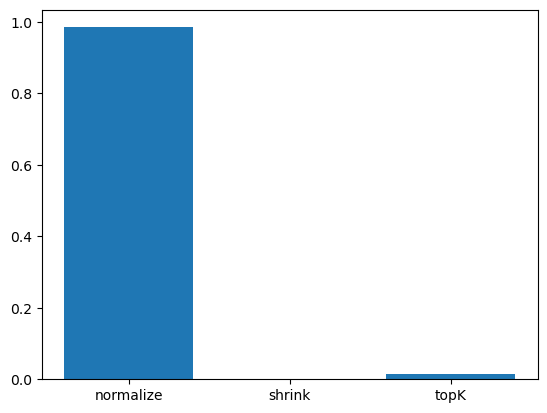

In [12]:
_feature_importance(save_results.results_df)

In this case the normalize hyperparameter is super important, indeed we have good results only when normalize=True, the other two are less important.

If we isolate only the cases when normalize=True, we can see that the second most important hyperparameter is topk by a lot

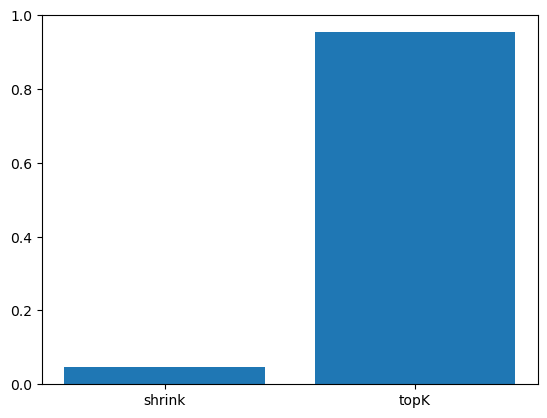

In [13]:
results_df = save_results.results_df.copy()
results_df = results_df[results_df["normalize"] == 1.0]
results_df = results_df.drop(["normalize"], axis=1)

_feature_importance(results_df)

### Optuna supports various tools such as a database to store the results which can be used for nice visualizations, try them!


Optuna also supports conditional hyperparameters, which may be required only based on another hyperparameter value. In the following function several similarity heuristics are optimized.

In [14]:
def objective_function_KNN_similarities(optuna_trial):
    recommender_instance = ItemKNNCFRecommender(URM_train)
    similarity = optuna_trial.suggest_categorical(
        "similarity",
        ["cosine", "dice", "jaccard", "asymmetric", "tversky", "euclidean"],
    )

    full_hyperp = {
        "similarity": similarity,
        "topK": optuna_trial.suggest_int("topK", 5, 1000),
        "shrink": optuna_trial.suggest_int("shrink", 0, 1000),
    }

    if similarity == "asymmetric":
        full_hyperp["asymmetric_alpha"] = optuna_trial.suggest_float(
            "asymmetric_alpha", 0, 2, log=False
        )
        full_hyperp["normalize"] = True

    elif similarity == "tversky":
        full_hyperp["tversky_alpha"] = optuna_trial.suggest_float(
            "tversky_alpha", 0, 2, log=False
        )
        full_hyperp["tversky_beta"] = optuna_trial.suggest_float(
            "tversky_beta", 0, 2, log=False
        )
        full_hyperp["normalize"] = True

    elif similarity == "euclidean":
        full_hyperp["normalize_avg_row"] = optuna_trial.suggest_categorical(
            "normalize_avg_row", [True, False]
        )
        full_hyperp["similarity_from_distance_mode"] = optuna_trial.suggest_categorical(
            "similarity_from_distance_mode", ["lin", "log", "exp"]
        )
        full_hyperp["normalize"] = optuna_trial.suggest_categorical(
            "normalize", [True, False]
        )

    recommender_instance.fit(**full_hyperp)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_instance)

    return result_df.loc[10]["MAP"]

In [15]:
optuna_study = optuna.create_study(direction="maximize")

save_results = SaveResults()

optuna_study.optimize(
    objective_function_KNN_similarities, callbacks=[save_results], n_trials=50
)

[I 2023-11-24 14:54:00,173] A new study created in memory with name: no-name-ab6c298f-1c35-4e58-9704-71753054dbdc


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4747.50 column/sec. Elapsed time 0.82 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.20 sec. Users per second: 1436


[I 2023-11-24 14:54:05,299] Trial 0 finished with value: 0.09180638817145713 and parameters: {'similarity': 'tversky', 'topK': 111, 'shrink': 884, 'tversky_alpha': 1.356177149713638, 'tversky_beta': 0.07110177200086643}. Best is trial 0 with value: 0.09180638817145713.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4500.36 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174


[I 2023-11-24 14:54:11,449] Trial 1 finished with value: 0.10301071935381094 and parameters: {'similarity': 'cosine', 'topK': 785, 'shrink': 93}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4607.68 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.24 sec. Users per second: 1423


[I 2023-11-24 14:54:16,635] Trial 2 finished with value: 0.09925147501362445 and parameters: {'similarity': 'dice', 'topK': 156, 'shrink': 824}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4555.76 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.65 sec. Users per second: 1068


[I 2023-11-24 14:54:23,292] Trial 3 finished with value: 0.01840662327849258 and parameters: {'similarity': 'asymmetric', 'topK': 960, 'shrink': 983, 'asymmetric_alpha': 1.19533423108744}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4449.11 column/sec. Elapsed time 0.87 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.19 sec. Users per second: 1162


[I 2023-11-24 14:54:29,517] Trial 4 finished with value: 0.08727186982494685 and parameters: {'similarity': 'tversky', 'topK': 664, 'shrink': 920, 'tversky_alpha': 0.48560512582469384, 'tversky_beta': 1.8041510480640255}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 590.52 column/sec. Elapsed time 6.58 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.37 sec. Users per second: 1379


[I 2023-11-24 14:54:40,589] Trial 5 finished with value: 0.05743622096375486 and parameters: {'similarity': 'euclidean', 'topK': 910, 'shrink': 16, 'normalize_avg_row': True, 'similarity_from_distance_mode': 'lin', 'normalize': True}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4499.39 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.73 sec. Users per second: 1276


[I 2023-11-24 14:54:46,318] Trial 6 finished with value: 0.09546425741192706 and parameters: {'similarity': 'tversky', 'topK': 497, 'shrink': 280, 'tversky_alpha': 1.8436167628759952, 'tversky_beta': 1.420190490736325}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4585.09 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.31 sec. Users per second: 1136


[I 2023-11-24 14:54:52,633] Trial 7 finished with value: 0.09524509842638917 and parameters: {'similarity': 'dice', 'topK': 669, 'shrink': 834}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4557.05 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.31 sec. Users per second: 1135


[I 2023-11-24 14:54:58,909] Trial 8 finished with value: 0.014772541183222875 and parameters: {'similarity': 'asymmetric', 'topK': 610, 'shrink': 705, 'asymmetric_alpha': 1.9600274188047948}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4500.25 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.46 sec. Users per second: 1104


[I 2023-11-24 14:55:05,404] Trial 9 finished with value: 0.0874925492395226 and parameters: {'similarity': 'tversky', 'topK': 799, 'shrink': 959, 'tversky_alpha': 0.45620214715305774, 'tversky_beta': 0.4734019447415978}. Best is trial 1 with value: 0.10301071935381094.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4564.93 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.68 sec. Users per second: 1289


[I 2023-11-24 14:55:11,034] Trial 10 finished with value: 0.10524280790991677 and parameters: {'similarity': 'cosine', 'topK': 420, 'shrink': 347}. Best is trial 10 with value: 0.10524280790991677.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4552.10 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.53 sec. Users per second: 1330


[I 2023-11-24 14:55:16,513] Trial 11 finished with value: 0.10575785818280398 and parameters: {'similarity': 'cosine', 'topK': 357, 'shrink': 293}. Best is trial 11 with value: 0.10575785818280398.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4404.44 column/sec. Elapsed time 0.88 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.62 sec. Users per second: 1306


[I 2023-11-24 14:55:22,108] Trial 12 finished with value: 0.1056516058626689 and parameters: {'similarity': 'cosine', 'topK': 367, 'shrink': 423}. Best is trial 11 with value: 0.10575785818280398.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4500.67 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058


[I 2023-11-24 14:55:28,813] Trial 13 finished with value: 0.09964904417010921 and parameters: {'similarity': 'jaccard', 'topK': 334, 'shrink': 531}. Best is trial 11 with value: 0.10575785818280398.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4168.85 column/sec. Elapsed time 0.93 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.50 sec. Users per second: 1340


[I 2023-11-24 14:55:34,336] Trial 14 finished with value: 0.10617461370571296 and parameters: {'similarity': 'cosine', 'topK': 266, 'shrink': 432}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4557.42 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.32 sec. Users per second: 1396


[I 2023-11-24 14:55:39,613] Trial 15 finished with value: 0.10552346199717222 and parameters: {'similarity': 'cosine', 'topK': 245, 'shrink': 211}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4613.89 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.30 sec. Users per second: 1826


[I 2023-11-24 14:55:43,840] Trial 16 finished with value: 0.1057072693621043 and parameters: {'similarity': 'cosine', 'topK': 243, 'shrink': 587}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 2091.36 column/sec. Elapsed time 1.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.27 sec. Users per second: 1845


[I 2023-11-24 14:55:49,021] Trial 17 finished with value: 0.08026529841217263 and parameters: {'similarity': 'euclidean', 'topK': 5, 'shrink': 188, 'normalize_avg_row': False, 'similarity_from_distance_mode': 'log', 'normalize': False}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4600.23 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.37 sec. Users per second: 1381


[I 2023-11-24 14:55:54,361] Trial 18 finished with value: 0.10129954558259364 and parameters: {'similarity': 'jaccard', 'topK': 270, 'shrink': 419}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4604.46 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.78 sec. Users per second: 1260


[I 2023-11-24 14:56:00,110] Trial 19 finished with value: 0.10460468845026819 and parameters: {'similarity': 'cosine', 'topK': 451, 'shrink': 637}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4596.30 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.95 sec. Users per second: 1219


[I 2023-11-24 14:56:06,031] Trial 20 finished with value: 0.10386754364486989 and parameters: {'similarity': 'cosine', 'topK': 556, 'shrink': 492}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4614.30 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.23 sec. Users per second: 1424


[I 2023-11-24 14:56:11,186] Trial 21 finished with value: 0.1044052489686093 and parameters: {'similarity': 'cosine', 'topK': 186, 'shrink': 609}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4564.77 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.41 sec. Users per second: 1369


[I 2023-11-24 14:56:16,525] Trial 22 finished with value: 0.10570588715388841 and parameters: {'similarity': 'cosine', 'topK': 282, 'shrink': 342}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4603.25 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.94 sec. Users per second: 1531


[I 2023-11-24 14:56:21,377] Trial 23 finished with value: 0.10353699184102173 and parameters: {'similarity': 'cosine', 'topK': 80, 'shrink': 730}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4494.16 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.65 sec. Users per second: 1296


[I 2023-11-24 14:56:27,014] Trial 24 finished with value: 0.10581595700147671 and parameters: {'similarity': 'cosine', 'topK': 390, 'shrink': 531}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4560.42 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.66 sec. Users per second: 1293


[I 2023-11-24 14:56:32,637] Trial 25 finished with value: 0.10553737622654485 and parameters: {'similarity': 'cosine', 'topK': 403, 'shrink': 459}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.


C:\Users\MaurizioFD\PycharmProjects\RecSys_Course_AT_PoliMi\Recommenders\Similarity\Compute_Similarity_Euclidean.py:167: RuntimeWarning: overflow encountered in exp
  item_similarity = 1/(np.exp(item_distance) + self.shrink + 1e-9)


Similarity column 3883 (100.0%), 1055.70 column/sec. Elapsed time 3.68 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.93 sec. Users per second: 1532


[I 2023-11-24 14:56:40,323] Trial 26 finished with value: 0.07146480502965852 and parameters: {'similarity': 'euclidean', 'topK': 324, 'shrink': 346, 'normalize_avg_row': False, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4397.57 column/sec. Elapsed time 0.88 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.05 sec. Users per second: 1490


[I 2023-11-24 14:56:45,367] Trial 27 finished with value: 0.10373123158701195 and parameters: {'similarity': 'asymmetric', 'topK': 489, 'shrink': 222, 'asymmetric_alpha': 0.05765689448259392}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4608.34 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.23 sec. Users per second: 1426


[I 2023-11-24 14:56:50,569] Trial 28 finished with value: 0.10065722026080305 and parameters: {'similarity': 'dice', 'topK': 194, 'shrink': 548}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4664.55 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.72 sec. Users per second: 1619


[I 2023-11-24 14:56:55,234] Trial 29 finished with value: 0.09956856016028331 and parameters: {'similarity': 'jaccard', 'topK': 68, 'shrink': 132}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4609.69 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.87 sec. Users per second: 1238


[I 2023-11-24 14:57:01,081] Trial 30 finished with value: 0.10394805398247098 and parameters: {'similarity': 'cosine', 'topK': 555, 'shrink': 273}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4565.42 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.37 sec. Users per second: 1379


[I 2023-11-24 14:57:06,396] Trial 31 finished with value: 0.1057528295776762 and parameters: {'similarity': 'cosine', 'topK': 228, 'shrink': 629}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 3898.15 column/sec. Elapsed time 1.00 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.70 sec. Users per second: 1282


[I 2023-11-24 14:57:12,206] Trial 32 finished with value: 0.10553010976049608 and parameters: {'similarity': 'cosine', 'topK': 362, 'shrink': 394}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4654.15 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.13 sec. Users per second: 1461


[I 2023-11-24 14:57:17,237] Trial 33 finished with value: 0.10409399542423223 and parameters: {'similarity': 'cosine', 'topK': 130, 'shrink': 668}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4557.73 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.18 sec. Users per second: 1443


[I 2023-11-24 14:57:22,360] Trial 34 finished with value: 0.10541641326182687 and parameters: {'similarity': 'cosine', 'topK': 212, 'shrink': 778}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4555.26 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.38 sec. Users per second: 1376


[I 2023-11-24 14:57:27,696] Trial 35 finished with value: 0.10543925260710754 and parameters: {'similarity': 'cosine', 'topK': 305, 'shrink': 560}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4555.23 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.73 sec. Users per second: 1275


[I 2023-11-24 14:57:33,426] Trial 36 finished with value: 0.10000319882472795 and parameters: {'similarity': 'dice', 'topK': 409, 'shrink': 486}. Best is trial 14 with value: 0.10617461370571296.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4606.64 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.65 sec. Users per second: 1651


[I 2023-11-24 14:57:38,010] Trial 37 finished with value: 0.10652225223588643 and parameters: {'similarity': 'asymmetric', 'topK': 153, 'shrink': 274, 'asymmetric_alpha': 0.07704026305087841}. Best is trial 37 with value: 0.10652225223588643.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4608.01 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.54 sec. Users per second: 1704


[I 2023-11-24 14:57:42,481] Trial 38 finished with value: 0.09716794093100284 and parameters: {'similarity': 'asymmetric', 'topK': 128, 'shrink': 87, 'asymmetric_alpha': 0.06647579227934189}. Best is trial 37 with value: 0.10652225223588643.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4612.02 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.70 sec. Users per second: 1629


[I 2023-11-24 14:57:47,096] Trial 39 finished with value: 0.0887723950640689 and parameters: {'similarity': 'asymmetric', 'topK': 29, 'shrink': 274, 'asymmetric_alpha': 0.5941022520125943}. Best is trial 37 with value: 0.10652225223588643.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4531.18 column/sec. Elapsed time 0.86 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.49 sec. Users per second: 1343


[I 2023-11-24 14:57:52,527] Trial 40 finished with value: 0.08575829917304452 and parameters: {'similarity': 'asymmetric', 'topK': 182, 'shrink': 309, 'asymmetric_alpha': 0.6631601018018185}. Best is trial 37 with value: 0.10652225223588643.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4552.81 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.25 sec. Users per second: 1419


[I 2023-11-24 14:57:57,764] Trial 41 finished with value: 0.09683882399092185 and parameters: {'similarity': 'tversky', 'topK': 240, 'shrink': 388, 'tversky_alpha': 0.0929369022279356, 'tversky_beta': 0.8910821271624274}. Best is trial 37 with value: 0.10652225223588643.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4552.86 column/sec. Elapsed time 0.85 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.71 sec. Users per second: 1623


[I 2023-11-24 14:58:02,419] Trial 42 finished with value: 0.10887136117232304 and parameters: {'similarity': 'asymmetric', 'topK': 145, 'shrink': 452, 'asymmetric_alpha': 0.0967263194468786}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4612.36 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.55 sec. Users per second: 1698


[I 2023-11-24 14:58:06,890] Trial 43 finished with value: 0.10200923051810436 and parameters: {'similarity': 'asymmetric', 'topK': 75, 'shrink': 445, 'asymmetric_alpha': 0.017633268123771417}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4671.14 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.05 sec. Users per second: 1490


[I 2023-11-24 14:58:11,857] Trial 44 finished with value: 0.10648416910856771 and parameters: {'similarity': 'asymmetric', 'topK': 150, 'shrink': 523, 'asymmetric_alpha': 0.43639715240893884}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4661.43 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.01 sec. Users per second: 1504


[I 2023-11-24 14:58:16,789] Trial 45 finished with value: 0.10624167055001332 and parameters: {'similarity': 'asymmetric', 'topK': 153, 'shrink': 503, 'asymmetric_alpha': 0.3923950838442256}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4653.75 column/sec. Elapsed time 0.83 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 4.02 sec. Users per second: 1500


[I 2023-11-24 14:58:21,731] Trial 46 finished with value: 0.1061879223962486 and parameters: {'similarity': 'asymmetric', 'topK': 152, 'shrink': 374, 'asymmetric_alpha': 0.3542588203198769}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 3811.34 column/sec. Elapsed time 1.02 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.99 sec. Users per second: 1513


[I 2023-11-24 14:58:26,842] Trial 47 finished with value: 0.10612730269306797 and parameters: {'similarity': 'asymmetric', 'topK': 151, 'shrink': 379, 'asymmetric_alpha': 0.3552404834925272}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4599.39 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.87 sec. Users per second: 1558


[I 2023-11-24 14:58:31,640] Trial 48 finished with value: 0.10619279961666721 and parameters: {'similarity': 'asymmetric', 'topK': 104, 'shrink': 488, 'asymmetric_alpha': 0.37421190413939476}. Best is trial 42 with value: 0.10887136117232304.


ItemKNNCFRecommender: URM Detected 240 ( 6.2%) items with no interactions.
Similarity column 3883 (100.0%), 4607.47 column/sec. Elapsed time 0.84 sec
EvaluatorHoldout: Processed 6029 (100.0%) in 3.80 sec. Users per second: 1585


[I 2023-11-24 14:58:36,369] Trial 49 finished with value: 0.106262048248281 and parameters: {'similarity': 'asymmetric', 'topK': 98, 'shrink': 500, 'asymmetric_alpha': 0.3253251774081455}. Best is trial 42 with value: 0.10887136117232304.


In [16]:
save_results.results_df

result  shrink  similarity   topK  tversky_alpha  tversky_beta  \
0   0.091806   884.0     tversky  111.0       1.356177      0.071102   
1   0.103011    93.0      cosine  785.0            NaN           NaN   
2   0.099251   824.0        dice  156.0            NaN           NaN   
3   0.018407   983.0  asymmetric  960.0            NaN           NaN   
4   0.087272   920.0     tversky  664.0       0.485605      1.804151   
5   0.057436    16.0   euclidean  910.0            NaN           NaN   
6   0.095464   280.0     tversky  497.0       1.843617      1.420190   
7   0.095245   834.0        dice  669.0            NaN           NaN   
8   0.014773   705.0  asymmetric  610.0            NaN           NaN   
9   0.087493   959.0     tversky  799.0       0.456202      0.473402   
10  0.105243   347.0      cosine  420.0            NaN           NaN   
11  0.105758   293.0      cosine  357.0            NaN           NaN   
12  0.105652   423.0      cosine  367.0            NaN           NaN   
13  0.099649   531.0     jaccard  334.0            NaN           NaN   
14  0.106175   432.0      cosine  266.0            NaN           NaN   
15  0.105523   211.0      cosine  245.0            NaN           NaN   
16  0.105707   587.0      cosine  243.0            NaN           NaN   
17  0.080265   188.0   euclidean    5.0            NaN           NaN   
18  0.101300   419.0     jaccard  270.0            NaN           NaN   
19  0.104605   637.0      cosine  451.0            NaN           NaN   
20  0.103868   492.0      cosine  556.0            NaN           NaN   
21  0.104405   609.0      cosine  186.0            NaN           NaN   
22  0.105706   342.0      cosine  282.0            NaN           NaN   
23  0.103537   730.0      cosine   80.0            NaN           NaN   
24  0.105816   531.0      cosine  390.0            NaN           NaN   
25  0.105537   459.0      cosine  403.0            NaN           NaN   
26  0.071465   346.0   euclidean  324.0            NaN           NaN   
27  0.103731   222.0  asymmetric  489.0            NaN           NaN   
28  0.100657   548.0        dice  194.0            NaN           NaN   
29  0.099569   132.0     jaccard   68.0            NaN           NaN   
30  0.103948   273.0      cosine  555.0            NaN           NaN   
31  0.105753   629.0      cosine  228.0            NaN           NaN   
32  0.105530   394.0      cosine  362.0            NaN           NaN   
33  0.104094   668.0      cosine  130.0            NaN           NaN   
34  0.105416   778.0      cosine  212.0            NaN           NaN   
35  0.105439   560.0      cosine  305.0            NaN           NaN   
36  0.100003   486.0        dice  409.0            NaN           NaN   
37  0.106522   274.0  asymmetric  153.0            NaN           NaN   
38  0.097168    87.0  asymmetric  128.0            NaN           NaN   
39  0.088772   274.0  asymmetric   29.0            NaN           NaN   
40  0.085758   309.0  asymmetric  182.0            NaN           NaN   
41  0.096839   388.0     tversky  240.0       0.092937      0.891082   
42  0.108871   452.0  asymmetric  145.0            NaN           NaN   
43  0.102009   445.0  asymmetric   75.0            NaN           NaN   
44  0.106484   523.0  asymmetric  150.0            NaN           NaN   
45  0.106242   503.0  asymmetric  153.0            NaN           NaN   
46  0.106188   374.0  asymmetric  152.0            NaN           NaN   
47  0.106127   379.0  asymmetric  151.0            NaN           NaN   
48  0.106193   488.0  asymmetric  104.0            NaN           NaN   
49  0.106262   500.0  asymmetric   98.0            NaN           NaN   

    asymmetric_alpha  normalize  normalize_avg_row  \
0                NaN        NaN                NaN   
1                NaN        NaN                NaN   
2                NaN        NaN                NaN   
3           1.195334        NaN                NaN   
4                NaN        NaN                NaN   
5        

In [17]:
optuna_study.best_trial.params

{'similarity': 'asymmetric',
 'topK': 145,
 'shrink': 452,
 'asymmetric_alpha': 0.0967263194468786}

In [18]:
recommender_instance = ItemKNNCFRecommender(URM_train + URM_validation)
recommender_instance.fit(**optuna_study.best_trial.params)

result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
result_df

ItemKNNCFRecommender: URM Detected 204 ( 5.3%) items with no interactions.
Similarity column 3883 (100.0%), 3332.55 column/sec. Elapsed time 1.17 sec
EvaluatorHoldout: Processed 6038 (100.0%) in 3.81 sec. Users per second: 1583


PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
cutoff                                                                      
10      0.339748                 0.362464  0.149985  0.245904    0.257506   

             MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
cutoff                                                        ...   
10      0.623351  0.317127  0.208101  0.883902      1.170736  ...   

       COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
cutoff                                                              
10          0.999669          0.883609    0.999669       0.047767   

       SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
cutoff                                                                   
10            7.949859                   0.994743             0.136562   

       RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
cutoff                                                               
10                  0.735182                  1.71452      0.065643  

[1 rows x 27 columns]

### An example with earlystopping, for SVD++

When training machine learning models that require iterative training for a certain number of epochs one also has to select this value. There are two strategies:
* Consider the number of epochs as another hyperparameter to be determined by our optimizer
* Fix a maximum number of epochs and periodically evaluate the model during the training process. If the recommendation quality does not improve after a certain number of epochs (20, 50 ...) stop the training and select the number of epochs that gave the best result. This is called earlystopping.

In [19]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import (
    MatrixFactorization_SVDpp_Cython,
)
import time


class SaveResults(object):
    def __init__(self):
        self.results_df = pd.DataFrame(columns=["result", "train_time (min)"])

    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]

        # Retrieve the optimal number of epochs and training time from the "user attributes" of the trial
        hyperparam_dict["epochs"] = optuna_trial.user_attrs["epochs"]
        hyperparam_dict["train_time (min)"] = optuna_trial.user_attrs[
            "train_time (min)"
        ]

        self.results_df = self.results_df.append(hyperparam_dict, ignore_index=True)


def objective_function_funksvd(optuna_trial):
    # Earlystopping hyperparameters available in the framework
    full_hyperp = {
        "validation_every_n": 5,
        "stop_on_validation": True,
        "evaluator_object": evaluator_validation,
        "lower_validations_allowed": 5,  # Higher values will result in a more "patient" earlystopping
        "validation_metric": "MAP",
        # MAX number of epochs (usually 500)
        "epochs": 500,
    }

    start_time = time.time()
    recommender_instance = MatrixFactorization_SVDpp_Cython(URM_train)
    recommender_instance.fit(
        num_factors=optuna_trial.suggest_int("num_factors", 1, 200),
        sgd_mode=optuna_trial.suggest_categorical(
            "sgd_mode", ["sgd", "adagrad", "adam"]
        ),
        batch_size=optuna_trial.suggest_categorical(
            "batch_size", [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
        ),
        item_reg=optuna_trial.suggest_float("item_reg", 1e-5, 1e-2, log=True),
        user_reg=optuna_trial.suggest_float("user_reg", 1e-5, 1e-2, log=True),
        learning_rate=optuna_trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        **full_hyperp,
    )

    # Add the number of epochs selected by earlystopping as a "user attribute" of the optuna trial
    epochs = recommender_instance.get_early_stopping_final_epochs_dict()["epochs"]
    optuna_trial.set_user_attr("epochs", epochs)
    optuna_trial.set_user_attr("train_time (min)", (time.time() - start_time) / 60)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_instance)

    return result_df.loc[10]["MAP"]

In [20]:
optuna_study = optuna.create_study(direction="maximize")

save_results = SaveResults()

optuna_study.optimize(objective_function_funksvd, callbacks=[save_results], n_trials=50)

[I 2023-11-24 14:58:41,567] A new study created in memory with name: no-name-45701efd-2a50-4ce8-916a-7b32aef636f1


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 641024 (100.0%) in 3.05 sec. MSE loss 1.16E+01. Sample per second: 209879
SVD++: Epoch 1 of 500. Elapsed time 2.42 sec
SVD++: Processed 641024 (100.0%) in 2.46 sec. MSE loss 6.93E+00. Sample per second: 260677
SVD++: Epoch 2 of 500. Elapsed time 4.83 sec
SVD++: Processed 641024 (100.0%) in 2.97 sec. MSE loss 4.39E+00. Sample per second: 216021
SVD++: Epoch 3 of 500. Elapsed time 7.34 sec
SVD++: Processed 641024 (100.0%) in 3.36 sec. MSE loss 2.97E+00. Sample per second: 190551
SVD++: Epoch 4 of 500. Elapsed time 9.73 sec
SVD++: Processed 641024 (100.0%) in 2.76 sec. MSE loss 2.20E+00. Sample per second: 232208
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.39 sec. Users per second: 1780
SVD++: CUTOFF: 10 - PRECISION: 0.0080776, PRECISION_RECALL_MIN_DEN: 0.0085469, RECALL: 0.0030707, MAP: 0.0025093, MAP_MIN_DEN: 0.0026291, MRR: 0.0229315, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 1.38 min
SVD++: Processed 641024 (100.0%) in 2.84 sec. MSE loss 1.24E+00. Sample per second: 226107
SVD++: Epoch 28 of 500. Elapsed time 1.42 min
SVD++: Processed 641024 (100.0%) in 3.23 sec. MSE loss 1.23E+00. Sample per second: 198335
SVD++: Epoch 29 of 500. Elapsed time 1.46 min
SVD++: Processed 641024 (100.0%) in 2.63 sec. MSE loss 1.23E+00. Sample per second: 243955
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1742
SVD++: CUTOFF: 10 - PRECISION: 0.0089069, PRECISION_RECALL_MIN_DEN: 0.0093975, RECALL: 0.0034345, MAP: 0.0027797, MAP_MIN_DEN: 0.0029098, MRR: 0.0251863, NDCG: 0.0053245, F1: 0.0049574, HIT_RATE: 0.0807762, ARHR_ALL_HITS: 0.0264526, NOVELTY: 0.0317921, AVERAGE_POPULARITY: 0.0821871, DIVERSITY_MEAN_INTER_LIST: 0.9962513, DIVERSITY_HERFINDAHL: 0.9996086, COVERAGE_ITEM: 0.9909864, COVERAGE_ITEM_HIT: 0.1035282, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.41 sec. Users per second: 1767
SVD++: CUTOFF: 10 - PRECISION: 0.0098192, PRECISION_RECALL_MIN_DEN: 0.0105214, RECALL: 0.0040247, MAP: 0.0031907, MAP_MIN_DEN: 0.0033854, MRR: 0.0287391, NDCG: 0.0064014, F1: 0.0057092, HIT_RATE: 0.0885719, ARHR_ALL_HITS: 0.0302816, NOVELTY: 0.0316772, AVERAGE_POPULARITY: 0.0891584, DIVERSITY_MEAN_INTER_LIST: 0.9961382, DIVERSITY_HERFINDAHL: 0.9995973, COVERAGE_ITEM: 0.9902138, COVERAGE_ITEM_HIT: 0.1043008, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0884106, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.6115292, SHANNON_ENTROPY: 11.5591600, RATIO_DIVERSITY_HERFINDAHL: 1.0004137, RATIO_DIVERSITY_GINI: 1.7478571, RATIO_SHANNON_ENTROPY: 1.0689515, RATIO_AVERAGE_POPULARITY: 0.3212807, RATIO_NOVELTY: 0.1073277, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.85 min
SVD++: Processed 641024 (100.0%) in 3.06 sec. MSE loss 1.23E+00. Sa

SVD++: Processed 641024 (100.0%) in 3.36 sec. MSE loss 1.22E+00. Sample per second: 191010
SVD++: Epoch 81 of 500. Elapsed time 4.18 min
SVD++: Processed 641024 (100.0%) in 2.75 sec. MSE loss 1.22E+00. Sample per second: 233113
SVD++: Epoch 82 of 500. Elapsed time 4.22 min
SVD++: Processed 641024 (100.0%) in 3.13 sec. MSE loss 1.22E+00. Sample per second: 204537
SVD++: Epoch 83 of 500. Elapsed time 4.26 min
SVD++: Processed 641024 (100.0%) in 2.53 sec. MSE loss 1.22E+00. Sample per second: 253618
SVD++: Epoch 84 of 500. Elapsed time 4.30 min
SVD++: Processed 641024 (100.0%) in 2.95 sec. MSE loss 1.22E+00. Sample per second: 217206
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.42 sec. Users per second: 1762
SVD++: CUTOFF: 10 - PRECISION: 0.0113618, PRECISION_RECALL_MIN_DEN: 0.0122431, RECALL: 0.0049159, MAP: 0.0038657, MAP_MIN_DEN: 0.0041376, MRR: 0.0346901, NDCG: 0.0081704, F1: 0.0068626, HIT_RATE: 0.1025046, ARHR_ALL_HITS: 0.0366237, NOVELTY: 0.0314735, AV

SVD++: Epoch 108 of 500. Elapsed time 5.55 min
SVD++: Processed 641024 (100.0%) in 2.80 sec. MSE loss 1.21E+00. Sample per second: 229137
SVD++: Epoch 109 of 500. Elapsed time 5.59 min
SVD++: Processed 641024 (100.0%) in 3.20 sec. MSE loss 1.22E+00. Sample per second: 200273
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.38 sec. Users per second: 1781
SVD++: CUTOFF: 10 - PRECISION: 0.0128877, PRECISION_RECALL_MIN_DEN: 0.0140170, RECALL: 0.0059028, MAP: 0.0045198, MAP_MIN_DEN: 0.0048767, MRR: 0.0404236, NDCG: 0.0100412, F1: 0.0080971, HIT_RATE: 0.1159396, ARHR_ALL_HITS: 0.0427407, NOVELTY: 0.0312530, AVERAGE_POPULARITY: 0.1159073, DIVERSITY_MEAN_INTER_LIST: 0.9948380, DIVERSITY_HERFINDAHL: 0.9994673, COVERAGE_ITEM: 0.9858357, COVERAGE_ITEM_HIT: 0.1024981, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1157285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5786844, SHANNON_ENTROPY: 11.4501379, RATIO_DIVERSITY_HERFINDAHL: 1.0002836, RATIO_DI

SVD++: CUTOFF: 10 - PRECISION: 0.0154420, PRECISION_RECALL_MIN_DEN: 0.0171412, RECALL: 0.0076690, MAP: 0.0055170, MAP_MIN_DEN: 0.0060745, MRR: 0.0491664, NDCG: 0.0129871, F1: 0.0102483, HIT_RATE: 0.1391607, ARHR_ALL_HITS: 0.0520282, NOVELTY: 0.0309381, AVERAGE_POPULARITY: 0.1344584, DIVERSITY_MEAN_INTER_LIST: 0.9930001, DIVERSITY_HERFINDAHL: 0.9992835, COVERAGE_ITEM: 0.9840330, COVERAGE_ITEM_HIT: 0.1012104, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1389073, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5566399, SHANNON_ENTROPY: 11.3519613, RATIO_DIVERSITY_HERFINDAHL: 1.0000997, RATIO_DIVERSITY_GINI: 1.5909739, RATIO_SHANNON_ENTROPY: 1.0497904, RATIO_AVERAGE_POPULARITY: 0.4845185, RATIO_NOVELTY: 0.1048234, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 6.97 min
SVD++: Processed 641024 (100.0%) in 2.41 sec. MSE loss 1.21E+00. Sample per second: 265927
SVD++: Epoch 136 of 500. Elapsed time 7.01 min
SVD++: Processed 641024 (100.0%) i

SVD++: Processed 641024 (100.0%) in 2.79 sec. MSE loss 1.21E+00. Sample per second: 230057
SVD++: Epoch 161 of 500. Elapsed time 8.30 min
SVD++: Processed 641024 (100.0%) in 3.21 sec. MSE loss 1.21E+00. Sample per second: 199636
SVD++: Epoch 162 of 500. Elapsed time 8.34 min
SVD++: Processed 641024 (100.0%) in 2.61 sec. MSE loss 1.21E+00. Sample per second: 246022
SVD++: Epoch 163 of 500. Elapsed time 8.38 min
SVD++: Processed 641024 (100.0%) in 3.26 sec. MSE loss 1.21E+00. Sample per second: 196736
SVD++: Epoch 164 of 500. Elapsed time 8.43 min
SVD++: Processed 641024 (100.0%) in 2.85 sec. MSE loss 1.21E+00. Sample per second: 224902
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.41 sec. Users per second: 1769
SVD++: CUTOFF: 10 - PRECISION: 0.0190579, PRECISION_RECALL_MIN_DEN: 0.0212020, RECALL: 0.0097966, MAP: 0.0072524, MAP_MIN_DEN: 0.0081016, MRR: 0.0636201, NDCG: 0.0174829, F1: 0.0129410, HIT_RATE: 0.1676895, ARHR_ALL_HITS: 0.0678313, NOVELTY: 0.0304921

SVD++: Epoch 188 of 500. Elapsed time 9.68 min
SVD++: Processed 641024 (100.0%) in 2.56 sec. MSE loss 1.20E+00. Sample per second: 250178
SVD++: Epoch 189 of 500. Elapsed time 9.72 min
SVD++: Processed 641024 (100.0%) in 2.98 sec. MSE loss 1.21E+00. Sample per second: 215267
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1749
SVD++: CUTOFF: 10 - PRECISION: 0.0230884, PRECISION_RECALL_MIN_DEN: 0.0257171, RECALL: 0.0121066, MAP: 0.0090085, MAP_MIN_DEN: 0.0102065, MRR: 0.0776221, NDCG: 0.0219513, F1: 0.0158842, HIT_RATE: 0.1990380, ARHR_ALL_HITS: 0.0834481, NOVELTY: 0.0300783, AVERAGE_POPULARITY: 0.1883594, DIVERSITY_MEAN_INTER_LIST: 0.9835521, DIVERSITY_HERFINDAHL: 0.9983389, COVERAGE_ITEM: 0.9775946, COVERAGE_ITEM_HIT: 0.0986351, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1986755, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4901567, SHANNON_ENTROPY: 10.9947960, RATIO_DIVERSITY_HERFINDAHL: 0.9991543, RATIO_DI

EvaluatorHoldout: Processed 6029 (100.0%) in 3.43 sec. Users per second: 1756
SVD++: CUTOFF: 10 - PRECISION: 0.0270858, PRECISION_RECALL_MIN_DEN: 0.0301935, RECALL: 0.0144267, MAP: 0.0110401, MAP_MIN_DEN: 0.0124589, MRR: 0.0935839, NDCG: 0.0269219, F1: 0.0188261, HIT_RATE: 0.2285620, ARHR_ALL_HITS: 0.1014620, NOVELTY: 0.0296257, AVERAGE_POPULARITY: 0.2175334, DIVERSITY_MEAN_INTER_LIST: 0.9757511, DIVERSITY_HERFINDAHL: 0.9975589, COVERAGE_ITEM: 0.9727015, COVERAGE_ITEM_HIT: 0.0952871, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2281457, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4558102, SHANNON_ENTROPY: 10.7727136, RATIO_DIVERSITY_HERFINDAHL: 0.9983737, RATIO_DIVERSITY_GINI: 1.3027852, RATIO_SHANNON_ENTROPY: 0.9962236, RATIO_AVERAGE_POPULARITY: 0.7838778, RATIO_NOVELTY: 0.1003767, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 11.11 min
SVD++: Processed 641024 (100.0%) in 2.80 sec. MSE loss 1.20E+00. Sample per second: 228598
SV

SVD++: Processed 641024 (100.0%) in 3.20 sec. MSE loss 1.20E+00. Sample per second: 200575
SVD++: Epoch 241 of 500. Elapsed time 12.44 min
SVD++: Processed 641024 (100.0%) in 2.59 sec. MSE loss 1.20E+00. Sample per second: 247370
SVD++: Epoch 242 of 500. Elapsed time 12.48 min
SVD++: Processed 641024 (100.0%) in 2.98 sec. MSE loss 1.20E+00. Sample per second: 214809
SVD++: Epoch 243 of 500. Elapsed time 12.52 min
SVD++: Processed 641024 (100.0%) in 3.37 sec. MSE loss 1.20E+00. Sample per second: 190172
SVD++: Epoch 244 of 500. Elapsed time 12.56 min
SVD++: Processed 641024 (100.0%) in 2.77 sec. MSE loss 1.20E+00. Sample per second: 231818
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.43 sec. Users per second: 1756
SVD++: CUTOFF: 10 - PRECISION: 0.0322773, PRECISION_RECALL_MIN_DEN: 0.0362815, RECALL: 0.0177253, MAP: 0.0137937, MAP_MIN_DEN: 0.0155557, MRR: 0.1138121, NDCG: 0.0334502, F1: 0.0228838, HIT_RATE: 0.2638912, ARHR_ALL_HITS: 0.1250990, NOVELTY: 0.029

SVD++: Epoch 268 of 500. Elapsed time 13.81 min
SVD++: Processed 641024 (100.0%) in 2.54 sec. MSE loss 1.20E+00. Sample per second: 252495
SVD++: Epoch 269 of 500. Elapsed time 13.85 min
SVD++: Processed 641024 (100.0%) in 2.92 sec. MSE loss 1.20E+00. Sample per second: 219576
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.41 sec. Users per second: 1767
SVD++: CUTOFF: 10 - PRECISION: 0.0370708, PRECISION_RECALL_MIN_DEN: 0.0416709, RECALL: 0.0204020, MAP: 0.0161443, MAP_MIN_DEN: 0.0181584, MRR: 0.1292864, NDCG: 0.0389607, F1: 0.0263192, HIT_RATE: 0.2935810, ARHR_ALL_HITS: 0.1441858, NOVELTY: 0.0285098, AVERAGE_POPULARITY: 0.2897066, DIVERSITY_MEAN_INTER_LIST: 0.9485924, DIVERSITY_HERFINDAHL: 0.9948435, COVERAGE_ITEM: 0.9587947, COVERAGE_ITEM_HIT: 0.0878187, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2930464, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3713326, SHANNON_ENTROPY: 10.1473238, RATIO_DIVERSITY_HERFINDAHL: 0.9956561, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 3.42 sec. Users per second: 1762
SVD++: CUTOFF: 10 - PRECISION: 0.0419141, PRECISION_RECALL_MIN_DEN: 0.0471894, RECALL: 0.0234016, MAP: 0.0187087, MAP_MIN_DEN: 0.0210245, MRR: 0.1461251, NDCG: 0.0449789, F1: 0.0300343, HIT_RATE: 0.3241002, ARHR_ALL_HITS: 0.1649836, NOVELTY: 0.0279973, AVERAGE_POPULARITY: 0.3237937, DIVERSITY_MEAN_INTER_LIST: 0.9319286, DIVERSITY_HERFINDAHL: 0.9931774, COVERAGE_ITEM: 0.9484934, COVERAGE_ITEM_HIT: 0.0842132, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3235099, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3327265, SHANNON_ENTROPY: 9.8220272, RATIO_DIVERSITY_HERFINDAHL: 0.9939886, RATIO_DIVERSITY_GINI: 0.9509903, RATIO_SHANNON_ENTROPY: 0.9083074, RATIO_AVERAGE_POPULARITY: 1.1667846, RATIO_NOVELTY: 0.0948596, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 15.23 min
SVD++: Processed 641024 (100.0%) in 2.99 sec. MSE loss 1.19E+00. Sample per second: 214574
SVD

SVD++: Processed 641024 (100.0%) in 2.73 sec. MSE loss 1.19E+00. Sample per second: 234560
SVD++: Epoch 321 of 500. Elapsed time 16.59 min
SVD++: Processed 641024 (100.0%) in 3.20 sec. MSE loss 1.19E+00. Sample per second: 200571
SVD++: Epoch 322 of 500. Elapsed time 16.63 min
SVD++: Processed 641024 (100.0%) in 2.60 sec. MSE loss 1.19E+00. Sample per second: 246603
SVD++: Epoch 323 of 500. Elapsed time 16.67 min
SVD++: Processed 641024 (100.0%) in 3.01 sec. MSE loss 1.18E+00. Sample per second: 212812
SVD++: Epoch 324 of 500. Elapsed time 16.71 min
SVD++: Processed 641024 (100.0%) in 2.43 sec. MSE loss 1.19E+00. Sample per second: 264246
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.44 sec. Users per second: 1751
SVD++: CUTOFF: 10 - PRECISION: 0.0480179, PRECISION_RECALL_MIN_DEN: 0.0542023, RECALL: 0.0270310, MAP: 0.0216241, MAP_MIN_DEN: 0.0241374, MRR: 0.1632342, NDCG: 0.0517382, F1: 0.0345900, HIT_RATE: 0.3597612, ARHR_ALL_HITS: 0.1873460, NOVELTY: 0.027

SVD++: Epoch 348 of 500. Elapsed time 17.96 min
SVD++: Processed 641024 (100.0%) in 2.62 sec. MSE loss 1.19E+00. Sample per second: 244196
SVD++: Epoch 349 of 500. Elapsed time 18.00 min
SVD++: Processed 641024 (100.0%) in 3.11 sec. MSE loss 1.19E+00. Sample per second: 205741
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.49 sec. Users per second: 1729
SVD++: CUTOFF: 10 - PRECISION: 0.0524299, PRECISION_RECALL_MIN_DEN: 0.0592857, RECALL: 0.0295300, MAP: 0.0239851, MAP_MIN_DEN: 0.0267099, MRR: 0.1769979, NDCG: 0.0569433, F1: 0.0377808, HIT_RATE: 0.3836457, ARHR_ALL_HITS: 0.2054674, NOVELTY: 0.0268524, AVERAGE_POPULARITY: 0.3970686, DIVERSITY_MEAN_INTER_LIST: 0.8863450, DIVERSITY_HERFINDAHL: 0.9886198, COVERAGE_ITEM: 0.9201648, COVERAGE_ITEM_HIT: 0.0759722, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3829470, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2514731, SHANNON_ENTROPY: 9.0523005, RATIO_DIVERSITY_HERFINDAHL: 0.9894273, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.62 sec. Users per second: 1668
SVD++: CUTOFF: 10 - PRECISION: 0.0563277, PRECISION_RECALL_MIN_DEN: 0.0637064, RECALL: 0.0316822, MAP: 0.0259648, MAP_MIN_DEN: 0.0288866, MRR: 0.1866292, NDCG: 0.0612821, F1: 0.0405542, HIT_RATE: 0.4012274, ARHR_ALL_HITS: 0.2194046, NOVELTY: 0.0263648, AVERAGE_POPULARITY: 0.4278932, DIVERSITY_MEAN_INTER_LIST: 0.8636138, DIVERSITY_HERFINDAHL: 0.9863471, COVERAGE_ITEM: 0.9075457, COVERAGE_ITEM_HIT: 0.0705640, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4004967, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2187081, SHANNON_ENTROPY: 8.7048649, RATIO_DIVERSITY_HERFINDAHL: 0.9871527, RATIO_DIVERSITY_GINI: 0.6251058, RATIO_SHANNON_ENTROPY: 0.8049960, RATIO_AVERAGE_POPULARITY: 1.5419053, RATIO_NOVELTY: 0.0893285, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 19.51 min
SVD++: Processed 641024 (100.0%) in 2.99 sec. MSE loss 1.18E+00. Sample per second: 214441
SVD

SVD++: Processed 641024 (100.0%) in 3.50 sec. MSE loss 1.18E+00. Sample per second: 182923
SVD++: Epoch 401 of 500. Elapsed time 20.96 min
SVD++: Processed 641024 (100.0%) in 3.16 sec. MSE loss 1.18E+00. Sample per second: 202810
SVD++: Epoch 402 of 500. Elapsed time 21.01 min
SVD++: Processed 641024 (100.0%) in 2.81 sec. MSE loss 1.18E+00. Sample per second: 228085
SVD++: Epoch 403 of 500. Elapsed time 21.05 min
SVD++: Processed 641024 (100.0%) in 3.47 sec. MSE loss 1.18E+00. Sample per second: 184925
SVD++: Epoch 404 of 500. Elapsed time 21.10 min
SVD++: Processed 641024 (100.0%) in 3.16 sec. MSE loss 1.18E+00. Sample per second: 202744
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.55 sec. Users per second: 1697
SVD++: CUTOFF: 10 - PRECISION: 0.0614530, PRECISION_RECALL_MIN_DEN: 0.0693968, RECALL: 0.0344427, MAP: 0.0284389, MAP_MIN_DEN: 0.0315802, MRR: 0.1982366, NDCG: 0.0665101, F1: 0.0441440, HIT_RATE: 0.4257754, ARHR_ALL_HITS: 0.2366498, NOVELTY: 0.025

SVD++: Epoch 428 of 500. Elapsed time 22.45 min
SVD++: Processed 641024 (100.0%) in 3.33 sec. MSE loss 1.18E+00. Sample per second: 192562
SVD++: Epoch 429 of 500. Elapsed time 22.49 min
SVD++: Processed 641024 (100.0%) in 2.92 sec. MSE loss 1.17E+00. Sample per second: 219210
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1722
SVD++: CUTOFF: 10 - PRECISION: 0.0655498, PRECISION_RECALL_MIN_DEN: 0.0739786, RECALL: 0.0367742, MAP: 0.0302626, MAP_MIN_DEN: 0.0335453, MRR: 0.2049317, NDCG: 0.0703478, F1: 0.0471159, HIT_RATE: 0.4418643, ARHR_ALL_HITS: 0.2481052, NOVELTY: 0.0254346, AVERAGE_POPULARITY: 0.4894943, DIVERSITY_MEAN_INTER_LIST: 0.8109610, DIVERSITY_HERFINDAHL: 0.9810826, COVERAGE_ITEM: 0.8560391, COVERAGE_ITEM_HIT: 0.0633531, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4410596, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1549742, SHANNON_ENTROPY: 7.9563635, RATIO_DIVERSITY_HERFINDAHL: 0.9818840, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.59 sec. Users per second: 1681
SVD++: CUTOFF: 10 - PRECISION: 0.0689998, PRECISION_RECALL_MIN_DEN: 0.0777378, RECALL: 0.0384585, MAP: 0.0318843, MAP_MIN_DEN: 0.0352493, MRR: 0.2107631, NDCG: 0.0736000, F1: 0.0493890, HIT_RATE: 0.4562946, ARHR_ALL_HITS: 0.2581610, NOVELTY: 0.0250706, AVERAGE_POPULARITY: 0.5129479, DIVERSITY_MEAN_INTER_LIST: 0.7886663, DIVERSITY_HERFINDAHL: 0.9788535, COVERAGE_ITEM: 0.8266804, COVERAGE_ITEM_HIT: 0.0610353, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4554636, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1319773, SHANNON_ENTROPY: 7.6548529, RATIO_DIVERSITY_HERFINDAHL: 0.9796530, RATIO_DIVERSITY_GINI: 0.3772143, RATIO_SHANNON_ENTROPY: 0.7078945, RATIO_AVERAGE_POPULARITY: 1.8483983, RATIO_NOVELTY: 0.0849433, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 23.99 min
SVD++: Processed 641024 (100.0%) in 3.58 sec. MSE loss 1.17E+00. Sample per second: 178755
SVD

SVD++: Processed 641024 (100.0%) in 2.81 sec. MSE loss 1.17E+00. Sample per second: 227914
SVD++: Epoch 481 of 500. Elapsed time 25.42 min
SVD++: Processed 641024 (100.0%) in 3.44 sec. MSE loss 1.17E+00. Sample per second: 186080
SVD++: Epoch 482 of 500. Elapsed time 25.46 min
SVD++: Processed 641024 (100.0%) in 2.99 sec. MSE loss 1.17E+00. Sample per second: 214616
SVD++: Epoch 483 of 500. Elapsed time 25.51 min
SVD++: Processed 641024 (100.0%) in 3.72 sec. MSE loss 1.17E+00. Sample per second: 172511
SVD++: Epoch 484 of 500. Elapsed time 25.55 min
SVD++: Processed 641024 (100.0%) in 3.30 sec. MSE loss 1.17E+00. Sample per second: 194504
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.66 sec. Users per second: 1646
SVD++: CUTOFF: 10 - PRECISION: 0.0730801, PRECISION_RECALL_MIN_DEN: 0.0824073, RECALL: 0.0407478, MAP: 0.0336906, MAP_MIN_DEN: 0.0371839, MRR: 0.2173425, NDCG: 0.0771688, F1: 0.0523220, HIT_RATE: 0.4748715, ARHR_ALL_HITS: 0.2691341, NOVELTY: 0.024

[I 2023-11-24 15:25:14,541] Trial 0 finished with value: 0.03449031401137892 and parameters: {'num_factors': 90, 'sgd_mode': 'sgd', 'batch_size': 1024, 'item_reg': 1.6745531739231798e-05, 'user_reg': 0.0038215203908408407, 'learning_rate': 0.00047424966666991637}. Best is trial 0 with value: 0.03449031401137892.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640160 (100.0%) in 17.42 sec. MSE loss 1.28E+01. Sample per second: 36754
SVD++: Epoch 1 of 500. Elapsed time 16.80 sec
SVD++: Processed 640160 (100.0%) in 17.21 sec. MSE loss 1.12E+01. Sample per second: 37188
SVD++: Epoch 2 of 500. Elapsed time 33.60 sec
SVD++: Processed 640160 (100.0%) in 17.18 sec. MSE loss 1.02E+01. Sample per second: 37270
SVD++: Epoch 3 of 500. Elapsed time 50.56 sec
SVD++: Processed 640160 (100.0%) in 16.98 sec. MSE loss 9.48E+00. Sample per second: 37698
SVD++: Epoch 4 of 500. Elapsed time 1.12 min
SVD++: Processed 640160 (100.0%) in 17.78 sec. MSE loss 8.88E+00. Sample per second: 36007
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.64 sec. Users per second: 1655
SVD++: CUTOFF: 10 - PRECISION: 0.0383480, PRECISION_RECALL_MIN_DEN: 0.0415566, RECALL: 0.0178876, MAP: 0.0146276, MAP_MIN_DEN: 0.0158065, MRR: 0.1109547, NDC

SVD++: Processed 640160 (100.0%) in 16.85 sec. MSE loss 3.68E+00. Sample per second: 37984
SVD++: Epoch 28 of 500. Elapsed time 8.04 min
SVD++: Processed 640160 (100.0%) in 16.91 sec. MSE loss 3.58E+00. Sample per second: 37858
SVD++: Epoch 29 of 500. Elapsed time 8.30 min
SVD++: Processed 640160 (100.0%) in 16.96 sec. MSE loss 3.48E+00. Sample per second: 37753
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1730
SVD++: CUTOFF: 10 - PRECISION: 0.0852214, PRECISION_RECALL_MIN_DEN: 0.0938483, RECALL: 0.0428726, MAP: 0.0376548, MAP_MIN_DEN: 0.0407448, MRR: 0.2172782, NDCG: 0.0765014, F1: 0.0570466, HIT_RATE: 0.5015757, ARHR_ALL_HITS: 0.2831906, NOVELTY: 0.0232389, AVERAGE_POPULARITY: 0.6054800, DIVERSITY_MEAN_INTER_LIST: 0.8468333, DIVERSITY_HERFINDAHL: 0.9846693, COVERAGE_ITEM: 0.2425959, COVERAGE_ITEM_HIT: 0.0697914, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5006623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.53 sec. Users per second: 1710
SVD++: CUTOFF: 10 - PRECISION: 0.0958368, PRECISION_RECALL_MIN_DEN: 0.1061123, RECALL: 0.0492082, MAP: 0.0424951, MAP_MIN_DEN: 0.0460939, MRR: 0.2302769, NDCG: 0.0870145, F1: 0.0650275, HIT_RATE: 0.5345828, ARHR_ALL_HITS: 0.3094870, NOVELTY: 0.0228381, AVERAGE_POPULARITY: 0.6534632, DIVERSITY_MEAN_INTER_LIST: 0.7861999, DIVERSITY_HERFINDAHL: 0.9786069, COVERAGE_ITEM: 0.1370075, COVERAGE_ITEM_HIT: 0.0520216, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5336093, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0157217, SHANNON_ENTROPY: 6.2382868, RATIO_DIVERSITY_HERFINDAHL: 0.9794062, RATIO_DIVERSITY_GINI: 0.0449353, RATIO_SHANNON_ENTROPY: 0.5768954, RATIO_AVERAGE_POPULARITY: 2.3547427, RATIO_NOVELTY: 0.0773792, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 15.62 min
SVD++: Processed 640160 (100.0%) in 16.79 sec. MSE loss 1.98E+00. S

SVD++: Processed 640160 (100.0%) in 21.19 sec. MSE loss 1.40E+00. Sample per second: 30207
SVD++: Epoch 81 of 500. Elapsed time 23.06 min
SVD++: Processed 640160 (100.0%) in 20.89 sec. MSE loss 1.38E+00. Sample per second: 30643
SVD++: Epoch 82 of 500. Elapsed time 23.40 min
SVD++: Processed 640160 (100.0%) in 21.56 sec. MSE loss 1.37E+00. Sample per second: 29685
SVD++: Epoch 83 of 500. Elapsed time 23.75 min
SVD++: Processed 640160 (100.0%) in 21.31 sec. MSE loss 1.35E+00. Sample per second: 30044
SVD++: Epoch 84 of 500. Elapsed time 24.09 min
SVD++: Processed 640160 (100.0%) in 20.85 sec. MSE loss 1.34E+00. Sample per second: 30692
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1080
SVD++: CUTOFF: 10 - PRECISION: 0.1005474, PRECISION_RECALL_MIN_DEN: 0.1113733, RECALL: 0.0521487, MAP: 0.0450581, MAP_MIN_DEN: 0.0488663, MRR: 0.2397948, NDCG: 0.0928230, F1: 0.0686778, HIT_RATE: 0.5496766, ARHR_ALL_HITS: 0.3246895, NOVELTY: 0.0227209

SVD++: Processed 640160 (100.0%) in 21.20 sec. MSE loss 1.11E+00. Sample per second: 30189
SVD++: Epoch 109 of 500. Elapsed time 33.16 min
SVD++: Processed 640160 (100.0%) in 20.81 sec. MSE loss 1.10E+00. Sample per second: 30761
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.85 sec. Users per second: 1031
SVD++: CUTOFF: 10 - PRECISION: 0.1017748, PRECISION_RECALL_MIN_DEN: 0.1125978, RECALL: 0.0526488, MAP: 0.0455317, MAP_MIN_DEN: 0.0493435, MRR: 0.2407846, NDCG: 0.0943307, F1: 0.0693977, HIT_RATE: 0.5516669, ARHR_ALL_HITS: 0.3267759, NOVELTY: 0.0227109, AVERAGE_POPULARITY: 0.6690384, DIVERSITY_MEAN_INTER_LIST: 0.7373027, DIVERSITY_HERFINDAHL: 0.9737180, COVERAGE_ITEM: 0.0911666, COVERAGE_ITEM_HIT: 0.0414628, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5506623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0113822, SHANNON_ENTROPY: 5.8272164, RATIO_DIVERSITY_HERFINDAHL: 0.9745134, RATIO_DIVERSITY_GINI: 0.0325325, RATIO_SHANNON_ENTROPY:

SVD++: Processed 640160 (100.0%) in 20.70 sec. MSE loss 9.76E-01. Sample per second: 30923
SVD++: Epoch 136 of 500. Elapsed time 43.02 min
SVD++: Processed 640160 (100.0%) in 21.36 sec. MSE loss 9.68E-01. Sample per second: 29967
SVD++: Epoch 137 of 500. Elapsed time 43.36 min
SVD++: Processed 640160 (100.0%) in 21.02 sec. MSE loss 9.65E-01. Sample per second: 30448
SVD++: Epoch 138 of 500. Elapsed time 43.71 min
SVD++: Processed 640160 (100.0%) in 20.69 sec. MSE loss 9.62E-01. Sample per second: 30935
SVD++: Epoch 139 of 500. Elapsed time 44.05 min
SVD++: Processed 640160 (100.0%) in 21.21 sec. MSE loss 9.59E-01. Sample per second: 30184
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.40 sec. Users per second: 1116
SVD++: CUTOFF: 10 - PRECISION: 0.1007962, PRECISION_RECALL_MIN_DEN: 0.1117056, RECALL: 0.0524713, MAP: 0.0449842, MAP_MIN_DEN: 0.0487956, MRR: 0.2384578, NDCG: 0.0942985, F1: 0.0690154, HIT_RATE: 0.5496766, ARHR_ALL_HITS: 0.3233729, NOVELTY: 0.022

[I 2023-11-24 16:09:48,878] Trial 1 finished with value: 0.04565958317865776 and parameters: {'num_factors': 151, 'sgd_mode': 'adagrad', 'batch_size': 32, 'item_reg': 0.007075934829560959, 'user_reg': 0.0029961884861259185, 'learning_rate': 0.0012952144129531932}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 8.09 sec. MSE loss 3.19E+00. Sample per second: 79116
SVD++: Epoch 1 of 500. Elapsed time 7.11 sec
SVD++: Processed 640256 (100.0%) in 6.31 sec. MSE loss 1.24E+00. Sample per second: 101390
SVD++: Epoch 2 of 500. Elapsed time 13.34 sec
SVD++: Processed 640256 (100.0%) in 6.76 sec. MSE loss 1.24E+00. Sample per second: 94760
SVD++: Epoch 3 of 500. Elapsed time 19.78 sec
SVD++: Processed 640256 (100.0%) in 7.48 sec. MSE loss 1.24E+00. Sample per second: 85602
SVD++: Epoch 4 of 500. Elapsed time 26.50 sec
SVD++: Processed 640256 (100.0%) in 6.83 sec. MSE loss 1.23E+00. Sample per second: 93719
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.60 sec. Users per second: 1077
SVD++: CUTOFF: 10 - PRECISION: 0.0092387, PRECISION_RECALL_MIN_DEN: 0.0099057, RECALL: 0.0039769, MAP: 0.0029380, MAP_MIN_DEN: 0.0031816, MRR: 0.0263582, NDCG: 0

SVD++: Processed 640256 (100.0%) in 7.62 sec. MSE loss 1.19E+00. Sample per second: 84044
SVD++: Epoch 28 of 500. Elapsed time 3.51 min
SVD++: Processed 640256 (100.0%) in 7.16 sec. MSE loss 1.19E+00. Sample per second: 89386
SVD++: Epoch 29 of 500. Elapsed time 3.62 min
SVD++: Processed 640256 (100.0%) in 6.41 sec. MSE loss 1.19E+00. Sample per second: 99824
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1065
SVD++: CUTOFF: 10 - PRECISION: 0.0370377, PRECISION_RECALL_MIN_DEN: 0.0417641, RECALL: 0.0209973, MAP: 0.0165343, MAP_MIN_DEN: 0.0187036, MRR: 0.1319905, NDCG: 0.0405687, F1: 0.0268008, HIT_RATE: 0.2920882, ARHR_ALL_HITS: 0.1474038, NOVELTY: 0.0285626, AVERAGE_POPULARITY: 0.2995750, DIVERSITY_MEAN_INTER_LIST: 0.9447897, DIVERSITY_HERFINDAHL: 0.9944633, COVERAGE_ITEM: 0.9804275, COVERAGE_ITEM_HIT: 0.0821530, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2915563, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.79 sec. Users per second: 1041
SVD++: CUTOFF: 10 - PRECISION: 0.0729640, PRECISION_RECALL_MIN_DEN: 0.0815480, RECALL: 0.0398807, MAP: 0.0330506, MAP_MIN_DEN: 0.0364625, MRR: 0.2123876, NDCG: 0.0764234, F1: 0.0515727, HIT_RATE: 0.4680710, ARHR_ALL_HITS: 0.2634269, NOVELTY: 0.0246455, AVERAGE_POPULARITY: 0.5438823, DIVERSITY_MEAN_INTER_LIST: 0.7620412, DIVERSITY_HERFINDAHL: 0.9761915, COVERAGE_ITEM: 0.8068504, COVERAGE_ITEM_HIT: 0.0574298, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4672185, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1079356, SHANNON_ENTROPY: 7.2679987, RATIO_DIVERSITY_HERFINDAHL: 0.9769888, RATIO_DIVERSITY_GINI: 0.3084987, RATIO_SHANNON_ENTROPY: 0.6721196, RATIO_AVERAGE_POPULARITY: 1.9598701, RATIO_NOVELTY: 0.0835031, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 7.01 min
SVD++: Processed 640256 (100.0%) in 6.80 sec. MSE loss 1.16E+00. Sam

SVD++: Processed 640256 (100.0%) in 7.37 sec. MSE loss 1.13E+00. Sample per second: 86897
SVD++: Epoch 81 of 500. Elapsed time 10.34 min
SVD++: Processed 640256 (100.0%) in 6.68 sec. MSE loss 1.13E+00. Sample per second: 95788
SVD++: Epoch 82 of 500. Elapsed time 10.45 min
SVD++: Processed 640256 (100.0%) in 7.64 sec. MSE loss 1.13E+00. Sample per second: 83827
SVD++: Epoch 83 of 500. Elapsed time 10.56 min
SVD++: Processed 640256 (100.0%) in 7.24 sec. MSE loss 1.13E+00. Sample per second: 88436
SVD++: Epoch 84 of 500. Elapsed time 10.67 min
SVD++: Processed 640256 (100.0%) in 6.72 sec. MSE loss 1.12E+00. Sample per second: 95248
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.76 sec. Users per second: 1047
SVD++: CUTOFF: 10 - PRECISION: 0.0896500, PRECISION_RECALL_MIN_DEN: 0.0995861, RECALL: 0.0476004, MAP: 0.0397568, MAP_MIN_DEN: 0.0435225, MRR: 0.2262611, NDCG: 0.0892867, F1: 0.0621838, HIT_RATE: 0.5211478, ARHR_ALL_HITS: 0.2970140, NOVELTY: 0.0230882, AVE

SVD++: Epoch 108 of 500. Elapsed time 13.78 min
SVD++: Processed 640256 (100.0%) in 7.81 sec. MSE loss 1.10E+00. Sample per second: 82011
SVD++: Epoch 109 of 500. Elapsed time 13.90 min
SVD++: Processed 640256 (100.0%) in 7.15 sec. MSE loss 1.11E+00. Sample per second: 89516
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.31 sec. Users per second: 1135
SVD++: CUTOFF: 10 - PRECISION: 0.0927849, PRECISION_RECALL_MIN_DEN: 0.1029544, RECALL: 0.0487877, MAP: 0.0407141, MAP_MIN_DEN: 0.0444085, MRR: 0.2244582, NDCG: 0.0910427, F1: 0.0639497, HIT_RATE: 0.5272848, ARHR_ALL_HITS: 0.2988683, NOVELTY: 0.0228420, AVERAGE_POPULARITY: 0.6574961, DIVERSITY_MEAN_INTER_LIST: 0.5969153, DIVERSITY_HERFINDAHL: 0.9596816, COVERAGE_ITEM: 0.1465362, COVERAGE_ITEM_HIT: 0.0311615, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5263245, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0086000, SHANNON_ENTROPY: 5.2556996, RATIO_DIVERSITY_HERFINDAHL: 0.9604655, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0944103, PRECISION_RECALL_MIN_DEN: 0.1047703, RECALL: 0.0495470, MAP: 0.0410209, MAP_MIN_DEN: 0.0447247, MRR: 0.2233371, NDCG: 0.0918748, F1: 0.0649880, HIT_RATE: 0.5306021, ARHR_ALL_HITS: 0.2990322, NOVELTY: 0.0228015, AVERAGE_POPULARITY: 0.6575876, DIVERSITY_MEAN_INTER_LIST: 0.5811785, DIVERSITY_HERFINDAHL: 0.9581082, COVERAGE_ITEM: 0.0793201, COVERAGE_ITEM_HIT: 0.0275560, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5296358, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0071444, SHANNON_ENTROPY: 5.1217406, RATIO_DIVERSITY_HERFINDAHL: 0.9588908, RATIO_DIVERSITY_GINI: 0.0204198, RATIO_SHANNON_ENTROPY: 0.4736410, RATIO_AVERAGE_POPULARITY: 2.3696051, RATIO_NOVELTY: 0.0772553, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 17.31 min
SVD++: Processed 640256 (100.0%) in 7.86 sec. MSE loss 1.09E+00. Sample per second: 81459
SVD++: Epoch 136 of 500. Elapsed time 17.43 min
SVD++: Processed 640256 (100.0%) i

EvaluatorHoldout: Processed 6029 (100.0%) in 5.43 sec. Users per second: 1110


[I 2023-11-24 16:30:27,033] Trial 2 finished with value: 0.041020925315999164 and parameters: {'num_factors': 133, 'sgd_mode': 'sgd', 'batch_size': 256, 'item_reg': 0.00027020687959763306, 'user_reg': 0.0038471122680856615, 'learning_rate': 0.0014091197272099664}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 16.23 sec. MSE loss 3.15E+00. Sample per second: 39433
SVD++: Epoch 1 of 500. Elapsed time 16.14 sec
SVD++: Processed 640136 (100.0%) in 16.15 sec. MSE loss 9.89E-01. Sample per second: 39636
SVD++: Epoch 2 of 500. Elapsed time 32.06 sec
SVD++: Processed 640136 (100.0%) in 16.19 sec. MSE loss 4.96E-01. Sample per second: 39546
SVD++: Epoch 3 of 500. Elapsed time 48.09 sec
SVD++: Processed 640136 (100.0%) in 15.92 sec. MSE loss 3.41E-01. Sample per second: 40221
SVD++: Epoch 4 of 500. Elapsed time 1.06 min
SVD++: Processed 640136 (100.0%) in 16.99 sec. MSE loss 2.80E-01. Sample per second: 37688
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.04 sec. Users per second: 1196
SVD++: CUTOFF: 10 - PRECISION: 0.0104495, PRECISION_RECALL_MIN_DEN: 0.0111701, RECALL: 0.0043330, MAP: 0.0025442, MAP_MIN_DEN: 0.0027588, MRR: 0.0227330, NDC

SVD++: Epoch 28 of 500. Elapsed time 7.86 min
SVD++: Processed 640136 (100.0%) in 16.39 sec. MSE loss 2.37E-01. Sample per second: 39029
SVD++: Epoch 29 of 500. Elapsed time 8.12 min
SVD++: Processed 640136 (100.0%) in 16.27 sec. MSE loss 2.39E-01. Sample per second: 39333
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1114
SVD++: CUTOFF: 10 - PRECISION: 0.0220932, PRECISION_RECALL_MIN_DEN: 0.0239117, RECALL: 0.0096583, MAP: 0.0072487, MAP_MIN_DEN: 0.0078770, MRR: 0.0579811, NDCG: 0.0189906, F1: 0.0134408, HIT_RATE: 0.1788025, ARHR_ALL_HITS: 0.0646042, NOVELTY: 0.0326578, AVERAGE_POPULARITY: 0.1497342, DIVERSITY_MEAN_INTER_LIST: 0.9831942, DIVERSITY_HERFINDAHL: 0.9983031, COVERAGE_ITEM: 0.6041720, COVERAGE_ITEM_HIT: 0.1218130, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1784768, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1928856, SHANNON_ENTROPY: 9.9269237, RATIO_DIVERSITY_HERFINDAHL: 0.9991185, RATIO_DIVER

SVD++: Processed 640136 (100.0%) in 15.80 sec. MSE loss 2.38E-01. Sample per second: 40515
SVD++: Epoch 56 of 500. Elapsed time 15.81 min
SVD++: Processed 640136 (100.0%) in 16.91 sec. MSE loss 2.39E-01. Sample per second: 37863
SVD++: Epoch 57 of 500. Elapsed time 16.08 min
SVD++: Processed 640136 (100.0%) in 16.73 sec. MSE loss 2.37E-01. Sample per second: 38262
SVD++: Epoch 58 of 500. Elapsed time 16.34 min
SVD++: Processed 640136 (100.0%) in 16.58 sec. MSE loss 2.37E-01. Sample per second: 38620
SVD++: Epoch 59 of 500. Elapsed time 16.61 min
SVD++: Processed 640136 (100.0%) in 16.57 sec. MSE loss 2.39E-01. Sample per second: 38640
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.06 sec. Users per second: 1191
SVD++: CUTOFF: 10 - PRECISION: 0.0251617, PRECISION_RECALL_MIN_DEN: 0.0274854, RECALL: 0.0114379, MAP: 0.0083886, MAP_MIN_DEN: 0.0090284, MRR: 0.0658492, NDCG: 0.0221615, F1: 0.0157268, HIT_RATE: 0.2015260, ARHR_ALL_HITS: 0.0739318, NOVELTY: 0.0318322

SVD++: Epoch 84 of 500. Elapsed time 23.67 min
SVD++: Processed 640136 (100.0%) in 16.09 sec. MSE loss 2.38E-01. Sample per second: 39779
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1182
SVD++: CUTOFF: 10 - PRECISION: 0.0255432, PRECISION_RECALL_MIN_DEN: 0.0275947, RECALL: 0.0113189, MAP: 0.0086161, MAP_MIN_DEN: 0.0093230, MRR: 0.0691329, NDCG: 0.0221528, F1: 0.0156866, HIT_RATE: 0.2086582, ARHR_ALL_HITS: 0.0770512, NOVELTY: 0.0313736, AVERAGE_POPULARITY: 0.1743179, DIVERSITY_MEAN_INTER_LIST: 0.9813975, DIVERSITY_HERFINDAHL: 0.9981235, COVERAGE_ITEM: 0.5670873, COVERAGE_ITEM_HIT: 0.1303116, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2082781, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1765843, SHANNON_ENTROPY: 9.7975031, RATIO_DIVERSITY_HERFINDAHL: 0.9989387, RATIO_DIVERSITY_GINI: 0.5047087, RATIO_SHANNON_ENTROPY: 0.9060395, RATIO_AVERAGE_POPULARITY: 0.6281515, RATIO_NOVELTY: 0.1062992, 

SVD++: Epoch 85

SVD++: Processed 640136 (100.0%) in 17.08 sec. MSE loss 2.35E-01. Sample per second: 37486
SVD++: Epoch 111 of 500. Elapsed time 31.35 min
SVD++: Processed 640136 (100.0%) in 15.77 sec. MSE loss 2.35E-01. Sample per second: 40586
SVD++: Epoch 112 of 500. Elapsed time 31.61 min
SVD++: Processed 640136 (100.0%) in 16.68 sec. MSE loss 2.35E-01. Sample per second: 38374
SVD++: Epoch 113 of 500. Elapsed time 31.88 min
SVD++: Processed 640136 (100.0%) in 16.57 sec. MSE loss 2.34E-01. Sample per second: 38627
SVD++: Epoch 114 of 500. Elapsed time 32.14 min
SVD++: Processed 640136 (100.0%) in 16.29 sec. MSE loss 2.34E-01. Sample per second: 39285
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.65 sec. Users per second: 1067
SVD++: CUTOFF: 10 - PRECISION: 0.0276331, PRECISION_RECALL_MIN_DEN: 0.0301537, RECALL: 0.0125883, MAP: 0.0093080, MAP_MIN_DEN: 0.0101309, MRR: 0.0721158, NDCG: 0.0240881, F1: 0.0172969, HIT_RATE: 0.2202687, ARHR_ALL_HITS: 0.0817660, NOVELTY: 0.030

SVD++: Processed 640136 (100.0%) in 16.50 sec. MSE loss 2.35E-01. Sample per second: 38795
SVD++: Epoch 139 of 500. Elapsed time 39.21 min
SVD++: Processed 640136 (100.0%) in 16.28 sec. MSE loss 2.34E-01. Sample per second: 39309
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0276995, PRECISION_RECALL_MIN_DEN: 0.0298001, RECALL: 0.0120314, MAP: 0.0099073, MAP_MIN_DEN: 0.0105671, MRR: 0.0750433, NDCG: 0.0250452, F1: 0.0167760, HIT_RATE: 0.2136341, ARHR_ALL_HITS: 0.0859525, NOVELTY: 0.0307293, AVERAGE_POPULARITY: 0.1837308, DIVERSITY_MEAN_INTER_LIST: 0.9819053, DIVERSITY_HERFINDAHL: 0.9981742, COVERAGE_ITEM: 0.5647695, COVERAGE_ITEM_HIT: 0.1395828, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2132450, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1796226, SHANNON_ENTROPY: 9.8247737, RATIO_DIVERSITY_HERFINDAHL: 0.9989895, RATIO_DIVERSITY_GINI: 0.5133927, RATIO_SHANNON_ENTROPY:

SVD++: Processed 640136 (100.0%) in 12.41 sec. MSE loss 2.34E-01. Sample per second: 51580
SVD++: Epoch 166 of 500. Elapsed time 46.41 min
SVD++: Processed 640136 (100.0%) in 12.50 sec. MSE loss 2.34E-01. Sample per second: 51215
SVD++: Epoch 167 of 500. Elapsed time 46.61 min
SVD++: Processed 640136 (100.0%) in 12.72 sec. MSE loss 2.34E-01. Sample per second: 50330
SVD++: Epoch 168 of 500. Elapsed time 46.81 min
SVD++: Processed 640136 (100.0%) in 12.81 sec. MSE loss 2.34E-01. Sample per second: 49977
SVD++: Epoch 169 of 500. Elapsed time 47.01 min
SVD++: Processed 640136 (100.0%) in 12.90 sec. MSE loss 2.35E-01. Sample per second: 49620
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1739
SVD++: CUTOFF: 10 - PRECISION: 0.0300713, PRECISION_RECALL_MIN_DEN: 0.0331870, RECALL: 0.0140461, MAP: 0.0107503, MAP_MIN_DEN: 0.0117964, MRR: 0.0807319, NDCG: 0.0278537, F1: 0.0191482, HIT_RATE: 0.2322110, ARHR_ALL_HITS: 0.0925108, NOVELTY: 0.030

SVD++: Epoch 194 of 500. Elapsed time 52.38 min
SVD++: Processed 640136 (100.0%) in 13.03 sec. MSE loss 2.34E-01. Sample per second: 49126
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.44 sec. Users per second: 1752
SVD++: CUTOFF: 10 - PRECISION: 0.0293913, PRECISION_RECALL_MIN_DEN: 0.0322030, RECALL: 0.0139030, MAP: 0.0104603, MAP_MIN_DEN: 0.0113168, MRR: 0.0808295, NDCG: 0.0272867, F1: 0.0188767, HIT_RATE: 0.2320451, ARHR_ALL_HITS: 0.0914447, NOVELTY: 0.0302652, AVERAGE_POPULARITY: 0.1953917, DIVERSITY_MEAN_INTER_LIST: 0.9809995, DIVERSITY_HERFINDAHL: 0.9980837, COVERAGE_ITEM: 0.5565285, COVERAGE_ITEM_HIT: 0.1395828, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2316225, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1769763, SHANNON_ENTROPY: 9.7924099, RATIO_DIVERSITY_HERFINDAHL: 0.9988989, RATIO_DIVERSITY_GINI: 0.5058291, RATIO_SHANNON_ENTROPY: 0.9055685, RATIO_AVERAGE_POPULARITY: 0.7040904, RATIO_NOVELTY: 0.1025438, 

SVD++: Converg

[I 2023-11-24 17:23:08,938] Trial 3 finished with value: 0.010750341602887637 and parameters: {'num_factors': 101, 'sgd_mode': 'adam', 'batch_size': 8, 'item_reg': 0.00016737403902274516, 'user_reg': 0.0008030721242169387, 'learning_rate': 0.017469422320021154}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 15.42 sec. MSE loss 7.69E-01. Sample per second: 41501
SVD++: Epoch 1 of 500. Elapsed time 15.42 sec
SVD++: Processed 640144 (100.0%) in 15.54 sec. MSE loss 2.78E-01. Sample per second: 41198
SVD++: Epoch 2 of 500. Elapsed time 30.53 sec
SVD++: Processed 640144 (100.0%) in 15.55 sec. MSE loss 1.89E-01. Sample per second: 41158
SVD++: Epoch 3 of 500. Elapsed time 45.54 sec
SVD++: Processed 640144 (100.0%) in 15.62 sec. MSE loss 1.45E-01. Sample per second: 40987
SVD++: Epoch 4 of 500. Elapsed time 1.01 min
SVD++: Processed 640144 (100.0%) in 15.79 sec. MSE loss 1.21E-01. Sample per second: 40533
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1732
SVD++: CUTOFF: 10 - PRECISION: 0.0430088, PRECISION_RECALL_MIN_DEN: 0.0463693, RECALL: 0.0183972, MAP: 0.0175974, MAP_MIN_DEN: 0.0187764, MRR: 0.1196192, NDC

SVD++: Processed 640144 (100.0%) in 15.45 sec. MSE loss 3.45E-02. Sample per second: 41426
SVD++: Epoch 29 of 500. Elapsed time 7.57 min
SVD++: Processed 640144 (100.0%) in 15.48 sec. MSE loss 3.44E-02. Sample per second: 41364
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1716
SVD++: CUTOFF: 10 - PRECISION: 0.0329408, PRECISION_RECALL_MIN_DEN: 0.0352869, RECALL: 0.0133161, MAP: 0.0120834, MAP_MIN_DEN: 0.0129573, MRR: 0.0865778, NDCG: 0.0276155, F1: 0.0189655, HIT_RATE: 0.2436557, ARHR_ALL_HITS: 0.1016396, NOVELTY: 0.0279275, AVERAGE_POPULARITY: 0.2139319, DIVERSITY_MEAN_INTER_LIST: 0.9865591, DIVERSITY_HERFINDAHL: 0.9986396, COVERAGE_ITEM: 0.5289724, COVERAGE_ITEM_HIT: 0.1756374, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2432119, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2028860, SHANNON_ENTROPY: 10.0362715, RATIO_DIVERSITY_HERFINDAHL: 0.9994552, RATIO_DIVERSITY_GINI: 0.5798836, RATIO_SHANNON_ENTROPY: 

[I 2023-11-24 17:31:05,528] Trial 4 finished with value: 0.017597373277834328 and parameters: {'num_factors': 127, 'sgd_mode': 'adam', 'batch_size': 16, 'item_reg': 1.5435532589195704e-05, 'user_reg': 2.676004281240661e-05, 'learning_rate': 0.0032999903592384186}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 22.09 sec. MSE loss 6.20E-01. Sample per second: 28978
SVD++: Epoch 1 of 500. Elapsed time 21.47 sec
SVD++: Processed 640136 (100.0%) in 21.18 sec. MSE loss 2.48E-01. Sample per second: 30223
SVD++: Epoch 2 of 500. Elapsed time 42.56 sec
SVD++: Processed 640136 (100.0%) in 21.29 sec. MSE loss 1.62E-01. Sample per second: 30073
SVD++: Epoch 3 of 500. Elapsed time 1.06 min
SVD++: Processed 640136 (100.0%) in 21.40 sec. MSE loss 1.20E-01. Sample per second: 29917
SVD++: Epoch 4 of 500. Elapsed time 1.41 min
SVD++: Processed 640136 (100.0%) in 21.59 sec. MSE loss 9.50E-02. Sample per second: 29650
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.53 sec. Users per second: 1707
SVD++: CUTOFF: 10 - PRECISION: 0.0442030, PRECISION_RECALL_MIN_DEN: 0.0475403, RECALL: 0.0190570, MAP: 0.0170883, MAP_MIN_DEN: 0.0182235, MRR: 0.1192109, NDCG

SVD++: Processed 640136 (100.0%) in 21.86 sec. MSE loss 1.31E-02. Sample per second: 29278
SVD++: Epoch 29 of 500. Elapsed time 10.54 min
SVD++: Processed 640136 (100.0%) in 22.06 sec. MSE loss 1.26E-02. Sample per second: 29024
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1713
SVD++: CUTOFF: 10 - PRECISION: 0.0393432, PRECISION_RECALL_MIN_DEN: 0.0422567, RECALL: 0.0167810, MAP: 0.0146742, MAP_MIN_DEN: 0.0156527, MRR: 0.1041028, NDCG: 0.0343859, F1: 0.0235271, HIT_RATE: 0.2891027, ARHR_ALL_HITS: 0.1226002, NOVELTY: 0.0272194, AVERAGE_POPULARITY: 0.2628695, DIVERSITY_MEAN_INTER_LIST: 0.9812291, DIVERSITY_HERFINDAHL: 0.9981066, COVERAGE_ITEM: 0.5274272, COVERAGE_ITEM_HIT: 0.1612156, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2885762, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1693614, SHANNON_ENTROPY: 9.7473408, RATIO_DIVERSITY_HERFINDAHL: 0.9989219, RATIO_DIVERSITY_GINI: 0.4840646, RATIO_SHANNON_ENTROPY: 

[I 2023-11-24 17:42:06,089] Trial 5 finished with value: 0.01708829282805061 and parameters: {'num_factors': 199, 'sgd_mode': 'adagrad', 'batch_size': 4, 'item_reg': 4.912378232412415e-05, 'user_reg': 0.00041876486543654845, 'learning_rate': 0.08996142458255658}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640512 (100.0%) in 4.98 sec. MSE loss 2.23E+00. Sample per second: 128602
SVD++: Epoch 1 of 500. Elapsed time 4.80 sec
SVD++: Processed 640512 (100.0%) in 5.77 sec. MSE loss 1.24E+00. Sample per second: 110967
SVD++: Epoch 2 of 500. Elapsed time 9.59 sec
SVD++: Processed 640512 (100.0%) in 5.56 sec. MSE loss 1.24E+00. Sample per second: 115223
SVD++: Epoch 3 of 500. Elapsed time 14.38 sec
SVD++: Processed 640512 (100.0%) in 5.36 sec. MSE loss 1.23E+00. Sample per second: 119540
SVD++: Epoch 4 of 500. Elapsed time 19.18 sec
SVD++: Processed 640512 (100.0%) in 5.15 sec. MSE loss 1.23E+00. Sample per second: 124436
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.41 sec. Users per second: 1766
SVD++: CUTOFF: 10 - PRECISION: 0.0109471, PRECISION_RECALL_MIN_DEN: 0.0116398, RECALL: 0.0045326, MAP: 0.0035902, MAP_MIN_DEN: 0.0038612, MRR: 0.0322513, NDCG

SVD++: Processed 640512 (100.0%) in 4.95 sec. MSE loss 1.16E+00. Sample per second: 129342
SVD++: Epoch 28 of 500. Elapsed time 2.53 min
SVD++: Processed 640512 (100.0%) in 5.75 sec. MSE loss 1.15E+00. Sample per second: 111397
SVD++: Epoch 29 of 500. Elapsed time 2.61 min
SVD++: Processed 640512 (100.0%) in 5.60 sec. MSE loss 1.16E+00. Sample per second: 114289
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1736
SVD++: CUTOFF: 10 - PRECISION: 0.0649527, PRECISION_RECALL_MIN_DEN: 0.0731581, RECALL: 0.0362668, MAP: 0.0293827, MAP_MIN_DEN: 0.0325415, MRR: 0.1976799, NDCG: 0.0685002, F1: 0.0465449, HIT_RATE: 0.4344004, ARHR_ALL_HITS: 0.2401731, NOVELTY: 0.0254908, AVERAGE_POPULARITY: 0.4825505, DIVERSITY_MEAN_INTER_LIST: 0.8250793, DIVERSITY_HERFINDAHL: 0.9824942, COVERAGE_ITEM: 0.8949266, COVERAGE_ITEM_HIT: 0.0679887, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4336093, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.58 sec. Users per second: 1684
SVD++: CUTOFF: 10 - PRECISION: 0.0889202, PRECISION_RECALL_MIN_DEN: 0.0992579, RECALL: 0.0475898, MAP: 0.0391734, MAP_MIN_DEN: 0.0429623, MRR: 0.2221665, NDCG: 0.0885130, F1: 0.0619983, HIT_RATE: 0.5165036, ARHR_ALL_HITS: 0.2920838, NOVELTY: 0.0231715, AVERAGE_POPULARITY: 0.6247918, DIVERSITY_MEAN_INTER_LIST: 0.6613812, DIVERSITY_HERFINDAHL: 0.9661272, COVERAGE_ITEM: 0.3445789, COVERAGE_ITEM_HIT: 0.0422354, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5155629, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0180283, SHANNON_ENTROPY: 5.7759597, RATIO_DIVERSITY_HERFINDAHL: 0.9669163, RATIO_DIVERSITY_GINI: 0.0515280, RATIO_SHANNON_ENTROPY: 0.5341409, RATIO_AVERAGE_POPULARITY: 2.2514260, RATIO_NOVELTY: 0.0785090, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 5.07 min
SVD++: Processed 640512 (100.0%) in 5.09 sec. MSE loss 1.11E+00. Sam

SVD++: Processed 640512 (100.0%) in 5.11 sec. MSE loss 1.07E+00. Sample per second: 125443
SVD++: Epoch 81 of 500. Elapsed time 7.45 min
SVD++: Processed 640512 (100.0%) in 4.91 sec. MSE loss 1.07E+00. Sample per second: 130554
SVD++: Epoch 82 of 500. Elapsed time 7.53 min
SVD++: Processed 640512 (100.0%) in 5.70 sec. MSE loss 1.07E+00. Sample per second: 112251
SVD++: Epoch 83 of 500. Elapsed time 7.61 min
SVD++: Processed 640512 (100.0%) in 5.52 sec. MSE loss 1.07E+00. Sample per second: 116129
SVD++: Epoch 84 of 500. Elapsed time 7.69 min
SVD++: Processed 640512 (100.0%) in 5.31 sec. MSE loss 1.07E+00. Sample per second: 120543
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1716
SVD++: CUTOFF: 10 - PRECISION: 0.0900481, PRECISION_RECALL_MIN_DEN: 0.1002310, RECALL: 0.0474090, MAP: 0.0393985, MAP_MIN_DEN: 0.0430753, MRR: 0.2184086, NDCG: 0.0886819, F1: 0.0621152, HIT_RATE: 0.5125228, ARHR_ALL_HITS: 0.2897342, NOVELTY: 0.0229913, AV

[I 2023-11-24 17:50:54,497] Trial 6 finished with value: 0.03982916564646547 and parameters: {'num_factors': 182, 'sgd_mode': 'sgd', 'batch_size': 512, 'item_reg': 0.0038095509683277002, 'user_reg': 0.0006680890486360083, 'learning_rate': 0.005546564746137415}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 3.03 sec. MSE loss 1.72E+00. Sample per second: 210996
SVD++: Epoch 1 of 500. Elapsed time 2.48 sec
SVD++: Processed 640256 (100.0%) in 2.51 sec. MSE loss 1.23E+00. Sample per second: 255263
SVD++: Epoch 2 of 500. Elapsed time 4.96 sec
SVD++: Processed 640256 (100.0%) in 2.99 sec. MSE loss 1.21E+00. Sample per second: 213979
SVD++: Epoch 3 of 500. Elapsed time 7.44 sec
SVD++: Processed 640256 (100.0%) in 3.48 sec. MSE loss 1.21E+00. Sample per second: 184215
SVD++: Epoch 4 of 500. Elapsed time 9.92 sec
SVD++: Processed 640256 (100.0%) in 2.95 sec. MSE loss 1.20E+00. Sample per second: 216486
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.40 sec. Users per second: 1771
SVD++: CUTOFF: 10 - PRECISION: 0.0318958, PRECISION_RECALL_MIN_DEN: 0.0357521, RECALL: 0.0176145, MAP: 0.0136580, MAP_MIN_DEN: 0.0152369, MRR: 0.1123866, NDCG: 

SVD++: Processed 640256 (100.0%) in 2.53 sec. MSE loss 1.11E+00. Sample per second: 252648
SVD++: Epoch 28 of 500. Elapsed time 1.45 min
SVD++: Processed 640256 (100.0%) in 3.02 sec. MSE loss 1.10E+00. Sample per second: 212154
SVD++: Epoch 29 of 500. Elapsed time 1.49 min
SVD++: Processed 640256 (100.0%) in 2.50 sec. MSE loss 1.10E+00. Sample per second: 255902
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1718
SVD++: CUTOFF: 10 - PRECISION: 0.0990546, PRECISION_RECALL_MIN_DEN: 0.1103992, RECALL: 0.0524620, MAP: 0.0435051, MAP_MIN_DEN: 0.0472696, MRR: 0.2284345, NDCG: 0.0961470, F1: 0.0685945, HIT_RATE: 0.5442030, ARHR_ALL_HITS: 0.3108188, NOVELTY: 0.0226391, AVERAGE_POPULARITY: 0.6789735, DIVERSITY_MEAN_INTER_LIST: 0.5172176, DIVERSITY_HERFINDAHL: 0.9517132, COVERAGE_ITEM: 0.0391450, COVERAGE_ITEM_HIT: 0.0216328, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5432119, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

[I 2023-11-24 17:53:37,176] Trial 7 finished with value: 0.043817849968538373 and parameters: {'num_factors': 82, 'sgd_mode': 'sgd', 'batch_size': 128, 'item_reg': 1.7136692120196374e-05, 'user_reg': 2.146073786364263e-05, 'learning_rate': 0.002792818489131011}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 18.07 sec. MSE loss 1.31E+02. Sample per second: 35434
SVD++: Epoch 1 of 500. Elapsed time 17.82 sec
SVD++: Processed 640136 (100.0%) in 17.75 sec. MSE loss 3.13E+01. Sample per second: 36061
SVD++: Epoch 2 of 500. Elapsed time 35.50 sec
SVD++: Processed 640136 (100.0%) in 18.49 sec. MSE loss 9.91E+00. Sample per second: 34612
SVD++: Epoch 3 of 500. Elapsed time 53.25 sec
SVD++: Processed 640136 (100.0%) in 18.21 sec. MSE loss 5.05E+00. Sample per second: 35155
SVD++: Epoch 4 of 500. Elapsed time 1.18 min
SVD++: Processed 640136 (100.0%) in 17.89 sec. MSE loss 3.32E+00. Sample per second: 35780
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.36 sec. Users per second: 1793
SVD++: CUTOFF: 10 - PRECISION: 0.0007630, PRECISION_RECALL_MIN_DEN: 0.0007784, RECALL: 0.0001947, MAP: 0.0002125, MAP_MIN_DEN: 0.0002159, MRR: 0.0021252, NDC

SVD++: Epoch 28 of 500. Elapsed time 8.55 min
SVD++: Processed 640136 (100.0%) in 18.12 sec. MSE loss 5.27E-01. Sample per second: 35316
SVD++: Epoch 29 of 500. Elapsed time 8.85 min
SVD++: Processed 640136 (100.0%) in 17.80 sec. MSE loss 5.58E-01. Sample per second: 35940
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1748
SVD++: CUTOFF: 10 - PRECISION: 0.0102007, PRECISION_RECALL_MIN_DEN: 0.0114260, RECALL: 0.0054299, MAP: 0.0023932, MAP_MIN_DEN: 0.0027281, MRR: 0.0212975, NDCG: 0.0080213, F1: 0.0070872, HIT_RATE: 0.0928844, ARHR_ALL_HITS: 0.0225453, NOVELTY: 0.0391258, AVERAGE_POPULARITY: 0.0830779, DIVERSITY_MEAN_INTER_LIST: 0.9590050, DIVERSITY_HERFINDAHL: 0.9958846, COVERAGE_ITEM: 0.4633016, COVERAGE_ITEM_HIT: 0.0602627, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0927152, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1170793, SHANNON_ENTROPY: 9.0940099, RATIO_DIVERSITY_HERFINDAHL: 0.9966980, RATIO_DIVER

EvaluatorHoldout: Processed 6029 (100.0%) in 3.43 sec. Users per second: 1756


[I 2023-11-24 18:10:32,491] Trial 8 finished with value: 0.0023931816326906723 and parameters: {'num_factors': 150, 'sgd_mode': 'adam', 'batch_size': 4, 'item_reg': 0.00016263888506628732, 'user_reg': 0.0022422214703939902, 'learning_rate': 0.04006621738524948}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 21.94 sec. MSE loss 6.05E-01. Sample per second: 29160
SVD++: Epoch 1 of 500. Elapsed time 21.37 sec
SVD++: Processed 640136 (100.0%) in 22.21 sec. MSE loss 2.48E-01. Sample per second: 28816
SVD++: Epoch 2 of 500. Elapsed time 42.63 sec
SVD++: Processed 640136 (100.0%) in 21.47 sec. MSE loss 1.61E-01. Sample per second: 29802
SVD++: Epoch 3 of 500. Elapsed time 1.06 min
SVD++: Processed 640136 (100.0%) in 21.74 sec. MSE loss 1.21E-01. Sample per second: 29441
SVD++: Epoch 4 of 500. Elapsed time 1.42 min
SVD++: Processed 640136 (100.0%) in 22.03 sec. MSE loss 9.75E-02. Sample per second: 29054
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.53 sec. Users per second: 1708
SVD++: CUTOFF: 10 - PRECISION: 0.0490297, PRECISION_RECALL_MIN_DEN: 0.0542217, RECALL: 0.0233932, MAP: 0.0201309, MAP_MIN_DEN: 0.0217649, MRR: 0.1356098, NDCG

SVD++: Processed 640136 (100.0%) in 27.91 sec. MSE loss 2.57E-02. Sample per second: 22927
SVD++: Epoch 29 of 500. Elapsed time 12.37 min
SVD++: Processed 640136 (100.0%) in 28.67 sec. MSE loss 2.50E-02. Sample per second: 22327
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.37 sec. Users per second: 1122
SVD++: CUTOFF: 10 - PRECISION: 0.0431415, PRECISION_RECALL_MIN_DEN: 0.0478566, RECALL: 0.0214683, MAP: 0.0167388, MAP_MIN_DEN: 0.0183018, MRR: 0.1167874, NDCG: 0.0421395, F1: 0.0286698, HIT_RATE: 0.3088406, ARHR_ALL_HITS: 0.1386804, NOVELTY: 0.0269315, AVERAGE_POPULARITY: 0.2792625, DIVERSITY_MEAN_INTER_LIST: 0.9606582, DIVERSITY_HERFINDAHL: 0.9960499, COVERAGE_ITEM: 0.4238990, COVERAGE_ITEM_HIT: 0.1583827, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3082781, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1077632, SHANNON_ENTROPY: 8.9957546, RATIO_DIVERSITY_HERFINDAHL: 0.9968634, RATIO_DIVERSITY_GINI: 0.3080060, RATIO_SHANNON_ENTROPY: 

[I 2023-11-24 18:23:33,261] Trial 9 finished with value: 0.02013090169998443 and parameters: {'num_factors': 181, 'sgd_mode': 'adam', 'batch_size': 2, 'item_reg': 0.0008535044628877507, 'user_reg': 0.009588751464699258, 'learning_rate': 0.0028552253454490585}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640160 (100.0%) in 4.15 sec. MSE loss 1.47E+01. Sample per second: 154161
SVD++: Epoch 1 of 500. Elapsed time 3.81 sec
SVD++: Processed 640160 (100.0%) in 3.98 sec. MSE loss 1.44E+01. Sample per second: 160756
SVD++: Epoch 2 of 500. Elapsed time 7.64 sec
SVD++: Processed 640160 (100.0%) in 4.45 sec. MSE loss 1.42E+01. Sample per second: 143949
SVD++: Epoch 3 of 500. Elapsed time 11.09 sec
SVD++: Processed 640160 (100.0%) in 4.28 sec. MSE loss 1.41E+01. Sample per second: 149740
SVD++: Epoch 4 of 500. Elapsed time 14.92 sec
SVD++: Processed 640160 (100.0%) in 4.10 sec. MSE loss 1.40E+01. Sample per second: 156270
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.01 sec. Users per second: 1203
SVD++: CUTOFF: 10 - PRECISION: 0.0140488, PRECISION_RECALL_MIN_DEN: 0.0151622, RECALL: 0.0059557, MAP: 0.0043025, MAP_MIN_DEN: 0.0046086, MRR: 0.0376220, NDCG

SVD++: Processed 640160 (100.0%) in 4.33 sec. MSE loss 1.27E+01. Sample per second: 147751
SVD++: Epoch 28 of 500. Elapsed time 2.17 min
SVD++: Processed 640160 (100.0%) in 3.90 sec. MSE loss 1.26E+01. Sample per second: 163954
SVD++: Epoch 29 of 500. Elapsed time 2.23 min
SVD++: Processed 640160 (100.0%) in 4.73 sec. MSE loss 1.26E+01. Sample per second: 135220
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.06 sec. Users per second: 1192
SVD++: CUTOFF: 10 - PRECISION: 0.0321115, PRECISION_RECALL_MIN_DEN: 0.0350489, RECALL: 0.0149534, MAP: 0.0120934, MAP_MIN_DEN: 0.0129992, MRR: 0.0933460, NDCG: 0.0250442, F1: 0.0204049, HIT_RATE: 0.2506220, ARHR_ALL_HITS: 0.1060433, NOVELTY: 0.0280565, AVERAGE_POPULARITY: 0.2698366, DIVERSITY_MEAN_INTER_LIST: 0.9811319, DIVERSITY_HERFINDAHL: 0.9980969, COVERAGE_ITEM: 0.7102756, COVERAGE_ITEM_HIT: 0.1179500, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2501656, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1185
SVD++: CUTOFF: 10 - PRECISION: 0.0463759, PRECISION_RECALL_MIN_DEN: 0.0509513, RECALL: 0.0227281, MAP: 0.0183019, MAP_MIN_DEN: 0.0197454, MRR: 0.1318432, NDCG: 0.0384826, F1: 0.0305058, HIT_RATE: 0.3357107, ARHR_ALL_HITS: 0.1548053, NOVELTY: 0.0262666, AVERAGE_POPULARITY: 0.3731990, DIVERSITY_MEAN_INTER_LIST: 0.9615881, DIVERSITY_HERFINDAHL: 0.9961429, COVERAGE_ITEM: 0.5941283, COVERAGE_ITEM_HIT: 0.1089364, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3350993, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1363036, SHANNON_ENTROPY: 9.2149475, RATIO_DIVERSITY_HERFINDAHL: 0.9969565, RATIO_DIVERSITY_GINI: 0.3895794, RATIO_SHANNON_ENTROPY: 0.8521667, RATIO_AVERAGE_POPULARITY: 1.3448159, RATIO_NOVELTY: 0.0889958, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 4.36 min
SVD++: Processed 640160 (100.0%) in 4.81 sec. MSE loss 1.18E+01. Sam

SVD++: Processed 640160 (100.0%) in 3.86 sec. MSE loss 1.13E+01. Sample per second: 165964
SVD++: Epoch 81 of 500. Elapsed time 6.41 min
SVD++: Processed 640160 (100.0%) in 4.69 sec. MSE loss 1.12E+01. Sample per second: 136561
SVD++: Epoch 82 of 500. Elapsed time 6.47 min
SVD++: Processed 640160 (100.0%) in 4.28 sec. MSE loss 1.12E+01. Sample per second: 149537
SVD++: Epoch 83 of 500. Elapsed time 6.53 min
SVD++: Processed 640160 (100.0%) in 3.96 sec. MSE loss 1.12E+01. Sample per second: 161209
SVD++: Epoch 84 of 500. Elapsed time 6.59 min
SVD++: Processed 640160 (100.0%) in 4.78 sec. MSE loss 1.12E+01. Sample per second: 133840
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.0598938, PRECISION_RECALL_MIN_DEN: 0.0659250, RECALL: 0.0298837, MAP: 0.0242436, MAP_MIN_DEN: 0.0261787, MRR: 0.1610111, NDCG: 0.0508472, F1: 0.0398730, HIT_RATE: 0.4030519, ARHR_ALL_HITS: 0.1964461, NOVELTY: 0.0249395, AV

SVD++: Epoch 108 of 500. Elapsed time 8.53 min
SVD++: Processed 640160 (100.0%) in 3.64 sec. MSE loss 1.07E+01. Sample per second: 175313
SVD++: Epoch 109 of 500. Elapsed time 8.59 min
SVD++: Processed 640160 (100.0%) in 4.47 sec. MSE loss 1.07E+01. Sample per second: 143149
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.0684193, PRECISION_RECALL_MIN_DEN: 0.0750960, RECALL: 0.0340626, MAP: 0.0281472, MAP_MIN_DEN: 0.0303307, MRR: 0.1783910, NDCG: 0.0587117, F1: 0.0454820, HIT_RATE: 0.4405374, ARHR_ALL_HITS: 0.2224490, NOVELTY: 0.0242918, AVERAGE_POPULARITY: 0.5121361, DIVERSITY_MEAN_INTER_LIST: 0.9084538, DIVERSITY_HERFINDAHL: 0.9908303, COVERAGE_ITEM: 0.3808911, COVERAGE_ITEM_HIT: 0.0883338, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4397351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0576017, SHANNON_ENTROPY: 7.9014557, RATIO_DIVERSITY_HERFINDAHL: 0.9916396, RATIO_DIV

EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.0750705, PRECISION_RECALL_MIN_DEN: 0.0822556, RECALL: 0.0370975, MAP: 0.0313041, MAP_MIN_DEN: 0.0336397, MRR: 0.1905150, NDCG: 0.0645459, F1: 0.0496564, HIT_RATE: 0.4660806, ARHR_ALL_HITS: 0.2417920, NOVELTY: 0.0238567, AVERAGE_POPULARITY: 0.5490070, DIVERSITY_MEAN_INTER_LIST: 0.8861438, DIVERSITY_HERFINDAHL: 0.9885997, COVERAGE_ITEM: 0.3206284, COVERAGE_ITEM_HIT: 0.0811228, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4652318, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0431076, SHANNON_ENTROPY: 7.5083180, RATIO_DIVERSITY_HERFINDAHL: 0.9894071, RATIO_DIVERSITY_GINI: 0.1232090, RATIO_SHANNON_ENTROPY: 0.6943435, RATIO_AVERAGE_POPULARITY: 1.9783366, RATIO_NOVELTY: 0.0808306, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 10.73 min
SVD++: Processed 640160 (100.0%) in 3.77 sec. MSE loss 1.03E+01. Sample per second: 169886
SVD

SVD++: Processed 640160 (100.0%) in 4.05 sec. MSE loss 9.95E+00. Sample per second: 158179
SVD++: Epoch 161 of 500. Elapsed time 12.78 min
SVD++: Processed 640160 (100.0%) in 3.87 sec. MSE loss 9.93E+00. Sample per second: 165525
SVD++: Epoch 162 of 500. Elapsed time 12.84 min
SVD++: Processed 640160 (100.0%) in 4.51 sec. MSE loss 9.92E+00. Sample per second: 141946
SVD++: Epoch 163 of 500. Elapsed time 12.90 min
SVD++: Processed 640160 (100.0%) in 4.18 sec. MSE loss 9.90E+00. Sample per second: 152999
SVD++: Epoch 164 of 500. Elapsed time 12.96 min
SVD++: Processed 640160 (100.0%) in 4.01 sec. MSE loss 9.90E+00. Sample per second: 159509
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.0800299, PRECISION_RECALL_MIN_DEN: 0.0875021, RECALL: 0.0394041, MAP: 0.0338311, MAP_MIN_DEN: 0.0362784, MRR: 0.1995886, NDCG: 0.0690147, F1: 0.0528075, HIT_RATE: 0.4831647, ARHR_ALL_HITS: 0.2571247, NOVELTY: 0.023

SVD++: Epoch 188 of 500. Elapsed time 14.90 min
SVD++: Processed 640160 (100.0%) in 3.70 sec. MSE loss 9.59E+00. Sample per second: 172944
SVD++: Epoch 189 of 500. Elapsed time 14.96 min
SVD++: Processed 640160 (100.0%) in 4.53 sec. MSE loss 9.59E+00. Sample per second: 141209
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.0841433, PRECISION_RECALL_MIN_DEN: 0.0920368, RECALL: 0.0415378, MAP: 0.0357779, MAP_MIN_DEN: 0.0383287, MRR: 0.2060063, NDCG: 0.0727820, F1: 0.0556190, HIT_RATE: 0.4967656, ARHR_ALL_HITS: 0.2684008, NOVELTY: 0.0233128, AVERAGE_POPULARITY: 0.6013273, DIVERSITY_MEAN_INTER_LIST: 0.8459716, DIVERSITY_HERFINDAHL: 0.9845831, COVERAGE_ITEM: 0.2279166, COVERAGE_ITEM_HIT: 0.0677311, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4958609, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0271166, SHANNON_ENTROPY: 6.9169551, RATIO_DIVERSITY_HERFINDAHL: 0.9853873, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.28 sec. Users per second: 1142
SVD++: CUTOFF: 10 - PRECISION: 0.0868469, PRECISION_RECALL_MIN_DEN: 0.0949066, RECALL: 0.0428064, MAP: 0.0372633, MAP_MIN_DEN: 0.0399387, MRR: 0.2115555, NDCG: 0.0756398, F1: 0.0573468, HIT_RATE: 0.5063858, ARHR_ALL_HITS: 0.2774093, NOVELTY: 0.0231665, AVERAGE_POPULARITY: 0.6171721, DIVERSITY_MEAN_INTER_LIST: 0.8308864, DIVERSITY_HERFINDAHL: 0.9830749, COVERAGE_ITEM: 0.1957250, COVERAGE_ITEM_HIT: 0.0628380, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5054636, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0232091, SHANNON_ENTROPY: 6.7257045, RATIO_DIVERSITY_HERFINDAHL: 0.9838778, RATIO_DIVERSITY_GINI: 0.0663357, RATIO_SHANNON_ENTROPY: 0.6219701, RATIO_AVERAGE_POPULARITY: 2.2239685, RATIO_NOVELTY: 0.0784920, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 17.10 min
SVD++: Processed 640160 (100.0%) in 3.87 sec. MSE loss 9.30E+00. Sample per second: 165284
SVD

SVD++: Processed 640160 (100.0%) in 4.27 sec. MSE loss 9.04E+00. Sample per second: 149934
SVD++: Epoch 241 of 500. Elapsed time 19.15 min
SVD++: Processed 640160 (100.0%) in 4.13 sec. MSE loss 9.02E+00. Sample per second: 155028
SVD++: Epoch 242 of 500. Elapsed time 19.21 min
SVD++: Processed 640160 (100.0%) in 3.77 sec. MSE loss 9.00E+00. Sample per second: 169711
SVD++: Epoch 243 of 500. Elapsed time 19.27 min
SVD++: Processed 640160 (100.0%) in 4.38 sec. MSE loss 9.02E+00. Sample per second: 146116
SVD++: Epoch 244 of 500. Elapsed time 19.33 min
SVD++: Processed 640160 (100.0%) in 4.17 sec. MSE loss 8.98E+00. Sample per second: 153459
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1185
SVD++: CUTOFF: 10 - PRECISION: 0.0895837, PRECISION_RECALL_MIN_DEN: 0.0979926, RECALL: 0.0443343, MAP: 0.0387911, MAP_MIN_DEN: 0.0416040, MRR: 0.2170260, NDCG: 0.0782643, F1: 0.0593143, HIT_RATE: 0.5141815, ARHR_ALL_HITS: 0.2863911, NOVELTY: 0.023

SVD++: Epoch 268 of 500. Elapsed time 21.27 min
SVD++: Processed 640160 (100.0%) in 3.79 sec. MSE loss 8.77E+00. Sample per second: 168880
SVD++: Epoch 269 of 500. Elapsed time 21.32 min
SVD++: Processed 640160 (100.0%) in 4.62 sec. MSE loss 8.75E+00. Sample per second: 138526
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1164
SVD++: CUTOFF: 10 - PRECISION: 0.0914414, PRECISION_RECALL_MIN_DEN: 0.1001031, RECALL: 0.0453650, MAP: 0.0397939, MAP_MIN_DEN: 0.0426827, MRR: 0.2203730, NDCG: 0.0801426, F1: 0.0606440, HIT_RATE: 0.5199867, ARHR_ALL_HITS: 0.2922127, NOVELTY: 0.0229444, AVERAGE_POPULARITY: 0.6428618, DIVERSITY_MEAN_INTER_LIST: 0.8029048, DIVERSITY_HERFINDAHL: 0.9802772, COVERAGE_ITEM: 0.1532320, COVERAGE_ITEM_HIT: 0.0551120, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5190397, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0179383, SHANNON_ENTROPY: 6.4077285, RATIO_DIVERSITY_HERFINDAHL: 0.9810778, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1114
SVD++: CUTOFF: 10 - PRECISION: 0.0926522, PRECISION_RECALL_MIN_DEN: 0.1013834, RECALL: 0.0459841, MAP: 0.0406423, MAP_MIN_DEN: 0.0436259, MRR: 0.2237663, NDCG: 0.0817794, F1: 0.0614634, HIT_RATE: 0.5236358, ARHR_ALL_HITS: 0.2975224, NOVELTY: 0.0228709, AVERAGE_POPULARITY: 0.6519116, DIVERSITY_MEAN_INTER_LIST: 0.7917774, DIVERSITY_HERFINDAHL: 0.9791646, COVERAGE_ITEM: 0.1408705, COVERAGE_ITEM_HIT: 0.0517641, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5226821, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0163716, SHANNON_ENTROPY: 6.2933304, RATIO_DIVERSITY_HERFINDAHL: 0.9799644, RATIO_DIVERSITY_GINI: 0.0467928, RATIO_SHANNON_ENTROPY: 0.5819856, RATIO_AVERAGE_POPULARITY: 2.3491516, RATIO_NOVELTY: 0.0774905, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 23.47 min
SVD++: Processed 640160 (100.0%) in 4.45 sec. MSE loss 8.51E+00. Sample per second: 143815
SVD

SVD++: Processed 640160 (100.0%) in 4.32 sec. MSE loss 8.32E+00. Sample per second: 148075
SVD++: Epoch 321 of 500. Elapsed time 25.53 min
SVD++: Processed 640160 (100.0%) in 4.16 sec. MSE loss 8.30E+00. Sample per second: 153784
SVD++: Epoch 322 of 500. Elapsed time 25.60 min
SVD++: Processed 640160 (100.0%) in 3.62 sec. MSE loss 8.30E+00. Sample per second: 176985
SVD++: Epoch 323 of 500. Elapsed time 25.65 min
SVD++: Processed 640160 (100.0%) in 4.51 sec. MSE loss 8.29E+00. Sample per second: 142072
SVD++: Epoch 324 of 500. Elapsed time 25.72 min
SVD++: Processed 640160 (100.0%) in 4.38 sec. MSE loss 8.27E+00. Sample per second: 146199
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.0942113, PRECISION_RECALL_MIN_DEN: 0.1032640, RECALL: 0.0471381, MAP: 0.0415281, MAP_MIN_DEN: 0.0445789, MRR: 0.2271299, NDCG: 0.0836018, F1: 0.0628364, HIT_RATE: 0.5294410, ARHR_ALL_HITS: 0.3030642, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 27.66 min
SVD++: Processed 640160 (100.0%) in 4.26 sec. MSE loss 8.09E+00. Sample per second: 150345
SVD++: Epoch 349 of 500. Elapsed time 27.72 min
SVD++: Processed 640160 (100.0%) in 4.09 sec. MSE loss 8.08E+00. Sample per second: 156650
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1173
SVD++: CUTOFF: 10 - PRECISION: 0.0955714, PRECISION_RECALL_MIN_DEN: 0.1048812, RECALL: 0.0478961, MAP: 0.0423126, MAP_MIN_DEN: 0.0454192, MRR: 0.2308102, NDCG: 0.0850493, F1: 0.0638123, HIT_RATE: 0.5350804, ARHR_ALL_HITS: 0.3084214, NOVELTY: 0.0227487, AVERAGE_POPULARITY: 0.6673182, DIVERSITY_MEAN_INTER_LIST: 0.7713706, DIVERSITY_HERFINDAHL: 0.9771243, COVERAGE_ITEM: 0.1127994, COVERAGE_ITEM_HIT: 0.0455833, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5341060, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0138856, SHANNON_ENTROPY: 6.0901585, RATIO_DIVERSITY_HERFINDAHL: 0.9779224, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1170
SVD++: CUTOFF: 10 - PRECISION: 0.0969481, PRECISION_RECALL_MIN_DEN: 0.1063761, RECALL: 0.0485163, MAP: 0.0430031, MAP_MIN_DEN: 0.0461471, MRR: 0.2332421, NDCG: 0.0862674, F1: 0.0646696, HIT_RATE: 0.5393929, ARHR_ALL_HITS: 0.3124014, NOVELTY: 0.0227066, AVERAGE_POPULARITY: 0.6729170, DIVERSITY_MEAN_INTER_LIST: 0.7631972, DIVERSITY_HERFINDAHL: 0.9763071, COVERAGE_ITEM: 0.1061035, COVERAGE_ITEM_HIT: 0.0442956, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5384106, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0131001, SHANNON_ENTROPY: 6.0150681, RATIO_DIVERSITY_HERFINDAHL: 0.9771045, RATIO_DIVERSITY_GINI: 0.0374423, RATIO_SHANNON_ENTROPY: 0.5562529, RATIO_AVERAGE_POPULARITY: 2.4248441, RATIO_NOVELTY: 0.0769338, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 29.86 min
SVD++: Processed 640160 (100.0%) in 4.76 sec. MSE loss 7.89E+00. Sample per second: 134565
SVD

SVD++: Processed 640160 (100.0%) in 4.53 sec. MSE loss 7.71E+00. Sample per second: 141456
SVD++: Epoch 401 of 500. Elapsed time 31.92 min
SVD++: Processed 640160 (100.0%) in 4.36 sec. MSE loss 7.72E+00. Sample per second: 146948
SVD++: Epoch 402 of 500. Elapsed time 31.98 min
SVD++: Processed 640160 (100.0%) in 3.81 sec. MSE loss 7.70E+00. Sample per second: 167983
SVD++: Epoch 403 of 500. Elapsed time 32.04 min
SVD++: Processed 640160 (100.0%) in 4.63 sec. MSE loss 7.70E+00. Sample per second: 138218
SVD++: Epoch 404 of 500. Elapsed time 32.10 min
SVD++: Processed 640160 (100.0%) in 4.48 sec. MSE loss 7.70E+00. Sample per second: 142821
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.0980926, PRECISION_RECALL_MIN_DEN: 0.1076647, RECALL: 0.0490692, MAP: 0.0435401, MAP_MIN_DEN: 0.0467136, MRR: 0.2346536, NDCG: 0.0872907, F1: 0.0654154, HIT_RATE: 0.5427102, ARHR_ALL_HITS: 0.3152775, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 34.04 min
SVD++: Processed 640160 (100.0%) in 4.40 sec. MSE loss 7.53E+00. Sample per second: 145345
SVD++: Epoch 429 of 500. Elapsed time 34.10 min
SVD++: Processed 640160 (100.0%) in 4.24 sec. MSE loss 7.52E+00. Sample per second: 151156
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1177
SVD++: CUTOFF: 10 - PRECISION: 0.0987063, PRECISION_RECALL_MIN_DEN: 0.1083682, RECALL: 0.0494067, MAP: 0.0439523, MAP_MIN_DEN: 0.0471711, MRR: 0.2357392, NDCG: 0.0881647, F1: 0.0658518, HIT_RATE: 0.5433737, ARHR_ALL_HITS: 0.3174747, NOVELTY: 0.0226336, AVERAGE_POPULARITY: 0.6828067, DIVERSITY_MEAN_INTER_LIST: 0.7475420, DIVERSITY_HERFINDAHL: 0.9747418, COVERAGE_ITEM: 0.0885913, COVERAGE_ITEM_HIT: 0.0391450, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5423841, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0117607, SHANNON_ENTROPY: 5.8768115, RATIO_DIVERSITY_HERFINDAHL: 0.9755379, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.0996019, PRECISION_RECALL_MIN_DEN: 0.1092811, RECALL: 0.0497753, MAP: 0.0444505, MAP_MIN_DEN: 0.0477188, MRR: 0.2375621, NDCG: 0.0890426, F1: 0.0663784, HIT_RATE: 0.5458617, ARHR_ALL_HITS: 0.3204186, NOVELTY: 0.0226077, AVERAGE_POPULARITY: 0.6864222, DIVERSITY_MEAN_INTER_LIST: 0.7414165, DIVERSITY_HERFINDAHL: 0.9741294, COVERAGE_ITEM: 0.0844708, COVERAGE_ITEM_HIT: 0.0386299, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5448675, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0113245, SHANNON_ENTROPY: 5.8261122, RATIO_DIVERSITY_HERFINDAHL: 0.9749250, RATIO_DIVERSITY_GINI: 0.0323675, RATIO_SHANNON_ENTROPY: 0.5387789, RATIO_AVERAGE_POPULARITY: 2.4735100, RATIO_NOVELTY: 0.0765987, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 36.25 min
SVD++: Processed 640160 (100.0%) in 4.21 sec. MSE loss 7.36E+00. Sample per second: 151880
SVD

SVD++: Processed 640160 (100.0%) in 3.85 sec. MSE loss 7.21E+00. Sample per second: 166101
SVD++: Epoch 481 of 500. Elapsed time 38.31 min
SVD++: Processed 640160 (100.0%) in 4.70 sec. MSE loss 7.20E+00. Sample per second: 136074
SVD++: Epoch 482 of 500. Elapsed time 38.37 min
SVD++: Processed 640160 (100.0%) in 4.15 sec. MSE loss 7.19E+00. Sample per second: 154309
SVD++: Epoch 483 of 500. Elapsed time 38.43 min
SVD++: Processed 640160 (100.0%) in 3.99 sec. MSE loss 7.20E+00. Sample per second: 160540
SVD++: Epoch 484 of 500. Elapsed time 38.49 min
SVD++: Processed 640160 (100.0%) in 4.73 sec. MSE loss 7.19E+00. Sample per second: 135114
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.42 sec. Users per second: 1112
SVD++: CUTOFF: 10 - PRECISION: 0.1002488, PRECISION_RECALL_MIN_DEN: 0.1100045, RECALL: 0.0500834, MAP: 0.0448936, MAP_MIN_DEN: 0.0481784, MRR: 0.2392206, NDCG: 0.0898438, F1: 0.0667960, HIT_RATE: 0.5471886, ARHR_ALL_HITS: 0.3230318, NOVELTY: 0.022

[I 2023-11-24 19:03:30,142] Trial 10 finished with value: 0.04497820718379694 and parameters: {'num_factors': 24, 'sgd_mode': 'adagrad', 'batch_size': 32, 'item_reg': 0.008713514530733523, 'user_reg': 7.791194438378826e-05, 'learning_rate': 0.00017497725946896188}. Best is trial 1 with value: 0.04565958317865776.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640160 (100.0%) in 1.29 sec. MSE loss 1.47E+01. Sample per second: 497525
SVD++: Epoch 1 of 500. Elapsed time 1.08 sec
SVD++: Processed 640160 (100.0%) in 1.35 sec. MSE loss 1.46E+01. Sample per second: 472656
SVD++: Epoch 2 of 500. Elapsed time 2.15 sec
SVD++: Processed 640160 (100.0%) in 1.40 sec. MSE loss 1.45E+01. Sample per second: 457369
SVD++: Epoch 3 of 500. Elapsed time 3.19 sec
SVD++: Processed 640160 (100.0%) in 1.45 sec. MSE loss 1.44E+01. Sample per second: 442955
SVD++: Epoch 4 of 500. Elapsed time 4.23 sec
SVD++: Processed 640160 (100.0%) in 1.49 sec. MSE loss 1.43E+01. Sample per second: 429535
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1205
SVD++: CUTOFF: 10 - PRECISION: 0.0234699, PRECISION_RECALL_MIN_DEN: 0.0254203, RECALL: 0.0103960, MAP: 0.0085603, MAP_MIN_DEN: 0.0091457, MRR: 0.0674937, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 53.79 sec
SVD++: Processed 640160 (100.0%) in 1.05 sec. MSE loss 1.34E+01. Sample per second: 612451
SVD++: Epoch 28 of 500. Elapsed time 54.83 sec
SVD++: Processed 640160 (100.0%) in 1.09 sec. MSE loss 1.34E+01. Sample per second: 588050
SVD++: Epoch 29 of 500. Elapsed time 55.88 sec
SVD++: Processed 640160 (100.0%) in 1.14 sec. MSE loss 1.33E+01. Sample per second: 563423
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1184
SVD++: CUTOFF: 10 - PRECISION: 0.0584342, PRECISION_RECALL_MIN_DEN: 0.0639648, RECALL: 0.0281266, MAP: 0.0242534, MAP_MIN_DEN: 0.0259109, MRR: 0.1529983, NDCG: 0.0492079, F1: 0.0379746, HIT_RATE: 0.3790015, ARHR_ALL_HITS: 0.1910155, NOVELTY: 0.0253460, AVERAGE_POPULARITY: 0.4339420, DIVERSITY_MEAN_INTER_LIST: 0.9112408, DIVERSITY_HERFINDAHL: 0.9911090, COVERAGE_ITEM: 0.1444759, COVERAGE_ITEM_HIT: 0.0600052, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1056
SVD++: CUTOFF: 10 - PRECISION: 0.0744900, PRECISION_RECALL_MIN_DEN: 0.0815150, RECALL: 0.0363471, MAP: 0.0319694, MAP_MIN_DEN: 0.0342709, MRR: 0.1870204, NDCG: 0.0644621, F1: 0.0488554, HIT_RATE: 0.4460109, ARHR_ALL_HITS: 0.2419237, NOVELTY: 0.0240988, AVERAGE_POPULARITY: 0.5334201, DIVERSITY_MEAN_INTER_LIST: 0.8676169, DIVERSITY_HERFINDAHL: 0.9867473, COVERAGE_ITEM: 0.1179500, COVERAGE_ITEM_HIT: 0.0515066, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4451987, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0230309, SHANNON_ENTROPY: 6.8753971, RATIO_DIVERSITY_HERFINDAHL: 0.9875532, RATIO_DIVERSITY_GINI: 0.0658264, RATIO_SHANNON_ENTROPY: 0.6358131, RATIO_AVERAGE_POPULARITY: 1.9221696, RATIO_NOVELTY: 0.0816507, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 1.91 min
SVD++: Processed 640160 (100.0%) in 1.67 sec. MSE loss 1.28E+01. Sam

SVD++: Processed 640160 (100.0%) in 1.22 sec. MSE loss 1.23E+01. Sample per second: 522730
SVD++: Epoch 81 of 500. Elapsed time 2.80 min
SVD++: Processed 640160 (100.0%) in 0.97 sec. MSE loss 1.23E+01. Sample per second: 657075
SVD++: Epoch 82 of 500. Elapsed time 2.81 min
SVD++: Processed 640160 (100.0%) in 2.02 sec. MSE loss 1.23E+01. Sample per second: 317005
SVD++: Epoch 83 of 500. Elapsed time 2.83 min
SVD++: Processed 640160 (100.0%) in 1.06 sec. MSE loss 1.23E+01. Sample per second: 596616
SVD++: Epoch 84 of 500. Elapsed time 2.85 min
SVD++: Processed 640160 (100.0%) in 1.12 sec. MSE loss 1.23E+01. Sample per second: 571423
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1054
SVD++: CUTOFF: 10 - PRECISION: 0.0852712, PRECISION_RECALL_MIN_DEN: 0.0933751, RECALL: 0.0422084, MAP: 0.0371391, MAP_MIN_DEN: 0.0399715, MRR: 0.2088686, NDCG: 0.0748405, F1: 0.0564665, HIT_RATE: 0.4901310, ARHR_ALL_HITS: 0.2753058, NOVELTY: 0.0234307, AV

SVD++: Processed 640160 (100.0%) in 1.82 sec. MSE loss 1.20E+01. Sample per second: 351041
SVD++: Epoch 108 of 500. Elapsed time 3.71 min
SVD++: Processed 640160 (100.0%) in 1.86 sec. MSE loss 1.19E+01. Sample per second: 344023
SVD++: Epoch 109 of 500. Elapsed time 3.73 min
SVD++: Processed 640160 (100.0%) in 1.91 sec. MSE loss 1.19E+01. Sample per second: 334398
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.0904793, PRECISION_RECALL_MIN_DEN: 0.0994673, RECALL: 0.0456061, MAP: 0.0398618, MAP_MIN_DEN: 0.0429813, MRR: 0.2200653, NDCG: 0.0804287, F1: 0.0606444, HIT_RATE: 0.5115276, ARHR_ALL_HITS: 0.2927370, NOVELTY: 0.0231199, AVERAGE_POPULARITY: 0.6295253, DIVERSITY_MEAN_INTER_LIST: 0.7944725, DIVERSITY_HERFINDAHL: 0.9794341, COVERAGE_ITEM: 0.0780324, COVERAGE_ITEM_HIT: 0.0396601, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5105960, USERS_IN_GT: 0.9981788, DIVERSITY_GI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1173
SVD++: CUTOFF: 10 - PRECISION: 0.0949909, PRECISION_RECALL_MIN_DEN: 0.1045521, RECALL: 0.0480950, MAP: 0.0422668, MAP_MIN_DEN: 0.0456693, MRR: 0.2289229, NDCG: 0.0852850, F1: 0.0638580, HIT_RATE: 0.5257920, ARHR_ALL_HITS: 0.3071767, NOVELTY: 0.0229155, AVERAGE_POPULARITY: 0.6529552, DIVERSITY_MEAN_INTER_LIST: 0.7686178, DIVERSITY_HERFINDAHL: 0.9768490, COVERAGE_ITEM: 0.0664435, COVERAGE_ITEM_HIT: 0.0381149, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5248344, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0123614, SHANNON_ENTROPY: 5.9767975, RATIO_DIVERSITY_HERFINDAHL: 0.9776469, RATIO_DIVERSITY_GINI: 0.0353310, RATIO_SHANNON_ENTROPY: 0.5527137, RATIO_AVERAGE_POPULARITY: 2.3529123, RATIO_NOVELTY: 0.0776417, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 4.70 min
SVD++: Processed 640160 (100.0%) in 1.14 sec. MSE loss 1.16E+01. Sa

SVD++: Processed 640160 (100.0%) in 1.24 sec. MSE loss 1.14E+01. Sample per second: 514274
SVD++: Epoch 161 of 500. Elapsed time 5.58 min
SVD++: Processed 640160 (100.0%) in 1.28 sec. MSE loss 1.14E+01. Sample per second: 499966
SVD++: Epoch 162 of 500. Elapsed time 5.60 min
SVD++: Processed 640160 (100.0%) in 1.33 sec. MSE loss 1.14E+01. Sample per second: 479937
SVD++: Epoch 163 of 500. Elapsed time 5.62 min
SVD++: Processed 640160 (100.0%) in 1.38 sec. MSE loss 1.13E+01. Sample per second: 463374
SVD++: Epoch 164 of 500. Elapsed time 5.64 min
SVD++: Processed 640160 (100.0%) in 1.29 sec. MSE loss 1.13E+01. Sample per second: 497655
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1114
SVD++: CUTOFF: 10 - PRECISION: 0.0989385, PRECISION_RECALL_MIN_DEN: 0.1090000, RECALL: 0.0501879, MAP: 0.0444330, MAP_MIN_DEN: 0.0480610, MRR: 0.2359253, NDCG: 0.0894113, F1: 0.0665947, HIT_RATE: 0.5370708, ARHR_ALL_HITS: 0.3192344, NOVELTY: 0.0227537

SVD++: Epoch 188 of 500. Elapsed time 6.50 min
SVD++: Processed 640160 (100.0%) in 1.86 sec. MSE loss 1.11E+01. Sample per second: 345061
SVD++: Epoch 189 of 500. Elapsed time 6.51 min
SVD++: Processed 640160 (100.0%) in 1.91 sec. MSE loss 1.11E+01. Sample per second: 335032
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.75 sec. Users per second: 1049
SVD++: CUTOFF: 10 - PRECISION: 0.1010449, PRECISION_RECALL_MIN_DEN: 0.1113475, RECALL: 0.0512610, MAP: 0.0455862, MAP_MIN_DEN: 0.0493309, MRR: 0.2398863, NDCG: 0.0914734, F1: 0.0680166, HIT_RATE: 0.5442030, ARHR_ALL_HITS: 0.3258747, NOVELTY: 0.0226518, AVERAGE_POPULARITY: 0.6852209, DIVERSITY_MEAN_INTER_LIST: 0.7248177, DIVERSITY_HERFINDAHL: 0.9724697, COVERAGE_ITEM: 0.0543394, COVERAGE_ITEM_HIT: 0.0329642, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5432119, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0099409, SHANNON_ENTROPY: 5.6607104, RATIO_DIVERSITY_HERFINDAHL: 0.9732640, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1031846, PRECISION_RECALL_MIN_DEN: 0.1136211, RECALL: 0.0522538, MAP: 0.0465917, MAP_MIN_DEN: 0.0504273, MRR: 0.2439291, NDCG: 0.0933532, F1: 0.0693753, HIT_RATE: 0.5524963, ARHR_ALL_HITS: 0.3319324, NOVELTY: 0.0225784, AVERAGE_POPULARITY: 0.6946624, DIVERSITY_MEAN_INTER_LIST: 0.7093392, DIVERSITY_HERFINDAHL: 0.9709222, COVERAGE_ITEM: 0.0494463, COVERAGE_ITEM_HIT: 0.0316765, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5514901, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0092735, SHANNON_ENTROPY: 5.5584217, RATIO_DIVERSITY_HERFINDAHL: 0.9717152, RATIO_DIVERSITY_GINI: 0.0265052, RATIO_SHANNON_ENTROPY: 0.5140238, RATIO_AVERAGE_POPULARITY: 2.5032035, RATIO_NOVELTY: 0.0764995, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 7.50 min
SVD++: Processed 640160 (100.0%) in 1.17 sec. MSE loss 1.09E+01. Sample per second: 549068
SVD++: Epoch 216 of 500. Elapsed time 7.52 min
SVD++: Processed 640160 (100.0%) in

SVD++: Processed 640160 (100.0%) in 1.29 sec. MSE loss 1.07E+01. Sample per second: 496018
SVD++: Epoch 241 of 500. Elapsed time 8.38 min
SVD++: Processed 640160 (100.0%) in 1.34 sec. MSE loss 1.07E+01. Sample per second: 479194
SVD++: Epoch 242 of 500. Elapsed time 8.40 min
SVD++: Processed 640160 (100.0%) in 1.38 sec. MSE loss 1.07E+01. Sample per second: 463558
SVD++: Epoch 243 of 500. Elapsed time 8.42 min
SVD++: Processed 640160 (100.0%) in 1.43 sec. MSE loss 1.07E+01. Sample per second: 448801
SVD++: Epoch 244 of 500. Elapsed time 8.44 min
SVD++: Processed 640160 (100.0%) in 1.47 sec. MSE loss 1.06E+01. Sample per second: 435011
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1050589, PRECISION_RECALL_MIN_DEN: 0.1156701, RECALL: 0.0532900, MAP: 0.0476884, MAP_MIN_DEN: 0.0516668, MRR: 0.2482073, NDCG: 0.0953899, F1: 0.0707121, HIT_RATE: 0.5586333, ARHR_ALL_HITS: 0.3388318, NOVELTY: 0.0225087

SVD++: Epoch 268 of 500. Elapsed time 9.29 min
SVD++: Processed 640160 (100.0%) in 1.54 sec. MSE loss 1.05E+01. Sample per second: 414833
SVD++: Epoch 269 of 500. Elapsed time 9.31 min
SVD++: Processed 640160 (100.0%) in 1.59 sec. MSE loss 1.05E+01. Sample per second: 402892
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1173
SVD++: CUTOFF: 10 - PRECISION: 0.1057223, PRECISION_RECALL_MIN_DEN: 0.1163203, RECALL: 0.0535177, MAP: 0.0482893, MAP_MIN_DEN: 0.0522882, MRR: 0.2511497, NDCG: 0.0963977, F1: 0.0710628, HIT_RATE: 0.5609554, ARHR_ALL_HITS: 0.3428766, NOVELTY: 0.0224669, AVERAGE_POPULARITY: 0.7096805, DIVERSITY_MEAN_INTER_LIST: 0.6819332, DIVERSITY_HERFINDAHL: 0.9681820, COVERAGE_ITEM: 0.0427505, COVERAGE_ITEM_HIT: 0.0278135, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5599338, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0082457, SHANNON_ENTROPY: 5.3830353, RATIO_DIVERSITY_HERFINDAHL: 0.9689728, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1067839, PRECISION_RECALL_MIN_DEN: 0.1174624, RECALL: 0.0539609, MAP: 0.0489421, MAP_MIN_DEN: 0.0530052, MRR: 0.2531703, NDCG: 0.0974964, F1: 0.0716932, HIT_RATE: 0.5617847, ARHR_ALL_HITS: 0.3464228, NOVELTY: 0.0224307, AVERAGE_POPULARITY: 0.7147981, DIVERSITY_MEAN_INTER_LIST: 0.6710436, DIVERSITY_HERFINDAHL: 0.9670932, COVERAGE_ITEM: 0.0396601, COVERAGE_ITEM_HIT: 0.0270409, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5607616, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0079000, SHANNON_ENTROPY: 5.3183139, RATIO_DIVERSITY_HERFINDAHL: 0.9678831, RATIO_DIVERSITY_GINI: 0.0225796, RATIO_SHANNON_ENTROPY: 0.4918194, RATIO_AVERAGE_POPULARITY: 2.5757619, RATIO_NOVELTY: 0.0759991, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 10.27 min
SVD++: Processed 640160 (100.0%) in 1.72 sec. MSE loss 1.03E+01. Sample per second: 371473
SVD++: Epoch 296 of 500. Elapsed time 10.29 min
SVD++: Processed 640160 (100.0%) 

SVD++: Processed 640160 (100.0%) in 1.66 sec. MSE loss 1.01E+01. Sample per second: 386346
SVD++: Epoch 321 of 500. Elapsed time 11.17 min
SVD++: Processed 640160 (100.0%) in 1.46 sec. MSE loss 1.01E+01. Sample per second: 437248
SVD++: Epoch 322 of 500. Elapsed time 11.19 min
SVD++: Processed 640160 (100.0%) in 1.34 sec. MSE loss 1.01E+01. Sample per second: 476975
SVD++: Epoch 323 of 500. Elapsed time 11.20 min
SVD++: Processed 640160 (100.0%) in 1.40 sec. MSE loss 1.01E+01. Sample per second: 458682
SVD++: Epoch 324 of 500. Elapsed time 11.22 min
SVD++: Processed 640160 (100.0%) in 1.44 sec. MSE loss 1.01E+01. Sample per second: 443554
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1052
SVD++: CUTOFF: 10 - PRECISION: 0.1078122, PRECISION_RECALL_MIN_DEN: 0.1185831, RECALL: 0.0544772, MAP: 0.0494541, MAP_MIN_DEN: 0.0535847, MRR: 0.2544599, NDCG: 0.0985632, F1: 0.0723806, HIT_RATE: 0.5659313, ARHR_ALL_HITS: 0.3490083, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 12.08 min
SVD++: Processed 640160 (100.0%) in 1.20 sec. MSE loss 9.92E+00. Sample per second: 531462
SVD++: Epoch 349 of 500. Elapsed time 12.10 min
SVD++: Processed 640160 (100.0%) in 1.25 sec. MSE loss 9.92E+00. Sample per second: 511405
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1164
SVD++: CUTOFF: 10 - PRECISION: 0.1083596, PRECISION_RECALL_MIN_DEN: 0.1191519, RECALL: 0.0546977, MAP: 0.0498648, MAP_MIN_DEN: 0.0540332, MRR: 0.2560156, NDCG: 0.0992342, F1: 0.0726987, HIT_RATE: 0.5670924, ARHR_ALL_HITS: 0.3515267, NOVELTY: 0.0223694, AVERAGE_POPULARITY: 0.7235236, DIVERSITY_MEAN_INTER_LIST: 0.6516230, DIVERSITY_HERFINDAHL: 0.9651515, COVERAGE_ITEM: 0.0357971, COVERAGE_ITEM_HIT: 0.0247232, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5660596, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0073370, SHANNON_ENTROPY: 5.2040925, RATIO_DIVERSITY_HERFINDAHL: 0.9659398, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.19 sec. Users per second: 1162
SVD++: CUTOFF: 10 - PRECISION: 0.1090562, PRECISION_RECALL_MIN_DEN: 0.1200199, RECALL: 0.0551864, MAP: 0.0502223, MAP_MIN_DEN: 0.0544160, MRR: 0.2570312, NDCG: 0.0999199, F1: 0.0732869, HIT_RATE: 0.5687510, ARHR_ALL_HITS: 0.3535330, NOVELTY: 0.0223481, AVERAGE_POPULARITY: 0.7266012, DIVERSITY_MEAN_INTER_LIST: 0.6441264, DIVERSITY_HERFINDAHL: 0.9644020, COVERAGE_ITEM: 0.0332217, COVERAGE_ITEM_HIT: 0.0242081, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5677152, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0071371, SHANNON_ENTROPY: 5.1606966, RATIO_DIVERSITY_HERFINDAHL: 0.9651897, RATIO_DIVERSITY_GINI: 0.0203991, RATIO_SHANNON_ENTROPY: 0.4772435, RATIO_AVERAGE_POPULARITY: 2.6182943, RATIO_NOVELTY: 0.0757192, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 13.07 min
SVD++: Processed 640160 (100.0%) in 1.68 sec. MSE loss 9.78E+00. Sample per second: 380144
SVD

SVD++: Processed 640160 (100.0%) in 1.24 sec. MSE loss 9.62E+00. Sample per second: 514515
SVD++: Epoch 401 of 500. Elapsed time 13.97 min
SVD++: Processed 640160 (100.0%) in 1.30 sec. MSE loss 9.62E+00. Sample per second: 493368
SVD++: Epoch 402 of 500. Elapsed time 13.98 min
SVD++: Processed 640160 (100.0%) in 1.35 sec. MSE loss 9.61E+00. Sample per second: 475861
SVD++: Epoch 403 of 500. Elapsed time 14.00 min
SVD++: Processed 640160 (100.0%) in 1.39 sec. MSE loss 9.60E+00. Sample per second: 460324
SVD++: Epoch 404 of 500. Elapsed time 14.02 min
SVD++: Processed 640160 (100.0%) in 1.29 sec. MSE loss 9.61E+00. Sample per second: 497384
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.39 sec. Users per second: 1118
SVD++: CUTOFF: 10 - PRECISION: 0.1095207, PRECISION_RECALL_MIN_DEN: 0.1204968, RECALL: 0.0554322, MAP: 0.0504873, MAP_MIN_DEN: 0.0547307, MRR: 0.2577375, NDCG: 0.1004780, F1: 0.0736085, HIT_RATE: 0.5697462, ARHR_ALL_HITS: 0.3549825, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 14.88 min
SVD++: Processed 640160 (100.0%) in 1.67 sec. MSE loss 9.47E+00. Sample per second: 383766
SVD++: Epoch 429 of 500. Elapsed time 14.89 min
SVD++: Processed 640160 (100.0%) in 1.72 sec. MSE loss 9.46E+00. Sample per second: 371334
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1056
SVD++: CUTOFF: 10 - PRECISION: 0.1098690, PRECISION_RECALL_MIN_DEN: 0.1210286, RECALL: 0.0558379, MAP: 0.0507867, MAP_MIN_DEN: 0.0550537, MRR: 0.2594371, NDCG: 0.1010317, F1: 0.0740446, HIT_RATE: 0.5717366, ARHR_ALL_HITS: 0.3571408, NOVELTY: 0.0223103, AVERAGE_POPULARITY: 0.7322006, DIVERSITY_MEAN_INTER_LIST: 0.6293569, DIVERSITY_HERFINDAHL: 0.9629253, COVERAGE_ITEM: 0.0324491, COVERAGE_ITEM_HIT: 0.0211177, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5706954, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0067961, SHANNON_ENTROPY: 5.0825780, RATIO_DIVERSITY_HERFINDAHL: 0.9637117, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.43 sec. Users per second: 1110
SVD++: CUTOFF: 10 - PRECISION: 0.1103666, PRECISION_RECALL_MIN_DEN: 0.1214644, RECALL: 0.0560251, MAP: 0.0510167, MAP_MIN_DEN: 0.0553588, MRR: 0.2603516, NDCG: 0.1015889, F1: 0.0743222, HIT_RATE: 0.5742246, ARHR_ALL_HITS: 0.3585680, NOVELTY: 0.0222990, AVERAGE_POPULARITY: 0.7339622, DIVERSITY_MEAN_INTER_LIST: 0.6241360, DIVERSITY_HERFINDAHL: 0.9624032, COVERAGE_ITEM: 0.0321916, COVERAGE_ITEM_HIT: 0.0213752, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5731788, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0066868, SHANNON_ENTROPY: 5.0564598, RATIO_DIVERSITY_HERFINDAHL: 0.9631893, RATIO_DIVERSITY_GINI: 0.0191120, RATIO_SHANNON_ENTROPY: 0.4676041, RATIO_AVERAGE_POPULARITY: 2.6448195, RATIO_NOVELTY: 0.0755527, 

SVD++: Epoch 455 of 500. Elapsed time 15.88 min
SVD++: Processed 640160 (100.0%) in 0.91 sec. MSE loss 9.33E+00. Sample per second: 700108
SVD++: Epoch 456 of 500. Elapsed time 15.9

SVD++: Processed 640160 (100.0%) in 1.18 sec. MSE loss 9.21E+00. Sample per second: 540919
SVD++: Epoch 481 of 500. Elapsed time 16.77 min
SVD++: Processed 640160 (100.0%) in 1.23 sec. MSE loss 9.20E+00. Sample per second: 520876
SVD++: Epoch 482 of 500. Elapsed time 16.78 min
SVD++: Processed 640160 (100.0%) in 1.28 sec. MSE loss 9.19E+00. Sample per second: 498321
SVD++: Epoch 483 of 500. Elapsed time 16.80 min
SVD++: Processed 640160 (100.0%) in 1.33 sec. MSE loss 9.19E+00. Sample per second: 481332
SVD++: Epoch 484 of 500. Elapsed time 16.82 min
SVD++: Processed 640160 (100.0%) in 1.39 sec. MSE loss 9.19E+00. Sample per second: 461941
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1107978, PRECISION_RECALL_MIN_DEN: 0.1218447, RECALL: 0.0561224, MAP: 0.0513480, MAP_MIN_DEN: 0.0557240, MRR: 0.2617827, NDCG: 0.1020705, F1: 0.0745055, HIT_RATE: 0.5745563, ARHR_ALL_HITS: 0.3605945, NOVELTY: 0.022

[I 2023-11-24 19:21:02,614] Trial 11 finished with value: 0.05155112722370998 and parameters: {'num_factors': 5, 'sgd_mode': 'adagrad', 'batch_size': 32, 'item_reg': 0.009412685860345184, 'user_reg': 9.58518248873119e-05, 'learning_rate': 0.0001197857054561333}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640160 (100.0%) in 1.99 sec. MSE loss 1.48E+01. Sample per second: 322013
SVD++: Epoch 1 of 500. Elapsed time 1.29 sec
SVD++: Processed 640160 (100.0%) in 2.60 sec. MSE loss 1.46E+01. Sample per second: 246496
SVD++: Epoch 2 of 500. Elapsed time 2.90 sec
SVD++: Processed 640160 (100.0%) in 2.25 sec. MSE loss 1.45E+01. Sample per second: 284028
SVD++: Epoch 3 of 500. Elapsed time 4.56 sec
SVD++: Processed 640160 (100.0%) in 1.91 sec. MSE loss 1.44E+01. Sample per second: 334407
SVD++: Epoch 4 of 500. Elapsed time 6.22 sec
SVD++: Processed 640160 (100.0%) in 2.59 sec. MSE loss 1.44E+01. Sample per second: 246932
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.99 sec. Users per second: 1208
SVD++: CUTOFF: 10 - PRECISION: 0.0151103, PRECISION_RECALL_MIN_DEN: 0.0159192, RECALL: 0.0058760, MAP: 0.0053597, MAP_MIN_DEN: 0.0055977, MRR: 0.0455340, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 1.16 min
SVD++: Processed 640160 (100.0%) in 1.78 sec. MSE loss 1.35E+01. Sample per second: 358793
SVD++: Epoch 28 of 500. Elapsed time 1.18 min
SVD++: Processed 640160 (100.0%) in 2.11 sec. MSE loss 1.35E+01. Sample per second: 304017
SVD++: Epoch 29 of 500. Elapsed time 1.21 min
SVD++: Processed 640160 (100.0%) in 1.77 sec. MSE loss 1.35E+01. Sample per second: 362392
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1081
SVD++: CUTOFF: 10 - PRECISION: 0.0347487, PRECISION_RECALL_MIN_DEN: 0.0366797, RECALL: 0.0146832, MAP: 0.0135600, MAP_MIN_DEN: 0.0142319, MRR: 0.1028043, NDCG: 0.0277793, F1: 0.0206434, HIT_RATE: 0.2623984, ARHR_ALL_HITS: 0.1178389, NOVELTY: 0.0273326, AVERAGE_POPULARITY: 0.2929256, DIVERSITY_MEAN_INTER_LIST: 0.9659689, DIVERSITY_HERFINDAHL: 0.9965809, COVERAGE_ITEM: 0.3541076, COVERAGE_ITEM_HIT: 0.0916817, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1187
SVD++: CUTOFF: 10 - PRECISION: 0.0507049, PRECISION_RECALL_MIN_DEN: 0.0543540, RECALL: 0.0229258, MAP: 0.0203267, MAP_MIN_DEN: 0.0214604, MRR: 0.1391657, NDCG: 0.0421308, F1: 0.0315752, HIT_RATE: 0.3488141, ARHR_ALL_HITS: 0.1673024, NOVELTY: 0.0257846, AVERAGE_POPULARITY: 0.3932358, DIVERSITY_MEAN_INTER_LIST: 0.9448028, DIVERSITY_HERFINDAHL: 0.9944646, COVERAGE_ITEM: 0.3023435, COVERAGE_ITEM_HIT: 0.0862735, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3481788, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0684424, SHANNON_ENTROPY: 8.3720898, RATIO_DIVERSITY_HERFINDAHL: 0.9952769, RATIO_DIVERSITY_GINI: 0.1956202, RATIO_SHANNON_ENTROPY: 0.7742221, RATIO_AVERAGE_POPULARITY: 1.4170179, RATIO_NOVELTY: 0.0873625, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.43 min
SVD++: Processed 640160 (100.0%) in 2.37 sec. MSE loss 1.30E+01. Sam

SVD++: Processed 640160 (100.0%) in 1.80 sec. MSE loss 1.26E+01. Sample per second: 356183
SVD++: Epoch 81 of 500. Elapsed time 3.59 min
SVD++: Processed 640160 (100.0%) in 2.47 sec. MSE loss 1.26E+01. Sample per second: 259601
SVD++: Epoch 82 of 500. Elapsed time 3.61 min
SVD++: Processed 640160 (100.0%) in 2.13 sec. MSE loss 1.26E+01. Sample per second: 300161
SVD++: Epoch 83 of 500. Elapsed time 3.64 min
SVD++: Processed 640160 (100.0%) in 1.79 sec. MSE loss 1.26E+01. Sample per second: 356884
SVD++: Epoch 84 of 500. Elapsed time 3.67 min
SVD++: Processed 640160 (100.0%) in 2.47 sec. MSE loss 1.26E+01. Sample per second: 258849
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1183
SVD++: CUTOFF: 10 - PRECISION: 0.0633604, PRECISION_RECALL_MIN_DEN: 0.0687223, RECALL: 0.0301210, MAP: 0.0262942, MAP_MIN_DEN: 0.0279165, MRR: 0.1684947, NDCG: 0.0539712, F1: 0.0408312, HIT_RATE: 0.4108476, ARHR_ALL_HITS: 0.2087514, NOVELTY: 0.0247031, AV

SVD++: Epoch 108 of 500. Elapsed time 4.75 min
SVD++: Processed 640160 (100.0%) in 2.50 sec. MSE loss 1.23E+01. Sample per second: 255941
SVD++: Epoch 109 of 500. Elapsed time 4.78 min
SVD++: Processed 640160 (100.0%) in 2.18 sec. MSE loss 1.23E+01. Sample per second: 293682
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.06 sec. Users per second: 1191
SVD++: CUTOFF: 10 - PRECISION: 0.0707248, PRECISION_RECALL_MIN_DEN: 0.0768630, RECALL: 0.0341590, MAP: 0.0297878, MAP_MIN_DEN: 0.0317546, MRR: 0.1835910, NDCG: 0.0607326, F1: 0.0460679, HIT_RATE: 0.4441864, ARHR_ALL_HITS: 0.2314232, NOVELTY: 0.0241755, AVERAGE_POPULARITY: 0.5198843, DIVERSITY_MEAN_INTER_LIST: 0.8934995, DIVERSITY_HERFINDAHL: 0.9893351, COVERAGE_ITEM: 0.2093742, COVERAGE_ITEM_HIT: 0.0708215, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4433775, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0365947, SHANNON_ENTROPY: 7.4327403, RATIO_DIVERSITY_HERFINDAHL: 0.9901432, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0765467, PRECISION_RECALL_MIN_DEN: 0.0833458, RECALL: 0.0372342, MAP: 0.0326332, MAP_MIN_DEN: 0.0348221, MRR: 0.1964794, NDCG: 0.0662956, F1: 0.0500990, HIT_RATE: 0.4697296, ARHR_ALL_HITS: 0.2504809, NOVELTY: 0.0238009, AVERAGE_POPULARITY: 0.5545928, DIVERSITY_MEAN_INTER_LIST: 0.8718588, DIVERSITY_HERFINDAHL: 0.9871714, COVERAGE_ITEM: 0.1882565, COVERAGE_ITEM_HIT: 0.0669585, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4688742, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0297289, SHANNON_ENTROPY: 7.1358558, RATIO_DIVERSITY_HERFINDAHL: 0.9879777, RATIO_DIVERSITY_GINI: 0.0849705, RATIO_SHANNON_ENTROPY: 0.6598995, RATIO_AVERAGE_POPULARITY: 1.9984652, RATIO_NOVELTY: 0.0806415, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 6.02 min
SVD++: Processed 640160 (100.0%) in 2.31 sec. MSE loss 1.20E+01. Sample per second: 276973
SVD++: Epoch 136 of 500. Elapsed time 6.04 min
SVD++: Processed 640160 (100.0%) in

SVD++: Processed 640160 (100.0%) in 2.08 sec. MSE loss 1.18E+01. Sample per second: 308485
SVD++: Epoch 161 of 500. Elapsed time 7.16 min
SVD++: Processed 640160 (100.0%) in 1.74 sec. MSE loss 1.18E+01. Sample per second: 367024
SVD++: Epoch 162 of 500. Elapsed time 7.18 min
SVD++: Processed 640160 (100.0%) in 2.40 sec. MSE loss 1.18E+01. Sample per second: 266392
SVD++: Epoch 163 of 500. Elapsed time 7.21 min
SVD++: Processed 640160 (100.0%) in 1.67 sec. MSE loss 1.17E+01. Sample per second: 382305
SVD++: Epoch 164 of 500. Elapsed time 7.23 min
SVD++: Processed 640160 (100.0%) in 2.32 sec. MSE loss 1.17E+01. Sample per second: 275475
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.0816719, PRECISION_RECALL_MIN_DEN: 0.0892034, RECALL: 0.0400893, MAP: 0.0351955, MAP_MIN_DEN: 0.0376162, MRR: 0.2075151, NDCG: 0.0713755, F1: 0.0537802, HIT_RATE: 0.4891358, ARHR_ALL_HITS: 0.2669032, NOVELTY: 0.0234920

SVD++: Epoch 188 of 500. Elapsed time 8.33 min
SVD++: Processed 640160 (100.0%) in 2.11 sec. MSE loss 1.15E+01. Sample per second: 303922
SVD++: Epoch 189 of 500. Elapsed time 8.36 min
SVD++: Processed 640160 (100.0%) in 1.77 sec. MSE loss 1.15E+01. Sample per second: 360993
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1177
SVD++: CUTOFF: 10 - PRECISION: 0.0850058, PRECISION_RECALL_MIN_DEN: 0.0928889, RECALL: 0.0418555, MAP: 0.0369673, MAP_MIN_DEN: 0.0395241, MRR: 0.2141424, NDCG: 0.0746737, F1: 0.0560921, HIT_RATE: 0.4994195, ARHR_ALL_HITS: 0.2777585, NOVELTY: 0.0233065, AVERAGE_POPULARITY: 0.6042758, DIVERSITY_MEAN_INTER_LIST: 0.8334241, DIVERSITY_HERFINDAHL: 0.9833286, COVERAGE_ITEM: 0.1488540, COVERAGE_ITEM_HIT: 0.0574298, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4985099, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0210275, SHANNON_ENTROPY: 6.6669920, RATIO_DIVERSITY_HERFINDAHL: 0.9841317, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0875933, PRECISION_RECALL_MIN_DEN: 0.0956852, RECALL: 0.0431551, MAP: 0.0384879, MAP_MIN_DEN: 0.0411919, MRR: 0.2193688, NDCG: 0.0773933, F1: 0.0578225, HIT_RATE: 0.5065517, ARHR_ALL_HITS: 0.2866163, NOVELTY: 0.0231634, AVERAGE_POPULARITY: 0.6198243, DIVERSITY_MEAN_INTER_LIST: 0.8190565, DIVERSITY_HERFINDAHL: 0.9818921, COVERAGE_ITEM: 0.1334020, COVERAGE_ITEM_HIT: 0.0553696, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5056291, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0186626, SHANNON_ENTROPY: 6.5090462, RATIO_DIVERSITY_HERFINDAHL: 0.9826940, RATIO_DIVERSITY_GINI: 0.0533410, RATIO_SHANNON_ENTROPY: 0.6019343, RATIO_AVERAGE_POPULARITY: 2.2335257, RATIO_NOVELTY: 0.0784815, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 9.59 min
SVD++: Processed 640160 (100.0%) in 2.54 sec. MSE loss 1.13E+01. Sample per second: 252458
SVD++: Epoch 216 of 500. Elapsed time 9.61 min
SVD++: Processed 640160 (100.0%) in

SVD++: Processed 640160 (100.0%) in 1.82 sec. MSE loss 1.11E+01. Sample per second: 351607
SVD++: Epoch 241 of 500. Elapsed time 10.74 min
SVD++: Processed 640160 (100.0%) in 2.06 sec. MSE loss 1.11E+01. Sample per second: 310037
SVD++: Epoch 242 of 500. Elapsed time 10.76 min
SVD++: Processed 640160 (100.0%) in 1.72 sec. MSE loss 1.11E+01. Sample per second: 371374
SVD++: Epoch 243 of 500. Elapsed time 10.78 min
SVD++: Processed 640160 (100.0%) in 2.40 sec. MSE loss 1.11E+01. Sample per second: 266403
SVD++: Epoch 244 of 500. Elapsed time 10.81 min
SVD++: Processed 640160 (100.0%) in 2.06 sec. MSE loss 1.11E+01. Sample per second: 310443
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.07 sec. Users per second: 1189
SVD++: CUTOFF: 10 - PRECISION: 0.0903135, PRECISION_RECALL_MIN_DEN: 0.0988532, RECALL: 0.0447391, MAP: 0.0398985, MAP_MIN_DEN: 0.0426994, MRR: 0.2226589, NDCG: 0.0797698, F1: 0.0598366, HIT_RATE: 0.5146791, ARHR_ALL_HITS: 0.2939270, NOVELTY: 0.023

SVD++: Epoch 268 of 500. Elapsed time 11.91 min
SVD++: Processed 640160 (100.0%) in 1.31 sec. MSE loss 1.10E+01. Sample per second: 488271
SVD++: Epoch 269 of 500. Elapsed time 11.93 min
SVD++: Processed 640160 (100.0%) in 1.91 sec. MSE loss 1.09E+01. Sample per second: 335167
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1056
SVD++: CUTOFF: 10 - PRECISION: 0.0921546, PRECISION_RECALL_MIN_DEN: 0.1009077, RECALL: 0.0457348, MAP: 0.0408131, MAP_MIN_DEN: 0.0436812, MRR: 0.2251617, NDCG: 0.0813916, F1: 0.0611312, HIT_RATE: 0.5213137, ARHR_ALL_HITS: 0.2989029, NOVELTY: 0.0229390, AVERAGE_POPULARITY: 0.6455275, DIVERSITY_MEAN_INTER_LIST: 0.7919046, DIVERSITY_HERFINDAHL: 0.9791773, COVERAGE_ITEM: 0.1089364, COVERAGE_ITEM_HIT: 0.0497038, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5203642, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0151850, SHANNON_ENTROPY: 6.2353922, RATIO_DIVERSITY_HERFINDAHL: 0.9799771, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.0936805, PRECISION_RECALL_MIN_DEN: 0.1025075, RECALL: 0.0464960, MAP: 0.0416569, MAP_MIN_DEN: 0.0445698, MRR: 0.2288632, NDCG: 0.0829526, F1: 0.0621470, HIT_RATE: 0.5276165, ARHR_ALL_HITS: 0.3045297, NOVELTY: 0.0228664, AVERAGE_POPULARITY: 0.6542732, DIVERSITY_MEAN_INTER_LIST: 0.7815000, DIVERSITY_HERFINDAHL: 0.9781370, COVERAGE_ITEM: 0.1001803, COVERAGE_ITEM_HIT: 0.0479011, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5266556, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0141157, SHANNON_ENTROPY: 6.1379106, RATIO_DIVERSITY_HERFINDAHL: 0.9789359, RATIO_DIVERSITY_GINI: 0.0403452, RATIO_SHANNON_ENTROPY: 0.5676129, RATIO_AVERAGE_POPULARITY: 2.3576618, RATIO_NOVELTY: 0.0774752, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 13.16 min
SVD++: Processed 640160 (100.0%) in 2.03 sec. MSE loss 1.08E+01. Sample per second: 314419
SVD

SVD++: Processed 640160 (100.0%) in 2.08 sec. MSE loss 1.06E+01. Sample per second: 308373
SVD++: Epoch 321 of 500. Elapsed time 14.31 min
SVD++: Processed 640160 (100.0%) in 1.75 sec. MSE loss 1.06E+01. Sample per second: 364802
SVD++: Epoch 322 of 500. Elapsed time 14.33 min
SVD++: Processed 640160 (100.0%) in 2.42 sec. MSE loss 1.06E+01. Sample per second: 264170
SVD++: Epoch 323 of 500. Elapsed time 14.36 min
SVD++: Processed 640160 (100.0%) in 2.08 sec. MSE loss 1.06E+01. Sample per second: 307481
SVD++: Epoch 324 of 500. Elapsed time 14.39 min
SVD++: Processed 640160 (100.0%) in 1.76 sec. MSE loss 1.06E+01. Sample per second: 363957
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.0953392, PRECISION_RECALL_MIN_DEN: 0.1041919, RECALL: 0.0470861, MAP: 0.0426080, MAP_MIN_DEN: 0.0455929, MRR: 0.2315446, NDCG: 0.0844852, F1: 0.0630387, HIT_RATE: 0.5315973, ARHR_ALL_HITS: 0.3097090, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 15.48 min
SVD++: Processed 640160 (100.0%) in 1.90 sec. MSE loss 1.05E+01. Sample per second: 336876
SVD++: Epoch 349 of 500. Elapsed time 15.50 min
SVD++: Processed 640160 (100.0%) in 2.57 sec. MSE loss 1.04E+01. Sample per second: 248994
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.0966329, PRECISION_RECALL_MIN_DEN: 0.1056262, RECALL: 0.0477261, MAP: 0.0433673, MAP_MIN_DEN: 0.0464745, MRR: 0.2346051, NDCG: 0.0859831, F1: 0.0638951, HIT_RATE: 0.5349146, ARHR_ALL_HITS: 0.3144770, NOVELTY: 0.0227465, AVERAGE_POPULARITY: 0.6693742, DIVERSITY_MEAN_INTER_LIST: 0.7618657, DIVERSITY_HERFINDAHL: 0.9761739, COVERAGE_ITEM: 0.0867886, COVERAGE_ITEM_HIT: 0.0427505, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5339404, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0124227, SHANNON_ENTROPY: 5.9647711, RATIO_DIVERSITY_HERFINDAHL: 0.9769712, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1054
SVD++: CUTOFF: 10 - PRECISION: 0.0979764, PRECISION_RECALL_MIN_DEN: 0.1072280, RECALL: 0.0485692, MAP: 0.0439763, MAP_MIN_DEN: 0.0471316, MRR: 0.2361514, NDCG: 0.0873181, F1: 0.0649441, HIT_RATE: 0.5387295, ARHR_ALL_HITS: 0.3177297, NOVELTY: 0.0227038, AVERAGE_POPULARITY: 0.6749025, DIVERSITY_MEAN_INTER_LIST: 0.7540164, DIVERSITY_HERFINDAHL: 0.9753891, COVERAGE_ITEM: 0.0803502, COVERAGE_ITEM_HIT: 0.0409477, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5377483, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0118205, SHANNON_ENTROPY: 5.8976741, RATIO_DIVERSITY_HERFINDAHL: 0.9761858, RATIO_DIVERSITY_GINI: 0.0337849, RATIO_SHANNON_ENTROPY: 0.5453967, RATIO_AVERAGE_POPULARITY: 2.4319989, RATIO_NOVELTY: 0.0769244, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 16.74 min
SVD++: Processed 640160 (100.0%) in 1.80 sec. MSE loss 1.03E+01. Sample per second: 355349
SVD

SVD++: Processed 640160 (100.0%) in 2.64 sec. MSE loss 1.02E+01. Sample per second: 242570
SVD++: Epoch 401 of 500. Elapsed time 17.88 min
SVD++: Processed 640160 (100.0%) in 2.31 sec. MSE loss 1.02E+01. Sample per second: 277405
SVD++: Epoch 402 of 500. Elapsed time 17.91 min
SVD++: Processed 640160 (100.0%) in 1.98 sec. MSE loss 1.02E+01. Sample per second: 323797
SVD++: Epoch 403 of 500. Elapsed time 17.94 min
SVD++: Processed 640160 (100.0%) in 2.35 sec. MSE loss 1.02E+01. Sample per second: 272566
SVD++: Epoch 404 of 500. Elapsed time 17.96 min
SVD++: Processed 640160 (100.0%) in 1.85 sec. MSE loss 1.01E+01. Sample per second: 346252
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1050
SVD++: CUTOFF: 10 - PRECISION: 0.0994858, PRECISION_RECALL_MIN_DEN: 0.1088767, RECALL: 0.0493310, MAP: 0.0446723, MAP_MIN_DEN: 0.0478863, MRR: 0.2377419, NDCG: 0.0886606, F1: 0.0659568, HIT_RATE: 0.5418809, ARHR_ALL_HITS: 0.3212366, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 19.05 min
SVD++: Processed 640160 (100.0%) in 2.65 sec. MSE loss 1.00E+01. Sample per second: 241420
SVD++: Epoch 429 of 500. Elapsed time 19.08 min
SVD++: Processed 640160 (100.0%) in 2.31 sec. MSE loss 1.00E+01. Sample per second: 276830
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.1001161, PRECISION_RECALL_MIN_DEN: 0.1093839, RECALL: 0.0494710, MAP: 0.0450923, MAP_MIN_DEN: 0.0482967, MRR: 0.2393848, NDCG: 0.0893131, F1: 0.0662202, HIT_RATE: 0.5435396, ARHR_ALL_HITS: 0.3238801, NOVELTY: 0.0226303, AVERAGE_POPULARITY: 0.6846325, DIVERSITY_MEAN_INTER_LIST: 0.7393842, DIVERSITY_HERFINDAHL: 0.9739262, COVERAGE_ITEM: 0.0708215, COVERAGE_ITEM_HIT: 0.0383724, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5425497, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0108305, SHANNON_ENTROPY: 5.7767806, RATIO_DIVERSITY_HERFINDAHL: 0.9747216, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.1007464, PRECISION_RECALL_MIN_DEN: 0.1100299, RECALL: 0.0497753, MAP: 0.0455427, MAP_MIN_DEN: 0.0487907, MRR: 0.2411593, NDCG: 0.0901166, F1: 0.0666307, HIT_RATE: 0.5460275, ARHR_ALL_HITS: 0.3266402, NOVELTY: 0.0226020, AVERAGE_POPULARITY: 0.6884506, DIVERSITY_MEAN_INTER_LIST: 0.7331389, DIVERSITY_HERFINDAHL: 0.9733017, COVERAGE_ITEM: 0.0667010, COVERAGE_ITEM_HIT: 0.0373423, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5450331, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0104531, SHANNON_ENTROPY: 5.7272545, RATIO_DIVERSITY_HERFINDAHL: 0.9740967, RATIO_DIVERSITY_GINI: 0.0298768, RATIO_SHANNON_ENTROPY: 0.5296368, RATIO_AVERAGE_POPULARITY: 2.4808193, RATIO_NOVELTY: 0.0765796, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 20.31 min
SVD++: Processed 640160 (100.0%) in 2.12 sec. MSE loss 9.90E+00. Sample per second: 302211
SVD

SVD++: Processed 640160 (100.0%) in 2.44 sec. MSE loss 9.78E+00. Sample per second: 261778
SVD++: Epoch 481 of 500. Elapsed time 21.46 min
SVD++: Processed 640160 (100.0%) in 1.76 sec. MSE loss 9.78E+00. Sample per second: 364757
SVD++: Epoch 482 of 500. Elapsed time 21.48 min
SVD++: Processed 640160 (100.0%) in 2.37 sec. MSE loss 9.79E+00. Sample per second: 269645
SVD++: Epoch 483 of 500. Elapsed time 21.51 min
SVD++: Processed 640160 (100.0%) in 2.04 sec. MSE loss 9.77E+00. Sample per second: 313365
SVD++: Epoch 484 of 500. Elapsed time 21.54 min
SVD++: Processed 640160 (100.0%) in 1.71 sec. MSE loss 9.76E+00. Sample per second: 374028
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.1017748, PRECISION_RECALL_MIN_DEN: 0.1111246, RECALL: 0.0502144, MAP: 0.0461497, MAP_MIN_DEN: 0.0494469, MRR: 0.2428900, NDCG: 0.0911242, F1: 0.0672490, HIT_RATE: 0.5481838, ARHR_ALL_HITS: 0.3298033, NOVELTY: 0.022

[I 2023-11-24 19:43:27,879] Trial 12 finished with value: 0.04627003214621408 and parameters: {'num_factors': 9, 'sgd_mode': 'adagrad', 'batch_size': 32, 'item_reg': 0.009891016682480247, 'user_reg': 0.0002050639869326671, 'learning_rate': 0.00010522495370116164}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640192 (100.0%) in 2.61 sec. MSE loss 1.48E+01. Sample per second: 245342
SVD++: Epoch 1 of 500. Elapsed time 1.65 sec
SVD++: Processed 640192 (100.0%) in 2.27 sec. MSE loss 1.46E+01. Sample per second: 282217
SVD++: Epoch 2 of 500. Elapsed time 3.31 sec
SVD++: Processed 640192 (100.0%) in 1.50 sec. MSE loss 1.46E+01. Sample per second: 426125
SVD++: Epoch 3 of 500. Elapsed time 4.55 sec
SVD++: Processed 640192 (100.0%) in 2.15 sec. MSE loss 1.45E+01. Sample per second: 297647
SVD++: Epoch 4 of 500. Elapsed time 6.19 sec
SVD++: Processed 640192 (100.0%) in 1.80 sec. MSE loss 1.44E+01. Sample per second: 355797
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.55 sec. Users per second: 1087
SVD++: CUTOFF: 10 - PRECISION: 0.0153757, PRECISION_RECALL_MIN_DEN: 0.0166509, RECALL: 0.0063915, MAP: 0.0050218, MAP_MIN_DEN: 0.0053188, MRR: 0.0417751, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 1.16 min
SVD++: Processed 640192 (100.0%) in 1.99 sec. MSE loss 1.37E+01. Sample per second: 321730
SVD++: Epoch 28 of 500. Elapsed time 1.18 min
SVD++: Processed 640192 (100.0%) in 2.64 sec. MSE loss 1.36E+01. Sample per second: 242634
SVD++: Epoch 29 of 500. Elapsed time 1.21 min
SVD++: Processed 640192 (100.0%) in 2.12 sec. MSE loss 1.36E+01. Sample per second: 302112
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.33 sec. Users per second: 1130
SVD++: CUTOFF: 10 - PRECISION: 0.0382982, PRECISION_RECALL_MIN_DEN: 0.0417581, RECALL: 0.0176540, MAP: 0.0144571, MAP_MIN_DEN: 0.0155736, MRR: 0.1071484, NDCG: 0.0300921, F1: 0.0241677, HIT_RATE: 0.2879416, ARHR_ALL_HITS: 0.1240664, NOVELTY: 0.0270311, AVERAGE_POPULARITY: 0.3045587, DIVERSITY_MEAN_INTER_LIST: 0.9661265, DIVERSITY_HERFINDAHL: 0.9965966, COVERAGE_ITEM: 0.3260366, COVERAGE_ITEM_HIT: 0.0921968, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.07 sec. Users per second: 1189
SVD++: CUTOFF: 10 - PRECISION: 0.0539061, PRECISION_RECALL_MIN_DEN: 0.0592074, RECALL: 0.0260831, MAP: 0.0215306, MAP_MIN_DEN: 0.0232408, MRR: 0.1472717, NDCG: 0.0450089, F1: 0.0351557, HIT_RATE: 0.3725328, ARHR_ALL_HITS: 0.1768654, NOVELTY: 0.0254382, AVERAGE_POPULARITY: 0.4109007, DIVERSITY_MEAN_INTER_LIST: 0.9423824, DIVERSITY_HERFINDAHL: 0.9942226, COVERAGE_ITEM: 0.2693793, COVERAGE_ITEM_HIT: 0.0839557, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3718543, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0630684, SHANNON_ENTROPY: 8.2729930, RATIO_DIVERSITY_HERFINDAHL: 0.9950347, RATIO_DIVERSITY_GINI: 0.1802606, RATIO_SHANNON_ENTROPY: 0.7650580, RATIO_AVERAGE_POPULARITY: 1.4806730, RATIO_NOVELTY: 0.0861890, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.44 min
SVD++: Processed 640192 (100.0%) in 1.85 sec. MSE loss 1.32E+01. Sam

SVD++: Processed 640192 (100.0%) in 2.47 sec. MSE loss 1.28E+01. Sample per second: 259516
SVD++: Epoch 81 of 500. Elapsed time 3.58 min
SVD++: Processed 640192 (100.0%) in 1.68 sec. MSE loss 1.28E+01. Sample per second: 381005
SVD++: Epoch 82 of 500. Elapsed time 3.60 min
SVD++: Processed 640192 (100.0%) in 2.33 sec. MSE loss 1.28E+01. Sample per second: 274932
SVD++: Epoch 83 of 500. Elapsed time 3.62 min
SVD++: Processed 640192 (100.0%) in 2.06 sec. MSE loss 1.28E+01. Sample per second: 309858
SVD++: Epoch 84 of 500. Elapsed time 3.65 min
SVD++: Processed 640192 (100.0%) in 1.84 sec. MSE loss 1.28E+01. Sample per second: 348608
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1169
SVD++: CUTOFF: 10 - PRECISION: 0.0679881, PRECISION_RECALL_MIN_DEN: 0.0745927, RECALL: 0.0334847, MAP: 0.0279266, MAP_MIN_DEN: 0.0301581, MRR: 0.1756764, NDCG: 0.0579152, F1: 0.0448704, HIT_RATE: 0.4358932, ARHR_ALL_HITS: 0.2193344, NOVELTY: 0.0244169, AV

SVD++: Epoch 108 of 500. Elapsed time 4.74 min
SVD++: Processed 640192 (100.0%) in 1.68 sec. MSE loss 1.25E+01. Sample per second: 380884
SVD++: Epoch 109 of 500. Elapsed time 4.76 min
SVD++: Processed 640192 (100.0%) in 2.23 sec. MSE loss 1.25E+01. Sample per second: 286949
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0746558, PRECISION_RECALL_MIN_DEN: 0.0819078, RECALL: 0.0369613, MAP: 0.0313327, MAP_MIN_DEN: 0.0338005, MRR: 0.1901745, NDCG: 0.0645828, F1: 0.0494436, HIT_RATE: 0.4637585, ARHR_ALL_HITS: 0.2413917, NOVELTY: 0.0239288, AVERAGE_POPULARITY: 0.5379071, DIVERSITY_MEAN_INTER_LIST: 0.8844794, DIVERSITY_HERFINDAHL: 0.9884333, COVERAGE_ITEM: 0.1864538, COVERAGE_ITEM_HIT: 0.0687613, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4629139, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0324614, SHANNON_ENTROPY: 7.2832578, RATIO_DIVERSITY_HERFINDAHL: 0.9892406, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0803616, PRECISION_RECALL_MIN_DEN: 0.0881803, RECALL: 0.0399518, MAP: 0.0342227, MAP_MIN_DEN: 0.0369422, MRR: 0.2018633, NDCG: 0.0701417, F1: 0.0533705, HIT_RATE: 0.4858185, ARHR_ALL_HITS: 0.2596590, NOVELTY: 0.0235874, AVERAGE_POPULARITY: 0.5715668, DIVERSITY_MEAN_INTER_LIST: 0.8607698, DIVERSITY_HERFINDAHL: 0.9860627, COVERAGE_ITEM: 0.1607005, COVERAGE_ITEM_HIT: 0.0610353, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4849338, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0262089, SHANNON_ENTROPY: 6.9799633, RATIO_DIVERSITY_HERFINDAHL: 0.9868681, RATIO_DIVERSITY_GINI: 0.0749095, RATIO_SHANNON_ENTROPY: 0.6454831, RATIO_AVERAGE_POPULARITY: 2.0596306, RATIO_NOVELTY: 0.0799181, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 5.99 min
SVD++: Processed 640192 (100.0%) in 2.04 sec. MSE loss 1.22E+01. Sample per second: 314431
SVD++: Epoch 136 of 500. Elapsed time 6.02 min
SVD++: Processed 640192 (100.0%) in

SVD++: Processed 640192 (100.0%) in 1.48 sec. MSE loss 1.20E+01. Sample per second: 433357
SVD++: Epoch 161 of 500. Elapsed time 7.13 min
SVD++: Processed 640192 (100.0%) in 2.12 sec. MSE loss 1.20E+01. Sample per second: 302588
SVD++: Epoch 162 of 500. Elapsed time 7.15 min
SVD++: Processed 640192 (100.0%) in 1.76 sec. MSE loss 1.20E+01. Sample per second: 362860
SVD++: Epoch 163 of 500. Elapsed time 7.18 min
SVD++: Processed 640192 (100.0%) in 2.40 sec. MSE loss 1.20E+01. Sample per second: 265553
SVD++: Epoch 164 of 500. Elapsed time 7.21 min
SVD++: Processed 640192 (100.0%) in 2.04 sec. MSE loss 1.20E+01. Sample per second: 313647
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.20 sec. Users per second: 1159
SVD++: CUTOFF: 10 - PRECISION: 0.0852380, PRECISION_RECALL_MIN_DEN: 0.0935050, RECALL: 0.0424476, MAP: 0.0369071, MAP_MIN_DEN: 0.0398275, MRR: 0.2120153, NDCG: 0.0750265, F1: 0.0566728, HIT_RATE: 0.4999171, ARHR_ALL_HITS: 0.2763945, NOVELTY: 0.0233146

SVD++: Epoch 188 of 500. Elapsed time 8.29 min
SVD++: Processed 640192 (100.0%) in 1.93 sec. MSE loss 1.18E+01. Sample per second: 332237
SVD++: Epoch 189 of 500. Elapsed time 8.32 min
SVD++: Processed 640192 (100.0%) in 2.57 sec. MSE loss 1.18E+01. Sample per second: 249543
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0887046, PRECISION_RECALL_MIN_DEN: 0.0971521, RECALL: 0.0441363, MAP: 0.0386473, MAP_MIN_DEN: 0.0416645, MRR: 0.2178710, NDCG: 0.0781821, F1: 0.0589440, HIT_RATE: 0.5118593, ARHR_ALL_HITS: 0.2864659, NOVELTY: 0.0231421, AVERAGE_POPULARITY: 0.6204898, DIVERSITY_MEAN_INTER_LIST: 0.8162868, DIVERSITY_HERFINDAHL: 0.9816151, COVERAGE_ITEM: 0.1215555, COVERAGE_ITEM_HIT: 0.0522792, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5109272, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0185659, SHANNON_ENTROPY: 6.5022679, RATIO_DIVERSITY_HERFINDAHL: 0.9824169, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0910101, PRECISION_RECALL_MIN_DEN: 0.0996374, RECALL: 0.0453508, MAP: 0.0400583, MAP_MIN_DEN: 0.0432151, MRR: 0.2241670, NDCG: 0.0809113, F1: 0.0605361, HIT_RATE: 0.5208161, ARHR_ALL_HITS: 0.2958013, NOVELTY: 0.0230177, AVERAGE_POPULARITY: 0.6354507, DIVERSITY_MEAN_INTER_LIST: 0.7994917, DIVERSITY_HERFINDAHL: 0.9799359, COVERAGE_ITEM: 0.1117693, COVERAGE_ITEM_HIT: 0.0471285, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5198675, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0165959, SHANNON_ENTROPY: 6.3465239, RATIO_DIVERSITY_HERFINDAHL: 0.9807363, RATIO_DIVERSITY_GINI: 0.0474341, RATIO_SHANNON_ENTROPY: 0.5869048, RATIO_AVERAGE_POPULARITY: 2.2898351, RATIO_NOVELTY: 0.0779879, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 9.54 min
SVD++: Processed 640192 (100.0%) in 2.26 sec. MSE loss 1.16E+01. Sample per second: 283816
SVD++: Epoch 216 of 500. Elapsed time 9.57 min
SVD++: Processed 640192 (100.0%) in

SVD++: Processed 640192 (100.0%) in 1.74 sec. MSE loss 1.14E+01. Sample per second: 368427
SVD++: Epoch 241 of 500. Elapsed time 10.68 min
SVD++: Processed 640192 (100.0%) in 2.39 sec. MSE loss 1.14E+01. Sample per second: 268276
SVD++: Epoch 242 of 500. Elapsed time 10.71 min
SVD++: Processed 640192 (100.0%) in 2.02 sec. MSE loss 1.14E+01. Sample per second: 316148
SVD++: Epoch 243 of 500. Elapsed time 10.73 min
SVD++: Processed 640192 (100.0%) in 1.66 sec. MSE loss 1.14E+01. Sample per second: 384766
SVD++: Epoch 244 of 500. Elapsed time 10.76 min
SVD++: Processed 640192 (100.0%) in 2.28 sec. MSE loss 1.14E+01. Sample per second: 280695
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.21 sec. Users per second: 1157
SVD++: CUTOFF: 10 - PRECISION: 0.0938630, PRECISION_RECALL_MIN_DEN: 0.1031639, RECALL: 0.0473351, MAP: 0.0415250, MAP_MIN_DEN: 0.0448130, MRR: 0.2288551, NDCG: 0.0837400, F1: 0.0629330, HIT_RATE: 0.5301045, ARHR_ALL_HITS: 0.3042210, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 11.84 min
SVD++: Processed 640192 (100.0%) in 1.98 sec. MSE loss 1.12E+01. Sample per second: 323774
SVD++: Epoch 269 of 500. Elapsed time 11.87 min
SVD++: Processed 640192 (100.0%) in 2.63 sec. MSE loss 1.12E+01. Sample per second: 243798
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1167
SVD++: CUTOFF: 10 - PRECISION: 0.0955216, PRECISION_RECALL_MIN_DEN: 0.1048702, RECALL: 0.0478917, MAP: 0.0424928, MAP_MIN_DEN: 0.0458423, MRR: 0.2318490, NDCG: 0.0853549, F1: 0.0637973, HIT_RATE: 0.5332559, ARHR_ALL_HITS: 0.3096842, NOVELTY: 0.0228228, AVERAGE_POPULARITY: 0.6599312, DIVERSITY_MEAN_INTER_LIST: 0.7684984, DIVERSITY_HERFINDAHL: 0.9768371, COVERAGE_ITEM: 0.0891064, COVERAGE_ITEM_HIT: 0.0427505, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5322848, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0136383, SHANNON_ENTROPY: 6.0775307, RATIO_DIVERSITY_HERFINDAHL: 0.9776350, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1063
SVD++: CUTOFF: 10 - PRECISION: 0.0968486, PRECISION_RECALL_MIN_DEN: 0.1063714, RECALL: 0.0486905, MAP: 0.0432632, MAP_MIN_DEN: 0.0466927, MRR: 0.2347301, NDCG: 0.0868006, F1: 0.0648019, HIT_RATE: 0.5372367, ARHR_ALL_HITS: 0.3143293, NOVELTY: 0.0227579, AVERAGE_POPULARITY: 0.6684529, DIVERSITY_MEAN_INTER_LIST: 0.7565865, DIVERSITY_HERFINDAHL: 0.9756461, COVERAGE_ITEM: 0.0847283, COVERAGE_ITEM_HIT: 0.0404327, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5362583, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0126931, SHANNON_ENTROPY: 5.9795561, RATIO_DIVERSITY_HERFINDAHL: 0.9764430, RATIO_DIVERSITY_GINI: 0.0362790, RATIO_SHANNON_ENTROPY: 0.5529688, RATIO_AVERAGE_POPULARITY: 2.4087577, RATIO_NOVELTY: 0.0771077, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 13.09 min
SVD++: Processed 640192 (100.0%) in 2.09 sec. MSE loss 1.11E+01. Sample per second: 306811
SVD

SVD++: Processed 640192 (100.0%) in 1.73 sec. MSE loss 1.09E+01. Sample per second: 370689
SVD++: Epoch 321 of 500. Elapsed time 14.23 min
SVD++: Processed 640192 (100.0%) in 2.37 sec. MSE loss 1.09E+01. Sample per second: 270581
SVD++: Epoch 322 of 500. Elapsed time 14.26 min
SVD++: Processed 640192 (100.0%) in 2.00 sec. MSE loss 1.09E+01. Sample per second: 319357
SVD++: Epoch 323 of 500. Elapsed time 14.28 min
SVD++: Processed 640192 (100.0%) in 1.56 sec. MSE loss 1.09E+01. Sample per second: 409854
SVD++: Epoch 324 of 500. Elapsed time 14.31 min
SVD++: Processed 640192 (100.0%) in 1.88 sec. MSE loss 1.09E+01. Sample per second: 341213
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0986233, PRECISION_RECALL_MIN_DEN: 0.1083549, RECALL: 0.0497225, MAP: 0.0441567, MAP_MIN_DEN: 0.0476342, MRR: 0.2381975, NDCG: 0.0886082, F1: 0.0661130, HIT_RATE: 0.5440372, ARHR_ALL_HITS: 0.3197668, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 15.39 min
SVD++: Processed 640192 (100.0%) in 2.24 sec. MSE loss 1.08E+01. Sample per second: 285492
SVD++: Epoch 349 of 500. Elapsed time 15.42 min
SVD++: Processed 640192 (100.0%) in 1.87 sec. MSE loss 1.08E+01. Sample per second: 341801
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.1000498, PRECISION_RECALL_MIN_DEN: 0.1098472, RECALL: 0.0504454, MAP: 0.0448073, MAP_MIN_DEN: 0.0483573, MRR: 0.2399116, NDCG: 0.0899447, F1: 0.0670726, HIT_RATE: 0.5485155, ARHR_ALL_HITS: 0.3231515, NOVELTY: 0.0226467, AVERAGE_POPULARITY: 0.6833446, DIVERSITY_MEAN_INTER_LIST: 0.7335172, DIVERSITY_HERFINDAHL: 0.9733396, COVERAGE_ITEM: 0.0741695, COVERAGE_ITEM_HIT: 0.0383724, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5475166, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0111227, SHANNON_ENTROPY: 5.7978269, RATIO_DIVERSITY_HERFINDAHL: 0.9741345, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.1008625, PRECISION_RECALL_MIN_DEN: 0.1107488, RECALL: 0.0508625, MAP: 0.0452384, MAP_MIN_DEN: 0.0488376, MRR: 0.2413235, NDCG: 0.0908597, F1: 0.0676239, HIT_RATE: 0.5508376, ARHR_ALL_HITS: 0.3255886, NOVELTY: 0.0226074, AVERAGE_POPULARITY: 0.6887328, DIVERSITY_MEAN_INTER_LIST: 0.7244889, DIVERSITY_HERFINDAHL: 0.9724369, COVERAGE_ITEM: 0.0697914, COVERAGE_ITEM_HIT: 0.0365697, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5498344, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0105894, SHANNON_ENTROPY: 5.7302915, RATIO_DIVERSITY_HERFINDAHL: 0.9732311, RATIO_DIVERSITY_GINI: 0.0302664, RATIO_SHANNON_ENTROPY: 0.5299177, RATIO_AVERAGE_POPULARITY: 2.4818360, RATIO_NOVELTY: 0.0765976, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 16.65 min
SVD++: Processed 640192 (100.0%) in 1.49 sec. MSE loss 1.06E+01. Sample per second: 429766
SVD

SVD++: Processed 640192 (100.0%) in 2.34 sec. MSE loss 1.05E+01. Sample per second: 273030
SVD++: Epoch 401 of 500. Elapsed time 17.79 min
SVD++: Processed 640192 (100.0%) in 1.98 sec. MSE loss 1.05E+01. Sample per second: 322752
SVD++: Epoch 402 of 500. Elapsed time 17.82 min
SVD++: Processed 640192 (100.0%) in 2.33 sec. MSE loss 1.05E+01. Sample per second: 274343
SVD++: Epoch 403 of 500. Elapsed time 17.84 min
SVD++: Processed 640192 (100.0%) in 1.84 sec. MSE loss 1.05E+01. Sample per second: 346991
SVD++: Epoch 404 of 500. Elapsed time 17.86 min
SVD++: Processed 640192 (100.0%) in 2.48 sec. MSE loss 1.05E+01. Sample per second: 257972
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1052
SVD++: CUTOFF: 10 - PRECISION: 0.1019240, PRECISION_RECALL_MIN_DEN: 0.1120500, RECALL: 0.0515146, MAP: 0.0459042, MAP_MIN_DEN: 0.0495824, MRR: 0.2436764, NDCG: 0.0921440, F1: 0.0684387, HIT_RATE: 0.5524963, ARHR_ALL_HITS: 0.3295403, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 18.95 min
SVD++: Processed 640192 (100.0%) in 2.63 sec. MSE loss 1.04E+01. Sample per second: 243244
SVD++: Epoch 429 of 500. Elapsed time 18.98 min
SVD++: Processed 640192 (100.0%) in 2.24 sec. MSE loss 1.04E+01. Sample per second: 285746
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.22 sec. Users per second: 1155
SVD++: CUTOFF: 10 - PRECISION: 0.1030519, PRECISION_RECALL_MIN_DEN: 0.1132355, RECALL: 0.0519209, MAP: 0.0463639, MAP_MIN_DEN: 0.0500861, MRR: 0.2449457, NDCG: 0.0931006, F1: 0.0690514, HIT_RATE: 0.5548184, ARHR_ALL_HITS: 0.3321042, NOVELTY: 0.0225373, AVERAGE_POPULARITY: 0.6985405, DIVERSITY_MEAN_INTER_LIST: 0.7064469, DIVERSITY_HERFINDAHL: 0.9706330, COVERAGE_ITEM: 0.0623229, COVERAGE_ITEM_HIT: 0.0355395, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5538079, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0096586, SHANNON_ENTROPY: 5.6018977, RATIO_DIVERSITY_HERFINDAHL: 0.9714258, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1164
SVD++: CUTOFF: 10 - PRECISION: 0.1033671, PRECISION_RECALL_MIN_DEN: 0.1135497, RECALL: 0.0520107, MAP: 0.0466790, MAP_MIN_DEN: 0.0504099, MRR: 0.2466121, NDCG: 0.0936400, F1: 0.0692016, HIT_RATE: 0.5566429, ARHR_ALL_HITS: 0.3343639, NOVELTY: 0.0225130, AVERAGE_POPULARITY: 0.7019659, DIVERSITY_MEAN_INTER_LIST: 0.6999454, DIVERSITY_HERFINDAHL: 0.9699829, COVERAGE_ITEM: 0.0587175, COVERAGE_ITEM_HIT: 0.0350245, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5556291, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0093372, SHANNON_ENTROPY: 5.5544790, RATIO_DIVERSITY_HERFINDAHL: 0.9707752, RATIO_DIVERSITY_GINI: 0.0266873, RATIO_SHANNON_ENTROPY: 0.5136592, RATIO_AVERAGE_POPULARITY: 2.5295214, RATIO_NOVELTY: 0.0762778, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 20.21 min
SVD++: Processed 640192 (100.0%) in 1.92 sec. MSE loss 1.03E+01. Sample per second: 333045
SVD

SVD++: Processed 640192 (100.0%) in 1.97 sec. MSE loss 1.02E+01. Sample per second: 325402
SVD++: Epoch 481 of 500. Elapsed time 21.35 min
SVD++: Processed 640192 (100.0%) in 2.22 sec. MSE loss 1.01E+01. Sample per second: 288316
SVD++: Epoch 482 of 500. Elapsed time 21.37 min
SVD++: Processed 640192 (100.0%) in 1.86 sec. MSE loss 1.01E+01. Sample per second: 344393
SVD++: Epoch 483 of 500. Elapsed time 21.40 min
SVD++: Processed 640192 (100.0%) in 2.51 sec. MSE loss 1.01E+01. Sample per second: 255325
SVD++: Epoch 484 of 500. Elapsed time 21.43 min
SVD++: Processed 640192 (100.0%) in 2.16 sec. MSE loss 1.01E+01. Sample per second: 296944
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.1045115, PRECISION_RECALL_MIN_DEN: 0.1148963, RECALL: 0.0527293, MAP: 0.0471804, MAP_MIN_DEN: 0.0509351, MRR: 0.2481016, NDCG: 0.0946274, F1: 0.0700940, HIT_RATE: 0.5594626, ARHR_ALL_HITS: 0.3370373, NOVELTY: 0.022

[I 2023-11-24 20:05:45,992] Trial 13 finished with value: 0.04737939904219584 and parameters: {'num_factors': 9, 'sgd_mode': 'adagrad', 'batch_size': 64, 'item_reg': 0.0022353963583529395, 'user_reg': 0.00013149997875681017, 'learning_rate': 0.00012690078278290576}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640192 (100.0%) in 6.60 sec. MSE loss 1.46E+01. Sample per second: 97027
SVD++: Epoch 1 of 500. Elapsed time 6.51 sec
SVD++: Processed 640192 (100.0%) in 7.41 sec. MSE loss 1.43E+01. Sample per second: 86446
SVD++: Epoch 2 of 500. Elapsed time 13.32 sec
SVD++: Processed 640192 (100.0%) in 6.94 sec. MSE loss 1.42E+01. Sample per second: 92279
SVD++: Epoch 3 of 500. Elapsed time 19.85 sec
SVD++: Processed 640192 (100.0%) in 7.46 sec. MSE loss 1.40E+01. Sample per second: 85826
SVD++: Epoch 4 of 500. Elapsed time 26.37 sec
SVD++: Processed 640192 (100.0%) in 7.29 sec. MSE loss 1.39E+01. Sample per second: 87760
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.03 sec. Users per second: 1198
SVD++: CUTOFF: 10 - PRECISION: 0.0137336, PRECISION_RECALL_MIN_DEN: 0.0145542, RECALL: 0.0053992, MAP: 0.0045424, MAP_MIN_DEN: 0.0047447, MRR: 0.0392993, NDCG: 0.

SVD++: Processed 640192 (100.0%) in 7.37 sec. MSE loss 1.24E+01. Sample per second: 86856
SVD++: Epoch 28 of 500. Elapsed time 3.54 min
SVD++: Processed 640192 (100.0%) in 6.87 sec. MSE loss 1.24E+01. Sample per second: 93160
SVD++: Epoch 29 of 500. Elapsed time 3.65 min
SVD++: Processed 640192 (100.0%) in 7.44 sec. MSE loss 1.24E+01. Sample per second: 86017
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1071
SVD++: CUTOFF: 10 - PRECISION: 0.0333223, PRECISION_RECALL_MIN_DEN: 0.0360793, RECALL: 0.0151047, MAP: 0.0120835, MAP_MIN_DEN: 0.0129668, MRR: 0.0929185, NDCG: 0.0252624, F1: 0.0207869, HIT_RATE: 0.2592470, ARHR_ALL_HITS: 0.1055527, NOVELTY: 0.0278656, AVERAGE_POPULARITY: 0.2708332, DIVERSITY_MEAN_INTER_LIST: 0.9841711, DIVERSITY_HERFINDAHL: 0.9984008, COVERAGE_ITEM: 0.8362091, COVERAGE_ITEM_HIT: 0.1403554, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2587748, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1056
SVD++: CUTOFF: 10 - PRECISION: 0.0477359, PRECISION_RECALL_MIN_DEN: 0.0518552, RECALL: 0.0222263, MAP: 0.0189606, MAP_MIN_DEN: 0.0204109, MRR: 0.1340400, NDCG: 0.0387832, F1: 0.0303305, HIT_RATE: 0.3403550, ARHR_ALL_HITS: 0.1585412, NOVELTY: 0.0261056, AVERAGE_POPULARITY: 0.3714148, DIVERSITY_MEAN_INTER_LIST: 0.9665704, DIVERSITY_HERFINDAHL: 0.9966410, COVERAGE_ITEM: 0.7028071, COVERAGE_ITEM_HIT: 0.1323719, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3397351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1662863, SHANNON_ENTROPY: 9.4773284, RATIO_DIVERSITY_HERFINDAHL: 0.9974550, RATIO_DIVERSITY_GINI: 0.4752754, RATIO_SHANNON_ENTROPY: 0.8764308, RATIO_AVERAGE_POPULARITY: 1.3383864, RATIO_NOVELTY: 0.0884504, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 7.06 min
SVD++: Processed 640192 (100.0%) in 7.01 sec. MSE loss 1.15E+01. Sam

SVD++: Processed 640192 (100.0%) in 6.65 sec. MSE loss 1.09E+01. Sample per second: 96214
SVD++: Epoch 81 of 500. Elapsed time 10.38 min
SVD++: Processed 640192 (100.0%) in 7.14 sec. MSE loss 1.08E+01. Sample per second: 89602
SVD++: Epoch 82 of 500. Elapsed time 10.48 min
SVD++: Processed 640192 (100.0%) in 6.98 sec. MSE loss 1.08E+01. Sample per second: 91694
SVD++: Epoch 83 of 500. Elapsed time 10.60 min
SVD++: Processed 640192 (100.0%) in 7.50 sec. MSE loss 1.08E+01. Sample per second: 85390
SVD++: Epoch 84 of 500. Elapsed time 10.71 min
SVD++: Processed 640192 (100.0%) in 7.04 sec. MSE loss 1.08E+01. Sample per second: 90911
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.0612042, PRECISION_RECALL_MIN_DEN: 0.0664977, RECALL: 0.0288202, MAP: 0.0249942, MAP_MIN_DEN: 0.0268658, MRR: 0.1607364, NDCG: 0.0509978, F1: 0.0391875, HIT_RATE: 0.3999005, ARHR_ALL_HITS: 0.1987826, NOVELTY: 0.0249357, AVE

SVD++: Epoch 108 of 500. Elapsed time 13.81 min
SVD++: Processed 640192 (100.0%) in 7.70 sec. MSE loss 1.03E+01. Sample per second: 83108
SVD++: Epoch 109 of 500. Elapsed time 13.93 min
SVD++: Processed 640192 (100.0%) in 7.25 sec. MSE loss 1.03E+01. Sample per second: 88338
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0678388, PRECISION_RECALL_MIN_DEN: 0.0739099, RECALL: 0.0325153, MAP: 0.0284479, MAP_MIN_DEN: 0.0305697, MRR: 0.1754786, NDCG: 0.0576323, F1: 0.0439603, HIT_RATE: 0.4300879, ARHR_ALL_HITS: 0.2212882, NOVELTY: 0.0243427, AVERAGE_POPULARITY: 0.4977273, DIVERSITY_MEAN_INTER_LIST: 0.9236037, DIVERSITY_HERFINDAHL: 0.9923451, COVERAGE_ITEM: 0.4408962, COVERAGE_ITEM_HIT: 0.1040433, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4293046, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0693997, SHANNON_ENTROPY: 8.1746914, RATIO_DIVERSITY_HERFINDAHL: 0.9931556, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0732128, PRECISION_RECALL_MIN_DEN: 0.0799159, RECALL: 0.0354687, MAP: 0.0311284, MAP_MIN_DEN: 0.0334633, MRR: 0.1861584, NDCG: 0.0627781, F1: 0.0477867, HIT_RATE: 0.4519821, ARHR_ALL_HITS: 0.2381624, NOVELTY: 0.0239557, AVERAGE_POPULARITY: 0.5311614, DIVERSITY_MEAN_INTER_LIST: 0.9060706, DIVERSITY_HERFINDAHL: 0.9905920, COVERAGE_ITEM: 0.3690446, COVERAGE_ITEM_HIT: 0.0963173, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4511589, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0526313, SHANNON_ENTROPY: 7.7994891, RATIO_DIVERSITY_HERFINDAHL: 0.9914011, RATIO_DIVERSITY_GINI: 0.1504294, RATIO_SHANNON_ENTROPY: 0.7212700, RATIO_AVERAGE_POPULARITY: 1.9140305, RATIO_NOVELTY: 0.0811661, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 17.34 min
SVD++: Processed 640192 (100.0%) in 7.09 sec. MSE loss 9.81E+00. Sample per second: 90270
SVD++: Epoch 136 of 500. Elapsed time 17.45 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.67 sec. MSE loss 9.44E+00. Sample per second: 83424
SVD++: Epoch 161 of 500. Elapsed time 20.68 min
SVD++: Processed 640192 (100.0%) in 7.22 sec. MSE loss 9.43E+00. Sample per second: 88694
SVD++: Epoch 162 of 500. Elapsed time 20.79 min
SVD++: Processed 640192 (100.0%) in 6.76 sec. MSE loss 9.41E+00. Sample per second: 94704
SVD++: Epoch 163 of 500. Elapsed time 20.89 min
SVD++: Processed 640192 (100.0%) in 7.61 sec. MSE loss 9.41E+00. Sample per second: 84158
SVD++: Epoch 164 of 500. Elapsed time 21.01 min
SVD++: Processed 640192 (100.0%) in 7.12 sec. MSE loss 9.38E+00. Sample per second: 89921
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.0782053, PRECISION_RECALL_MIN_DEN: 0.0853890, RECALL: 0.0377965, MAP: 0.0336713, MAP_MIN_DEN: 0.0361967, MRR: 0.1950794, NDCG: 0.0673726, F1: 0.0509628, HIT_RATE: 0.4710566, ARHR_ALL_HITS: 0.2530776, NOVELTY: 0.0236317,

SVD++: Epoch 188 of 500. Elapsed time 24.12 min
SVD++: Processed 640192 (100.0%) in 6.78 sec. MSE loss 9.05E+00. Sample per second: 94439
SVD++: Epoch 189 of 500. Elapsed time 24.23 min
SVD++: Processed 640192 (100.0%) in 7.65 sec. MSE loss 9.05E+00. Sample per second: 83636
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1173
SVD++: CUTOFF: 10 - PRECISION: 0.0817217, PRECISION_RECALL_MIN_DEN: 0.0893309, RECALL: 0.0397474, MAP: 0.0355140, MAP_MIN_DEN: 0.0381702, MRR: 0.2016776, NDCG: 0.0708010, F1: 0.0534823, HIT_RATE: 0.4831647, ARHR_ALL_HITS: 0.2641177, NOVELTY: 0.0234373, AVERAGE_POPULARITY: 0.5817554, DIVERSITY_MEAN_INTER_LIST: 0.8718945, DIVERSITY_HERFINDAHL: 0.9871750, COVERAGE_ITEM: 0.2588205, COVERAGE_ITEM_HIT: 0.0780324, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4822848, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0330754, SHANNON_ENTROPY: 7.1997833, RATIO_DIVERSITY_HERFINDAHL: 0.9879813, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0847404, PRECISION_RECALL_MIN_DEN: 0.0927873, RECALL: 0.0415178, MAP: 0.0368698, MAP_MIN_DEN: 0.0396768, MRR: 0.2069251, NDCG: 0.0736693, F1: 0.0557308, HIT_RATE: 0.4952728, ARHR_ALL_HITS: 0.2724022, NOVELTY: 0.0232870, AVERAGE_POPULARITY: 0.5977726, DIVERSITY_MEAN_INTER_LIST: 0.8588384, DIVERSITY_HERFINDAHL: 0.9858696, COVERAGE_ITEM: 0.2250837, COVERAGE_ITEM_HIT: 0.0741695, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4943709, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0282222, SHANNON_ENTROPY: 7.0010177, RATIO_DIVERSITY_HERFINDAHL: 0.9866748, RATIO_DIVERSITY_GINI: 0.0806639, RATIO_SHANNON_ENTROPY: 0.6474301, RATIO_AVERAGE_POPULARITY: 2.1540626, RATIO_NOVELTY: 0.0789003, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 27.66 min
SVD++: Processed 640192 (100.0%) in 6.99 sec. MSE loss 8.73E+00. Sample per second: 91621
SVD++: Epoch 216 of 500. Elapsed time 27.77 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.06 sec. MSE loss 8.45E+00. Sample per second: 90655
SVD++: Epoch 241 of 500. Elapsed time 30.98 min
SVD++: Processed 640192 (100.0%) in 6.70 sec. MSE loss 8.44E+00. Sample per second: 95511
SVD++: Epoch 242 of 500. Elapsed time 31.09 min
SVD++: Processed 640192 (100.0%) in 7.50 sec. MSE loss 8.43E+00. Sample per second: 85342
SVD++: Epoch 243 of 500. Elapsed time 31.21 min
SVD++: Processed 640192 (100.0%) in 7.00 sec. MSE loss 8.44E+00. Sample per second: 91406
SVD++: Epoch 244 of 500. Elapsed time 31.32 min
SVD++: Processed 640192 (100.0%) in 6.75 sec. MSE loss 8.41E+00. Sample per second: 94864
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.59 sec. Users per second: 1078
SVD++: CUTOFF: 10 - PRECISION: 0.0877094, PRECISION_RECALL_MIN_DEN: 0.0959572, RECALL: 0.0429877, MAP: 0.0384560, MAP_MIN_DEN: 0.0413636, MRR: 0.2131015, NDCG: 0.0765961, F1: 0.0576972, HIT_RATE: 0.5058882, ARHR_ALL_HITS: 0.2821967, NOVELTY: 0.0231513,

SVD++: Epoch 268 of 500. Elapsed time 34.43 min
SVD++: Processed 640192 (100.0%) in 7.26 sec. MSE loss 8.16E+00. Sample per second: 88194
SVD++: Epoch 269 of 500. Elapsed time 34.54 min
SVD++: Processed 640192 (100.0%) in 6.79 sec. MSE loss 8.15E+00. Sample per second: 94281
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1051
SVD++: CUTOFF: 10 - PRECISION: 0.0891856, PRECISION_RECALL_MIN_DEN: 0.0975744, RECALL: 0.0438516, MAP: 0.0393395, MAP_MIN_DEN: 0.0423173, MRR: 0.2166462, NDCG: 0.0783312, F1: 0.0587945, HIT_RATE: 0.5115276, ARHR_ALL_HITS: 0.2878128, NOVELTY: 0.0230640, AVERAGE_POPULARITY: 0.6237640, DIVERSITY_MEAN_INTER_LIST: 0.8337830, DIVERSITY_HERFINDAHL: 0.9833645, COVERAGE_ITEM: 0.1743497, COVERAGE_ITEM_HIT: 0.0630955, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5105960, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0216061, SHANNON_ENTROPY: 6.6686823, RATIO_DIVERSITY_HERFINDAHL: 0.9841677, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0909604, PRECISION_RECALL_MIN_DEN: 0.0993584, RECALL: 0.0445017, MAP: 0.0402120, MAP_MIN_DEN: 0.0432251, MRR: 0.2195463, NDCG: 0.0798811, F1: 0.0597642, HIT_RATE: 0.5174988, ARHR_ALL_HITS: 0.2927665, NOVELTY: 0.0229940, AVERAGE_POPULARITY: 0.6322557, DIVERSITY_MEAN_INTER_LIST: 0.8246345, DIVERSITY_HERFINDAHL: 0.9824498, COVERAGE_ITEM: 0.1576101, COVERAGE_ITEM_HIT: 0.0612928, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5165563, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0197413, SHANNON_ENTROPY: 6.5571662, RATIO_DIVERSITY_HERFINDAHL: 0.9832522, RATIO_DIVERSITY_GINI: 0.0564240, RATIO_SHANNON_ENTROPY: 0.6063842, RATIO_AVERAGE_POPULARITY: 2.2783220, RATIO_NOVELTY: 0.0779076, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 37.96 min
SVD++: Processed 640192 (100.0%) in 7.08 sec. MSE loss 7.90E+00. Sample per second: 90392
SVD++: Epoch 296 of 500. Elapsed time 38.07 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.26 sec. MSE loss 7.69E+00. Sample per second: 88217
SVD++: Epoch 321 of 500. Elapsed time 41.30 min
SVD++: Processed 640192 (100.0%) in 6.84 sec. MSE loss 7.67E+00. Sample per second: 93617
SVD++: Epoch 322 of 500. Elapsed time 41.41 min
SVD++: Processed 640192 (100.0%) in 7.35 sec. MSE loss 7.67E+00. Sample per second: 87076
SVD++: Epoch 323 of 500. Elapsed time 41.52 min
SVD++: Processed 640192 (100.0%) in 7.22 sec. MSE loss 7.66E+00. Sample per second: 88628
SVD++: Epoch 324 of 500. Elapsed time 41.64 min
SVD++: Processed 640192 (100.0%) in 6.80 sec. MSE loss 7.66E+00. Sample per second: 94199
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.0930005, PRECISION_RECALL_MIN_DEN: 0.1017680, RECALL: 0.0458883, MAP: 0.0409946, MAP_MIN_DEN: 0.0440923, MRR: 0.2221886, NDCG: 0.0818483, F1: 0.0614540, HIT_RATE: 0.5236358, ARHR_ALL_HITS: 0.2974759, NOVELTY: 0.0229241,

SVD++: Epoch 348 of 500. Elapsed time 44.77 min
SVD++: Processed 640192 (100.0%) in 6.64 sec. MSE loss 7.45E+00. Sample per second: 96427
SVD++: Epoch 349 of 500. Elapsed time 44.88 min
SVD++: Processed 640192 (100.0%) in 7.51 sec. MSE loss 7.45E+00. Sample per second: 85275
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.37 sec. Users per second: 1122
SVD++: CUTOFF: 10 - PRECISION: 0.0943938, PRECISION_RECALL_MIN_DEN: 0.1032699, RECALL: 0.0466163, MAP: 0.0415668, MAP_MIN_DEN: 0.0446618, MRR: 0.2239471, NDCG: 0.0829404, F1: 0.0624110, HIT_RATE: 0.5281141, ARHR_ALL_HITS: 0.3008490, NOVELTY: 0.0228732, AVERAGE_POPULARITY: 0.6476729, DIVERSITY_MEAN_INTER_LIST: 0.8063297, DIVERSITY_HERFINDAHL: 0.9806196, COVERAGE_ITEM: 0.1328869, COVERAGE_ITEM_HIT: 0.0551120, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5271523, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0167704, SHANNON_ENTROPY: 6.3519986, RATIO_DIVERSITY_HERFINDAHL: 0.9814205, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0950075, PRECISION_RECALL_MIN_DEN: 0.1039071, RECALL: 0.0469106, MAP: 0.0418818, MAP_MIN_DEN: 0.0449809, MRR: 0.2244965, NDCG: 0.0835843, F1: 0.0628089, HIT_RATE: 0.5301045, ARHR_ALL_HITS: 0.3024358, NOVELTY: 0.0228340, AVERAGE_POPULARITY: 0.6528727, DIVERSITY_MEAN_INTER_LIST: 0.7995174, DIVERSITY_HERFINDAHL: 0.9799385, COVERAGE_ITEM: 0.1246459, COVERAGE_ITEM_HIT: 0.0525367, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5291391, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0158588, SHANNON_ENTROPY: 6.2804551, RATIO_DIVERSITY_HERFINDAHL: 0.9807389, RATIO_DIVERSITY_GINI: 0.0453271, RATIO_SHANNON_ENTROPY: 0.5807949, RATIO_AVERAGE_POPULARITY: 2.3526151, RATIO_NOVELTY: 0.0773654, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 48.31 min
SVD++: Processed 640192 (100.0%) in 7.51 sec. MSE loss 7.24E+00. Sample per second: 85290
SVD++: Epoch 376 of 500. Elapsed time 48.42 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.28 sec. MSE loss 7.06E+00. Sample per second: 87984
SVD++: Epoch 401 of 500. Elapsed time 51.65 min
SVD++: Processed 640192 (100.0%) in 6.80 sec. MSE loss 7.05E+00. Sample per second: 94166
SVD++: Epoch 402 of 500. Elapsed time 51.76 min
SVD++: Processed 640192 (100.0%) in 7.67 sec. MSE loss 7.05E+00. Sample per second: 83488
SVD++: Epoch 403 of 500. Elapsed time 51.88 min
SVD++: Processed 640192 (100.0%) in 7.18 sec. MSE loss 7.04E+00. Sample per second: 89164
SVD++: Epoch 404 of 500. Elapsed time 51.98 min
SVD++: Processed 640192 (100.0%) in 6.78 sec. MSE loss 7.03E+00. Sample per second: 94400
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1052
SVD++: CUTOFF: 10 - PRECISION: 0.0961519, PRECISION_RECALL_MIN_DEN: 0.1050894, RECALL: 0.0474176, MAP: 0.0424653, MAP_MIN_DEN: 0.0455679, MRR: 0.2260176, NDCG: 0.0846701, F1: 0.0635134, HIT_RATE: 0.5337535, ARHR_ALL_HITS: 0.3056040, NOVELTY: 0.0227909,

SVD++: Epoch 428 of 500. Elapsed time 55.10 min
SVD++: Processed 640192 (100.0%) in 7.05 sec. MSE loss 6.87E+00. Sample per second: 90820
SVD++: Epoch 429 of 500. Elapsed time 55.22 min
SVD++: Processed 640192 (100.0%) in 6.57 sec. MSE loss 6.85E+00. Sample per second: 97435
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.21 sec. Users per second: 1157
SVD++: CUTOFF: 10 - PRECISION: 0.0967988, PRECISION_RECALL_MIN_DEN: 0.1059241, RECALL: 0.0479728, MAP: 0.0428252, MAP_MIN_DEN: 0.0460072, MRR: 0.2274240, NDCG: 0.0855504, F1: 0.0641522, HIT_RATE: 0.5360756, ARHR_ALL_HITS: 0.3079117, NOVELTY: 0.0227586, AVERAGE_POPULARITY: 0.6629723, DIVERSITY_MEAN_INTER_LIST: 0.7853648, DIVERSITY_HERFINDAHL: 0.9785235, COVERAGE_ITEM: 0.1063611, COVERAGE_ITEM_HIT: 0.0476436, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5350993, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0141690, SHANNON_ENTROPY: 6.1381887, RATIO_DIVERSITY_HERFINDAHL: 0.9793227, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0975784, PRECISION_RECALL_MIN_DEN: 0.1067269, RECALL: 0.0482158, MAP: 0.0432413, MAP_MIN_DEN: 0.0464599, MRR: 0.2286733, NDCG: 0.0862288, F1: 0.0645406, HIT_RATE: 0.5375684, ARHR_ALL_HITS: 0.3101156, NOVELTY: 0.0227296, AVERAGE_POPULARITY: 0.6669989, DIVERSITY_MEAN_INTER_LIST: 0.7793550, DIVERSITY_HERFINDAHL: 0.9779226, COVERAGE_ITEM: 0.1009529, COVERAGE_ITEM_HIT: 0.0458408, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5365894, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0135797, SHANNON_ENTROPY: 6.0821181, RATIO_DIVERSITY_HERFINDAHL: 0.9787213, RATIO_DIVERSITY_GINI: 0.0388130, RATIO_SHANNON_ENTROPY: 0.5624534, RATIO_AVERAGE_POPULARITY: 2.4035183, RATIO_NOVELTY: 0.0770117, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 58.64 min
SVD++: Processed 640192 (100.0%) in 7.46 sec. MSE loss 6.69E+00. Sample per second: 85852
SVD++: Epoch 456 of 500. Elapsed time 58.76 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.19 sec. MSE loss 6.54E+00. Sample per second: 89094
SVD++: Epoch 481 of 500. Elapsed time 1.03 hour
SVD++: Processed 640192 (100.0%) in 7.07 sec. MSE loss 6.52E+00. Sample per second: 90487
SVD++: Epoch 482 of 500. Elapsed time 1.03 hour
SVD++: Processed 640192 (100.0%) in 6.58 sec. MSE loss 6.52E+00. Sample per second: 97302
SVD++: Epoch 483 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 7.15 sec. MSE loss 6.52E+00. Sample per second: 89479
SVD++: Epoch 484 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 7.03 sec. MSE loss 6.51E+00. Sample per second: 91017
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.11 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.0983745, PRECISION_RECALL_MIN_DEN: 0.1078734, RECALL: 0.0489580, MAP: 0.0436219, MAP_MIN_DEN: 0.0469051, MRR: 0.2302188, NDCG: 0.0872338, F1: 0.0653789, HIT_RATE: 0.5408857, ARHR_ALL_HITS: 0.3124690, NOVELTY: 0.0227005,

[I 2023-11-24 21:10:19,103] Trial 14 finished with value: 0.04381752745328804 and parameters: {'num_factors': 46, 'sgd_mode': 'adagrad', 'batch_size': 64, 'item_reg': 0.0018750612399442996, 'user_reg': 0.00013084333055202958, 'learning_rate': 0.00025612578415609775}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 7.67 sec. MSE loss 1.20E+01. Sample per second: 83435
SVD++: Epoch 1 of 500. Elapsed time 7.47 sec
SVD++: Processed 640135 (100.0%) in 8.29 sec. MSE loss 9.91E+00. Sample per second: 77202
SVD++: Epoch 2 of 500. Elapsed time 15.09 sec
SVD++: Processed 640135 (100.0%) in 7.99 sec. MSE loss 8.69E+00. Sample per second: 80159
SVD++: Epoch 3 of 500. Elapsed time 22.78 sec
SVD++: Processed 640135 (100.0%) in 8.47 sec. MSE loss 7.81E+00. Sample per second: 75538
SVD++: Epoch 4 of 500. Elapsed time 30.27 sec
SVD++: Processed 640135 (100.0%) in 7.96 sec. MSE loss 7.13E+00. Sample per second: 80393
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.60 sec. Users per second: 1077
SVD++: CUTOFF: 10 - PRECISION: 0.0196218, PRECISION_RECALL_MIN_DEN: 0.0210181, RECALL: 0.0081558, MAP: 0.0067816, MAP_MIN_DEN: 0.0071812, MRR: 0.0551820, NDCG: 0.

SVD++: Processed 640135 (100.0%) in 7.51 sec. MSE loss 2.31E+00. Sample per second: 85195
SVD++: Epoch 28 of 500. Elapsed time 3.97 min
SVD++: Processed 640135 (100.0%) in 8.31 sec. MSE loss 2.25E+00. Sample per second: 76986
SVD++: Epoch 29 of 500. Elapsed time 4.10 min
SVD++: Processed 640135 (100.0%) in 7.84 sec. MSE loss 2.19E+00. Sample per second: 81678
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.04 sec. Users per second: 1196
SVD++: CUTOFF: 10 - PRECISION: 0.0507381, PRECISION_RECALL_MIN_DEN: 0.0557392, RECALL: 0.0244109, MAP: 0.0205775, MAP_MIN_DEN: 0.0222047, MRR: 0.1408847, NDCG: 0.0427049, F1: 0.0329629, HIT_RATE: 0.3549511, ARHR_ALL_HITS: 0.1690490, NOVELTY: 0.0259094, AVERAGE_POPULARITY: 0.4004061, DIVERSITY_MEAN_INTER_LIST: 0.9554416, DIVERSITY_HERFINDAHL: 0.9955283, COVERAGE_ITEM: 0.7339686, COVERAGE_ITEM_HIT: 0.1166624, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3543046, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.0653840, PRECISION_RECALL_MIN_DEN: 0.0720997, RECALL: 0.0324563, MAP: 0.0274876, MAP_MIN_DEN: 0.0297048, MRR: 0.1747255, NDCG: 0.0573683, F1: 0.0433793, HIT_RATE: 0.4279317, ARHR_ALL_HITS: 0.2170636, NOVELTY: 0.0246090, AVERAGE_POPULARITY: 0.4920992, DIVERSITY_MEAN_INTER_LIST: 0.9166783, DIVERSITY_HERFINDAHL: 0.9916526, COVERAGE_ITEM: 0.5609065, COVERAGE_ITEM_HIT: 0.0955447, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4271523, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0838464, SHANNON_ENTROPY: 8.2585586, RATIO_DIVERSITY_HERFINDAHL: 0.9924626, RATIO_DIVERSITY_GINI: 0.2396477, RATIO_SHANNON_ENTROPY: 0.7637232, RATIO_AVERAGE_POPULARITY: 1.7732706, RATIO_NOVELTY: 0.0833796, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 7.91 min
SVD++: Processed 640135 (100.0%) in 8.35 sec. MSE loss 1.42E+00. Sample per second: 76656
SVD++:

SVD++: Processed 640135 (100.0%) in 8.61 sec. MSE loss 1.24E+00. Sample per second: 74372
SVD++: Epoch 81 of 500. Elapsed time 11.64 min
SVD++: Processed 640135 (100.0%) in 8.07 sec. MSE loss 1.23E+00. Sample per second: 79366
SVD++: Epoch 82 of 500. Elapsed time 11.76 min
SVD++: Processed 640135 (100.0%) in 7.52 sec. MSE loss 1.23E+00. Sample per second: 85071
SVD++: Epoch 83 of 500. Elapsed time 11.89 min
SVD++: Processed 640135 (100.0%) in 7.99 sec. MSE loss 1.23E+00. Sample per second: 80084
SVD++: Epoch 84 of 500. Elapsed time 12.01 min
SVD++: Processed 640135 (100.0%) in 8.80 sec. MSE loss 1.22E+00. Sample per second: 72704
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1188
SVD++: CUTOFF: 10 - PRECISION: 0.0742412, PRECISION_RECALL_MIN_DEN: 0.0821058, RECALL: 0.0371949, MAP: 0.0317821, MAP_MIN_DEN: 0.0344004, MRR: 0.1910002, NDCG: 0.0666343, F1: 0.0495601, HIT_RATE: 0.4619340, ARHR_ALL_HITS: 0.2438613, NOVELTY: 0.0239583, AVE

SVD++: Epoch 108 of 500. Elapsed time 15.49 min
SVD++: Processed 640135 (100.0%) in 8.00 sec. MSE loss 1.17E+00. Sample per second: 80056
SVD++: Epoch 109 of 500. Elapsed time 15.61 min
SVD++: Processed 640135 (100.0%) in 8.47 sec. MSE loss 1.17E+00. Sample per second: 75618
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.0784873, PRECISION_RECALL_MIN_DEN: 0.0869695, RECALL: 0.0396544, MAP: 0.0341075, MAP_MIN_DEN: 0.0369550, MRR: 0.2001992, NDCG: 0.0715398, F1: 0.0526887, HIT_RATE: 0.4748715, ARHR_ALL_HITS: 0.2584115, NOVELTY: 0.0236684, AVERAGE_POPULARITY: 0.5688240, DIVERSITY_MEAN_INTER_LIST: 0.8567634, DIVERSITY_HERFINDAHL: 0.9856621, COVERAGE_ITEM: 0.3530775, COVERAGE_ITEM_HIT: 0.0739119, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4740066, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0386089, SHANNON_ENTROPY: 7.2303839, RATIO_DIVERSITY_HERFINDAHL: 0.9864672, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0814397, PRECISION_RECALL_MIN_DEN: 0.0903083, RECALL: 0.0411293, MAP: 0.0355641, MAP_MIN_DEN: 0.0385593, MRR: 0.2051833, NDCG: 0.0747418, F1: 0.0546559, HIT_RATE: 0.4849892, ARHR_ALL_HITS: 0.2667816, NOVELTY: 0.0234870, AVERAGE_POPULARITY: 0.5854518, DIVERSITY_MEAN_INTER_LIST: 0.8352985, DIVERSITY_HERFINDAHL: 0.9835160, COVERAGE_ITEM: 0.3020860, COVERAGE_ITEM_HIT: 0.0679887, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4841060, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0308883, SHANNON_ENTROPY: 6.9561590, RATIO_DIVERSITY_HERFINDAHL: 0.9843193, RATIO_DIVERSITY_GINI: 0.0882842, RATIO_SHANNON_ENTROPY: 0.6432817, RATIO_AVERAGE_POPULARITY: 2.1096649, RATIO_NOVELTY: 0.0795778, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 19.43 min
SVD++: Processed 640135 (100.0%) in 8.36 sec. MSE loss 1.15E+00. Sample per second: 76542
SVD++: Epoch 136 of 500. Elapsed time 19.55 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 7.58 sec. MSE loss 1.14E+00. Sample per second: 84409
SVD++: Epoch 161 of 500. Elapsed time 23.16 min
SVD++: Processed 640135 (100.0%) in 8.06 sec. MSE loss 1.14E+00. Sample per second: 79418
SVD++: Epoch 162 of 500. Elapsed time 23.28 min
SVD++: Processed 640135 (100.0%) in 7.56 sec. MSE loss 1.14E+00. Sample per second: 84653
SVD++: Epoch 163 of 500. Elapsed time 23.41 min
SVD++: Processed 640135 (100.0%) in 8.36 sec. MSE loss 1.14E+00. Sample per second: 76596
SVD++: Epoch 164 of 500. Elapsed time 23.54 min
SVD++: Processed 640135 (100.0%) in 7.94 sec. MSE loss 1.14E+00. Sample per second: 80650
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.99 sec. Users per second: 1208
SVD++: CUTOFF: 10 - PRECISION: 0.0842926, PRECISION_RECALL_MIN_DEN: 0.0937084, RECALL: 0.0430243, MAP: 0.0367475, MAP_MIN_DEN: 0.0399265, MRR: 0.2088033, NDCG: 0.0779294, F1: 0.0569701, HIT_RATE: 0.4962680, ARHR_ALL_HITS: 0.2736107, NOVELTY: 0.0233359,

SVD++: Epoch 188 of 500. Elapsed time 27.01 min
SVD++: Processed 640135 (100.0%) in 7.54 sec. MSE loss 1.13E+00. Sample per second: 84937
SVD++: Epoch 189 of 500. Elapsed time 27.14 min
SVD++: Processed 640135 (100.0%) in 8.08 sec. MSE loss 1.12E+00. Sample per second: 79185
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.61 sec. Users per second: 1076
SVD++: CUTOFF: 10 - PRECISION: 0.0859512, PRECISION_RECALL_MIN_DEN: 0.0955521, RECALL: 0.0438742, MAP: 0.0376770, MAP_MIN_DEN: 0.0409574, MRR: 0.2116640, NDCG: 0.0798152, F1: 0.0580941, HIT_RATE: 0.4984243, ARHR_ALL_HITS: 0.2787484, NOVELTY: 0.0232460, AVERAGE_POPULARITY: 0.6083427, DIVERSITY_MEAN_INTER_LIST: 0.7970713, DIVERSITY_HERFINDAHL: 0.9796939, COVERAGE_ITEM: 0.2209632, COVERAGE_ITEM_HIT: 0.0566572, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4975166, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0214905, SHANNON_ENTROPY: 6.5307410, RATIO_DIVERSITY_HERFINDAHL: 0.9804941, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0868967, PRECISION_RECALL_MIN_DEN: 0.0964656, RECALL: 0.0443245, MAP: 0.0382080, MAP_MIN_DEN: 0.0415283, MRR: 0.2138143, NDCG: 0.0812208, F1: 0.0587047, HIT_RATE: 0.5032344, ARHR_ALL_HITS: 0.2820250, NOVELTY: 0.0231782, AVERAGE_POPULARITY: 0.6152045, DIVERSITY_MEAN_INTER_LIST: 0.7821501, DIVERSITY_HERFINDAHL: 0.9782020, COVERAGE_ITEM: 0.1967551, COVERAGE_ITEM_HIT: 0.0530518, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5023179, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0190641, SHANNON_ENTROPY: 6.3883286, RATIO_DIVERSITY_HERFINDAHL: 0.9790010, RATIO_DIVERSITY_GINI: 0.0544884, RATIO_SHANNON_ENTROPY: 0.5907707, RATIO_AVERAGE_POPULARITY: 2.2168783, RATIO_NOVELTY: 0.0785316, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 30.96 min
SVD++: Processed 640135 (100.0%) in 7.85 sec. MSE loss 1.12E+00. Sample per second: 81593
SVD++: Epoch 216 of 500. Elapsed time 31.09 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 8.35 sec. MSE loss 1.11E+00. Sample per second: 76700
SVD++: Epoch 241 of 500. Elapsed time 34.70 min
SVD++: Processed 640135 (100.0%) in 7.83 sec. MSE loss 1.11E+00. Sample per second: 81711
SVD++: Epoch 242 of 500. Elapsed time 34.83 min
SVD++: Processed 640135 (100.0%) in 8.64 sec. MSE loss 1.11E+00. Sample per second: 74119
SVD++: Epoch 243 of 500. Elapsed time 34.96 min
SVD++: Processed 640135 (100.0%) in 8.15 sec. MSE loss 1.11E+00. Sample per second: 78568
SVD++: Epoch 244 of 500. Elapsed time 35.08 min
SVD++: Processed 640135 (100.0%) in 7.65 sec. MSE loss 1.11E+00. Sample per second: 83720
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.77 sec. Users per second: 1044
SVD++: CUTOFF: 10 - PRECISION: 0.0880743, PRECISION_RECALL_MIN_DEN: 0.0978605, RECALL: 0.0449659, MAP: 0.0387340, MAP_MIN_DEN: 0.0421391, MRR: 0.2153074, NDCG: 0.0827223, F1: 0.0595360, HIT_RATE: 0.5083762, ARHR_ALL_HITS: 0.2849012, NOVELTY: 0.0231155,

SVD++: Epoch 268 of 500. Elapsed time 38.57 min
SVD++: Processed 640135 (100.0%) in 7.89 sec. MSE loss 1.10E+00. Sample per second: 81147
SVD++: Epoch 269 of 500. Elapsed time 38.69 min
SVD++: Processed 640135 (100.0%) in 8.74 sec. MSE loss 1.10E+00. Sample per second: 73202
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1170
SVD++: CUTOFF: 10 - PRECISION: 0.0884226, PRECISION_RECALL_MIN_DEN: 0.0983654, RECALL: 0.0454223, MAP: 0.0389732, MAP_MIN_DEN: 0.0424182, MRR: 0.2162459, NDCG: 0.0834871, F1: 0.0600151, HIT_RATE: 0.5098690, ARHR_ALL_HITS: 0.2863905, NOVELTY: 0.0230816, AVERAGE_POPULARITY: 0.6252552, DIVERSITY_MEAN_INTER_LIST: 0.7548769, DIVERSITY_HERFINDAHL: 0.9754752, COVERAGE_ITEM: 0.1547772, COVERAGE_ITEM_HIT: 0.0458408, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5089404, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0154835, SHANNON_ENTROPY: 6.1462479, RATIO_DIVERSITY_HERFINDAHL: 0.9762719, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0885885, PRECISION_RECALL_MIN_DEN: 0.0986567, RECALL: 0.0458659, MAP: 0.0391253, MAP_MIN_DEN: 0.0426039, MRR: 0.2173551, NDCG: 0.0840939, F1: 0.0604397, HIT_RATE: 0.5120252, ARHR_ALL_HITS: 0.2877354, NOVELTY: 0.0230521, AVERAGE_POPULARITY: 0.6283491, DIVERSITY_MEAN_INTER_LIST: 0.7445650, DIVERSITY_HERFINDAHL: 0.9744441, COVERAGE_ITEM: 0.1429307, COVERAGE_ITEM_HIT: 0.0453258, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5110927, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0144582, SHANNON_ENTROPY: 6.0632089, RATIO_DIVERSITY_HERFINDAHL: 0.9752400, RATIO_DIVERSITY_GINI: 0.0413242, RATIO_SHANNON_ENTROPY: 0.5607048, RATIO_AVERAGE_POPULARITY: 2.2642446, RATIO_NOVELTY: 0.0781044, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 42.53 min
SVD++: Processed 640135 (100.0%) in 8.45 sec. MSE loss 1.09E+00. Sample per second: 75769
SVD++: Epoch 296 of 500. Elapsed time 42.65 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 7.95 sec. MSE loss 1.09E+00. Sample per second: 80474
SVD++: Epoch 321 of 500. Elapsed time 46.26 min
SVD++: Processed 640135 (100.0%) in 8.52 sec. MSE loss 1.09E+00. Sample per second: 75113
SVD++: Epoch 322 of 500. Elapsed time 46.39 min
SVD++: Processed 640135 (100.0%) in 8.28 sec. MSE loss 1.09E+00. Sample per second: 77349
SVD++: Epoch 323 of 500. Elapsed time 46.52 min
SVD++: Processed 640135 (100.0%) in 7.76 sec. MSE loss 1.09E+00. Sample per second: 82534
SVD++: Epoch 324 of 500. Elapsed time 46.64 min
SVD++: Processed 640135 (100.0%) in 8.27 sec. MSE loss 1.09E+00. Sample per second: 77369
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 6.15 sec. Users per second: 981
SVD++: CUTOFF: 10 - PRECISION: 0.0892519, PRECISION_RECALL_MIN_DEN: 0.0991452, RECALL: 0.0460345, MAP: 0.0395353, MAP_MIN_DEN: 0.0430312, MRR: 0.2181688, NDCG: 0.0847987, F1: 0.0607403, HIT_RATE: 0.5118593, ARHR_ALL_HITS: 0.2896688, NOVELTY: 0.0230204, 

SVD++: Epoch 348 of 500. Elapsed time 50.13 min
SVD++: Processed 640135 (100.0%) in 7.61 sec. MSE loss 1.08E+00. Sample per second: 84150
SVD++: Epoch 349 of 500. Elapsed time 50.26 min
SVD++: Processed 640135 (100.0%) in 8.42 sec. MSE loss 1.08E+00. Sample per second: 76003
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.23 sec. Users per second: 1152
SVD++: CUTOFF: 10 - PRECISION: 0.0896500, PRECISION_RECALL_MIN_DEN: 0.0998992, RECALL: 0.0466628, MAP: 0.0397686, MAP_MIN_DEN: 0.0433045, MRR: 0.2187920, NDCG: 0.0853565, F1: 0.0613783, HIT_RATE: 0.5126887, ARHR_ALL_HITS: 0.2907757, NOVELTY: 0.0230009, AVERAGE_POPULARITY: 0.6336144, DIVERSITY_MEAN_INTER_LIST: 0.7242073, DIVERSITY_HERFINDAHL: 0.9724087, COVERAGE_ITEM: 0.1202678, COVERAGE_ITEM_HIT: 0.0417203, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5117550, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0127103, SHANNON_ENTROPY: 5.9078911, RATIO_DIVERSITY_HERFINDAHL: 0.9732030, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0901144, PRECISION_RECALL_MIN_DEN: 0.1003438, RECALL: 0.0468700, MAP: 0.0400745, MAP_MIN_DEN: 0.0436240, MRR: 0.2202060, NDCG: 0.0860340, F1: 0.0616663, HIT_RATE: 0.5143473, ARHR_ALL_HITS: 0.2928637, NOVELTY: 0.0229848, AVERAGE_POPULARITY: 0.6352726, DIVERSITY_MEAN_INTER_LIST: 0.7162021, DIVERSITY_HERFINDAHL: 0.9716083, COVERAGE_ITEM: 0.1120268, COVERAGE_ITEM_HIT: 0.0399176, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5134106, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0121059, SHANNON_ENTROPY: 5.8491976, RATIO_DIVERSITY_HERFINDAHL: 0.9724019, RATIO_DIVERSITY_GINI: 0.0346007, RATIO_SHANNON_ENTROPY: 0.5409137, RATIO_AVERAGE_POPULARITY: 2.2891932, RATIO_NOVELTY: 0.0778762, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 54.09 min
SVD++: Processed 640135 (100.0%) in 8.25 sec. MSE loss 1.07E+00. Sample per second: 77612
SVD++: Epoch 376 of 500. Elapsed time 54.22 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 7.92 sec. MSE loss 1.07E+00. Sample per second: 80842
SVD++: Epoch 401 of 500. Elapsed time 57.83 min
SVD++: Processed 640135 (100.0%) in 8.70 sec. MSE loss 1.07E+00. Sample per second: 73602
SVD++: Epoch 402 of 500. Elapsed time 57.96 min
SVD++: Processed 640135 (100.0%) in 8.28 sec. MSE loss 1.07E+00. Sample per second: 77340
SVD++: Epoch 403 of 500. Elapsed time 58.08 min
SVD++: Processed 640135 (100.0%) in 7.81 sec. MSE loss 1.07E+00. Sample per second: 81975
SVD++: Epoch 404 of 500. Elapsed time 58.21 min
SVD++: Processed 640135 (100.0%) in 8.35 sec. MSE loss 1.07E+00. Sample per second: 76665
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.0902471, PRECISION_RECALL_MIN_DEN: 0.1004771, RECALL: 0.0469151, MAP: 0.0401850, MAP_MIN_DEN: 0.0437300, MRR: 0.2206470, NDCG: 0.0864333, F1: 0.0617365, HIT_RATE: 0.5148449, ARHR_ALL_HITS: 0.2934191, NOVELTY: 0.0229703,

SVD++: Epoch 428 of 500. Elapsed time 1.03 hour
SVD++: Processed 640135 (100.0%) in 7.86 sec. MSE loss 1.06E+00. Sample per second: 81469
SVD++: Epoch 429 of 500. Elapsed time 1.03 hour
SVD++: Processed 640135 (100.0%) in 8.61 sec. MSE loss 1.06E+00. Sample per second: 74385
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1177
SVD++: CUTOFF: 10 - PRECISION: 0.0906452, PRECISION_RECALL_MIN_DEN: 0.1008839, RECALL: 0.0470691, MAP: 0.0404418, MAP_MIN_DEN: 0.0439926, MRR: 0.2216066, NDCG: 0.0869075, F1: 0.0619629, HIT_RATE: 0.5156742, ARHR_ALL_HITS: 0.2948796, NOVELTY: 0.0229616, AVERAGE_POPULARITY: 0.6376570, DIVERSITY_MEAN_INTER_LIST: 0.7021636, DIVERSITY_HERFINDAHL: 0.9702047, COVERAGE_ITEM: 0.1012104, COVERAGE_ITEM_HIT: 0.0373423, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5147351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0111733, SHANNON_ENTROPY: 5.7500928, RATIO_DIVERSITY_HERFINDAHL: 0.9709971, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0908443, PRECISION_RECALL_MIN_DEN: 0.1009487, RECALL: 0.0469762, MAP: 0.0405307, MAP_MIN_DEN: 0.0440530, MRR: 0.2213863, NDCG: 0.0871045, F1: 0.0619287, HIT_RATE: 0.5156742, ARHR_ALL_HITS: 0.2950569, NOVELTY: 0.0229523, AVERAGE_POPULARITY: 0.6386298, DIVERSITY_MEAN_INTER_LIST: 0.6959703, DIVERSITY_HERFINDAHL: 0.9695855, COVERAGE_ITEM: 0.0963173, COVERAGE_ITEM_HIT: 0.0363121, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5147351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0107949, SHANNON_ENTROPY: 5.7080912, RATIO_DIVERSITY_HERFINDAHL: 0.9703774, RATIO_DIVERSITY_GINI: 0.0308537, RATIO_SHANNON_ENTROPY: 0.5278647, RATIO_AVERAGE_POPULARITY: 2.3012910, RATIO_NOVELTY: 0.0777664, 

SVD++: Epoch 455 of 500. Elapsed time 1.09 hour
SVD++: Processed 640135 (100.0%) in 7.87 sec. MSE loss 1.06E+00. Sample per second: 81337
SVD++: Epoch 456 of 500. Elapsed time 1.10 hour
SVD++: Processed 640135 (100.0%) in 8.40 sec. MSE loss 1.06E+00. Sample p

SVD++: Processed 640135 (100.0%) in 8.03 sec. MSE loss 1.05E+00. Sample per second: 79673
SVD++: Epoch 481 of 500. Elapsed time 1.16 hour
SVD++: Processed 640135 (100.0%) in 7.72 sec. MSE loss 1.05E+00. Sample per second: 82968
SVD++: Epoch 482 of 500. Elapsed time 1.16 hour
SVD++: Processed 640135 (100.0%) in 8.38 sec. MSE loss 1.05E+00. Sample per second: 76434
SVD++: Epoch 483 of 500. Elapsed time 1.16 hour
SVD++: Processed 640135 (100.0%) in 7.90 sec. MSE loss 1.05E+00. Sample per second: 80985
SVD++: Epoch 484 of 500. Elapsed time 1.16 hour
SVD++: Processed 640135 (100.0%) in 8.44 sec. MSE loss 1.05E+00. Sample per second: 75870
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1051
SVD++: CUTOFF: 10 - PRECISION: 0.0911428, PRECISION_RECALL_MIN_DEN: 0.1012090, RECALL: 0.0470588, MAP: 0.0406378, MAP_MIN_DEN: 0.0441681, MRR: 0.2218120, NDCG: 0.0873685, F1: 0.0620698, HIT_RATE: 0.5161718, ARHR_ALL_HITS: 0.2956801, NOVELTY: 0.0229450,

[I 2023-11-24 22:22:35,581] Trial 15 finished with value: 0.04066236734092115 and parameters: {'num_factors': 51, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.001939904869679396, 'user_reg': 6.305715622774743e-05, 'learning_rate': 0.00040815535685256627}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640192 (100.0%) in 1.88 sec. MSE loss 1.48E+01. Sample per second: 340357
SVD++: Epoch 1 of 500. Elapsed time 1.24 sec
SVD++: Processed 640192 (100.0%) in 2.11 sec. MSE loss 1.46E+01. Sample per second: 303685
SVD++: Epoch 2 of 500. Elapsed time 2.45 sec
SVD++: Processed 640192 (100.0%) in 1.33 sec. MSE loss 1.45E+01. Sample per second: 483079
SVD++: Epoch 3 of 500. Elapsed time 3.68 sec
SVD++: Processed 640192 (100.0%) in 1.55 sec. MSE loss 1.44E+01. Sample per second: 412803
SVD++: Epoch 4 of 500. Elapsed time 4.90 sec
SVD++: Processed 640192 (100.0%) in 1.77 sec. MSE loss 1.44E+01. Sample per second: 361674
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.01 sec. Users per second: 1204
SVD++: CUTOFF: 10 - PRECISION: 0.0252115, PRECISION_RECALL_MIN_DEN: 0.0270313, RECALL: 0.0109471, MAP: 0.0092947, MAP_MIN_DEN: 0.0098915, MRR: 0.0740370, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 58.45 sec
SVD++: Processed 640192 (100.0%) in 1.34 sec. MSE loss 1.35E+01. Sample per second: 477014
SVD++: Epoch 28 of 500. Elapsed time 59.69 sec
SVD++: Processed 640192 (100.0%) in 1.57 sec. MSE loss 1.35E+01. Sample per second: 407939
SVD++: Epoch 29 of 500. Elapsed time 1.02 min
SVD++: Processed 640192 (100.0%) in 1.79 sec. MSE loss 1.35E+01. Sample per second: 358400
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.38 sec. Users per second: 1122
SVD++: CUTOFF: 10 - PRECISION: 0.0606900, PRECISION_RECALL_MIN_DEN: 0.0662496, RECALL: 0.0288503, MAP: 0.0258997, MAP_MIN_DEN: 0.0277953, MRR: 0.1675980, NDCG: 0.0522769, F1: 0.0391092, HIT_RATE: 0.3945928, ARHR_ALL_HITS: 0.2064993, NOVELTY: 0.0249703, AVERAGE_POPULARITY: 0.4587484, DIVERSITY_MEAN_INTER_LIST: 0.9132370, DIVERSITY_HERFINDAHL: 0.9913086, COVERAGE_ITEM: 0.1663662, COVERAGE_ITEM_HIT: 0.0664435, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.59 sec. Users per second: 1079
SVD++: CUTOFF: 10 - PRECISION: 0.0759496, PRECISION_RECALL_MIN_DEN: 0.0832235, RECALL: 0.0369821, MAP: 0.0333284, MAP_MIN_DEN: 0.0357741, MRR: 0.2000839, NDCG: 0.0668426, F1: 0.0497429, HIT_RATE: 0.4561287, ARHR_ALL_HITS: 0.2552452, NOVELTY: 0.0238243, AVERAGE_POPULARITY: 0.5531174, DIVERSITY_MEAN_INTER_LIST: 0.8680186, DIVERSITY_HERFINDAHL: 0.9867875, COVERAGE_ITEM: 0.1251610, COVERAGE_ITEM_HIT: 0.0576874, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4552980, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0238125, SHANNON_ENTROPY: 6.9098120, RATIO_DIVERSITY_HERFINDAHL: 0.9875934, RATIO_DIVERSITY_GINI: 0.0680602, RATIO_SHANNON_ENTROPY: 0.6389957, RATIO_AVERAGE_POPULARITY: 1.9931486, RATIO_NOVELTY: 0.0807207, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.06 min
SVD++: Processed 640192 (100.0%) in 1.69 sec. MSE loss 1.30E+01. Sam

SVD++: Processed 640192 (100.0%) in 2.06 sec. MSE loss 1.26E+01. Sample per second: 310819
SVD++: Epoch 81 of 500. Elapsed time 3.02 min
SVD++: Processed 640192 (100.0%) in 1.33 sec. MSE loss 1.26E+01. Sample per second: 482402
SVD++: Epoch 82 of 500. Elapsed time 3.04 min
SVD++: Processed 640192 (100.0%) in 1.55 sec. MSE loss 1.25E+01. Sample per second: 411855
SVD++: Epoch 83 of 500. Elapsed time 3.07 min
SVD++: Processed 640192 (100.0%) in 1.79 sec. MSE loss 1.25E+01. Sample per second: 357310
SVD++: Epoch 84 of 500. Elapsed time 3.09 min
SVD++: Processed 640192 (100.0%) in 2.03 sec. MSE loss 1.25E+01. Sample per second: 315553
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1177
SVD++: CUTOFF: 10 - PRECISION: 0.0862166, PRECISION_RECALL_MIN_DEN: 0.0944165, RECALL: 0.0421105, MAP: 0.0384327, MAP_MIN_DEN: 0.0413006, MRR: 0.2178849, NDCG: 0.0763412, F1: 0.0565839, HIT_RATE: 0.4941118, ARHR_ALL_HITS: 0.2855656, NOVELTY: 0.0232337, AV

SVD++: Epoch 108 of 500. Elapsed time 4.01 min
SVD++: Processed 640192 (100.0%) in 1.27 sec. MSE loss 1.22E+01. Sample per second: 503922
SVD++: Epoch 109 of 500. Elapsed time 4.03 min
SVD++: Processed 640192 (100.0%) in 1.52 sec. MSE loss 1.22E+01. Sample per second: 421869
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.64 sec. Users per second: 1068
SVD++: CUTOFF: 10 - PRECISION: 0.0910765, PRECISION_RECALL_MIN_DEN: 0.1002205, RECALL: 0.0452857, MAP: 0.0408941, MAP_MIN_DEN: 0.0440163, MRR: 0.2260538, NDCG: 0.0811842, F1: 0.0604927, HIT_RATE: 0.5118593, ARHR_ALL_HITS: 0.2996580, NOVELTY: 0.0229765, AVERAGE_POPULARITY: 0.6395872, DIVERSITY_MEAN_INTER_LIST: 0.7980083, DIVERSITY_HERFINDAHL: 0.9797876, COVERAGE_ITEM: 0.0829256, COVERAGE_ITEM_HIT: 0.0435230, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5109272, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0141798, SHANNON_ENTROPY: 6.1705904, RATIO_DIVERSITY_HERFINDAHL: 0.9805879, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0948914, PRECISION_RECALL_MIN_DEN: 0.1043202, RECALL: 0.0472514, MAP: 0.0427975, MAP_MIN_DEN: 0.0461048, MRR: 0.2320648, NDCG: 0.0848473, F1: 0.0630880, HIT_RATE: 0.5236358, ARHR_ALL_HITS: 0.3104820, NOVELTY: 0.0228183, AVERAGE_POPULARITY: 0.6587471, DIVERSITY_MEAN_INTER_LIST: 0.7759764, DIVERSITY_HERFINDAHL: 0.9775848, COVERAGE_ITEM: 0.0741695, COVERAGE_ITEM_HIT: 0.0396601, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5226821, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0124041, SHANNON_ENTROPY: 5.9784587, RATIO_DIVERSITY_HERFINDAHL: 0.9783832, RATIO_DIVERSITY_GINI: 0.0354531, RATIO_SHANNON_ENTROPY: 0.5528674, RATIO_AVERAGE_POPULARITY: 2.3737833, RATIO_NOVELTY: 0.0773121, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 5.08 min
SVD++: Processed 640192 (100.0%) in 1.87 sec. MSE loss 1.19E+01. Sample per second: 342748
SVD++: Epoch 136 of 500. Elapsed time 5.10 min
SVD++: Processed 640192 (100.0%) in

SVD++: Processed 640192 (100.0%) in 1.26 sec. MSE loss 1.17E+01. Sample per second: 507854
SVD++: Epoch 161 of 500. Elapsed time 6.04 min
SVD++: Processed 640192 (100.0%) in 1.50 sec. MSE loss 1.17E+01. Sample per second: 427478
SVD++: Epoch 162 of 500. Elapsed time 6.06 min
SVD++: Processed 640192 (100.0%) in 1.74 sec. MSE loss 1.17E+01. Sample per second: 368907
SVD++: Epoch 163 of 500. Elapsed time 6.08 min
SVD++: Processed 640192 (100.0%) in 1.98 sec. MSE loss 1.17E+01. Sample per second: 322900
SVD++: Epoch 164 of 500. Elapsed time 6.11 min
SVD++: Processed 640192 (100.0%) in 2.22 sec. MSE loss 1.16E+01. Sample per second: 288388
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.20 sec. Users per second: 1160
SVD++: CUTOFF: 10 - PRECISION: 0.0983248, PRECISION_RECALL_MIN_DEN: 0.1082439, RECALL: 0.0491735, MAP: 0.0442893, MAP_MIN_DEN: 0.0477049, MRR: 0.2352554, NDCG: 0.0879639, F1: 0.0655597, HIT_RATE: 0.5329242, ARHR_ALL_HITS: 0.3178590, NOVELTY: 0.0226914

SVD++: Epoch 188 of 500. Elapsed time 7.03 min
SVD++: Processed 640192 (100.0%) in 1.40 sec. MSE loss 1.14E+01. Sample per second: 458616
SVD++: Epoch 189 of 500. Elapsed time 7.05 min
SVD++: Processed 640192 (100.0%) in 1.62 sec. MSE loss 1.14E+01. Sample per second: 394952
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1059
SVD++: CUTOFF: 10 - PRECISION: 0.1002986, PRECISION_RECALL_MIN_DEN: 0.1107925, RECALL: 0.0506311, MAP: 0.0451703, MAP_MIN_DEN: 0.0487044, MRR: 0.2375574, NDCG: 0.0897998, F1: 0.0672926, HIT_RATE: 0.5402223, ARHR_ALL_HITS: 0.3225649, NOVELTY: 0.0226177, AVERAGE_POPULARITY: 0.6849499, DIVERSITY_MEAN_INTER_LIST: 0.7390807, DIVERSITY_HERFINDAHL: 0.9738958, COVERAGE_ITEM: 0.0576874, COVERAGE_ITEM_HIT: 0.0327067, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5392384, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0101719, SHANNON_ENTROPY: 5.6887290, RATIO_DIVERSITY_HERFINDAHL: 0.9746913, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1015591, PRECISION_RECALL_MIN_DEN: 0.1119080, RECALL: 0.0509238, MAP: 0.0457881, MAP_MIN_DEN: 0.0493139, MRR: 0.2396373, NDCG: 0.0907935, F1: 0.0678342, HIT_RATE: 0.5463593, ARHR_ALL_HITS: 0.3261984, NOVELTY: 0.0225592, AVERAGE_POPULARITY: 0.6930359, DIVERSITY_MEAN_INTER_LIST: 0.7257944, DIVERSITY_HERFINDAHL: 0.9725674, COVERAGE_ITEM: 0.0522792, COVERAGE_ITEM_HIT: 0.0311615, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5453642, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0095318, SHANNON_ENTROPY: 5.5919862, RATIO_DIVERSITY_HERFINDAHL: 0.9733618, RATIO_DIVERSITY_GINI: 0.0272437, RATIO_SHANNON_ENTROPY: 0.5171277, RATIO_AVERAGE_POPULARITY: 2.4973423, RATIO_NOVELTY: 0.0764344, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 8.10 min
SVD++: Processed 640192 (100.0%) in 1.93 sec. MSE loss 1.12E+01. Sample per second: 331332
SVD++: Epoch 216 of 500. Elapsed time 8.12 min
SVD++: Processed 640192 (100.0%) in

SVD++: Processed 640192 (100.0%) in 1.52 sec. MSE loss 1.10E+01. Sample per second: 420936
SVD++: Epoch 241 of 500. Elapsed time 9.06 min
SVD++: Processed 640192 (100.0%) in 1.76 sec. MSE loss 1.10E+01. Sample per second: 364101
SVD++: Epoch 242 of 500. Elapsed time 9.09 min
SVD++: Processed 640192 (100.0%) in 2.00 sec. MSE loss 1.10E+01. Sample per second: 320806
SVD++: Epoch 243 of 500. Elapsed time 9.11 min
SVD++: Processed 640192 (100.0%) in 1.24 sec. MSE loss 1.10E+01. Sample per second: 515065
SVD++: Epoch 244 of 500. Elapsed time 9.13 min
SVD++: Processed 640192 (100.0%) in 1.48 sec. MSE loss 1.10E+01. Sample per second: 432362
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.1031183, PRECISION_RECALL_MIN_DEN: 0.1136669, RECALL: 0.0519382, MAP: 0.0465716, MAP_MIN_DEN: 0.0501382, MRR: 0.2420382, NDCG: 0.0923374, F1: 0.0690817, HIT_RATE: 0.5524963, ARHR_ALL_HITS: 0.3305918, NOVELTY: 0.0225065

SVD++: Epoch 268 of 500. Elapsed time 10.05 min
SVD++: Processed 640192 (100.0%) in 1.93 sec. MSE loss 1.08E+01. Sample per second: 330905
SVD++: Epoch 269 of 500. Elapsed time 10.07 min
SVD++: Processed 640192 (100.0%) in 2.17 sec. MSE loss 1.08E+01. Sample per second: 295030
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.61 sec. Users per second: 1076
SVD++: CUTOFF: 10 - PRECISION: 0.1042627, PRECISION_RECALL_MIN_DEN: 0.1149154, RECALL: 0.0525831, MAP: 0.0470504, MAP_MIN_DEN: 0.0506423, MRR: 0.2436124, NDCG: 0.0934717, F1: 0.0699088, HIT_RATE: 0.5571405, ARHR_ALL_HITS: 0.3334243, NOVELTY: 0.0224707, AVERAGE_POPULARITY: 0.7056390, DIVERSITY_MEAN_INTER_LIST: 0.7025904, DIVERSITY_HERFINDAHL: 0.9702474, COVERAGE_ITEM: 0.0450682, COVERAGE_ITEM_HIT: 0.0280711, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5561258, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0085769, SHANNON_ENTROPY: 5.4330815, RATIO_DIVERSITY_HERFINDAHL: 0.9710399, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.76 sec. Users per second: 1046
SVD++: CUTOFF: 10 - PRECISION: 0.1052413, PRECISION_RECALL_MIN_DEN: 0.1160790, RECALL: 0.0531674, MAP: 0.0475341, MAP_MIN_DEN: 0.0511510, MRR: 0.2446050, NDCG: 0.0942909, F1: 0.0706452, HIT_RATE: 0.5589650, ARHR_ALL_HITS: 0.3358518, NOVELTY: 0.0224420, AVERAGE_POPULARITY: 0.7098742, DIVERSITY_MEAN_INTER_LIST: 0.6939598, DIVERSITY_HERFINDAHL: 0.9693845, COVERAGE_ITEM: 0.0419779, COVERAGE_ITEM_HIT: 0.0267834, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5579470, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0082707, SHANNON_ENTROPY: 5.3771395, RATIO_DIVERSITY_HERFINDAHL: 0.9701762, RATIO_DIVERSITY_GINI: 0.0236391, RATIO_SHANNON_ENTROPY: 0.4972594, RATIO_AVERAGE_POPULARITY: 2.5580188, RATIO_NOVELTY: 0.0760372, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 11.13 min
SVD++: Processed 640192 (100.0%) in 1.75 sec. MSE loss 1.07E+01. Sample per second: 366717
SVD

SVD++: Processed 640192 (100.0%) in 2.13 sec. MSE loss 1.05E+01. Sample per second: 300024
SVD++: Epoch 321 of 500. Elapsed time 12.11 min
SVD++: Processed 640192 (100.0%) in 1.36 sec. MSE loss 1.05E+01. Sample per second: 470260
SVD++: Epoch 322 of 500. Elapsed time 12.13 min
SVD++: Processed 640192 (100.0%) in 1.60 sec. MSE loss 1.05E+01. Sample per second: 400399
SVD++: Epoch 323 of 500. Elapsed time 12.15 min
SVD++: Processed 640192 (100.0%) in 1.85 sec. MSE loss 1.05E+01. Sample per second: 346737
SVD++: Epoch 324 of 500. Elapsed time 12.17 min
SVD++: Processed 640192 (100.0%) in 2.09 sec. MSE loss 1.05E+01. Sample per second: 305756
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1062199, PRECISION_RECALL_MIN_DEN: 0.1170536, RECALL: 0.0534290, MAP: 0.0479569, MAP_MIN_DEN: 0.0515280, MRR: 0.2456100, NDCG: 0.0950532, F1: 0.0710963, HIT_RATE: 0.5626140, ARHR_ALL_HITS: 0.3379674, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 13.09 min
SVD++: Processed 640192 (100.0%) in 1.53 sec. MSE loss 1.03E+01. Sample per second: 417713
SVD++: Epoch 349 of 500. Elapsed time 13.11 min
SVD++: Processed 640192 (100.0%) in 1.77 sec. MSE loss 1.03E+01. Sample per second: 361774
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1068005, PRECISION_RECALL_MIN_DEN: 0.1177736, RECALL: 0.0538930, MAP: 0.0483117, MAP_MIN_DEN: 0.0519078, MRR: 0.2473408, NDCG: 0.0957686, F1: 0.0716370, HIT_RATE: 0.5647703, ARHR_ALL_HITS: 0.3403558, NOVELTY: 0.0223959, AVERAGE_POPULARITY: 0.7168957, DIVERSITY_MEAN_INTER_LIST: 0.6781152, DIVERSITY_HERFINDAHL: 0.9678003, COVERAGE_ITEM: 0.0396601, COVERAGE_ITEM_HIT: 0.0252382, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5637417, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0077754, SHANNON_ENTROPY: 5.2814501, RATIO_DIVERSITY_HERFINDAHL: 0.9685907, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.76 sec. Users per second: 1046
SVD++: CUTOFF: 10 - PRECISION: 0.1073644, PRECISION_RECALL_MIN_DEN: 0.1184585, RECALL: 0.0543343, MAP: 0.0486062, MAP_MIN_DEN: 0.0522186, MRR: 0.2483308, NDCG: 0.0963774, F1: 0.0721535, HIT_RATE: 0.5667607, ARHR_ALL_HITS: 0.3421427, NOVELTY: 0.0223795, AVERAGE_POPULARITY: 0.7193922, DIVERSITY_MEAN_INTER_LIST: 0.6720380, DIVERSITY_HERFINDAHL: 0.9671927, COVERAGE_ITEM: 0.0383724, COVERAGE_ITEM_HIT: 0.0239506, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5657285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0075962, SHANNON_ENTROPY: 5.2443377, RATIO_DIVERSITY_HERFINDAHL: 0.9679826, RATIO_DIVERSITY_GINI: 0.0217112, RATIO_SHANNON_ENTROPY: 0.4849784, RATIO_AVERAGE_POPULARITY: 2.5923168, RATIO_NOVELTY: 0.0758257, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 14.17 min
SVD++: Processed 640192 (100.0%) in 1.27 sec. MSE loss 1.02E+01. Sample per second: 502720
SVD

SVD++: Processed 640192 (100.0%) in 1.75 sec. MSE loss 1.01E+01. Sample per second: 366571
SVD++: Epoch 401 of 500. Elapsed time 15.13 min
SVD++: Processed 640192 (100.0%) in 1.96 sec. MSE loss 1.01E+01. Sample per second: 325996
SVD++: Epoch 402 of 500. Elapsed time 15.16 min
SVD++: Processed 640192 (100.0%) in 2.20 sec. MSE loss 1.01E+01. Sample per second: 290818
SVD++: Epoch 403 of 500. Elapsed time 15.18 min
SVD++: Processed 640192 (100.0%) in 1.44 sec. MSE loss 1.00E+01. Sample per second: 445072
SVD++: Epoch 404 of 500. Elapsed time 15.20 min
SVD++: Processed 640192 (100.0%) in 1.66 sec. MSE loss 1.00E+01. Sample per second: 386643
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1079118, PRECISION_RECALL_MIN_DEN: 0.1188855, RECALL: 0.0543477, MAP: 0.0489215, MAP_MIN_DEN: 0.0525442, MRR: 0.2492646, NDCG: 0.0969028, F1: 0.0722886, HIT_RATE: 0.5670924, ARHR_ALL_HITS: 0.3437644, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 16.12 min
SVD++: Processed 640192 (100.0%) in 2.17 sec. MSE loss 9.91E+00. Sample per second: 295456
SVD++: Epoch 429 of 500. Elapsed time 16.14 min
SVD++: Processed 640192 (100.0%) in 1.38 sec. MSE loss 9.91E+00. Sample per second: 462484
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.26 sec. Users per second: 1147
SVD++: CUTOFF: 10 - PRECISION: 0.1084757, PRECISION_RECALL_MIN_DEN: 0.1194762, RECALL: 0.0546117, MAP: 0.0492015, MAP_MIN_DEN: 0.0528187, MRR: 0.2505010, NDCG: 0.0974776, F1: 0.0726487, HIT_RATE: 0.5690828, ARHR_ALL_HITS: 0.3455994, NOVELTY: 0.0223495, AVERAGE_POPULARITY: 0.7241214, DIVERSITY_MEAN_INTER_LIST: 0.6597613, DIVERSITY_HERFINDAHL: 0.9659652, COVERAGE_ITEM: 0.0347669, COVERAGE_ITEM_HIT: 0.0224054, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5680464, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0072710, SHANNON_ENTROPY: 5.1753667, RATIO_DIVERSITY_HERFINDAHL: 0.9667542, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.76 sec. Users per second: 1048
SVD++: CUTOFF: 10 - PRECISION: 0.1087908, PRECISION_RECALL_MIN_DEN: 0.1198465, RECALL: 0.0547955, MAP: 0.0494526, MAP_MIN_DEN: 0.0531027, MRR: 0.2514957, NDCG: 0.0979329, F1: 0.0728820, HIT_RATE: 0.5699121, ARHR_ALL_HITS: 0.3471828, NOVELTY: 0.0223363, AVERAGE_POPULARITY: 0.7262027, DIVERSITY_MEAN_INTER_LIST: 0.6541619, DIVERSITY_HERFINDAHL: 0.9654053, COVERAGE_ITEM: 0.0334793, COVERAGE_ITEM_HIT: 0.0216328, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5688742, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0071347, SHANNON_ENTROPY: 5.1455128, RATIO_DIVERSITY_HERFINDAHL: 0.9661939, RATIO_DIVERSITY_GINI: 0.0203923, RATIO_SHANNON_ENTROPY: 0.4758394, RATIO_AVERAGE_POPULARITY: 2.6168583, RATIO_NOVELTY: 0.0756793, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 17.20 min
SVD++: Processed 640192 (100.0%) in 1.84 sec. MSE loss 9.80E+00. Sample per second: 347107
SVD

SVD++: Processed 640192 (100.0%) in 2.19 sec. MSE loss 9.65E+00. Sample per second: 290733
SVD++: Epoch 481 of 500. Elapsed time 18.16 min
SVD++: Processed 640192 (100.0%) in 1.43 sec. MSE loss 9.66E+00. Sample per second: 444877
SVD++: Epoch 482 of 500. Elapsed time 18.18 min
SVD++: Processed 640192 (100.0%) in 1.68 sec. MSE loss 9.66E+00. Sample per second: 381380
SVD++: Epoch 483 of 500. Elapsed time 18.20 min
SVD++: Processed 640192 (100.0%) in 1.92 sec. MSE loss 9.66E+00. Sample per second: 334034
SVD++: Epoch 484 of 500. Elapsed time 18.22 min
SVD++: Processed 640192 (100.0%) in 2.04 sec. MSE loss 9.65E+00. Sample per second: 313269
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.1091889, PRECISION_RECALL_MIN_DEN: 0.1202745, RECALL: 0.0550027, MAP: 0.0496612, MAP_MIN_DEN: 0.0533105, MRR: 0.2516780, NDCG: 0.0982433, F1: 0.0731546, HIT_RATE: 0.5700780, ARHR_ALL_HITS: 0.3480208, NOVELTY: 0.022

[I 2023-11-24 22:41:34,794] Trial 16 finished with value: 0.04975942336906021 and parameters: {'num_factors': 6, 'sgd_mode': 'adagrad', 'batch_size': 64, 'item_reg': 0.0033616194234220996, 'user_reg': 1.2044293770756085e-05, 'learning_rate': 0.00014237215641279302}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640192 (100.0%) in 7.45 sec. MSE loss 1.45E+01. Sample per second: 85943
SVD++: Epoch 1 of 500. Elapsed time 6.57 sec
SVD++: Processed 640192 (100.0%) in 7.34 sec. MSE loss 1.41E+01. Sample per second: 87121
SVD++: Epoch 2 of 500. Elapsed time 13.46 sec
SVD++: Processed 640192 (100.0%) in 6.90 sec. MSE loss 1.39E+01. Sample per second: 92715
SVD++: Epoch 3 of 500. Elapsed time 20.02 sec
SVD++: Processed 640192 (100.0%) in 7.47 sec. MSE loss 1.37E+01. Sample per second: 85715
SVD++: Epoch 4 of 500. Elapsed time 26.58 sec
SVD++: Processed 640192 (100.0%) in 7.42 sec. MSE loss 1.36E+01. Sample per second: 86283
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.01 sec. Users per second: 1203
SVD++: CUTOFF: 10 - PRECISION: 0.0182451, PRECISION_RECALL_MIN_DEN: 0.0200770, RECALL: 0.0083920, MAP: 0.0063058, MAP_MIN_DEN: 0.0068687, MRR: 0.0540328, NDCG: 0.

SVD++: Processed 640192 (100.0%) in 7.52 sec. MSE loss 1.17E+01. Sample per second: 85166
SVD++: Epoch 28 of 500. Elapsed time 3.58 min
SVD++: Processed 640192 (100.0%) in 7.12 sec. MSE loss 1.16E+01. Sample per second: 89896
SVD++: Epoch 29 of 500. Elapsed time 3.69 min
SVD++: Processed 640192 (100.0%) in 6.68 sec. MSE loss 1.16E+01. Sample per second: 95844
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.86 sec. Users per second: 1030
SVD++: CUTOFF: 10 - PRECISION: 0.0483165, PRECISION_RECALL_MIN_DEN: 0.0529987, RECALL: 0.0230328, MAP: 0.0197548, MAP_MIN_DEN: 0.0215511, MRR: 0.1393073, NDCG: 0.0405639, F1: 0.0311948, HIT_RATE: 0.3430088, ARHR_ALL_HITS: 0.1649311, NOVELTY: 0.0260632, AVERAGE_POPULARITY: 0.3748046, DIVERSITY_MEAN_INTER_LIST: 0.9656199, DIVERSITY_HERFINDAHL: 0.9965460, COVERAGE_ITEM: 0.7082153, COVERAGE_ITEM_HIT: 0.1210404, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3423841, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

EvaluatorHoldout: Processed 6029 (100.0%) in 5.30 sec. Users per second: 1137
SVD++: CUTOFF: 10 - PRECISION: 0.0649859, PRECISION_RECALL_MIN_DEN: 0.0710832, RECALL: 0.0312174, MAP: 0.0277647, MAP_MIN_DEN: 0.0301485, MRR: 0.1764834, NDCG: 0.0559533, F1: 0.0421750, HIT_RATE: 0.4203019, ARHR_ALL_HITS: 0.2191987, NOVELTY: 0.0244776, AVERAGE_POPULARITY: 0.4855567, DIVERSITY_MEAN_INTER_LIST: 0.9296936, DIVERSITY_HERFINDAHL: 0.9929539, COVERAGE_ITEM: 0.4826165, COVERAGE_ITEM_HIT: 0.1030131, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4195364, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0760016, SHANNON_ENTROPY: 8.2893397, RATIO_DIVERSITY_HERFINDAHL: 0.9937650, RATIO_DIVERSITY_GINI: 0.2172258, RATIO_SHANNON_ENTROPY: 0.7665697, RATIO_AVERAGE_POPULARITY: 1.7496947, RATIO_NOVELTY: 0.0829341, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 7.15 min
SVD++: Processed 640192 (100.0%) in 7.58 sec. MSE loss 1.05E+01. Sample per second: 84455
SVD++:

SVD++: Processed 640192 (100.0%) in 7.27 sec. MSE loss 9.74E+00. Sample per second: 88111
SVD++: Epoch 81 of 500. Elapsed time 10.52 min
SVD++: Processed 640192 (100.0%) in 7.20 sec. MSE loss 9.70E+00. Sample per second: 88941
SVD++: Epoch 82 of 500. Elapsed time 10.64 min
SVD++: Processed 640192 (100.0%) in 6.73 sec. MSE loss 9.68E+00. Sample per second: 95105
SVD++: Epoch 83 of 500. Elapsed time 10.75 min
SVD++: Processed 640192 (100.0%) in 7.22 sec. MSE loss 9.64E+00. Sample per second: 88667
SVD++: Epoch 84 of 500. Elapsed time 10.86 min
SVD++: Processed 640192 (100.0%) in 7.15 sec. MSE loss 9.63E+00. Sample per second: 89519
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1184
SVD++: CUTOFF: 10 - PRECISION: 0.0766296, PRECISION_RECALL_MIN_DEN: 0.0838114, RECALL: 0.0370034, MAP: 0.0333447, MAP_MIN_DEN: 0.0360810, MRR: 0.1979418, NDCG: 0.0667889, F1: 0.0499073, HIT_RATE: 0.4669099, ARHR_ALL_HITS: 0.2538496, NOVELTY: 0.0236880, AVE

SVD++: Epoch 108 of 500. Elapsed time 14.00 min
SVD++: Processed 640192 (100.0%) in 7.43 sec. MSE loss 9.04E+00. Sample per second: 86131
SVD++: Epoch 109 of 500. Elapsed time 14.11 min
SVD++: Processed 640192 (100.0%) in 6.99 sec. MSE loss 9.03E+00. Sample per second: 91489
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0826173, PRECISION_RECALL_MIN_DEN: 0.0903681, RECALL: 0.0401585, MAP: 0.0361672, MAP_MIN_DEN: 0.0391078, MRR: 0.2083733, NDCG: 0.0723749, F1: 0.0540463, HIT_RATE: 0.4902969, ARHR_ALL_HITS: 0.2708963, NOVELTY: 0.0233506, AVERAGE_POPULARITY: 0.5891783, DIVERSITY_MEAN_INTER_LIST: 0.8677777, DIVERSITY_HERFINDAHL: 0.9867634, COVERAGE_ITEM: 0.2353850, COVERAGE_ITEM_HIT: 0.0715941, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4894040, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0293992, SHANNON_ENTROPY: 7.0749980, RATIO_DIVERSITY_HERFINDAHL: 0.9875693, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0868469, PRECISION_RECALL_MIN_DEN: 0.0950335, RECALL: 0.0424766, MAP: 0.0383584, MAP_MIN_DEN: 0.0414512, MRR: 0.2163006, NDCG: 0.0765699, F1: 0.0570502, HIT_RATE: 0.5032344, ARHR_ALL_HITS: 0.2840399, NOVELTY: 0.0231485, AVERAGE_POPULARITY: 0.6121291, DIVERSITY_MEAN_INTER_LIST: 0.8474223, DIVERSITY_HERFINDAHL: 0.9847282, COVERAGE_ITEM: 0.1898017, COVERAGE_ITEM_HIT: 0.0633531, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5023179, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0233278, SHANNON_ENTROPY: 6.7878939, RATIO_DIVERSITY_HERFINDAHL: 0.9855325, RATIO_DIVERSITY_GINI: 0.0666750, RATIO_SHANNON_ENTROPY: 0.6277211, RATIO_AVERAGE_POPULARITY: 2.2057960, RATIO_NOVELTY: 0.0784309, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 17.55 min
SVD++: Processed 640192 (100.0%) in 6.98 sec. MSE loss 8.49E+00. Sample per second: 91671
SVD++: Epoch 136 of 500. Elapsed time 17.67 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 6.88 sec. MSE loss 8.05E+00. Sample per second: 93086
SVD++: Epoch 161 of 500. Elapsed time 20.92 min
SVD++: Processed 640192 (100.0%) in 7.87 sec. MSE loss 8.04E+00. Sample per second: 81379
SVD++: Epoch 162 of 500. Elapsed time 21.03 min
SVD++: Processed 640192 (100.0%) in 7.43 sec. MSE loss 8.01E+00. Sample per second: 86141
SVD++: Epoch 163 of 500. Elapsed time 21.14 min
SVD++: Processed 640192 (100.0%) in 7.03 sec. MSE loss 8.00E+00. Sample per second: 91090
SVD++: Epoch 164 of 500. Elapsed time 21.25 min
SVD++: Processed 640192 (100.0%) in 6.96 sec. MSE loss 7.99E+00. Sample per second: 92008
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0900481, PRECISION_RECALL_MIN_DEN: 0.0986346, RECALL: 0.0442339, MAP: 0.0401081, MAP_MIN_DEN: 0.0433583, MRR: 0.2221510, NDCG: 0.0799104, F1: 0.0593256, HIT_RATE: 0.5118593, ARHR_ALL_HITS: 0.2942496, NOVELTY: 0.0229840,

SVD++: Epoch 188 of 500. Elapsed time 24.40 min
SVD++: Processed 640192 (100.0%) in 7.54 sec. MSE loss 7.60E+00. Sample per second: 84896
SVD++: Epoch 189 of 500. Elapsed time 24.51 min
SVD++: Processed 640192 (100.0%) in 7.14 sec. MSE loss 7.60E+00. Sample per second: 89699
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.0925195, PRECISION_RECALL_MIN_DEN: 0.1015493, RECALL: 0.0457872, MAP: 0.0413083, MAP_MIN_DEN: 0.0446542, MRR: 0.2255673, NDCG: 0.0824137, F1: 0.0612582, HIT_RATE: 0.5179964, ARHR_ALL_HITS: 0.3008522, NOVELTY: 0.0228841, AVERAGE_POPULARITY: 0.6452267, DIVERSITY_MEAN_INTER_LIST: 0.8111543, DIVERSITY_HERFINDAHL: 0.9811020, COVERAGE_ITEM: 0.1331445, COVERAGE_ITEM_HIT: 0.0502189, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5170530, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0166941, SHANNON_ENTROPY: 6.3635482, RATIO_DIVERSITY_HERFINDAHL: 0.9819033, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0948416, PRECISION_RECALL_MIN_DEN: 0.1041510, RECALL: 0.0471029, MAP: 0.0424795, MAP_MIN_DEN: 0.0459023, MRR: 0.2291816, NDCG: 0.0844291, F1: 0.0629445, HIT_RATE: 0.5244651, ARHR_ALL_HITS: 0.3075028, NOVELTY: 0.0228103, AVERAGE_POPULARITY: 0.6551165, DIVERSITY_MEAN_INTER_LIST: 0.7981918, DIVERSITY_HERFINDAHL: 0.9798059, COVERAGE_ITEM: 0.1174350, COVERAGE_ITEM_HIT: 0.0476436, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5235099, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0151115, SHANNON_ENTROPY: 6.2335405, RATIO_DIVERSITY_HERFINDAHL: 0.9806062, RATIO_DIVERSITY_GINI: 0.0431913, RATIO_SHANNON_ENTROPY: 0.5764564, RATIO_AVERAGE_POPULARITY: 2.3607005, RATIO_NOVELTY: 0.0772851, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 27.96 min
SVD++: Processed 640192 (100.0%) in 7.23 sec. MSE loss 7.23E+00. Sample per second: 88555
SVD++: Epoch 216 of 500. Elapsed time 28.07 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 6.90 sec. MSE loss 6.92E+00. Sample per second: 92836
SVD++: Epoch 241 of 500. Elapsed time 31.33 min
SVD++: Processed 640192 (100.0%) in 7.76 sec. MSE loss 6.90E+00. Sample per second: 82517
SVD++: Epoch 242 of 500. Elapsed time 31.45 min
SVD++: Processed 640192 (100.0%) in 7.37 sec. MSE loss 6.89E+00. Sample per second: 86911
SVD++: Epoch 243 of 500. Elapsed time 31.56 min
SVD++: Processed 640192 (100.0%) in 7.00 sec. MSE loss 6.88E+00. Sample per second: 91432
SVD++: Epoch 244 of 500. Elapsed time 31.67 min
SVD++: Processed 640192 (100.0%) in 6.98 sec. MSE loss 6.87E+00. Sample per second: 91675
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.0967988, PRECISION_RECALL_MIN_DEN: 0.1063611, RECALL: 0.0482932, MAP: 0.0433741, MAP_MIN_DEN: 0.0468666, MRR: 0.2323778, NDCG: 0.0863921, F1: 0.0644381, HIT_RATE: 0.5315973, ARHR_ALL_HITS: 0.3129920, NOVELTY: 0.0227419,

SVD++: Epoch 268 of 500. Elapsed time 34.81 min
SVD++: Processed 640192 (100.0%) in 7.23 sec. MSE loss 6.60E+00. Sample per second: 88519
SVD++: Epoch 269 of 500. Elapsed time 34.92 min
SVD++: Processed 640192 (100.0%) in 6.86 sec. MSE loss 6.59E+00. Sample per second: 93366
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1051
SVD++: CUTOFF: 10 - PRECISION: 0.0981257, PRECISION_RECALL_MIN_DEN: 0.1078783, RECALL: 0.0490883, MAP: 0.0440850, MAP_MIN_DEN: 0.0476229, MRR: 0.2340059, NDCG: 0.0875532, F1: 0.0654398, HIT_RATE: 0.5335877, ARHR_ALL_HITS: 0.3164915, NOVELTY: 0.0226945, AVERAGE_POPULARITY: 0.6711667, DIVERSITY_MEAN_INTER_LIST: 0.7745141, DIVERSITY_HERFINDAHL: 0.9774386, COVERAGE_ITEM: 0.0914242, COVERAGE_ITEM_HIT: 0.0401751, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5326159, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0127786, SHANNON_ENTROPY: 6.0118734, RATIO_DIVERSITY_HERFINDAHL: 0.9782369, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0992204, PRECISION_RECALL_MIN_DEN: 0.1090272, RECALL: 0.0496937, MAP: 0.0445864, MAP_MIN_DEN: 0.0481221, MRR: 0.2350644, NDCG: 0.0887129, F1: 0.0662211, HIT_RATE: 0.5359098, ARHR_ALL_HITS: 0.3190985, NOVELTY: 0.0226541, AVERAGE_POPULARITY: 0.6769024, DIVERSITY_MEAN_INTER_LIST: 0.7652551, DIVERSITY_HERFINDAHL: 0.9765128, COVERAGE_ITEM: 0.0834406, COVERAGE_ITEM_HIT: 0.0381149, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5349338, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0120500, SHANNON_ENTROPY: 5.9325489, RATIO_DIVERSITY_HERFINDAHL: 0.9773104, RATIO_DIVERSITY_GINI: 0.0344410, RATIO_SHANNON_ENTROPY: 0.5486218, RATIO_AVERAGE_POPULARITY: 2.4392055, RATIO_NOVELTY: 0.0767559, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 38.39 min
SVD++: Processed 640192 (100.0%) in 7.10 sec. MSE loss 6.32E+00. Sample per second: 90166
SVD++: Epoch 296 of 500. Elapsed time 38.50 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.11 sec. MSE loss 6.06E+00. Sample per second: 90030
SVD++: Epoch 321 of 500. Elapsed time 41.75 min
SVD++: Processed 640192 (100.0%) in 7.09 sec. MSE loss 6.06E+00. Sample per second: 90234
SVD++: Epoch 322 of 500. Elapsed time 41.87 min
SVD++: Processed 640192 (100.0%) in 6.75 sec. MSE loss 6.06E+00. Sample per second: 94845
SVD++: Epoch 323 of 500. Elapsed time 41.98 min
SVD++: Processed 640192 (100.0%) in 7.39 sec. MSE loss 6.05E+00. Sample per second: 86677
SVD++: Epoch 324 of 500. Elapsed time 42.09 min
SVD++: Processed 640192 (100.0%) in 7.40 sec. MSE loss 6.04E+00. Sample per second: 86557
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.1005639, PRECISION_RECALL_MIN_DEN: 0.1104886, RECALL: 0.0504360, MAP: 0.0452823, MAP_MIN_DEN: 0.0488782, MRR: 0.2374443, NDCG: 0.0900777, F1: 0.0671794, HIT_RATE: 0.5392271, ARHR_ALL_HITS: 0.3231503, NOVELTY: 0.0226162,

SVD++: Epoch 348 of 500. Elapsed time 45.22 min
SVD++: Processed 640192 (100.0%) in 7.00 sec. MSE loss 5.81E+00. Sample per second: 91513
SVD++: Epoch 349 of 500. Elapsed time 45.34 min
SVD++: Processed 640192 (100.0%) in 7.62 sec. MSE loss 5.80E+00. Sample per second: 83997
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.76 sec. Users per second: 1047
SVD++: CUTOFF: 10 - PRECISION: 0.1012274, PRECISION_RECALL_MIN_DEN: 0.1112263, RECALL: 0.0509205, MAP: 0.0456572, MAP_MIN_DEN: 0.0492832, MRR: 0.2391880, NDCG: 0.0909732, F1: 0.0677571, HIT_RATE: 0.5425444, ARHR_ALL_HITS: 0.3256463, NOVELTY: 0.0225900, AVERAGE_POPULARITY: 0.6863772, DIVERSITY_MEAN_INTER_LIST: 0.7485870, DIVERSITY_HERFINDAHL: 0.9748463, COVERAGE_ITEM: 0.0710791, COVERAGE_ITEM_HIT: 0.0342519, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5415563, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0109635, SHANNON_ENTROPY: 5.8018593, RATIO_DIVERSITY_HERFINDAHL: 0.9756425, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1020401, PRECISION_RECALL_MIN_DEN: 0.1121840, RECALL: 0.0513630, MAP: 0.0460162, MAP_MIN_DEN: 0.0496713, MRR: 0.2406311, NDCG: 0.0918453, F1: 0.0683309, HIT_RATE: 0.5468569, ARHR_ALL_HITS: 0.3279274, NOVELTY: 0.0225678, AVERAGE_POPULARITY: 0.6896866, DIVERSITY_MEAN_INTER_LIST: 0.7422169, DIVERSITY_HERFINDAHL: 0.9742094, COVERAGE_ITEM: 0.0661859, COVERAGE_ITEM_HIT: 0.0319341, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5458609, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0105895, SHANNON_ENTROPY: 5.7530139, RATIO_DIVERSITY_HERFINDAHL: 0.9750051, RATIO_DIVERSITY_GINI: 0.0302667, RATIO_SHANNON_ENTROPY: 0.5320190, RATIO_AVERAGE_POPULARITY: 2.4852732, RATIO_NOVELTY: 0.0764635, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 48.77 min
SVD++: Processed 640192 (100.0%) in 7.21 sec. MSE loss 5.59E+00. Sample per second: 88725
SVD++: Epoch 376 of 500. Elapsed time 48.89 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 7.36 sec. MSE loss 5.40E+00. Sample per second: 86990
SVD++: Epoch 401 of 500. Elapsed time 52.12 min
SVD++: Processed 640192 (100.0%) in 7.01 sec. MSE loss 5.40E+00. Sample per second: 91263
SVD++: Epoch 402 of 500. Elapsed time 52.24 min
SVD++: Processed 640192 (100.0%) in 6.55 sec. MSE loss 5.38E+00. Sample per second: 97714
SVD++: Epoch 403 of 500. Elapsed time 52.34 min
SVD++: Processed 640192 (100.0%) in 7.34 sec. MSE loss 5.38E+00. Sample per second: 87165
SVD++: Epoch 404 of 500. Elapsed time 52.46 min
SVD++: Processed 640192 (100.0%) in 6.93 sec. MSE loss 5.37E+00. Sample per second: 92390
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.22 sec. Users per second: 1156
SVD++: CUTOFF: 10 - PRECISION: 0.1030187, PRECISION_RECALL_MIN_DEN: 0.1132722, RECALL: 0.0519646, MAP: 0.0465324, MAP_MIN_DEN: 0.0502332, MRR: 0.2424680, NDCG: 0.0928509, F1: 0.0690826, HIT_RATE: 0.5496766, ARHR_ALL_HITS: 0.3309911, NOVELTY: 0.0225446,

SVD++: Epoch 428 of 500. Elapsed time 55.58 min
SVD++: Processed 640192 (100.0%) in 7.41 sec. MSE loss 5.19E+00. Sample per second: 86417
SVD++: Epoch 429 of 500. Elapsed time 55.69 min
SVD++: Processed 640192 (100.0%) in 7.39 sec. MSE loss 5.19E+00. Sample per second: 86626
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.1035661, PRECISION_RECALL_MIN_DEN: 0.1138727, RECALL: 0.0522678, MAP: 0.0468432, MAP_MIN_DEN: 0.0505590, MRR: 0.2434772, NDCG: 0.0934330, F1: 0.0694737, HIT_RATE: 0.5519987, ARHR_ALL_HITS: 0.3327365, NOVELTY: 0.0225281, AVERAGE_POPULARITY: 0.6956738, DIVERSITY_MEAN_INTER_LIST: 0.7301765, DIVERSITY_HERFINDAHL: 0.9730055, COVERAGE_ITEM: 0.0600052, COVERAGE_ITEM_HIT: 0.0306464, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5509934, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0099612, SHANNON_ENTROPY: 5.6648909, RATIO_DIVERSITY_HERFINDAHL: 0.9738003, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1043291, PRECISION_RECALL_MIN_DEN: 0.1147594, RECALL: 0.0527466, MAP: 0.0472052, MAP_MIN_DEN: 0.0509409, MRR: 0.2451295, NDCG: 0.0942173, F1: 0.0700682, HIT_RATE: 0.5551501, ARHR_ALL_HITS: 0.3350878, NOVELTY: 0.0225117, AVERAGE_POPULARITY: 0.6981732, DIVERSITY_MEAN_INTER_LIST: 0.7246608, DIVERSITY_HERFINDAHL: 0.9724541, COVERAGE_ITEM: 0.0576874, COVERAGE_ITEM_HIT: 0.0296163, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5541391, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0097036, SHANNON_ENTROPY: 5.6270636, RATIO_DIVERSITY_HERFINDAHL: 0.9732483, RATIO_DIVERSITY_GINI: 0.0277346, RATIO_SHANNON_ENTROPY: 0.5203715, RATIO_AVERAGE_POPULARITY: 2.5158544, RATIO_NOVELTY: 0.0762736, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 59.13 min
SVD++: Processed 640192 (100.0%) in 7.22 sec. MSE loss 5.01E+00. Sample per second: 88729
SVD++: Epoch 456 of 500. Elapsed time 59.24 min
SVD++: Processed 640192 (100.0%) i

SVD++: Processed 640192 (100.0%) in 6.05 sec. MSE loss 4.86E+00. Sample per second: 105878
SVD++: Epoch 481 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 5.17 sec. MSE loss 4.85E+00. Sample per second: 123812
SVD++: Epoch 482 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 5.09 sec. MSE loss 4.84E+00. Sample per second: 125723
SVD++: Epoch 483 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 5.02 sec. MSE loss 4.84E+00. Sample per second: 127588
SVD++: Epoch 484 of 500. Elapsed time 1.04 hour
SVD++: Processed 640192 (100.0%) in 4.94 sec. MSE loss 4.83E+00. Sample per second: 129668
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.57 sec. Users per second: 1688
SVD++: CUTOFF: 10 - PRECISION: 0.1048267, PRECISION_RECALL_MIN_DEN: 0.1153129, RECALL: 0.0529637, MAP: 0.0475746, MAP_MIN_DEN: 0.0513549, MRR: 0.2461539, NDCG: 0.0948996, F1: 0.0703720, HIT_RATE: 0.5558136, ARHR_ALL_HITS: 0.3370454, NOVELTY: 0.022

[I 2023-11-24 23:45:33,319] Trial 17 finished with value: 0.04774443365005662 and parameters: {'num_factors': 45, 'sgd_mode': 'adagrad', 'batch_size': 64, 'item_reg': 0.0008505760824958688, 'user_reg': 1.011922956507983e-05, 'learning_rate': 0.0003391022279427539}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 7.55 sec. MSE loss 1.33E+01. Sample per second: 84778
SVD++: Epoch 1 of 500. Elapsed time 7.15 sec
SVD++: Processed 640144 (100.0%) in 7.90 sec. MSE loss 1.20E+01. Sample per second: 81076
SVD++: Epoch 2 of 500. Elapsed time 14.49 sec
SVD++: Processed 640144 (100.0%) in 7.95 sec. MSE loss 1.12E+01. Sample per second: 80505
SVD++: Epoch 3 of 500. Elapsed time 21.55 sec
SVD++: Processed 640144 (100.0%) in 7.87 sec. MSE loss 1.06E+01. Sample per second: 81352
SVD++: Epoch 4 of 500. Elapsed time 28.47 sec
SVD++: Processed 640144 (100.0%) in 7.77 sec. MSE loss 1.01E+01. Sample per second: 82334
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.44 sec. Users per second: 1753
SVD++: CUTOFF: 10 - PRECISION: 0.0382651, PRECISION_RECALL_MIN_DEN: 0.0418034, RECALL: 0.0180146, MAP: 0.0153331, MAP_MIN_DEN: 0.0165812, MRR: 0.1154347, NDCG: 0.

SVD++: Processed 640144 (100.0%) in 7.31 sec. MSE loss 5.29E+00. Sample per second: 87527
SVD++: Epoch 28 of 500. Elapsed time 3.53 min
SVD++: Processed 640144 (100.0%) in 7.22 sec. MSE loss 5.18E+00. Sample per second: 88706
SVD++: Epoch 29 of 500. Elapsed time 3.65 min
SVD++: Processed 640144 (100.0%) in 7.20 sec. MSE loss 5.09E+00. Sample per second: 88917
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.49 sec. Users per second: 1726
SVD++: CUTOFF: 10 - PRECISION: 0.0866147, PRECISION_RECALL_MIN_DEN: 0.0951050, RECALL: 0.0429669, MAP: 0.0386435, MAP_MIN_DEN: 0.0414876, MRR: 0.2236288, NDCG: 0.0766136, F1: 0.0574397, HIT_RATE: 0.5047272, ARHR_ALL_HITS: 0.2910936, NOVELTY: 0.0232269, AVERAGE_POPULARITY: 0.6080753, DIVERSITY_MEAN_INTER_LIST: 0.8455122, DIVERSITY_HERFINDAHL: 0.9845372, COVERAGE_ITEM: 0.2400206, COVERAGE_ITEM_HIT: 0.0746845, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5038079, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1713
SVD++: CUTOFF: 10 - PRECISION: 0.0969813, PRECISION_RECALL_MIN_DEN: 0.1065752, RECALL: 0.0484323, MAP: 0.0434718, MAP_MIN_DEN: 0.0466511, MRR: 0.2369133, NDCG: 0.0866669, F1: 0.0646023, HIT_RATE: 0.5383977, ARHR_ALL_HITS: 0.3166916, NOVELTY: 0.0227657, AVERAGE_POPULARITY: 0.6638586, DIVERSITY_MEAN_INTER_LIST: 0.7783879, DIVERSITY_HERFINDAHL: 0.9778259, COVERAGE_ITEM: 0.1292815, COVERAGE_ITEM_HIT: 0.0515066, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5374172, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0149089, SHANNON_ENTROPY: 6.1653612, RATIO_DIVERSITY_HERFINDAHL: 0.9786245, RATIO_DIVERSITY_GINI: 0.0426122, RATIO_SHANNON_ENTROPY: 0.5701515, RATIO_AVERAGE_POPULARITY: 2.3922025, RATIO_NOVELTY: 0.0771342, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 7.01 min
SVD++: Processed 640144 (100.0%) in 7.60 sec. MSE loss 3.29E+00. Sample per second: 84180
SVD++:

SVD++: Processed 640144 (100.0%) in 7.11 sec. MSE loss 2.41E+00. Sample per second: 90097
SVD++: Epoch 81 of 500. Elapsed time 10.30 min
SVD++: Processed 640144 (100.0%) in 7.01 sec. MSE loss 2.38E+00. Sample per second: 91322
SVD++: Epoch 82 of 500. Elapsed time 10.41 min
SVD++: Processed 640144 (100.0%) in 6.90 sec. MSE loss 2.35E+00. Sample per second: 92717
SVD++: Epoch 83 of 500. Elapsed time 10.53 min
SVD++: Processed 640144 (100.0%) in 7.81 sec. MSE loss 2.32E+00. Sample per second: 81994
SVD++: Epoch 84 of 500. Elapsed time 10.64 min
SVD++: Processed 640144 (100.0%) in 7.71 sec. MSE loss 2.30E+00. Sample per second: 83039
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1715
SVD++: CUTOFF: 10 - PRECISION: 0.1019406, PRECISION_RECALL_MIN_DEN: 0.1121979, RECALL: 0.0513205, MAP: 0.0458657, MAP_MIN_DEN: 0.0492544, MRR: 0.2431173, NDCG: 0.0919055, F1: 0.0682710, HIT_RATE: 0.5538232, ARHR_ALL_HITS: 0.3290992, NOVELTY: 0.0225929, AVE

SVD++: Epoch 108 of 500. Elapsed time 13.70 min
SVD++: Processed 640144 (100.0%) in 7.50 sec. MSE loss 1.85E+00. Sample per second: 85304
SVD++: Epoch 109 of 500. Elapsed time 13.82 min
SVD++: Processed 640144 (100.0%) in 7.42 sec. MSE loss 1.83E+00. Sample per second: 86321
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1725
SVD++: CUTOFF: 10 - PRECISION: 0.1039642, PRECISION_RECALL_MIN_DEN: 0.1144719, RECALL: 0.0526063, MAP: 0.0468749, MAP_MIN_DEN: 0.0503562, MRR: 0.2459738, NDCG: 0.0944591, F1: 0.0698621, HIT_RATE: 0.5594626, ARHR_ALL_HITS: 0.3347587, NOVELTY: 0.0225299, AVERAGE_POPULARITY: 0.6962249, DIVERSITY_MEAN_INTER_LIST: 0.7133405, DIVERSITY_HERFINDAHL: 0.9713222, COVERAGE_ITEM: 0.0713366, COVERAGE_ITEM_HIT: 0.0355395, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5584437, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0098020, SHANNON_ENTROPY: 5.6259553, RATIO_DIVERSITY_HERFINDAHL: 0.9721156, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1050589, PRECISION_RECALL_MIN_DEN: 0.1157394, RECALL: 0.0533761, MAP: 0.0475407, MAP_MIN_DEN: 0.0511097, MRR: 0.2486627, NDCG: 0.0963092, F1: 0.0707879, HIT_RATE: 0.5621164, ARHR_ALL_HITS: 0.3388331, NOVELTY: 0.0224983, AVERAGE_POPULARITY: 0.7007480, DIVERSITY_MEAN_INTER_LIST: 0.6975461, DIVERSITY_HERFINDAHL: 0.9697430, COVERAGE_ITEM: 0.0618079, COVERAGE_ITEM_HIT: 0.0332217, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5610927, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0090837, SHANNON_ENTROPY: 5.5209703, RATIO_DIVERSITY_HERFINDAHL: 0.9705351, RATIO_DIVERSITY_GINI: 0.0259627, RATIO_SHANNON_ENTROPY: 0.5105604, RATIO_AVERAGE_POPULARITY: 2.5251328, RATIO_NOVELTY: 0.0762281, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 17.17 min
SVD++: Processed 640144 (100.0%) in 7.35 sec. MSE loss 1.54E+00. Sample per second: 87129
SVD++: Epoch 136 of 500. Elapsed time 17.28 min
SVD++: Processed 640144 (100.0%) i

SVD++: Processed 640144 (100.0%) in 7.28 sec. MSE loss 1.36E+00. Sample per second: 87989
SVD++: Epoch 161 of 500. Elapsed time 20.46 min
SVD++: Processed 640144 (100.0%) in 7.18 sec. MSE loss 1.35E+00. Sample per second: 89113
SVD++: Epoch 162 of 500. Elapsed time 20.58 min
SVD++: Processed 640144 (100.0%) in 7.09 sec. MSE loss 1.35E+00. Sample per second: 90180
SVD++: Epoch 163 of 500. Elapsed time 20.69 min
SVD++: Processed 640144 (100.0%) in 7.01 sec. MSE loss 1.35E+00. Sample per second: 91365
SVD++: Epoch 164 of 500. Elapsed time 20.81 min
SVD++: Processed 640144 (100.0%) in 6.95 sec. MSE loss 1.34E+00. Sample per second: 92089
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1735
SVD++: CUTOFF: 10 - PRECISION: 0.1057389, PRECISION_RECALL_MIN_DEN: 0.1163719, RECALL: 0.0536415, MAP: 0.0478888, MAP_MIN_DEN: 0.0514649, MRR: 0.2492361, NDCG: 0.0975808, F1: 0.0711755, HIT_RATE: 0.5639410, ARHR_ALL_HITS: 0.3405201, NOVELTY: 0.0224785,

SVD++: Epoch 189 of 500. Elapsed time 23.99 min
SVD++: Processed 640144 (100.0%) in 7.49 sec. MSE loss 1.23E+00. Sample per second: 85435
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1730
SVD++: CUTOFF: 10 - PRECISION: 0.1061204, PRECISION_RECALL_MIN_DEN: 0.1171601, RECALL: 0.0542909, MAP: 0.0480762, MAP_MIN_DEN: 0.0516903, MRR: 0.2503648, NDCG: 0.0983897, F1: 0.0718325, HIT_RATE: 0.5659313, ARHR_ALL_HITS: 0.3418342, NOVELTY: 0.0224741, AVERAGE_POPULARITY: 0.7039987, DIVERSITY_MEAN_INTER_LIST: 0.6738717, DIVERSITY_HERFINDAHL: 0.9673760, COVERAGE_ITEM: 0.0525367, COVERAGE_ITEM_HIT: 0.0311615, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5649007, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0082561, SHANNON_ENTROPY: 5.3839858, RATIO_DIVERSITY_HERFINDAHL: 0.9681661, RATIO_DIVERSITY_GINI: 0.0235974, RATIO_SHANNON_ENTROPY: 0.4978925, RATIO_AVERAGE_POPULARITY: 2.5368465, RATIO_NOVELTY: 0.0761459, 

SVD++: New best

SVD++: Processed 640144 (100.0%) in 7.30 sec. MSE loss 1.15E+00. Sample per second: 87682
SVD++: Epoch 216 of 500. Elapsed time 27.45 min
SVD++: Processed 640144 (100.0%) in 7.21 sec. MSE loss 1.16E+00. Sample per second: 88784
SVD++: Epoch 217 of 500. Elapsed time 27.56 min
SVD++: Processed 640144 (100.0%) in 7.13 sec. MSE loss 1.15E+00. Sample per second: 89726
SVD++: Epoch 218 of 500. Elapsed time 27.68 min
SVD++: Processed 640144 (100.0%) in 7.05 sec. MSE loss 1.15E+00. Sample per second: 90758
SVD++: Epoch 219 of 500. Elapsed time 27.79 min
SVD++: Processed 640144 (100.0%) in 6.97 sec. MSE loss 1.15E+00. Sample per second: 91804
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1734
SVD++: CUTOFF: 10 - PRECISION: 0.1060375, PRECISION_RECALL_MIN_DEN: 0.1170098, RECALL: 0.0542208, MAP: 0.0482058, MAP_MIN_DEN: 0.0518625, MRR: 0.2506634, NDCG: 0.0988429, F1: 0.0717521, HIT_RATE: 0.5637751, ARHR_ALL_HITS: 0.3424632, NOVELTY: 0.0224747,

SVD++: Epoch 244 of 500. Elapsed time 30.97 min
SVD++: Processed 640144 (100.0%) in 7.46 sec. MSE loss 1.10E+00. Sample per second: 85857
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1715
SVD++: CUTOFF: 10 - PRECISION: 0.1059048, PRECISION_RECALL_MIN_DEN: 0.1169002, RECALL: 0.0541907, MAP: 0.0481515, MAP_MIN_DEN: 0.0518544, MRR: 0.2503038, NDCG: 0.0992200, F1: 0.0716954, HIT_RATE: 0.5622823, ARHR_ALL_HITS: 0.3419898, NOVELTY: 0.0224813, AVERAGE_POPULARITY: 0.7025337, DIVERSITY_MEAN_INTER_LIST: 0.6587068, DIVERSITY_HERFINDAHL: 0.9658598, COVERAGE_ITEM: 0.0468710, COVERAGE_ITEM_HIT: 0.0293587, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5612583, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0078606, SHANNON_ENTROPY: 5.3116667, RATIO_DIVERSITY_HERFINDAHL: 0.9666486, RATIO_DIVERSITY_GINI: 0.0224671, RATIO_SHANNON_ENTROPY: 0.4912047, RATIO_AVERAGE_POPULARITY: 2.5315676, RATIO_NOVELTY: 0.0761704, 

SVD++: Converge

[I 2023-11-25 00:16:45,512] Trial 18 finished with value: 0.0482057686788986 and parameters: {'num_factors': 63, 'sgd_mode': 'adagrad', 'batch_size': 16, 'item_reg': 0.0045686474035658885, 'user_reg': 3.809214846825602e-05, 'learning_rate': 0.0007576393768463487}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 3.20 sec. MSE loss 1.47E+01. Sample per second: 199938
SVD++: Epoch 1 of 500. Elapsed time 2.64 sec
SVD++: Processed 640256 (100.0%) in 2.83 sec. MSE loss 1.46E+01. Sample per second: 226461
SVD++: Epoch 2 of 500. Elapsed time 5.27 sec
SVD++: Processed 640256 (100.0%) in 3.46 sec. MSE loss 1.44E+01. Sample per second: 184995
SVD++: Epoch 3 of 500. Elapsed time 7.90 sec
SVD++: Processed 640256 (100.0%) in 3.09 sec. MSE loss 1.43E+01. Sample per second: 207451
SVD++: Epoch 4 of 500. Elapsed time 10.53 sec
SVD++: Processed 640256 (100.0%) in 2.71 sec. MSE loss 1.42E+01. Sample per second: 235945
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.39 sec. Users per second: 1778
SVD++: CUTOFF: 10 - PRECISION: 0.0156742, PRECISION_RECALL_MIN_DEN: 0.0169372, RECALL: 0.0064036, MAP: 0.0050870, MAP_MIN_DEN: 0.0055152, MRR: 0.0440911, NDCG:

SVD++: Processed 640256 (100.0%) in 3.38 sec. MSE loss 1.33E+01. Sample per second: 189640
SVD++: Epoch 28 of 500. Elapsed time 1.51 min
SVD++: Processed 640256 (100.0%) in 3.00 sec. MSE loss 1.32E+01. Sample per second: 212794
SVD++: Epoch 29 of 500. Elapsed time 1.56 min
SVD++: Processed 640256 (100.0%) in 2.64 sec. MSE loss 1.32E+01. Sample per second: 242671
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.43 sec. Users per second: 1757
SVD++: CUTOFF: 10 - PRECISION: 0.0369381, PRECISION_RECALL_MIN_DEN: 0.0399248, RECALL: 0.0163022, MAP: 0.0133721, MAP_MIN_DEN: 0.0144085, MRR: 0.1007154, NDCG: 0.0275821, F1: 0.0226209, HIT_RATE: 0.2808094, ARHR_ALL_HITS: 0.1156759, NOVELTY: 0.0271137, AVERAGE_POPULARITY: 0.3016571, DIVERSITY_MEAN_INTER_LIST: 0.9776042, DIVERSITY_HERFINDAHL: 0.9977442, COVERAGE_ITEM: 0.6407417, COVERAGE_ITEM_HIT: 0.1215555, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2802980, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1741
SVD++: CUTOFF: 10 - PRECISION: 0.0514181, PRECISION_RECALL_MIN_DEN: 0.0557671, RECALL: 0.0235319, MAP: 0.0197679, MAP_MIN_DEN: 0.0212424, MRR: 0.1358003, NDCG: 0.0406368, F1: 0.0322873, HIT_RATE: 0.3582684, ARHR_ALL_HITS: 0.1630334, NOVELTY: 0.0255365, AVERAGE_POPULARITY: 0.3965216, DIVERSITY_MEAN_INTER_LIST: 0.9593021, DIVERSITY_HERFINDAHL: 0.9959143, COVERAGE_ITEM: 0.4869946, COVERAGE_ITEM_HIT: 0.1086789, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3576159, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1033114, SHANNON_ENTROPY: 8.9058292, RATIO_DIVERSITY_HERFINDAHL: 0.9967277, RATIO_DIVERSITY_GINI: 0.2952820, RATIO_SHANNON_ENTROPY: 0.8235805, RATIO_AVERAGE_POPULARITY: 1.4288584, RATIO_NOVELTY: 0.0865221, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 3.05 min
SVD++: Processed 640256 (100.0%) in 2.92 sec. MSE loss 1.26E+01. Sam

SVD++: Processed 640256 (100.0%) in 3.62 sec. MSE loss 1.21E+01. Sample per second: 176929
SVD++: Epoch 81 of 500. Elapsed time 4.48 min
SVD++: Processed 640256 (100.0%) in 3.25 sec. MSE loss 1.21E+01. Sample per second: 196353
SVD++: Epoch 82 of 500. Elapsed time 4.53 min
SVD++: Processed 640256 (100.0%) in 2.89 sec. MSE loss 1.21E+01. Sample per second: 221879
SVD++: Epoch 83 of 500. Elapsed time 4.57 min
SVD++: Processed 640256 (100.0%) in 3.51 sec. MSE loss 1.21E+01. Sample per second: 182415
SVD++: Epoch 84 of 500. Elapsed time 4.62 min
SVD++: Processed 640256 (100.0%) in 3.13 sec. MSE loss 1.21E+01. Sample per second: 204201
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.44 sec. Users per second: 1751
SVD++: CUTOFF: 10 - PRECISION: 0.0629126, PRECISION_RECALL_MIN_DEN: 0.0687221, RECALL: 0.0297112, MAP: 0.0253373, MAP_MIN_DEN: 0.0272098, MRR: 0.1619647, NDCG: 0.0517040, F1: 0.0403613, HIT_RATE: 0.4103500, ARHR_ALL_HITS: 0.2011372, NOVELTY: 0.0245595, AV

SVD++: Epoch 108 of 500. Elapsed time 5.96 min
SVD++: Processed 640256 (100.0%) in 3.57 sec. MSE loss 1.17E+01. Sample per second: 179508
SVD++: Epoch 109 of 500. Elapsed time 6.00 min
SVD++: Processed 640256 (100.0%) in 3.23 sec. MSE loss 1.17E+01. Sample per second: 198232
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1736
SVD++: CUTOFF: 10 - PRECISION: 0.0696135, PRECISION_RECALL_MIN_DEN: 0.0761070, RECALL: 0.0331570, MAP: 0.0285716, MAP_MIN_DEN: 0.0307341, MRR: 0.1755970, NDCG: 0.0583784, F1: 0.0449190, HIT_RATE: 0.4380494, ARHR_ALL_HITS: 0.2221532, NOVELTY: 0.0240829, AVERAGE_POPULARITY: 0.5111519, DIVERSITY_MEAN_INTER_LIST: 0.9179875, DIVERSITY_HERFINDAHL: 0.9917835, COVERAGE_ITEM: 0.3026011, COVERAGE_ITEM_HIT: 0.0849858, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4372517, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0480583, SHANNON_ENTROPY: 7.8122899, RATIO_DIVERSITY_HERFINDAHL: 0.9925936, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0747719, PRECISION_RECALL_MIN_DEN: 0.0821550, RECALL: 0.0363917, MAP: 0.0309786, MAP_MIN_DEN: 0.0333617, MRR: 0.1853675, NDCG: 0.0632140, F1: 0.0489563, HIT_RATE: 0.4599436, ARHR_ALL_HITS: 0.2375084, NOVELTY: 0.0237622, AVERAGE_POPULARITY: 0.5418413, DIVERSITY_MEAN_INTER_LIST: 0.9013420, DIVERSITY_HERFINDAHL: 0.9901192, COVERAGE_ITEM: 0.2459439, COVERAGE_ITEM_HIT: 0.0777749, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4591060, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0377763, SHANNON_ENTROPY: 7.4906909, RATIO_DIVERSITY_HERFINDAHL: 0.9909279, RATIO_DIVERSITY_GINI: 0.1079713, RATIO_SHANNON_ENTROPY: 0.6927134, RATIO_AVERAGE_POPULARITY: 1.9525154, RATIO_NOVELTY: 0.0805102, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 7.49 min
SVD++: Processed 640256 (100.0%) in 3.46 sec. MSE loss 1.14E+01. Sample per second: 185208
SVD++: Epoch 136 of 500. Elapsed time 7.53 min
SVD++: Processed 640256 (100.0%) in

SVD++: Processed 640256 (100.0%) in 2.64 sec. MSE loss 1.11E+01. Sample per second: 242697
SVD++: Epoch 161 of 500. Elapsed time 8.92 min
SVD++: Processed 640256 (100.0%) in 3.26 sec. MSE loss 1.11E+01. Sample per second: 196527
SVD++: Epoch 162 of 500. Elapsed time 8.96 min
SVD++: Processed 640256 (100.0%) in 2.88 sec. MSE loss 1.11E+01. Sample per second: 222089
SVD++: Epoch 163 of 500. Elapsed time 9.01 min
SVD++: Processed 640256 (100.0%) in 3.51 sec. MSE loss 1.11E+01. Sample per second: 182500
SVD++: Epoch 164 of 500. Elapsed time 9.05 min
SVD++: Processed 640256 (100.0%) in 3.13 sec. MSE loss 1.11E+01. Sample per second: 204497
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1714
SVD++: CUTOFF: 10 - PRECISION: 0.0794659, PRECISION_RECALL_MIN_DEN: 0.0873228, RECALL: 0.0388842, MAP: 0.0332743, MAP_MIN_DEN: 0.0356995, MRR: 0.1938662, NDCG: 0.0676086, F1: 0.0522174, HIT_RATE: 0.4771936, ARHR_ALL_HITS: 0.2516043, NOVELTY: 0.0235056

SVD++: Epoch 188 of 500. Elapsed time 10.40 min
SVD++: Processed 640256 (100.0%) in 2.89 sec. MSE loss 1.08E+01. Sample per second: 221426
SVD++: Epoch 189 of 500. Elapsed time 10.44 min
SVD++: Processed 640256 (100.0%) in 3.51 sec. MSE loss 1.08E+01. Sample per second: 182371
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.53 sec. Users per second: 1708
SVD++: CUTOFF: 10 - PRECISION: 0.0825178, PRECISION_RECALL_MIN_DEN: 0.0904237, RECALL: 0.0403681, MAP: 0.0349903, MAP_MIN_DEN: 0.0375038, MRR: 0.2003451, NDCG: 0.0708605, F1: 0.0542143, HIT_RATE: 0.4888041, ARHR_ALL_HITS: 0.2620060, NOVELTY: 0.0233495, AVERAGE_POPULARITY: 0.5866671, DIVERSITY_MEAN_INTER_LIST: 0.8698258, DIVERSITY_HERFINDAHL: 0.9869682, COVERAGE_ITEM: 0.1795004, COVERAGE_ITEM_HIT: 0.0654133, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4879139, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0265167, SHANNON_ENTROPY: 7.0112183, RATIO_DIVERSITY_HERFINDAHL: 0.9877743, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.57 sec. Users per second: 1691
SVD++: CUTOFF: 10 - PRECISION: 0.0850722, PRECISION_RECALL_MIN_DEN: 0.0931596, RECALL: 0.0416290, MAP: 0.0363131, MAP_MIN_DEN: 0.0389140, MRR: 0.2053010, NDCG: 0.0734442, F1: 0.0559027, HIT_RATE: 0.4979267, ARHR_ALL_HITS: 0.2700094, NOVELTY: 0.0232258, AVERAGE_POPULARITY: 0.6013441, DIVERSITY_MEAN_INTER_LIST: 0.8573002, DIVERSITY_HERFINDAHL: 0.9857158, COVERAGE_ITEM: 0.1555498, COVERAGE_ITEM_HIT: 0.0607777, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4970199, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0234361, SHANNON_ENTROPY: 6.8469395, RATIO_DIVERSITY_HERFINDAHL: 0.9865209, RATIO_DIVERSITY_GINI: 0.0669846, RATIO_SHANNON_ENTROPY: 0.6331815, RATIO_AVERAGE_POPULARITY: 2.1669325, RATIO_NOVELTY: 0.0786929, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 11.93 min
SVD++: Processed 640256 (100.0%) in 2.98 sec. MSE loss 1.06E+01. Sample per second: 214606
SVD

SVD++: Processed 640256 (100.0%) in 3.49 sec. MSE loss 1.03E+01. Sample per second: 183385
SVD++: Epoch 241 of 500. Elapsed time 13.37 min
SVD++: Processed 640256 (100.0%) in 3.11 sec. MSE loss 1.04E+01. Sample per second: 205619
SVD++: Epoch 242 of 500. Elapsed time 13.41 min
SVD++: Processed 640256 (100.0%) in 2.73 sec. MSE loss 1.03E+01. Sample per second: 234130
SVD++: Epoch 243 of 500. Elapsed time 13.45 min
SVD++: Processed 640256 (100.0%) in 3.35 sec. MSE loss 1.03E+01. Sample per second: 190826
SVD++: Epoch 244 of 500. Elapsed time 13.50 min
SVD++: Processed 640256 (100.0%) in 2.97 sec. MSE loss 1.03E+01. Sample per second: 215449
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.55 sec. Users per second: 1696
SVD++: CUTOFF: 10 - PRECISION: 0.0880245, PRECISION_RECALL_MIN_DEN: 0.0963915, RECALL: 0.0430408, MAP: 0.0377662, MAP_MIN_DEN: 0.0404751, MRR: 0.2108407, NDCG: 0.0761419, F1: 0.0578131, HIT_RATE: 0.5088738, ARHR_ALL_HITS: 0.2789382, NOVELTY: 0.023

SVD++: Epoch 268 of 500. Elapsed time 14.84 min
SVD++: Processed 640256 (100.0%) in 2.77 sec. MSE loss 1.01E+01. Sample per second: 231495
SVD++: Epoch 269 of 500. Elapsed time 14.89 min
SVD++: Processed 640256 (100.0%) in 3.39 sec. MSE loss 1.01E+01. Sample per second: 188360
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1735
SVD++: CUTOFF: 10 - PRECISION: 0.0899818, PRECISION_RECALL_MIN_DEN: 0.0983027, RECALL: 0.0438722, MAP: 0.0387676, MAP_MIN_DEN: 0.0415571, MRR: 0.2146388, NDCG: 0.0780374, F1: 0.0589851, HIT_RATE: 0.5156742, ARHR_ALL_HITS: 0.2849588, NOVELTY: 0.0230354, AVERAGE_POPULARITY: 0.6249979, DIVERSITY_MEAN_INTER_LIST: 0.8343828, DIVERSITY_HERFINDAHL: 0.9834244, COVERAGE_ITEM: 0.1261911, COVERAGE_ITEM_HIT: 0.0548545, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5147351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0191037, SHANNON_ENTROPY: 6.5726259, RATIO_DIVERSITY_HERFINDAHL: 0.9842277, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1732
SVD++: CUTOFF: 10 - PRECISION: 0.0916404, PRECISION_RECALL_MIN_DEN: 0.1002265, RECALL: 0.0449134, MAP: 0.0395272, MAP_MIN_DEN: 0.0424231, MRR: 0.2179498, NDCG: 0.0798597, F1: 0.0602822, HIT_RATE: 0.5214795, ARHR_ALL_HITS: 0.2899398, NOVELTY: 0.0229690, AVERAGE_POPULARITY: 0.6335657, DIVERSITY_MEAN_INTER_LIST: 0.8252552, DIVERSITY_HERFINDAHL: 0.9825118, COVERAGE_ITEM: 0.1164048, COVERAGE_ITEM_HIT: 0.0520216, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5205298, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0177691, SHANNON_ENTROPY: 6.4741073, RATIO_DIVERSITY_HERFINDAHL: 0.9833143, RATIO_DIVERSITY_GINI: 0.0507871, RATIO_SHANNON_ENTROPY: 0.5987032, RATIO_AVERAGE_POPULARITY: 2.2830424, RATIO_NOVELTY: 0.0778229, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 16.38 min
SVD++: Processed 640256 (100.0%) in 2.78 sec. MSE loss 9.93E+00. Sample per second: 230498
SVD

SVD++: Processed 640256 (100.0%) in 3.11 sec. MSE loss 9.75E+00. Sample per second: 205929
SVD++: Epoch 321 of 500. Elapsed time 17.81 min
SVD++: Processed 640256 (100.0%) in 2.73 sec. MSE loss 9.74E+00. Sample per second: 234100
SVD++: Epoch 322 of 500. Elapsed time 17.85 min
SVD++: Processed 640256 (100.0%) in 3.36 sec. MSE loss 9.73E+00. Sample per second: 190466
SVD++: Epoch 323 of 500. Elapsed time 17.90 min
SVD++: Processed 640256 (100.0%) in 3.00 sec. MSE loss 9.72E+00. Sample per second: 213740
SVD++: Epoch 324 of 500. Elapsed time 17.94 min
SVD++: Processed 640256 (100.0%) in 3.63 sec. MSE loss 9.73E+00. Sample per second: 176165
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1739
SVD++: CUTOFF: 10 - PRECISION: 0.0931000, PRECISION_RECALL_MIN_DEN: 0.1019678, RECALL: 0.0459077, MAP: 0.0402526, MAP_MIN_DEN: 0.0432521, MRR: 0.2206636, NDCG: 0.0814045, F1: 0.0614931, HIT_RATE: 0.5279483, ARHR_ALL_HITS: 0.2945325, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 19.29 min
SVD++: Processed 640256 (100.0%) in 2.75 sec. MSE loss 9.56E+00. Sample per second: 233098
SVD++: Epoch 349 of 500. Elapsed time 19.34 min
SVD++: Processed 640256 (100.0%) in 3.37 sec. MSE loss 9.55E+00. Sample per second: 189775
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1745
SVD++: CUTOFF: 10 - PRECISION: 0.0944601, PRECISION_RECALL_MIN_DEN: 0.1035893, RECALL: 0.0466875, MAP: 0.0408985, MAP_MIN_DEN: 0.0439619, MRR: 0.2227365, NDCG: 0.0826336, F1: 0.0624893, HIT_RATE: 0.5307680, ARHR_ALL_HITS: 0.2980958, NOVELTY: 0.0228547, AVERAGE_POPULARITY: 0.6487350, DIVERSITY_MEAN_INTER_LIST: 0.8072179, DIVERSITY_HERFINDAHL: 0.9807084, COVERAGE_ITEM: 0.1014679, COVERAGE_ITEM_HIT: 0.0479011, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5298013, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0155073, SHANNON_ENTROPY: 6.2895207, RATIO_DIVERSITY_HERFINDAHL: 0.9815094, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1730
SVD++: CUTOFF: 10 - PRECISION: 0.0954719, PRECISION_RECALL_MIN_DEN: 0.1045645, RECALL: 0.0469884, MAP: 0.0414943, MAP_MIN_DEN: 0.0446108, MRR: 0.2246972, NDCG: 0.0837816, F1: 0.0629799, HIT_RATE: 0.5329242, ARHR_ALL_HITS: 0.3014746, NOVELTY: 0.0228142, AVERAGE_POPULARITY: 0.6542935, DIVERSITY_MEAN_INTER_LIST: 0.7999848, DIVERSITY_HERFINDAHL: 0.9799852, COVERAGE_ITEM: 0.0965748, COVERAGE_ITEM_HIT: 0.0468710, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5319536, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0147420, SHANNON_ENTROPY: 6.2200916, RATIO_DIVERSITY_HERFINDAHL: 0.9807856, RATIO_DIVERSITY_GINI: 0.0421352, RATIO_SHANNON_ENTROPY: 0.5752127, RATIO_AVERAGE_POPULARITY: 2.3577348, RATIO_NOVELTY: 0.0772985, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 20.83 min
SVD++: Processed 640256 (100.0%) in 2.88 sec. MSE loss 9.39E+00. Sample per second: 222114
SVD

SVD++: Processed 640256 (100.0%) in 3.30 sec. MSE loss 9.24E+00. Sample per second: 194035
SVD++: Epoch 401 of 500. Elapsed time 22.26 min
SVD++: Processed 640256 (100.0%) in 2.92 sec. MSE loss 9.24E+00. Sample per second: 218975
SVD++: Epoch 402 of 500. Elapsed time 22.31 min
SVD++: Processed 640256 (100.0%) in 3.55 sec. MSE loss 9.22E+00. Sample per second: 180383
SVD++: Epoch 403 of 500. Elapsed time 22.35 min
SVD++: Processed 640256 (100.0%) in 3.18 sec. MSE loss 9.22E+00. Sample per second: 201647
SVD++: Epoch 404 of 500. Elapsed time 22.39 min
SVD++: Processed 640256 (100.0%) in 2.80 sec. MSE loss 9.21E+00. Sample per second: 228981
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.54 sec. Users per second: 1705
SVD++: CUTOFF: 10 - PRECISION: 0.0964505, PRECISION_RECALL_MIN_DEN: 0.1056254, RECALL: 0.0474569, MAP: 0.0420991, MAP_MIN_DEN: 0.0453149, MRR: 0.2268631, NDCG: 0.0848377, F1: 0.0636137, HIT_RATE: 0.5359098, ARHR_ALL_HITS: 0.3049915, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 23.74 min
SVD++: Processed 640256 (100.0%) in 3.51 sec. MSE loss 9.08E+00. Sample per second: 182462
SVD++: Epoch 429 of 500. Elapsed time 23.78 min
SVD++: Processed 640256 (100.0%) in 3.12 sec. MSE loss 9.07E+00. Sample per second: 205492
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1718
SVD++: CUTOFF: 10 - PRECISION: 0.0976447, PRECISION_RECALL_MIN_DEN: 0.1070874, RECALL: 0.0483220, MAP: 0.0425790, MAP_MIN_DEN: 0.0458579, MRR: 0.2283153, NDCG: 0.0858754, F1: 0.0646502, HIT_RATE: 0.5395588, ARHR_ALL_HITS: 0.3076593, NOVELTY: 0.0227397, AVERAGE_POPULARITY: 0.6647893, DIVERSITY_MEAN_INTER_LIST: 0.7852497, DIVERSITY_HERFINDAHL: 0.9785119, COVERAGE_ITEM: 0.0857584, COVERAGE_ITEM_HIT: 0.0448107, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5385762, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0134146, SHANNON_ENTROPY: 6.0893134, RATIO_DIVERSITY_HERFINDAHL: 0.9793112, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1721
SVD++: CUTOFF: 10 - PRECISION: 0.0985901, PRECISION_RECALL_MIN_DEN: 0.1082747, RECALL: 0.0491778, MAP: 0.0430246, MAP_MIN_DEN: 0.0463454, MRR: 0.2305357, NDCG: 0.0869192, F1: 0.0656224, HIT_RATE: 0.5443689, ARHR_ALL_HITS: 0.3106820, NOVELTY: 0.0227104, AVERAGE_POPULARITY: 0.6689630, DIVERSITY_MEAN_INTER_LIST: 0.7791502, DIVERSITY_HERFINDAHL: 0.9779021, COVERAGE_ITEM: 0.0800927, COVERAGE_ITEM_HIT: 0.0427505, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5433775, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0129072, SHANNON_ENTROPY: 6.0363341, RATIO_DIVERSITY_HERFINDAHL: 0.9787008, RATIO_DIVERSITY_GINI: 0.0368910, RATIO_SHANNON_ENTROPY: 0.5582195, RATIO_AVERAGE_POPULARITY: 2.4105960, RATIO_NOVELTY: 0.0769465, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 25.27 min
SVD++: Processed 640256 (100.0%) in 3.47 sec. MSE loss 8.93E+00. Sample per second: 184542
SVD

SVD++: Processed 640256 (100.0%) in 3.90 sec. MSE loss 8.79E+00. Sample per second: 163990
SVD++: Epoch 481 of 500. Elapsed time 27.06 min
SVD++: Processed 640256 (100.0%) in 4.36 sec. MSE loss 8.79E+00. Sample per second: 146835
SVD++: Epoch 482 of 500. Elapsed time 27.11 min
SVD++: Processed 640256 (100.0%) in 4.06 sec. MSE loss 8.77E+00. Sample per second: 157636
SVD++: Epoch 483 of 500. Elapsed time 27.18 min
SVD++: Processed 640256 (100.0%) in 3.84 sec. MSE loss 8.78E+00. Sample per second: 166526
SVD++: Epoch 484 of 500. Elapsed time 27.24 min
SVD++: Processed 640256 (100.0%) in 4.39 sec. MSE loss 8.79E+00. Sample per second: 145817
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0994526, PRECISION_RECALL_MIN_DEN: 0.1092470, RECALL: 0.0496826, MAP: 0.0435981, MAP_MIN_DEN: 0.0469760, MRR: 0.2326336, NDCG: 0.0881528, F1: 0.0662629, HIT_RATE: 0.5460275, ARHR_ALL_HITS: 0.3138458, NOVELTY: 0.022

[I 2023-11-25 00:45:25,508] Trial 19 finished with value: 0.04373749759759056 and parameters: {'num_factors': 24, 'sgd_mode': 'adagrad', 'batch_size': 128, 'item_reg': 0.004588026389291081, 'user_reg': 1.0058049082728666e-05, 'learning_rate': 0.00021967653017593243}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 641024 (100.0%) in 4.38 sec. MSE loss 1.49E+01. Sample per second: 146250
SVD++: Epoch 1 of 500. Elapsed time 3.79 sec
SVD++: Processed 641024 (100.0%) in 3.84 sec. MSE loss 1.49E+01. Sample per second: 166928
SVD++: Epoch 2 of 500. Elapsed time 7.25 sec
SVD++: Processed 641024 (100.0%) in 4.41 sec. MSE loss 1.48E+01. Sample per second: 144963
SVD++: Epoch 3 of 500. Elapsed time 10.83 sec
SVD++: Processed 641024 (100.0%) in 4.23 sec. MSE loss 1.48E+01. Sample per second: 151649
SVD++: Epoch 4 of 500. Elapsed time 14.64 sec
SVD++: Processed 641024 (100.0%) in 3.55 sec. MSE loss 1.48E+01. Sample per second: 180452
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.55 sec. Users per second: 1086
SVD++: CUTOFF: 10 - PRECISION: 0.0093548, PRECISION_RECALL_MIN_DEN: 0.0098788, RECALL: 0.0035638, MAP: 0.0028326, MAP_MIN_DEN: 0.0029716, MRR: 0.0252343, NDCG

SVD++: Processed 641024 (100.0%) in 3.63 sec. MSE loss 1.45E+01. Sample per second: 176593
SVD++: Epoch 28 of 500. Elapsed time 2.13 min
SVD++: Processed 641024 (100.0%) in 4.18 sec. MSE loss 1.45E+01. Sample per second: 153181
SVD++: Epoch 29 of 500. Elapsed time 2.19 min
SVD++: Processed 641024 (100.0%) in 3.94 sec. MSE loss 1.45E+01. Sample per second: 162766
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.92 sec. Users per second: 1225
SVD++: CUTOFF: 10 - PRECISION: 0.0118262, PRECISION_RECALL_MIN_DEN: 0.0125058, RECALL: 0.0045277, MAP: 0.0037270, MAP_MIN_DEN: 0.0039064, MRR: 0.0330858, NDCG: 0.0071534, F1: 0.0065483, HIT_RATE: 0.1061536, ARHR_ALL_HITS: 0.0350495, NOVELTY: 0.0311930, AVERAGE_POPULARITY: 0.1081539, DIVERSITY_MEAN_INTER_LIST: 0.9930212, DIVERSITY_HERFINDAHL: 0.9992856, COVERAGE_ITEM: 0.8547515, COVERAGE_ITEM_HIT: 0.1091939, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1059603, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.51 sec. Users per second: 1094
SVD++: CUTOFF: 10 - PRECISION: 0.0134682, PRECISION_RECALL_MIN_DEN: 0.0142987, RECALL: 0.0052982, MAP: 0.0043541, MAP_MIN_DEN: 0.0045764, MRR: 0.0383709, NDCG: 0.0084594, F1: 0.0076048, HIT_RATE: 0.1197545, ARHR_ALL_HITS: 0.0408084, NOVELTY: 0.0307145, AVERAGE_POPULARITY: 0.1242261, DIVERSITY_MEAN_INTER_LIST: 0.9925594, DIVERSITY_HERFINDAHL: 0.9992395, COVERAGE_ITEM: 0.8439351, COVERAGE_ITEM_HIT: 0.1164048, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1195364, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3696587, SHANNON_ENTROPY: 10.8836318, RATIO_DIVERSITY_HERFINDAHL: 1.0000556, RATIO_DIVERSITY_GINI: 1.0565490, RATIO_SHANNON_ENTROPY: 1.0064809, RATIO_AVERAGE_POPULARITY: 0.4476463, RATIO_NOVELTY: 0.1040659, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 4.29 min
SVD++: Processed 641024 (100.0%) in 4.33 sec. MSE loss 1.44E+01. Sa

SVD++: Processed 641024 (100.0%) in 4.05 sec. MSE loss 1.43E+01. Sample per second: 158109
SVD++: Epoch 81 of 500. Elapsed time 6.31 min
SVD++: Processed 641024 (100.0%) in 3.39 sec. MSE loss 1.42E+01. Sample per second: 188958
SVD++: Epoch 82 of 500. Elapsed time 6.36 min
SVD++: Processed 641024 (100.0%) in 4.14 sec. MSE loss 1.43E+01. Sample per second: 154670
SVD++: Epoch 83 of 500. Elapsed time 6.43 min
SVD++: Processed 641024 (100.0%) in 3.95 sec. MSE loss 1.42E+01. Sample per second: 162294
SVD++: Epoch 84 of 500. Elapsed time 6.49 min
SVD++: Processed 641024 (100.0%) in 4.24 sec. MSE loss 1.42E+01. Sample per second: 150990
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.54 sec. Users per second: 1088
SVD++: CUTOFF: 10 - PRECISION: 0.0151103, PRECISION_RECALL_MIN_DEN: 0.0161147, RECALL: 0.0060855, MAP: 0.0050161, MAP_MIN_DEN: 0.0052726, MRR: 0.0439111, NDCG: 0.0097493, F1: 0.0086766, HIT_RATE: 0.1340189, ARHR_ALL_HITS: 0.0468815, NOVELTY: 0.0302672, AV

SVD++: Epoch 108 of 500. Elapsed time 8.37 min
SVD++: Processed 641024 (100.0%) in 4.63 sec. MSE loss 1.41E+01. Sample per second: 138373
SVD++: Epoch 109 of 500. Elapsed time 8.43 min
SVD++: Processed 641024 (100.0%) in 4.38 sec. MSE loss 1.41E+01. Sample per second: 146466
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1205
SVD++: CUTOFF: 10 - PRECISION: 0.0161884, PRECISION_RECALL_MIN_DEN: 0.0173274, RECALL: 0.0065299, MAP: 0.0054964, MAP_MIN_DEN: 0.0058060, MRR: 0.0477260, NDCG: 0.0107202, F1: 0.0093061, HIT_RATE: 0.1421463, ARHR_ALL_HITS: 0.0511469, NOVELTY: 0.0299500, AVERAGE_POPULARITY: 0.1511155, DIVERSITY_MEAN_INTER_LIST: 0.9914952, DIVERSITY_HERFINDAHL: 0.9991331, COVERAGE_ITEM: 0.8140613, COVERAGE_ITEM_HIT: 0.1256760, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1418874, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3346577, SHANNON_ENTROPY: 10.7404660, RATIO_DIVERSITY_HERFINDAHL: 0.9999491, RATIO_DI

EvaluatorHoldout: Processed 6029 (100.0%) in 4.99 sec. Users per second: 1208
SVD++: CUTOFF: 10 - PRECISION: 0.0174988, PRECISION_RECALL_MIN_DEN: 0.0186898, RECALL: 0.0069963, MAP: 0.0058976, MAP_MIN_DEN: 0.0062371, MRR: 0.0508765, NDCG: 0.0116048, F1: 0.0099960, HIT_RATE: 0.1525958, ARHR_ALL_HITS: 0.0546944, NOVELTY: 0.0296935, AVERAGE_POPULARITY: 0.1609717, DIVERSITY_MEAN_INTER_LIST: 0.9910011, DIVERSITY_HERFINDAHL: 0.9990837, COVERAGE_ITEM: 0.8019572, COVERAGE_ITEM_HIT: 0.1290240, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1523179, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3206540, SHANNON_ENTROPY: 10.6786048, RATIO_DIVERSITY_HERFINDAHL: 0.9998997, RATIO_DIVERSITY_GINI: 0.9164849, RATIO_SHANNON_ENTROPY: 0.9875207, RATIO_AVERAGE_POPULARITY: 0.5800586, RATIO_NOVELTY: 0.1006065, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 10.53 min
SVD++: Processed 641024 (100.0%) in 4.26 sec. MSE loss 1.40E+01. Sample per second: 150322
SV

SVD++: Processed 641024 (100.0%) in 4.34 sec. MSE loss 1.40E+01. Sample per second: 147557
SVD++: Epoch 161 of 500. Elapsed time 12.55 min
SVD++: Processed 641024 (100.0%) in 4.11 sec. MSE loss 1.40E+01. Sample per second: 156063
SVD++: Epoch 162 of 500. Elapsed time 12.61 min
SVD++: Processed 641024 (100.0%) in 3.91 sec. MSE loss 1.40E+01. Sample per second: 163915
SVD++: Epoch 163 of 500. Elapsed time 12.67 min
SVD++: Processed 641024 (100.0%) in 4.25 sec. MSE loss 1.40E+01. Sample per second: 150952
SVD++: Epoch 164 of 500. Elapsed time 12.73 min
SVD++: Processed 641024 (100.0%) in 4.05 sec. MSE loss 1.40E+01. Sample per second: 158299
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.0188588, PRECISION_RECALL_MIN_DEN: 0.0203997, RECALL: 0.0078671, MAP: 0.0064247, MAP_MIN_DEN: 0.0068567, MRR: 0.0548140, NDCG: 0.0127270, F1: 0.0111027, HIT_RATE: 0.1622160, ARHR_ALL_HITS: 0.0592872, NOVELTY: 0.029

SVD++: Epoch 188 of 500. Elapsed time 14.62 min
SVD++: Processed 641024 (100.0%) in 4.73 sec. MSE loss 1.39E+01. Sample per second: 135655
SVD++: Epoch 189 of 500. Elapsed time 14.69 min
SVD++: Processed 641024 (100.0%) in 4.02 sec. MSE loss 1.39E+01. Sample per second: 159372
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.53 sec. Users per second: 1090
SVD++: CUTOFF: 10 - PRECISION: 0.0200199, PRECISION_RECALL_MIN_DEN: 0.0215690, RECALL: 0.0082390, MAP: 0.0068691, MAP_MIN_DEN: 0.0073252, MRR: 0.0578918, NDCG: 0.0135630, F1: 0.0116738, HIT_RATE: 0.1695140, ARHR_ALL_HITS: 0.0629751, NOVELTY: 0.0291744, AVERAGE_POPULARITY: 0.1805571, DIVERSITY_MEAN_INTER_LIST: 0.9899394, DIVERSITY_HERFINDAHL: 0.9989775, COVERAGE_ITEM: 0.7723410, COVERAGE_ITEM_HIT: 0.1321143, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1692053, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2928585, SHANNON_ENTROPY: 10.5478223, RATIO_DIVERSITY_HERFINDAHL: 0.9997935, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 4.98 sec. Users per second: 1210
SVD++: CUTOFF: 10 - PRECISION: 0.0209653, PRECISION_RECALL_MIN_DEN: 0.0225646, RECALL: 0.0086347, MAP: 0.0072769, MAP_MIN_DEN: 0.0077520, MRR: 0.0608882, NDCG: 0.0143130, F1: 0.0122317, HIT_RATE: 0.1763145, ARHR_ALL_HITS: 0.0664684, NOVELTY: 0.0289655, AVERAGE_POPULARITY: 0.1884925, DIVERSITY_MEAN_INTER_LIST: 0.9894266, DIVERSITY_HERFINDAHL: 0.9989262, COVERAGE_ITEM: 0.7594643, COVERAGE_ITEM_HIT: 0.1346897, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1759934, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2813594, SHANNON_ENTROPY: 10.4895522, RATIO_DIVERSITY_HERFINDAHL: 0.9997421, RATIO_DIVERSITY_GINI: 0.8041742, RATIO_SHANNON_ENTROPY: 0.9700378, RATIO_AVERAGE_POPULARITY: 0.6792293, RATIO_NOVELTY: 0.0981400, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 16.78 min
SVD++: Processed 641024 (100.0%) in 4.36 sec. MSE loss 1.38E+01. Sample per second: 146935
SV

SVD++: Processed 641024 (100.0%) in 3.40 sec. MSE loss 1.38E+01. Sample per second: 188354
SVD++: Epoch 241 of 500. Elapsed time 18.80 min
SVD++: Processed 641024 (100.0%) in 4.35 sec. MSE loss 1.38E+01. Sample per second: 147159
SVD++: Epoch 242 of 500. Elapsed time 18.86 min
SVD++: Processed 641024 (100.0%) in 3.80 sec. MSE loss 1.38E+01. Sample per second: 168491
SVD++: Epoch 243 of 500. Elapsed time 18.92 min
SVD++: Processed 641024 (100.0%) in 4.45 sec. MSE loss 1.38E+01. Sample per second: 144123
SVD++: Epoch 244 of 500. Elapsed time 18.98 min
SVD++: Processed 641024 (100.0%) in 4.16 sec. MSE loss 1.38E+01. Sample per second: 154123
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.03 sec. Users per second: 1198
SVD++: CUTOFF: 10 - PRECISION: 0.0222093, PRECISION_RECALL_MIN_DEN: 0.0238328, RECALL: 0.0090559, MAP: 0.0077435, MAP_MIN_DEN: 0.0082330, MRR: 0.0640966, NDCG: 0.0152033, F1: 0.0128658, HIT_RATE: 0.1842760, ARHR_ALL_HITS: 0.0703114, NOVELTY: 0.028

SVD++: Epoch 268 of 500. Elapsed time 20.87 min
SVD++: Processed 641024 (100.0%) in 3.48 sec. MSE loss 1.37E+01. Sample per second: 184131
SVD++: Epoch 269 of 500. Elapsed time 20.93 min
SVD++: Processed 641024 (100.0%) in 4.14 sec. MSE loss 1.37E+01. Sample per second: 154978
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.54 sec. Users per second: 1089
SVD++: CUTOFF: 10 - PRECISION: 0.0231216, PRECISION_RECALL_MIN_DEN: 0.0247588, RECALL: 0.0094033, MAP: 0.0080561, MAP_MIN_DEN: 0.0085809, MRR: 0.0662525, NDCG: 0.0159175, F1: 0.0133695, HIT_RATE: 0.1904130, ARHR_ALL_HITS: 0.0729006, NOVELTY: 0.0285375, AVERAGE_POPULARITY: 0.2048610, DIVERSITY_MEAN_INTER_LIST: 0.9883338, DIVERSITY_HERFINDAHL: 0.9988170, COVERAGE_ITEM: 0.7306207, COVERAGE_ITEM_HIT: 0.1380376, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1900662, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2582883, SHANNON_ENTROPY: 10.3662721, RATIO_DIVERSITY_HERFINDAHL: 0.9996328, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1114
SVD++: CUTOFF: 10 - PRECISION: 0.0238680, PRECISION_RECALL_MIN_DEN: 0.0255937, RECALL: 0.0097359, MAP: 0.0083469, MAP_MIN_DEN: 0.0088886, MRR: 0.0680167, NDCG: 0.0164425, F1: 0.0138303, HIT_RATE: 0.1953890, ARHR_ALL_HITS: 0.0751884, NOVELTY: 0.0283789, AVERAGE_POPULARITY: 0.2112455, DIVERSITY_MEAN_INTER_LIST: 0.9878468, DIVERSITY_HERFINDAHL: 0.9987683, COVERAGE_ITEM: 0.7149112, COVERAGE_ITEM_HIT: 0.1393253, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1950331, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2490987, SHANNON_ENTROPY: 10.3136933, RATIO_DIVERSITY_HERFINDAHL: 0.9995841, RATIO_DIVERSITY_GINI: 0.7119676, RATIO_SHANNON_ENTROPY: 0.9537750, RATIO_AVERAGE_POPULARITY: 0.7612195, RATIO_NOVELTY: 0.0961526, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 23.04 min
SVD++: Processed 641024 (100.0%) in 4.50 sec. MSE loss 1.36E+01. Sample per second: 142579
SV

SVD++: Processed 641024 (100.0%) in 4.38 sec. MSE loss 1.36E+01. Sample per second: 146326
SVD++: Epoch 321 of 500. Elapsed time 25.05 min
SVD++: Processed 641024 (100.0%) in 4.19 sec. MSE loss 1.36E+01. Sample per second: 153008
SVD++: Epoch 322 of 500. Elapsed time 25.11 min
SVD++: Processed 641024 (100.0%) in 3.46 sec. MSE loss 1.36E+01. Sample per second: 185486
SVD++: Epoch 323 of 500. Elapsed time 25.16 min
SVD++: Processed 641024 (100.0%) in 4.22 sec. MSE loss 1.36E+01. Sample per second: 151919
SVD++: Epoch 324 of 500. Elapsed time 25.23 min
SVD++: Processed 641024 (100.0%) in 3.89 sec. MSE loss 1.36E+01. Sample per second: 164630
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.23 sec. Users per second: 1152
SVD++: CUTOFF: 10 - PRECISION: 0.0246807, PRECISION_RECALL_MIN_DEN: 0.0264149, RECALL: 0.0100456, MAP: 0.0087339, MAP_MIN_DEN: 0.0092892, MRR: 0.0708419, NDCG: 0.0170522, F1: 0.0142792, HIT_RATE: 0.2016918, ARHR_ALL_HITS: 0.0784971, NOVELTY: 0.028

SVD++: Processed 641024 (100.0%) in 4.74 sec. MSE loss 1.35E+01. Sample per second: 134963
SVD++: Epoch 348 of 500. Elapsed time 27.12 min
SVD++: Processed 641024 (100.0%) in 4.06 sec. MSE loss 1.35E+01. Sample per second: 157981
SVD++: Epoch 349 of 500. Elapsed time 27.17 min
SVD++: Processed 641024 (100.0%) in 3.85 sec. MSE loss 1.35E+01. Sample per second: 166551
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1205
SVD++: CUTOFF: 10 - PRECISION: 0.0252944, PRECISION_RECALL_MIN_DEN: 0.0271351, RECALL: 0.0103633, MAP: 0.0090827, MAP_MIN_DEN: 0.0096631, MRR: 0.0733733, NDCG: 0.0176243, F1: 0.0147027, HIT_RATE: 0.2051750, ARHR_ALL_HITS: 0.0813949, NOVELTY: 0.0280478, AVERAGE_POPULARITY: 0.2243710, DIVERSITY_MEAN_INTER_LIST: 0.9868040, DIVERSITY_HERFINDAHL: 0.9986640, COVERAGE_ITEM: 0.6845223, COVERAGE_ITEM_HIT: 0.1370075, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2048013, USERS_IN_GT: 0.9981788, DIVERSITY_

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1080
SVD++: CUTOFF: 10 - PRECISION: 0.0260076, PRECISION_RECALL_MIN_DEN: 0.0278635, RECALL: 0.0106179, MAP: 0.0093998, MAP_MIN_DEN: 0.0100026, MRR: 0.0754239, NDCG: 0.0182097, F1: 0.0150795, HIT_RATE: 0.2101509, ARHR_ALL_HITS: 0.0839026, NOVELTY: 0.0279125, AVERAGE_POPULARITY: 0.2302314, DIVERSITY_MEAN_INTER_LIST: 0.9863230, DIVERSITY_HERFINDAHL: 0.9986159, COVERAGE_ITEM: 0.6721607, COVERAGE_ITEM_HIT: 0.1359773, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2097682, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2227818, SHANNON_ENTROPY: 10.1536357, RATIO_DIVERSITY_HERFINDAHL: 0.9994316, RATIO_DIVERSITY_GINI: 0.6367491, RATIO_SHANNON_ENTROPY: 0.9389734, RATIO_AVERAGE_POPULARITY: 0.8296347, RATIO_NOVELTY: 0.0945723, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 29.28 min
SVD++: Processed 641024 (100.0%) in 3.47 sec. MSE loss 1.35E+01. 

SVD++: Processed 641024 (100.0%) in 4.76 sec. MSE loss 1.34E+01. Sample per second: 134601
SVD++: Epoch 401 of 500. Elapsed time 31.29 min
SVD++: Processed 641024 (100.0%) in 4.11 sec. MSE loss 1.34E+01. Sample per second: 155725
SVD++: Epoch 402 of 500. Elapsed time 31.34 min
SVD++: Processed 641024 (100.0%) in 3.96 sec. MSE loss 1.34E+01. Sample per second: 161796
SVD++: Epoch 403 of 500. Elapsed time 31.41 min
SVD++: Processed 641024 (100.0%) in 4.80 sec. MSE loss 1.34E+01. Sample per second: 133422
SVD++: Epoch 404 of 500. Elapsed time 31.47 min
SVD++: Processed 641024 (100.0%) in 4.12 sec. MSE loss 1.34E+01. Sample per second: 155562
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.61 sec. Users per second: 1076
SVD++: CUTOFF: 10 - PRECISION: 0.0267208, PRECISION_RECALL_MIN_DEN: 0.0286076, RECALL: 0.0109397, MAP: 0.0097061, MAP_MIN_DEN: 0.0103264, MRR: 0.0777194, NDCG: 0.0187840, F1: 0.0155238, HIT_RATE: 0.2154586, ARHR_ALL_HITS: 0.0865530, NOVELTY: 0.027

SVD++: Epoch 428 of 500. Elapsed time 33.36 min
SVD++: Processed 641024 (100.0%) in 3.93 sec. MSE loss 1.34E+01. Sample per second: 163008
SVD++: Epoch 429 of 500. Elapsed time 33.42 min
SVD++: Processed 641024 (100.0%) in 4.76 sec. MSE loss 1.34E+01. Sample per second: 134533
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.97 sec. Users per second: 1212
SVD++: CUTOFF: 10 - PRECISION: 0.0274672, PRECISION_RECALL_MIN_DEN: 0.0295421, RECALL: 0.0114203, MAP: 0.0099636, MAP_MIN_DEN: 0.0106127, MRR: 0.0793421, NDCG: 0.0193331, F1: 0.0161329, HIT_RATE: 0.2206004, ARHR_ALL_HITS: 0.0885527, NOVELTY: 0.0276443, AVERAGE_POPULARITY: 0.2418288, DIVERSITY_MEAN_INTER_LIST: 0.9853082, DIVERSITY_HERFINDAHL: 0.9985145, COVERAGE_ITEM: 0.6476951, COVERAGE_ITEM_HIT: 0.1349472, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2201987, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2084613, SHANNON_ENTROPY: 10.0576405, RATIO_DIVERSITY_HERFINDAHL: 0.9993300, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.36 sec. Users per second: 1124
SVD++: CUTOFF: 10 - PRECISION: 0.0281141, PRECISION_RECALL_MIN_DEN: 0.0302348, RECALL: 0.0116755, MAP: 0.0101975, MAP_MIN_DEN: 0.0108596, MRR: 0.0808779, NDCG: 0.0198140, F1: 0.0164991, HIT_RATE: 0.2252447, ARHR_ALL_HITS: 0.0904535, NOVELTY: 0.0275343, AVERAGE_POPULARITY: 0.2466286, DIVERSITY_MEAN_INTER_LIST: 0.9848765, DIVERSITY_HERFINDAHL: 0.9984713, COVERAGE_ITEM: 0.6389390, COVERAGE_ITEM_HIT: 0.1362349, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2248344, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2027534, SHANNON_ENTROPY: 10.0177722, RATIO_DIVERSITY_HERFINDAHL: 0.9992868, RATIO_DIVERSITY_GINI: 0.5795046, RATIO_SHANNON_ENTROPY: 0.9264092, RATIO_AVERAGE_POPULARITY: 0.8887217, RATIO_NOVELTY: 0.0932908, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 35.53 min
SVD++: Processed 641024 (100.0%) in 3.72 sec. MSE loss 1.33E+01. Sample per second: 172228
SV

SVD++: Processed 641024 (100.0%) in 4.02 sec. MSE loss 1.33E+01. Sample per second: 159230
SVD++: Epoch 481 of 500. Elapsed time 37.54 min
SVD++: Processed 641024 (100.0%) in 3.52 sec. MSE loss 1.33E+01. Sample per second: 182049
SVD++: Epoch 482 of 500. Elapsed time 37.60 min
SVD++: Processed 641024 (100.0%) in 4.35 sec. MSE loss 1.33E+01. Sample per second: 147220
SVD++: Epoch 483 of 500. Elapsed time 37.66 min
SVD++: Processed 641024 (100.0%) in 3.67 sec. MSE loss 1.33E+01. Sample per second: 174655
SVD++: Epoch 484 of 500. Elapsed time 37.72 min
SVD++: Processed 641024 (100.0%) in 4.44 sec. MSE loss 1.33E+01. Sample per second: 144265
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.52 sec. Users per second: 1092
SVD++: CUTOFF: 10 - PRECISION: 0.0286946, PRECISION_RECALL_MIN_DEN: 0.0308114, RECALL: 0.0119212, MAP: 0.0104317, MAP_MIN_DEN: 0.0111000, MRR: 0.0822245, NDCG: 0.0202552, F1: 0.0168444, HIT_RATE: 0.2287278, ARHR_ALL_HITS: 0.0922471, NOVELTY: 0.027

[I 2023-11-25 01:24:33,442] Trial 20 finished with value: 0.010588807536062486 and parameters: {'num_factors': 27, 'sgd_mode': 'adagrad', 'batch_size': 1024, 'item_reg': 0.0010965466693710472, 'user_reg': 5.3060631662881035e-05, 'learning_rate': 0.00010334787569541101}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 10.35 sec. MSE loss 1.34E+01. Sample per second: 61843
SVD++: Epoch 1 of 500. Elapsed time 9.80 sec
SVD++: Processed 640144 (100.0%) in 10.20 sec. MSE loss 1.23E+01. Sample per second: 62779
SVD++: Epoch 2 of 500. Elapsed time 19.64 sec
SVD++: Processed 640144 (100.0%) in 10.01 sec. MSE loss 1.15E+01. Sample per second: 63936
SVD++: Epoch 3 of 500. Elapsed time 29.46 sec
SVD++: Processed 640144 (100.0%) in 9.76 sec. MSE loss 1.10E+01. Sample per second: 65592
SVD++: Epoch 4 of 500. Elapsed time 39.21 sec
SVD++: Processed 640144 (100.0%) in 10.56 sec. MSE loss 1.05E+01. Sample per second: 60647
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.59 sec. Users per second: 1079
SVD++: CUTOFF: 10 - PRECISION: 0.0313319, PRECISION_RECALL_MIN_DEN: 0.0337863, RECALL: 0.0136231, MAP: 0.0120169, MAP_MIN_DEN: 0.0129681, MRR: 0.0935241, NDCG

SVD++: Processed 640144 (100.0%) in 10.39 sec. MSE loss 5.88E+00. Sample per second: 61604
SVD++: Epoch 28 of 500. Elapsed time 5.03 min
SVD++: Processed 640144 (100.0%) in 10.22 sec. MSE loss 5.77E+00. Sample per second: 62645
SVD++: Epoch 29 of 500. Elapsed time 5.19 min
SVD++: Processed 640144 (100.0%) in 10.05 sec. MSE loss 5.68E+00. Sample per second: 63726
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.64 sec. Users per second: 1068
SVD++: CUTOFF: 10 - PRECISION: 0.0780892, PRECISION_RECALL_MIN_DEN: 0.0865148, RECALL: 0.0396604, MAP: 0.0340131, MAP_MIN_DEN: 0.0369122, MRR: 0.2044672, NDCG: 0.0690580, F1: 0.0526040, HIT_RATE: 0.4775253, ARHR_ALL_HITS: 0.2612606, NOVELTY: 0.0236300, AVERAGE_POPULARITY: 0.5663736, DIVERSITY_MEAN_INTER_LIST: 0.8787213, DIVERSITY_HERFINDAHL: 0.9878576, COVERAGE_ITEM: 0.3507597, COVERAGE_ITEM_HIT: 0.0842132, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4766556, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.22 sec. Users per second: 1156
SVD++: CUTOFF: 10 - PRECISION: 0.0910599, PRECISION_RECALL_MIN_DEN: 0.1009333, RECALL: 0.0466739, MAP: 0.0405522, MAP_MIN_DEN: 0.0438470, MRR: 0.2251467, NDCG: 0.0818760, F1: 0.0617150, HIT_RATE: 0.5189915, ARHR_ALL_HITS: 0.2982322, NOVELTY: 0.0229754, AVERAGE_POPULARITY: 0.6379296, DIVERSITY_MEAN_INTER_LIST: 0.8107477, DIVERSITY_HERFINDAHL: 0.9810613, COVERAGE_ITEM: 0.1833634, COVERAGE_ITEM_HIT: 0.0594901, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5180464, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0204055, SHANNON_ENTROPY: 6.5429938, RATIO_DIVERSITY_HERFINDAHL: 0.9818626, RATIO_DIVERSITY_GINI: 0.0583225, RATIO_SHANNON_ENTROPY: 0.6050736, RATIO_AVERAGE_POPULARITY: 2.2987676, RATIO_NOVELTY: 0.0778445, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 9.99 min
SVD++: Processed 640144 (100.0%) in 9.92 sec. MSE loss 3.81E+00. Sam

SVD++: Processed 640144 (100.0%) in 10.87 sec. MSE loss 2.85E+00. Sample per second: 58838
SVD++: Epoch 81 of 500. Elapsed time 14.71 min
SVD++: Processed 640144 (100.0%) in 10.70 sec. MSE loss 2.82E+00. Sample per second: 59838
SVD++: Epoch 82 of 500. Elapsed time 14.87 min
SVD++: Processed 640144 (100.0%) in 10.53 sec. MSE loss 2.79E+00. Sample per second: 60777
SVD++: Epoch 83 of 500. Elapsed time 15.03 min
SVD++: Processed 640144 (100.0%) in 10.40 sec. MSE loss 2.76E+00. Sample per second: 61539
SVD++: Epoch 84 of 500. Elapsed time 15.20 min
SVD++: Processed 640144 (100.0%) in 10.27 sec. MSE loss 2.73E+00. Sample per second: 62359
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.49 sec. Users per second: 1099
SVD++: CUTOFF: 10 - PRECISION: 0.0976447, PRECISION_RECALL_MIN_DEN: 0.1076286, RECALL: 0.0494198, MAP: 0.0437211, MAP_MIN_DEN: 0.0472803, MRR: 0.2348709, NDCG: 0.0883490, F1: 0.0656254, HIT_RATE: 0.5410516, ARHR_ALL_HITS: 0.3160450, NOVELTY: 0.0227236

SVD++: Epoch 108 of 500. Elapsed time 19.58 min
SVD++: Processed 640144 (100.0%) in 10.52 sec. MSE loss 2.20E+00. Sample per second: 60838
SVD++: Epoch 109 of 500. Elapsed time 19.75 min
SVD++: Processed 640144 (100.0%) in 10.37 sec. MSE loss 2.18E+00. Sample per second: 61714
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1062
SVD++: CUTOFF: 10 - PRECISION: 0.1006635, PRECISION_RECALL_MIN_DEN: 0.1112236, RECALL: 0.0513510, MAP: 0.0451821, MAP_MIN_DEN: 0.0488732, MRR: 0.2391579, NDCG: 0.0916537, F1: 0.0680089, HIT_RATE: 0.5516669, ARHR_ALL_HITS: 0.3237419, NOVELTY: 0.0226271, AVERAGE_POPULARITY: 0.6831866, DIVERSITY_MEAN_INTER_LIST: 0.7414219, DIVERSITY_HERFINDAHL: 0.9741299, COVERAGE_ITEM: 0.0965748, COVERAGE_ITEM_HIT: 0.0422354, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5506623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0118848, SHANNON_ENTROPY: 5.8749207, RATIO_DIVERSITY_HERFINDAHL: 0.9749255, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1026870, PRECISION_RECALL_MIN_DEN: 0.1135795, RECALL: 0.0525847, MAP: 0.0461020, MAP_MIN_DEN: 0.0499285, MRR: 0.2418901, NDCG: 0.0939138, F1: 0.0695524, HIT_RATE: 0.5561453, ARHR_ALL_HITS: 0.3290681, NOVELTY: 0.0225704, AVERAGE_POPULARITY: 0.6910502, DIVERSITY_MEAN_INTER_LIST: 0.7236532, DIVERSITY_HERFINDAHL: 0.9723533, COVERAGE_ITEM: 0.0821530, COVERAGE_ITEM_HIT: 0.0394025, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5551325, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0106783, SHANNON_ENTROPY: 5.7358528, RATIO_DIVERSITY_HERFINDAHL: 0.9731475, RATIO_DIVERSITY_GINI: 0.0305204, RATIO_SHANNON_ENTROPY: 0.5304320, RATIO_AVERAGE_POPULARITY: 2.4901870, RATIO_NOVELTY: 0.0764725, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 24.57 min
SVD++: Processed 640144 (100.0%) in 10.49 sec. MSE loss 1.81E+00. Sample per second: 61014
SVD

SVD++: Processed 640144 (100.0%) in 9.92 sec. MSE loss 1.57E+00. Sample per second: 64513
SVD++: Epoch 161 of 500. Elapsed time 29.29 min
SVD++: Processed 640144 (100.0%) in 10.85 sec. MSE loss 1.57E+00. Sample per second: 59012
SVD++: Epoch 162 of 500. Elapsed time 29.45 min
SVD++: Processed 640144 (100.0%) in 10.79 sec. MSE loss 1.55E+00. Sample per second: 59313
SVD++: Epoch 163 of 500. Elapsed time 29.62 min
SVD++: Processed 640144 (100.0%) in 10.68 sec. MSE loss 1.55E+00. Sample per second: 59955
SVD++: Epoch 164 of 500. Elapsed time 29.79 min
SVD++: Processed 640144 (100.0%) in 10.58 sec. MSE loss 1.54E+00. Sample per second: 60526
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1039144, PRECISION_RECALL_MIN_DEN: 0.1154473, RECALL: 0.0540658, MAP: 0.0466592, MAP_MIN_DEN: 0.0505706, MRR: 0.2436334, NDCG: 0.0956132, F1: 0.0711255, HIT_RATE: 0.5612871, ARHR_ALL_HITS: 0.3323148, NOVELTY: 0.0225

SVD++: Epoch 188 of 500. Elapsed time 34.18 min
SVD++: Processed 640144 (100.0%) in 10.03 sec. MSE loss 1.40E+00. Sample per second: 63840
SVD++: Epoch 189 of 500. Elapsed time 34.34 min
SVD++: Processed 640144 (100.0%) in 9.91 sec. MSE loss 1.39E+00. Sample per second: 64573
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1044286, PRECISION_RECALL_MIN_DEN: 0.1160995, RECALL: 0.0545543, MAP: 0.0470190, MAP_MIN_DEN: 0.0509607, MRR: 0.2449659, NDCG: 0.0965945, F1: 0.0716684, HIT_RATE: 0.5617847, ARHR_ALL_HITS: 0.3344393, NOVELTY: 0.0225174, AVERAGE_POPULARITY: 0.6984974, DIVERSITY_MEAN_INTER_LIST: 0.6980815, DIVERSITY_HERFINDAHL: 0.9697966, COVERAGE_ITEM: 0.0677311, COVERAGE_ITEM_HIT: 0.0345094, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5607616, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0094062, SHANNON_ENTROPY: 5.5629948, RATIO_DIVERSITY_HERFINDAHL: 0.9705887, RATIO_DI

SVD++: Processed 640144 (100.0%) in 10.70 sec. MSE loss 1.28E+00. Sample per second: 59848
SVD++: Epoch 216 of 500. Elapsed time 39.34 min
SVD++: Processed 640144 (100.0%) in 10.54 sec. MSE loss 1.28E+00. Sample per second: 60709
SVD++: Epoch 217 of 500. Elapsed time 39.50 min
SVD++: Processed 640144 (100.0%) in 10.34 sec. MSE loss 1.27E+00. Sample per second: 61916
SVD++: Epoch 218 of 500. Elapsed time 39.66 min
SVD++: Processed 640144 (100.0%) in 10.20 sec. MSE loss 1.27E+00. Sample per second: 62771
SVD++: Epoch 219 of 500. Elapsed time 39.83 min
SVD++: Processed 640144 (100.0%) in 10.06 sec. MSE loss 1.26E+00. Sample per second: 63596
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.1046608, PRECISION_RECALL_MIN_DEN: 0.1165771, RECALL: 0.0550010, MAP: 0.0471011, MAP_MIN_DEN: 0.0511293, MRR: 0.2446985, NDCG: 0.0972784, F1: 0.0721081, HIT_RATE: 0.5609554, ARHR_ALL_HITS: 0.3346341, NOVELTY: 0.022

SVD++: Processed 640144 (100.0%) in 10.40 sec. MSE loss 1.20E+00. Sample per second: 61558
SVD++: Epoch 244 of 500. Elapsed time 44.40 min
SVD++: Processed 640144 (100.0%) in 10.30 sec. MSE loss 1.19E+00. Sample per second: 62166
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.46 sec. Users per second: 1105
SVD++: CUTOFF: 10 - PRECISION: 0.1046940, PRECISION_RECALL_MIN_DEN: 0.1166034, RECALL: 0.0549311, MAP: 0.0470881, MAP_MIN_DEN: 0.0511251, MRR: 0.2443374, NDCG: 0.0977174, F1: 0.0720558, HIT_RATE: 0.5604578, ARHR_ALL_HITS: 0.3344586, NOVELTY: 0.0225045, AVERAGE_POPULARITY: 0.7000692, DIVERSITY_MEAN_INTER_LIST: 0.6822916, DIVERSITY_HERFINDAHL: 0.9682178, COVERAGE_ITEM: 0.0618079, COVERAGE_ITEM_HIT: 0.0311615, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5594371, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0087969, SHANNON_ENTROPY: 5.4694819, RATIO_DIVERSITY_HERFINDAHL: 0.9690087, RATIO_DIVERSITY_GINI: 0.0251432, RATIO_SHANNON_ENTROPY:

SVD++: Processed 640144 (100.0%) in 9.87 sec. MSE loss 1.14E+00. Sample per second: 64860
SVD++: Epoch 271 of 500. Elapsed time 49.39 min
SVD++: Processed 640144 (100.0%) in 10.80 sec. MSE loss 1.14E+00. Sample per second: 59276
SVD++: Epoch 272 of 500. Elapsed time 49.55 min
SVD++: Processed 640144 (100.0%) in 10.61 sec. MSE loss 1.14E+00. Sample per second: 60299
SVD++: Epoch 273 of 500. Elapsed time 49.72 min
SVD++: Processed 640144 (100.0%) in 10.46 sec. MSE loss 1.14E+00. Sample per second: 61224
SVD++: Epoch 274 of 500. Elapsed time 49.88 min
SVD++: Processed 640144 (100.0%) in 10.33 sec. MSE loss 1.13E+00. Sample per second: 61972
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.1052911, PRECISION_RECALL_MIN_DEN: 0.1173540, RECALL: 0.0553821, MAP: 0.0473094, MAP_MIN_DEN: 0.0513459, MRR: 0.2452062, NDCG: 0.0985968, F1: 0.0725851, HIT_RATE: 0.5619506, ARHR_ALL_HITS: 0.3358162, NOVELTY: 0.0225

SVD++: Processed 640144 (100.0%) in 9.98 sec. MSE loss 1.10E+00. Sample per second: 64115
SVD++: Epoch 299 of 500. Elapsed time 54.44 min
SVD++: Processed 640144 (100.0%) in 10.82 sec. MSE loss 1.09E+00. Sample per second: 59153
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.28 sec. Users per second: 1143
SVD++: CUTOFF: 10 - PRECISION: 0.1051252, PRECISION_RECALL_MIN_DEN: 0.1172116, RECALL: 0.0553941, MAP: 0.0472069, MAP_MIN_DEN: 0.0512714, MRR: 0.2449599, NDCG: 0.0987903, F1: 0.0725560, HIT_RATE: 0.5621164, ARHR_ALL_HITS: 0.3352974, NOVELTY: 0.0225091, AVERAGE_POPULARITY: 0.6990917, DIVERSITY_MEAN_INTER_LIST: 0.6709035, DIVERSITY_HERFINDAHL: 0.9670792, COVERAGE_ITEM: 0.0579449, COVERAGE_ITEM_HIT: 0.0303889, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5610927, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0084339, SHANNON_ENTROPY: 5.4104688, RATIO_DIVERSITY_HERFINDAHL: 0.9678691, RATIO_DIVERSITY_GINI: 0.0241057, RATIO_SHANNON_ENTROPY: 

[I 2023-11-25 02:20:15,359] Trial 21 finished with value: 0.047327994060454015 and parameters: {'num_factors': 68, 'sgd_mode': 'adagrad', 'batch_size': 16, 'item_reg': 0.00455333656921453, 'user_reg': 2.7754235522125744e-05, 'learning_rate': 0.0006856659226480806}. Best is trial 11 with value: 0.05155112722370998.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 1.21 sec. MSE loss 1.45E+01. Sample per second: 526990
SVD++: Epoch 1 of 500. Elapsed time 0.77 sec
SVD++: Processed 640144 (100.0%) in 1.01 sec. MSE loss 1.41E+01. Sample per second: 634359
SVD++: Epoch 2 of 500. Elapsed time 1.57 sec
SVD++: Processed 640144 (100.0%) in 0.79 sec. MSE loss 1.38E+01. Sample per second: 808781
SVD++: Epoch 3 of 500. Elapsed time 2.35 sec
SVD++: Processed 640144 (100.0%) in 1.57 sec. MSE loss 1.36E+01. Sample per second: 408247
SVD++: Epoch 4 of 500. Elapsed time 3.13 sec
SVD++: Processed 640144 (100.0%) in 1.35 sec. MSE loss 1.34E+01. Sample per second: 473295
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.11 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.0654669, PRECISION_RECALL_MIN_DEN: 0.0716886, RECALL: 0.0322673, MAP: 0.0284767, MAP_MIN_DEN: 0.0306332, MRR: 0.1722082, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 47.06 sec
SVD++: Processed 640144 (100.0%) in 1.18 sec. MSE loss 1.14E+01. Sample per second: 543689
SVD++: Epoch 28 of 500. Elapsed time 47.75 sec
SVD++: Processed 640144 (100.0%) in 0.96 sec. MSE loss 1.14E+01. Sample per second: 665401
SVD++: Epoch 29 of 500. Elapsed time 48.52 sec
SVD++: Processed 640144 (100.0%) in 1.74 sec. MSE loss 1.13E+01. Sample per second: 368550
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.1043954, PRECISION_RECALL_MIN_DEN: 0.1146813, RECALL: 0.0528010, MAP: 0.0478221, MAP_MIN_DEN: 0.0513736, MRR: 0.2497776, NDCG: 0.0944200, F1: 0.0701312, HIT_RATE: 0.5606237, ARHR_ALL_HITS: 0.3404700, NOVELTY: 0.0225851, AVERAGE_POPULARITY: 0.6969121, DIVERSITY_MEAN_INTER_LIST: 0.6940699, DIVERSITY_HERFINDAHL: 0.9693955, COVERAGE_ITEM: 0.0435230, COVERAGE_ITEM_HIT: 0.0272985, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1169
SVD++: CUTOFF: 10 - PRECISION: 0.1094543, PRECISION_RECALL_MIN_DEN: 0.1206182, RECALL: 0.0560036, MAP: 0.0503327, MAP_MIN_DEN: 0.0541217, MRR: 0.2573683, NDCG: 0.0997962, F1: 0.0740954, HIT_RATE: 0.5757174, ARHR_ALL_HITS: 0.3547177, NOVELTY: 0.0223366, AVERAGE_POPULARITY: 0.7288393, DIVERSITY_MEAN_INTER_LIST: 0.6317011, DIVERSITY_HERFINDAHL: 0.9631596, COVERAGE_ITEM: 0.0334793, COVERAGE_ITEM_HIT: 0.0229204, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5746689, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0068666, SHANNON_ENTROPY: 5.0831781, RATIO_DIVERSITY_HERFINDAHL: 0.9639463, RATIO_DIVERSITY_GINI: 0.0196260, RATIO_SHANNON_ENTROPY: 0.4700749, RATIO_AVERAGE_POPULARITY: 2.6263593, RATIO_NOVELTY: 0.0756802, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 1.68 min
SVD++: Processed 640144 (100.0%) in 1.15 sec. MSE loss 1.01E+01. Sam

SVD++: Processed 640144 (100.0%) in 1.02 sec. MSE loss 9.34E+00. Sample per second: 624641
SVD++: Epoch 81 of 500. Elapsed time 2.46 min
SVD++: Processed 640144 (100.0%) in 0.61 sec. MSE loss 9.30E+00. Sample per second: 1048036
SVD++: Epoch 82 of 500. Elapsed time 2.47 min
SVD++: Processed 640144 (100.0%) in 1.39 sec. MSE loss 9.27E+00. Sample per second: 459317
SVD++: Epoch 83 of 500. Elapsed time 2.48 min
SVD++: Processed 640144 (100.0%) in 1.16 sec. MSE loss 9.25E+00. Sample per second: 551704
SVD++: Epoch 84 of 500. Elapsed time 2.50 min
SVD++: Processed 640144 (100.0%) in 0.94 sec. MSE loss 9.22E+00. Sample per second: 677434
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.80 sec. Users per second: 1040
SVD++: CUTOFF: 10 - PRECISION: 0.1121247, PRECISION_RECALL_MIN_DEN: 0.1236279, RECALL: 0.0573853, MAP: 0.0518173, MAP_MIN_DEN: 0.0558264, MRR: 0.2618110, NDCG: 0.1027787, F1: 0.0759166, HIT_RATE: 0.5830154, ARHR_ALL_HITS: 0.3626968, NOVELTY: 0.0222466, A

SVD++: Epoch 108 of 500. Elapsed time 3.26 min
SVD++: Processed 640144 (100.0%) in 1.58 sec. MSE loss 8.61E+00. Sample per second: 405468
SVD++: Epoch 109 of 500. Elapsed time 3.27 min
SVD++: Processed 640144 (100.0%) in 1.37 sec. MSE loss 8.58E+00. Sample per second: 466040
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1135678, PRECISION_RECALL_MIN_DEN: 0.1253026, RECALL: 0.0581368, MAP: 0.0526952, MAP_MIN_DEN: 0.0568018, MRR: 0.2640820, NDCG: 0.1042209, F1: 0.0769050, HIT_RATE: 0.5841765, ARHR_ALL_HITS: 0.3671084, NOVELTY: 0.0222133, AVERAGE_POPULARITY: 0.7475370, DIVERSITY_MEAN_INTER_LIST: 0.5748945, DIVERSITY_HERFINDAHL: 0.9574799, COVERAGE_ITEM: 0.0242081, COVERAGE_ITEM_HIT: 0.0172547, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5831126, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0058077, SHANNON_ENTROPY: 4.8079660, RATIO_DIVERSITY_HERFINDAHL: 0.9582620, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1145795, PRECISION_RECALL_MIN_DEN: 0.1263973, RECALL: 0.0585844, MAP: 0.0533673, MAP_MIN_DEN: 0.0575725, MRR: 0.2662390, NDCG: 0.1053618, F1: 0.0775285, HIT_RATE: 0.5866645, ARHR_ALL_HITS: 0.3706384, NOVELTY: 0.0221911, AVERAGE_POPULARITY: 0.7511613, DIVERSITY_MEAN_INTER_LIST: 0.5606194, DIVERSITY_HERFINDAHL: 0.9560526, COVERAGE_ITEM: 0.0221478, COVERAGE_ITEM_HIT: 0.0164821, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5855960, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0055985, SHANNON_ENTROPY: 4.7444499, RATIO_DIVERSITY_HERFINDAHL: 0.9568335, RATIO_DIVERSITY_GINI: 0.0160016, RATIO_SHANNON_ENTROPY: 0.4387505, RATIO_AVERAGE_POPULARITY: 2.7067962, RATIO_NOVELTY: 0.0751873, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 4.13 min
SVD++: Processed 640144 (100.0%) in 0.98 sec. MSE loss 8.03E+00. Sample per second: 651554
SVD++: Epoch 136 of 500. Elapsed time 4.14 min
SVD++: Processed 640144 (100.0%) in

SVD++: Processed 640144 (100.0%) in 1.37 sec. MSE loss 7.57E+00. Sample per second: 466404
SVD++: Epoch 161 of 500. Elapsed time 4.92 min
SVD++: Processed 640144 (100.0%) in 1.17 sec. MSE loss 7.55E+00. Sample per second: 548522
SVD++: Epoch 162 of 500. Elapsed time 4.93 min
SVD++: Processed 640144 (100.0%) in 0.95 sec. MSE loss 7.54E+00. Sample per second: 672827
SVD++: Epoch 163 of 500. Elapsed time 4.94 min
SVD++: Processed 640144 (100.0%) in 1.74 sec. MSE loss 7.52E+00. Sample per second: 368693
SVD++: Epoch 164 of 500. Elapsed time 4.95 min
SVD++: Processed 640144 (100.0%) in 1.53 sec. MSE loss 7.50E+00. Sample per second: 418177
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.19 sec. Users per second: 1163
SVD++: CUTOFF: 10 - PRECISION: 0.1150108, PRECISION_RECALL_MIN_DEN: 0.1270165, RECALL: 0.0590867, MAP: 0.0536300, MAP_MIN_DEN: 0.0578576, MRR: 0.2664745, NDCG: 0.1060734, F1: 0.0780667, HIT_RATE: 0.5864986, ARHR_ALL_HITS: 0.3718530, NOVELTY: 0.0221751

SVD++: Epoch 188 of 500. Elapsed time 5.70 min
SVD++: Processed 640144 (100.0%) in 1.24 sec. MSE loss 7.11E+00. Sample per second: 517342
SVD++: Epoch 189 of 500. Elapsed time 5.71 min
SVD++: Processed 640144 (100.0%) in 1.02 sec. MSE loss 7.10E+00. Sample per second: 627614
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1115
SVD++: CUTOFF: 10 - PRECISION: 0.1151932, PRECISION_RECALL_MIN_DEN: 0.1273763, RECALL: 0.0593881, MAP: 0.0538759, MAP_MIN_DEN: 0.0581553, MRR: 0.2676965, NDCG: 0.1065738, F1: 0.0783716, HIT_RATE: 0.5871621, ARHR_ALL_HITS: 0.3734059, NOVELTY: 0.0221652, AVERAGE_POPULARITY: 0.7555215, DIVERSITY_MEAN_INTER_LIST: 0.5400380, DIVERSITY_HERFINDAHL: 0.9539948, COVERAGE_ITEM: 0.0195725, COVERAGE_ITEM_HIT: 0.0151944, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5860927, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0053254, SHANNON_ENTROPY: 4.6599083, RATIO_DIVERSITY_HERFINDAHL: 0.9547740, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1154254, PRECISION_RECALL_MIN_DEN: 0.1275659, RECALL: 0.0593977, MAP: 0.0540994, MAP_MIN_DEN: 0.0584293, MRR: 0.2688554, NDCG: 0.1070015, F1: 0.0784336, HIT_RATE: 0.5881572, ARHR_ALL_HITS: 0.3749728, NOVELTY: 0.0221582, AVERAGE_POPULARITY: 0.7567156, DIVERSITY_MEAN_INTER_LIST: 0.5330861, DIVERSITY_HERFINDAHL: 0.9532998, COVERAGE_ITEM: 0.0185424, COVERAGE_ITEM_HIT: 0.0144218, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5870861, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0052399, SHANNON_ENTROPY: 4.6323972, RATIO_DIVERSITY_HERFINDAHL: 0.9540784, RATIO_DIVERSITY_GINI: 0.0149765, RATIO_SHANNON_ENTROPY: 0.4283882, RATIO_AVERAGE_POPULARITY: 2.7268111, RATIO_NOVELTY: 0.0750758, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 6.59 min
SVD++: Processed 640144 (100.0%) in 1.67 sec. MSE loss 6.73E+00. Sample per second: 382273
SVD++: Epoch 216 of 500. Elapsed time 6.60 min
SVD++: Processed 640144 (100.0%) in

SVD++: Processed 640144 (100.0%) in 1.49 sec. MSE loss 6.41E+00. Sample per second: 428908
SVD++: Epoch 241 of 500. Elapsed time 7.37 min
SVD++: Processed 640144 (100.0%) in 1.27 sec. MSE loss 6.41E+00. Sample per second: 504352
SVD++: Epoch 242 of 500. Elapsed time 7.38 min
SVD++: Processed 640144 (100.0%) in 1.05 sec. MSE loss 6.40E+00. Sample per second: 607451
SVD++: Epoch 243 of 500. Elapsed time 7.39 min
SVD++: Processed 640144 (100.0%) in 0.84 sec. MSE loss 6.38E+00. Sample per second: 765441
SVD++: Epoch 244 of 500. Elapsed time 7.41 min
SVD++: Processed 640144 (100.0%) in 1.61 sec. MSE loss 6.36E+00. Sample per second: 396850
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.23 sec. Users per second: 1154
SVD++: CUTOFF: 10 - PRECISION: 0.1159396, PRECISION_RECALL_MIN_DEN: 0.1280920, RECALL: 0.0596062, MAP: 0.0544199, MAP_MIN_DEN: 0.0587526, MRR: 0.2701279, NDCG: 0.1075966, F1: 0.0787341, HIT_RATE: 0.5906452, ARHR_ALL_HITS: 0.3768239, NOVELTY: 0.0221522

SVD++: Processed 640144 (100.0%) in 0.69 sec. MSE loss 6.10E+00. Sample per second: 923253
SVD++: Epoch 269 of 500. Elapsed time 8.17 min
SVD++: Processed 640144 (100.0%) in 1.46 sec. MSE loss 6.08E+00. Sample per second: 439035
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1159065, PRECISION_RECALL_MIN_DEN: 0.1282268, RECALL: 0.0598302, MAP: 0.0544768, MAP_MIN_DEN: 0.0588282, MRR: 0.2705585, NDCG: 0.1078060, F1: 0.0789216, HIT_RATE: 0.5908111, ARHR_ALL_HITS: 0.3773739, NOVELTY: 0.0221480, AVERAGE_POPULARITY: 0.7584686, DIVERSITY_MEAN_INTER_LIST: 0.5215760, DIVERSITY_HERFINDAHL: 0.9521489, COVERAGE_ITEM: 0.0167396, COVERAGE_ITEM_HIT: 0.0141643, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5897351, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0051077, SHANNON_ENTROPY: 4.5896890, RATIO_DIVERSITY_HERFINDAHL: 0.9529266, RATIO_DIVERSITY_GINI: 0.0145986, RATIO_SHANNON_ENTROPY: 

SVD++: Processed 640144 (100.0%) in 1.73 sec. MSE loss 5.81E+00. Sample per second: 370640
SVD++: Epoch 296 of 500. Elapsed time 9.05 min
SVD++: Processed 640144 (100.0%) in 1.51 sec. MSE loss 5.80E+00. Sample per second: 423480
SVD++: Epoch 297 of 500. Elapsed time 9.07 min
SVD++: Processed 640144 (100.0%) in 1.29 sec. MSE loss 5.79E+00. Sample per second: 497648
SVD++: Epoch 298 of 500. Elapsed time 9.08 min
SVD++: Processed 640144 (100.0%) in 1.05 sec. MSE loss 5.78E+00. Sample per second: 604670
SVD++: Epoch 299 of 500. Elapsed time 9.09 min
SVD++: Processed 640144 (100.0%) in 0.83 sec. MSE loss 5.77E+00. Sample per second: 775605
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.1162216, PRECISION_RECALL_MIN_DEN: 0.1285009, RECALL: 0.0598643, MAP: 0.0546699, MAP_MIN_DEN: 0.0590554, MRR: 0.2712911, NDCG: 0.1082325, F1: 0.0790242, HIT_RATE: 0.5914745, ARHR_ALL_HITS: 0.3784055, NOVELTY: 0.0221442

SVD++: Epoch 323 of 500. Elapsed time 9.85 min
SVD++: Processed 640144 (100.0%) in 0.84 sec. MSE loss 5.55E+00. Sample per second: 760976
SVD++: Epoch 324 of 500. Elapsed time 9.86 min
SVD++: Processed 640144 (100.0%) in 1.64 sec. MSE loss 5.53E+00. Sample per second: 391363
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.1163045, PRECISION_RECALL_MIN_DEN: 0.1285417, RECALL: 0.0599349, MAP: 0.0547462, MAP_MIN_DEN: 0.0591295, MRR: 0.2717504, NDCG: 0.1084186, F1: 0.0791049, HIT_RATE: 0.5918063, ARHR_ALL_HITS: 0.3790545, NOVELTY: 0.0221419, AVERAGE_POPULARITY: 0.7595344, DIVERSITY_MEAN_INTER_LIST: 0.5135394, DIVERSITY_HERFINDAHL: 0.9513454, COVERAGE_ITEM: 0.0154520, COVERAGE_ITEM_HIT: 0.0133917, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5907285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0050204, SHANNON_ENTROPY: 4.5597698, RATIO_DIVERSITY_HERFINDAHL: 0.9521225, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1163211, PRECISION_RECALL_MIN_DEN: 0.1285495, RECALL: 0.0599020, MAP: 0.0548115, MAP_MIN_DEN: 0.0592452, MRR: 0.2721295, NDCG: 0.1085091, F1: 0.0790800, HIT_RATE: 0.5918063, ARHR_ALL_HITS: 0.3794863, NOVELTY: 0.0221400, AVERAGE_POPULARITY: 0.7598572, DIVERSITY_MEAN_INTER_LIST: 0.5104485, DIVERSITY_HERFINDAHL: 0.9510364, COVERAGE_ITEM: 0.0151944, COVERAGE_ITEM_HIT: 0.0131342, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5907285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0049886, SHANNON_ENTROPY: 4.5497123, RATIO_DIVERSITY_HERFINDAHL: 0.9518132, RATIO_DIVERSITY_GINI: 0.0142582, RATIO_SHANNON_ENTROPY: 0.4207418, RATIO_AVERAGE_POPULARITY: 2.7381316, RATIO_NOVELTY: 0.0750142, 

SVD++: Epoch 350 of 500. Elapsed time 10.72 min
SVD++: Processed 640144 (100.0%) in 1.70 sec. MSE loss 5.30E+00. Sample per second: 375549
SVD++: Epoch 351 of 500. Elapsed time 10.74 min
SVD++: Processed 640144 (100.0%) in 1.49 sec. MSE loss 5.30E+00. Sample 

SVD++: Processed 640144 (100.0%) in 0.79 sec. MSE loss 5.09E+00. Sample per second: 814335
SVD++: Epoch 376 of 500. Elapsed time 11.51 min
SVD++: Processed 640144 (100.0%) in 1.46 sec. MSE loss 5.09E+00. Sample per second: 438077
SVD++: Epoch 377 of 500. Elapsed time 11.52 min
SVD++: Processed 640144 (100.0%) in 0.98 sec. MSE loss 5.07E+00. Sample per second: 654164
SVD++: Epoch 378 of 500. Elapsed time 11.53 min
SVD++: Processed 640144 (100.0%) in 1.68 sec. MSE loss 5.07E+00. Sample per second: 380628
SVD++: Epoch 379 of 500. Elapsed time 11.54 min
SVD++: Processed 640144 (100.0%) in 1.46 sec. MSE loss 5.06E+00. Sample per second: 438751
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.83 sec. Users per second: 1035
SVD++: CUTOFF: 10 - PRECISION: 0.1164704, PRECISION_RECALL_MIN_DEN: 0.1286877, RECALL: 0.0598893, MAP: 0.0549366, MAP_MIN_DEN: 0.0593709, MRR: 0.2725165, NDCG: 0.1087501, F1: 0.0791034, HIT_RATE: 0.5911428, ARHR_ALL_HITS: 0.3801658, NOVELTY: 0.022

SVD++: Processed 640144 (100.0%) in 0.80 sec. MSE loss 4.89E+00. Sample per second: 796617
SVD++: Epoch 404 of 500. Elapsed time 12.31 min
SVD++: Processed 640144 (100.0%) in 1.58 sec. MSE loss 4.88E+00. Sample per second: 405076
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1167
SVD++: CUTOFF: 10 - PRECISION: 0.1167358, PRECISION_RECALL_MIN_DEN: 0.1291462, RECALL: 0.0602109, MAP: 0.0550296, MAP_MIN_DEN: 0.0594994, MRR: 0.2729200, NDCG: 0.1090294, F1: 0.0794450, HIT_RATE: 0.5918063, ARHR_ALL_HITS: 0.3807403, NOVELTY: 0.0221368, AVERAGE_POPULARITY: 0.7604159, DIVERSITY_MEAN_INTER_LIST: 0.5043754, DIVERSITY_HERFINDAHL: 0.9504292, COVERAGE_ITEM: 0.0146794, COVERAGE_ITEM_HIT: 0.0128766, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5907285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0049275, SHANNON_ENTROPY: 4.5294001, RATIO_DIVERSITY_HERFINDAHL: 0.9512055, RATIO_DIVERSITY_GINI: 0.0140837, RATIO_SHANNON_ENTROPY:

SVD++: Processed 640144 (100.0%) in 1.76 sec. MSE loss 4.69E+00. Sample per second: 364522
SVD++: Epoch 431 of 500. Elapsed time 13.19 min
SVD++: Processed 640144 (100.0%) in 1.32 sec. MSE loss 4.69E+00. Sample per second: 483698
SVD++: Epoch 432 of 500. Elapsed time 13.20 min
SVD++: Processed 640144 (100.0%) in 0.85 sec. MSE loss 4.68E+00. Sample per second: 752850
SVD++: Epoch 433 of 500. Elapsed time 13.21 min
SVD++: Processed 640144 (100.0%) in 1.64 sec. MSE loss 4.68E+00. Sample per second: 391479
SVD++: Epoch 434 of 500. Elapsed time 13.22 min
SVD++: Processed 640144 (100.0%) in 1.42 sec. MSE loss 4.66E+00. Sample per second: 450881
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1167026, PRECISION_RECALL_MIN_DEN: 0.1291036, RECALL: 0.0602330, MAP: 0.0550443, MAP_MIN_DEN: 0.0595261, MRR: 0.2732530, NDCG: 0.1091616, F1: 0.0794566, HIT_RATE: 0.5914745, ARHR_ALL_HITS: 0.3809800, NOVELTY: 0.022

[I 2023-11-25 02:34:17,441] Trial 22 finished with value: 0.05505480784673042 and parameters: {'num_factors': 3, 'sgd_mode': 'adagrad', 'batch_size': 16, 'item_reg': 0.0038538965529597707, 'user_reg': 3.484258935263262e-05, 'learning_rate': 0.00021378180951782999}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 1.33 sec. MSE loss 1.35E+01. Sample per second: 479763
SVD++: Epoch 1 of 500. Elapsed time 0.84 sec
SVD++: Processed 640135 (100.0%) in 1.52 sec. MSE loss 1.23E+01. Sample per second: 418618
SVD++: Epoch 2 of 500. Elapsed time 2.04 sec
SVD++: Processed 640135 (100.0%) in 1.71 sec. MSE loss 1.16E+01. Sample per second: 375212
SVD++: Epoch 3 of 500. Elapsed time 3.21 sec
SVD++: Processed 640135 (100.0%) in 1.88 sec. MSE loss 1.11E+01. Sample per second: 339641
SVD++: Epoch 4 of 500. Elapsed time 4.39 sec
SVD++: Processed 640135 (100.0%) in 2.06 sec. MSE loss 1.06E+01. Sample per second: 310470
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1187
SVD++: CUTOFF: 10 - PRECISION: 0.0386631, PRECISION_RECALL_MIN_DEN: 0.0419954, RECALL: 0.0179049, MAP: 0.0147348, MAP_MIN_DEN: 0.0157786, MRR: 0.1033852, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 56.86 sec
SVD++: Processed 640135 (100.0%) in 1.55 sec. MSE loss 6.16E+00. Sample per second: 414212
SVD++: Epoch 28 of 500. Elapsed time 58.05 sec
SVD++: Processed 640135 (100.0%) in 1.74 sec. MSE loss 6.06E+00. Sample per second: 367384
SVD++: Epoch 29 of 500. Elapsed time 59.25 sec
SVD++: Processed 640135 (100.0%) in 1.84 sec. MSE loss 5.95E+00. Sample per second: 348055
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.0880743, PRECISION_RECALL_MIN_DEN: 0.0972274, RECALL: 0.0446649, MAP: 0.0386990, MAP_MIN_DEN: 0.0419133, MRR: 0.2172288, NDCG: 0.0783788, F1: 0.0592716, HIT_RATE: 0.5078786, ARHR_ALL_HITS: 0.2856897, NOVELTY: 0.0233806, AVERAGE_POPULARITY: 0.6114462, DIVERSITY_MEAN_INTER_LIST: 0.8090587, DIVERSITY_HERFINDAHL: 0.9808924, COVERAGE_ITEM: 0.0945146, COVERAGE_ITEM_HIT: 0.0450682, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.21 sec. Users per second: 1157
SVD++: CUTOFF: 10 - PRECISION: 0.1002820, PRECISION_RECALL_MIN_DEN: 0.1107566, RECALL: 0.0510255, MAP: 0.0447384, MAP_MIN_DEN: 0.0483189, MRR: 0.2379475, NDCG: 0.0904466, F1: 0.0676362, HIT_RATE: 0.5476862, ARHR_ALL_HITS: 0.3212981, NOVELTY: 0.0227328, AVERAGE_POPULARITY: 0.6783405, DIVERSITY_MEAN_INTER_LIST: 0.7313305, DIVERSITY_HERFINDAHL: 0.9731209, COVERAGE_ITEM: 0.0695339, COVERAGE_ITEM_HIT: 0.0365697, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5466887, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0109479, SHANNON_ENTROPY: 5.7741780, RATIO_DIVERSITY_HERFINDAHL: 0.9739157, RATIO_DIVERSITY_GINI: 0.0312910, RATIO_SHANNON_ENTROPY: 0.5339762, RATIO_AVERAGE_POPULARITY: 2.4443876, RATIO_NOVELTY: 0.0770227, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.02 min
SVD++: Processed 640135 (100.0%) in 2.07 sec. MSE loss 4.13E+00. Sam

SVD++: Processed 640135 (100.0%) in 1.34 sec. MSE loss 3.17E+00. Sample per second: 478723
SVD++: Epoch 81 of 500. Elapsed time 2.98 min
SVD++: Processed 640135 (100.0%) in 1.54 sec. MSE loss 3.15E+00. Sample per second: 415130
SVD++: Epoch 82 of 500. Elapsed time 3.00 min
SVD++: Processed 640135 (100.0%) in 1.66 sec. MSE loss 3.11E+00. Sample per second: 385419
SVD++: Epoch 83 of 500. Elapsed time 3.02 min
SVD++: Processed 640135 (100.0%) in 1.45 sec. MSE loss 3.08E+00. Sample per second: 441078
SVD++: Epoch 84 of 500. Elapsed time 3.03 min
SVD++: Processed 640135 (100.0%) in 1.64 sec. MSE loss 3.06E+00. Sample per second: 390744
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1046774, PRECISION_RECALL_MIN_DEN: 0.1159452, RECALL: 0.0538341, MAP: 0.0475617, MAP_MIN_DEN: 0.0514924, MRR: 0.2492919, NDCG: 0.0960239, F1: 0.0711016, HIT_RATE: 0.5592967, ARHR_ALL_HITS: 0.3388936, NOVELTY: 0.0224850, AV

SVD++: Epoch 108 of 500. Elapsed time 3.94 min
SVD++: Processed 640135 (100.0%) in 1.29 sec. MSE loss 2.51E+00. Sample per second: 497768
SVD++: Epoch 109 of 500. Elapsed time 3.96 min
SVD++: Processed 640135 (100.0%) in 1.46 sec. MSE loss 2.49E+00. Sample per second: 437571
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.1072317, PRECISION_RECALL_MIN_DEN: 0.1190055, RECALL: 0.0554860, MAP: 0.0488709, MAP_MIN_DEN: 0.0529928, MRR: 0.2531142, NDCG: 0.0989948, F1: 0.0731311, HIT_RATE: 0.5659313, ARHR_ALL_HITS: 0.3459237, NOVELTY: 0.0223957, AVERAGE_POPULARITY: 0.7199246, DIVERSITY_MEAN_INTER_LIST: 0.6503131, DIVERSITY_HERFINDAHL: 0.9650205, COVERAGE_ITEM: 0.0432655, COVERAGE_ITEM_HIT: 0.0257533, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5649007, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0075639, SHANNON_ENTROPY: 5.2421905, RATIO_DIVERSITY_HERFINDAHL: 0.9658087, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1087411, PRECISION_RECALL_MIN_DEN: 0.1206463, RECALL: 0.0562743, MAP: 0.0496323, MAP_MIN_DEN: 0.0537954, MRR: 0.2557198, NDCG: 0.1007415, F1: 0.0741668, HIT_RATE: 0.5697462, ARHR_ALL_HITS: 0.3503941, NOVELTY: 0.0223447, AVERAGE_POPULARITY: 0.7269069, DIVERSITY_MEAN_INTER_LIST: 0.6284671, DIVERSITY_HERFINDAHL: 0.9628363, COVERAGE_ITEM: 0.0388875, COVERAGE_ITEM_HIT: 0.0229204, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5687086, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0069690, SHANNON_ENTROPY: 5.1208072, RATIO_DIVERSITY_HERFINDAHL: 0.9636227, RATIO_DIVERSITY_GINI: 0.0199186, RATIO_SHANNON_ENTROPY: 0.4735547, RATIO_AVERAGE_POPULARITY: 2.6193958, RATIO_NOVELTY: 0.0757077, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 5.00 min
SVD++: Processed 640135 (100.0%) in 1.75 sec. MSE loss 2.11E+00. Sample per second: 364944
SVD++: Epoch 136 of 500. Elapsed time 5.02 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 1.96 sec. MSE loss 1.85E+00. Sample per second: 327399
SVD++: Epoch 161 of 500. Elapsed time 5.94 min
SVD++: Processed 640135 (100.0%) in 2.13 sec. MSE loss 1.85E+00. Sample per second: 300203
SVD++: Epoch 162 of 500. Elapsed time 5.96 min
SVD++: Processed 640135 (100.0%) in 1.31 sec. MSE loss 1.83E+00. Sample per second: 488863
SVD++: Epoch 163 of 500. Elapsed time 5.98 min
SVD++: Processed 640135 (100.0%) in 1.50 sec. MSE loss 1.82E+00. Sample per second: 425449
SVD++: Epoch 164 of 500. Elapsed time 6.00 min
SVD++: Processed 640135 (100.0%) in 1.68 sec. MSE loss 1.82E+00. Sample per second: 380144
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1169
SVD++: CUTOFF: 10 - PRECISION: 0.1099187, PRECISION_RECALL_MIN_DEN: 0.1217617, RECALL: 0.0567844, MAP: 0.0502571, MAP_MIN_DEN: 0.0544846, MRR: 0.2569892, NDCG: 0.1022741, F1: 0.0748836, HIT_RATE: 0.5732294, ARHR_ALL_HITS: 0.3533145, NOVELTY: 0.0223117

SVD++: Epoch 188 of 500. Elapsed time 6.90 min
SVD++: Processed 640135 (100.0%) in 1.92 sec. MSE loss 1.66E+00. Sample per second: 332814
SVD++: Epoch 189 of 500. Elapsed time 6.92 min
SVD++: Processed 640135 (100.0%) in 2.12 sec. MSE loss 1.65E+00. Sample per second: 301891
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.1105656, PRECISION_RECALL_MIN_DEN: 0.1224825, RECALL: 0.0572423, MAP: 0.0505981, MAP_MIN_DEN: 0.0548833, MRR: 0.2581205, NDCG: 0.1033718, F1: 0.0754318, HIT_RATE: 0.5743904, ARHR_ALL_HITS: 0.3553381, NOVELTY: 0.0222934, AVERAGE_POPULARITY: 0.7340908, DIVERSITY_MEAN_INTER_LIST: 0.5937038, DIVERSITY_HERFINDAHL: 0.9593605, COVERAGE_ITEM: 0.0327067, COVERAGE_ITEM_HIT: 0.0208602, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5733444, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0062425, SHANNON_ENTROPY: 4.9518909, RATIO_DIVERSITY_HERFINDAHL: 0.9601441, RATIO_DIV

SVD++: Processed 640135 (100.0%) in 1.36 sec. MSE loss 1.52E+00. Sample per second: 472408
SVD++: Epoch 216 of 500. Elapsed time 7.98 min
SVD++: Processed 640135 (100.0%) in 1.57 sec. MSE loss 1.51E+00. Sample per second: 407730
SVD++: Epoch 217 of 500. Elapsed time 8.00 min
SVD++: Processed 640135 (100.0%) in 1.77 sec. MSE loss 1.52E+00. Sample per second: 361866
SVD++: Epoch 218 of 500. Elapsed time 8.02 min
SVD++: Processed 640135 (100.0%) in 1.98 sec. MSE loss 1.51E+00. Sample per second: 323967
SVD++: Epoch 219 of 500. Elapsed time 8.04 min
SVD++: Processed 640135 (100.0%) in 1.94 sec. MSE loss 1.51E+00. Sample per second: 329280
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.51 sec. Users per second: 1095
SVD++: CUTOFF: 10 - PRECISION: 0.1109305, PRECISION_RECALL_MIN_DEN: 0.1228195, RECALL: 0.0571687, MAP: 0.0509541, MAP_MIN_DEN: 0.0552427, MRR: 0.2591460, NDCG: 0.1042071, F1: 0.0754525, HIT_RATE: 0.5737270, ARHR_ALL_HITS: 0.3573307, NOVELTY: 0.0222804

SVD++: Epoch 243 of 500. Elapsed time 8.95 min
SVD++: Processed 640135 (100.0%) in 1.65 sec. MSE loss 1.42E+00. Sample per second: 387964
SVD++: Epoch 244 of 500. Elapsed time 8.97 min
SVD++: Processed 640135 (100.0%) in 1.85 sec. MSE loss 1.42E+00. Sample per second: 346539
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.1112622, PRECISION_RECALL_MIN_DEN: 0.1231521, RECALL: 0.0573558, MAP: 0.0511039, MAP_MIN_DEN: 0.0554640, MRR: 0.2597028, NDCG: 0.1048389, F1: 0.0756922, HIT_RATE: 0.5745563, ARHR_ALL_HITS: 0.3581238, NOVELTY: 0.0222741, AVERAGE_POPULARITY: 0.7368389, DIVERSITY_MEAN_INTER_LIST: 0.5690186, DIVERSITY_HERFINDAHL: 0.9568924, COVERAGE_ITEM: 0.0285861, COVERAGE_ITEM_HIT: 0.0195725, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5735099, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0058435, SHANNON_ENTROPY: 4.8454579, RATIO_DIVERSITY_HERFINDAHL: 0.9576740, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1115774, PRECISION_RECALL_MIN_DEN: 0.1235464, RECALL: 0.0576403, MAP: 0.0511799, MAP_MIN_DEN: 0.0556578, MRR: 0.2603848, NDCG: 0.1054649, F1: 0.0760128, HIT_RATE: 0.5757174, ARHR_ALL_HITS: 0.3589794, NOVELTY: 0.0222695, AVERAGE_POPULARITY: 0.7374449, DIVERSITY_MEAN_INTER_LIST: 0.5599521, DIVERSITY_HERFINDAHL: 0.9559859, COVERAGE_ITEM: 0.0278135, COVERAGE_ITEM_HIT: 0.0187999, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5746689, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0057105, SHANNON_ENTROPY: 4.8067217, RATIO_DIVERSITY_HERFINDAHL: 0.9567667, RATIO_DIVERSITY_GINI: 0.0163215, RATIO_SHANNON_ENTROPY: 0.4445091, RATIO_AVERAGE_POPULARITY: 2.6573693, RATIO_NOVELTY: 0.0754528, 

SVD++: Epoch 270 of 500. Elapsed time 10.00 min
SVD++: Processed 640135 (100.0%) in 1.96 sec. MSE loss 1.36E+00. Sample per second: 327279
SVD++: Epoch 271 of 500. Elapsed time 10.02 min
SVD++: Processed 640135 (100.0%) in 2.14 sec. MSE loss 1.35E+00. Sample 

SVD++: Processed 640135 (100.0%) in 1.46 sec. MSE loss 1.31E+00. Sample per second: 439595
SVD++: Epoch 296 of 500. Elapsed time 10.95 min
SVD++: Processed 640135 (100.0%) in 1.64 sec. MSE loss 1.31E+00. Sample per second: 389657
SVD++: Epoch 297 of 500. Elapsed time 10.97 min
SVD++: Processed 640135 (100.0%) in 1.85 sec. MSE loss 1.31E+00. Sample per second: 346042
SVD++: Epoch 298 of 500. Elapsed time 10.99 min
SVD++: Processed 640135 (100.0%) in 2.06 sec. MSE loss 1.31E+00. Sample per second: 311243
SVD++: Epoch 299 of 500. Elapsed time 11.01 min
SVD++: Processed 640135 (100.0%) in 1.26 sec. MSE loss 1.31E+00. Sample per second: 506599
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1166
SVD++: CUTOFF: 10 - PRECISION: 0.1117764, PRECISION_RECALL_MIN_DEN: 0.1237869, RECALL: 0.0578049, MAP: 0.0513450, MAP_MIN_DEN: 0.0558605, MRR: 0.2604205, NDCG: 0.1060241, F1: 0.0762020, HIT_RATE: 0.5753856, ARHR_ALL_HITS: 0.3594984, NOVELTY: 0.022

SVD++: Epoch 323 of 500. Elapsed time 11.92 min
SVD++: Processed 640135 (100.0%) in 1.85 sec. MSE loss 1.28E+00. Sample per second: 346494
SVD++: Epoch 324 of 500. Elapsed time 11.94 min
SVD++: Processed 640135 (100.0%) in 2.03 sec. MSE loss 1.27E+00. Sample per second: 314660
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.1120750, PRECISION_RECALL_MIN_DEN: 0.1240530, RECALL: 0.0578718, MAP: 0.0514081, MAP_MIN_DEN: 0.0559510, MRR: 0.2604064, NDCG: 0.1063619, F1: 0.0763295, HIT_RATE: 0.5767126, ARHR_ALL_HITS: 0.3596035, NOVELTY: 0.0222634, AVERAGE_POPULARITY: 0.7381986, DIVERSITY_MEAN_INTER_LIST: 0.5426254, DIVERSITY_HERFINDAHL: 0.9542535, COVERAGE_ITEM: 0.0257533, COVERAGE_ITEM_HIT: 0.0177698, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5756623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0054720, SHANNON_ENTROPY: 4.7378696, RATIO_DIVERSITY_HERFINDAHL: 0.9550330, RATIO_D

SVD++: CUTOFF: 10 - PRECISION: 0.1118759, PRECISION_RECALL_MIN_DEN: 0.1238830, RECALL: 0.0578761, MAP: 0.0515230, MAP_MIN_DEN: 0.0561072, MRR: 0.2609591, NDCG: 0.1066787, F1: 0.0762871, HIT_RATE: 0.5758832, ARHR_ALL_HITS: 0.3603966, NOVELTY: 0.0222634, AVERAGE_POPULARITY: 0.7381126, DIVERSITY_MEAN_INTER_LIST: 0.5361008, DIVERSITY_HERFINDAHL: 0.9536012, COVERAGE_ITEM: 0.0254958, COVERAGE_ITEM_HIT: 0.0175122, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5748344, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0053921, SHANNON_ENTROPY: 4.7145579, RATIO_DIVERSITY_HERFINDAHL: 0.9543801, RATIO_DIVERSITY_GINI: 0.0154116, RATIO_SHANNON_ENTROPY: 0.4359861, RATIO_AVERAGE_POPULARITY: 2.6597755, RATIO_NOVELTY: 0.0754322, 

SVD++: New best model found! Updating.
SVD++: Epoch 350 of 500. Elapsed time 12.98 min
SVD++: Processed 640135 (100.0%) in 1.71 sec. MSE loss 1.25E+00. Sample per second: 372883
SVD++: Epoch 351 of 500. Elapsed time 13.00 min
SVD++: Processed 640135 (100.0%) 

SVD++: Processed 640135 (100.0%) in 1.50 sec. MSE loss 1.23E+00. Sample per second: 426508
SVD++: Epoch 376 of 500. Elapsed time 13.93 min
SVD++: Processed 640135 (100.0%) in 1.57 sec. MSE loss 1.23E+00. Sample per second: 408133
SVD++: Epoch 377 of 500. Elapsed time 13.95 min
SVD++: Processed 640135 (100.0%) in 1.75 sec. MSE loss 1.23E+00. Sample per second: 364752
SVD++: Epoch 378 of 500. Elapsed time 13.97 min
SVD++: Processed 640135 (100.0%) in 1.94 sec. MSE loss 1.23E+00. Sample per second: 329580
SVD++: Epoch 379 of 500. Elapsed time 13.99 min
SVD++: Processed 640135 (100.0%) in 2.14 sec. MSE loss 1.22E+00. Sample per second: 299504
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.36 sec. Users per second: 1124
SVD++: CUTOFF: 10 - PRECISION: 0.1115276, PRECISION_RECALL_MIN_DEN: 0.1233812, RECALL: 0.0575086, MAP: 0.0515229, MAP_MIN_DEN: 0.0561623, MRR: 0.2618813, NDCG: 0.1067775, F1: 0.0758866, HIT_RATE: 0.5757174, ARHR_ALL_HITS: 0.3609500, NOVELTY: 0.022

[I 2023-11-25 02:49:13,570] Trial 23 finished with value: 0.051536205956922536 and parameters: {'num_factors': 5, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.002768926005204952, 'user_reg': 1.782667307547071e-05, 'learning_rate': 0.0001955653973298638}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 5.67 sec. MSE loss 1.30E+01. Sample per second: 112847
SVD++: Epoch 1 of 500. Elapsed time 5.04 sec
SVD++: Processed 640135 (100.0%) in 5.70 sec. MSE loss 1.15E+01. Sample per second: 112225
SVD++: Epoch 2 of 500. Elapsed time 10.07 sec
SVD++: Processed 640135 (100.0%) in 5.68 sec. MSE loss 1.07E+01. Sample per second: 112749
SVD++: Epoch 3 of 500. Elapsed time 15.05 sec
SVD++: Processed 640135 (100.0%) in 5.73 sec. MSE loss 9.98E+00. Sample per second: 111566
SVD++: Epoch 4 of 500. Elapsed time 20.11 sec
SVD++: Processed 640135 (100.0%) in 5.70 sec. MSE loss 9.43E+00. Sample per second: 112257
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.24 sec. Users per second: 1150
SVD++: CUTOFF: 10 - PRECISION: 0.0170509, PRECISION_RECALL_MIN_DEN: 0.0183226, RECALL: 0.0071773, MAP: 0.0059085, MAP_MIN_DEN: 0.0062968, MRR: 0.0509086, NDC

SVD++: Processed 640135 (100.0%) in 5.29 sec. MSE loss 4.49E+00. Sample per second: 120928
SVD++: Epoch 28 of 500. Elapsed time 2.78 min
SVD++: Processed 640135 (100.0%) in 5.24 sec. MSE loss 4.39E+00. Sample per second: 122245
SVD++: Epoch 29 of 500. Elapsed time 2.86 min
SVD++: Processed 640135 (100.0%) in 5.50 sec. MSE loss 4.30E+00. Sample per second: 116406
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.05 sec. Users per second: 1193
SVD++: CUTOFF: 10 - PRECISION: 0.0439708, PRECISION_RECALL_MIN_DEN: 0.0481378, RECALL: 0.0211846, MAP: 0.0175367, MAP_MIN_DEN: 0.0189729, MRR: 0.1295873, NDCG: 0.0371587, F1: 0.0285933, HIT_RATE: 0.3259247, ARHR_ALL_HITS: 0.1501989, NOVELTY: 0.0266583, AVERAGE_POPULARITY: 0.3467451, DIVERSITY_MEAN_INTER_LIST: 0.9679515, DIVERSITY_HERFINDAHL: 0.9967791, COVERAGE_ITEM: 0.7120783, COVERAGE_ITEM_HIT: 0.1202678, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3253311, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1187
SVD++: CUTOFF: 10 - PRECISION: 0.0598607, PRECISION_RECALL_MIN_DEN: 0.0658476, RECALL: 0.0298073, MAP: 0.0246322, MAP_MIN_DEN: 0.0267271, MRR: 0.1653188, NDCG: 0.0522891, F1: 0.0397976, HIT_RATE: 0.4048764, ARHR_ALL_HITS: 0.2005965, NOVELTY: 0.0251050, AVERAGE_POPULARITY: 0.4512651, DIVERSITY_MEAN_INTER_LIST: 0.9352200, DIVERSITY_HERFINDAHL: 0.9935065, COVERAGE_ITEM: 0.5611640, COVERAGE_ITEM_HIT: 0.1043008, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4041391, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1017429, SHANNON_ENTROPY: 8.6333462, RATIO_DIVERSITY_HERFINDAHL: 0.9943180, RATIO_DIVERSITY_GINI: 0.2907988, RATIO_SHANNON_ENTROPY: 0.7983822, RATIO_AVERAGE_POPULARITY: 1.6261257, RATIO_NOVELTY: 0.0850601, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 5.56 min
SVD++: Processed 640135 (100.0%) in 5.29 sec. MSE loss 2.71E+00. Sam

SVD++: Processed 640135 (100.0%) in 5.40 sec. MSE loss 2.02E+00. Sample per second: 118441
SVD++: Epoch 81 of 500. Elapsed time 8.18 min
SVD++: Processed 640135 (100.0%) in 5.21 sec. MSE loss 2.00E+00. Sample per second: 122893
SVD++: Epoch 82 of 500. Elapsed time 8.26 min
SVD++: Processed 640135 (100.0%) in 5.39 sec. MSE loss 1.98E+00. Sample per second: 118768
SVD++: Epoch 83 of 500. Elapsed time 8.35 min
SVD++: Processed 640135 (100.0%) in 5.22 sec. MSE loss 1.96E+00. Sample per second: 122535
SVD++: Epoch 84 of 500. Elapsed time 8.43 min
SVD++: Processed 640135 (100.0%) in 5.42 sec. MSE loss 1.94E+00. Sample per second: 118006
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1181
SVD++: CUTOFF: 10 - PRECISION: 0.0707082, PRECISION_RECALL_MIN_DEN: 0.0779526, RECALL: 0.0356940, MAP: 0.0297491, MAP_MIN_DEN: 0.0322353, MRR: 0.1877481, NDCG: 0.0627280, F1: 0.0474400, HIT_RATE: 0.4538066, ARHR_ALL_HITS: 0.2344244, NOVELTY: 0.0242042, AV

SVD++: Epoch 108 of 500. Elapsed time 10.88 min
SVD++: Processed 640135 (100.0%) in 5.06 sec. MSE loss 1.63E+00. Sample per second: 126464
SVD++: Epoch 109 of 500. Elapsed time 10.96 min
SVD++: Processed 640135 (100.0%) in 5.26 sec. MSE loss 1.62E+00. Sample per second: 121593
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.0768452, PRECISION_RECALL_MIN_DEN: 0.0844633, RECALL: 0.0385334, MAP: 0.0326764, MAP_MIN_DEN: 0.0354025, MRR: 0.1992636, NDCG: 0.0685309, F1: 0.0513286, HIT_RATE: 0.4766960, ARHR_ALL_HITS: 0.2527545, NOVELTY: 0.0238019, AVERAGE_POPULARITY: 0.5561194, DIVERSITY_MEAN_INTER_LIST: 0.8770912, DIVERSITY_HERFINDAHL: 0.9876946, COVERAGE_ITEM: 0.3597734, COVERAGE_ITEM_HIT: 0.0811228, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4758278, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0445145, SHANNON_ENTROPY: 7.4648815, RATIO_DIVERSITY_HERFINDAHL: 0.9885013, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1163
SVD++: CUTOFF: 10 - PRECISION: 0.0807597, PRECISION_RECALL_MIN_DEN: 0.0888988, RECALL: 0.0407210, MAP: 0.0347228, MAP_MIN_DEN: 0.0376175, MRR: 0.2075393, NDCG: 0.0728975, F1: 0.0541422, HIT_RATE: 0.4914580, ARHR_ALL_HITS: 0.2657665, NOVELTY: 0.0235443, AVERAGE_POPULARITY: 0.5801533, DIVERSITY_MEAN_INTER_LIST: 0.8569374, DIVERSITY_HERFINDAHL: 0.9856795, COVERAGE_ITEM: 0.3005408, COVERAGE_ITEM_HIT: 0.0749421, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4905629, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0348664, SHANNON_ENTROPY: 7.1583042, RATIO_DIVERSITY_HERFINDAHL: 0.9864846, RATIO_DIVERSITY_GINI: 0.0996541, RATIO_SHANNON_ENTROPY: 0.6619754, RATIO_AVERAGE_POPULARITY: 2.0905719, RATIO_NOVELTY: 0.0797722, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 13.67 min
SVD++: Processed 640135 (100.0%) in 5.83 sec. MSE loss 1.43E+00. Sample per second: 109577
SVD

SVD++: Processed 640135 (100.0%) in 5.06 sec. MSE loss 1.33E+00. Sample per second: 126483
SVD++: Epoch 161 of 500. Elapsed time 16.31 min
SVD++: Processed 640135 (100.0%) in 5.27 sec. MSE loss 1.32E+00. Sample per second: 121485
SVD++: Epoch 162 of 500. Elapsed time 16.39 min
SVD++: Processed 640135 (100.0%) in 5.10 sec. MSE loss 1.32E+00. Sample per second: 125406
SVD++: Epoch 163 of 500. Elapsed time 16.47 min
SVD++: Processed 640135 (100.0%) in 5.31 sec. MSE loss 1.32E+00. Sample per second: 120613
SVD++: Epoch 164 of 500. Elapsed time 16.56 min
SVD++: Processed 640135 (100.0%) in 5.15 sec. MSE loss 1.31E+00. Sample per second: 124287
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0839940, PRECISION_RECALL_MIN_DEN: 0.0923809, RECALL: 0.0423623, MAP: 0.0363224, MAP_MIN_DEN: 0.0393231, MRR: 0.2131181, NDCG: 0.0763952, F1: 0.0563198, HIT_RATE: 0.5037320, ARHR_ALL_HITS: 0.2751753, NOVELTY: 0.023

SVD++: Epoch 188 of 500. Elapsed time 19.03 min
SVD++: Processed 640135 (100.0%) in 5.50 sec. MSE loss 1.26E+00. Sample per second: 116312
SVD++: Epoch 189 of 500. Elapsed time 19.11 min
SVD++: Processed 640135 (100.0%) in 5.31 sec. MSE loss 1.26E+00. Sample per second: 120601
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.0862996, PRECISION_RECALL_MIN_DEN: 0.0951489, RECALL: 0.0439567, MAP: 0.0373553, MAP_MIN_DEN: 0.0404556, MRR: 0.2166729, NDCG: 0.0789234, F1: 0.0582458, HIT_RATE: 0.5110300, ARHR_ALL_HITS: 0.2812513, NOVELTY: 0.0232243, AVERAGE_POPULARITY: 0.6121897, DIVERSITY_MEAN_INTER_LIST: 0.8217312, DIVERSITY_HERFINDAHL: 0.9821595, COVERAGE_ITEM: 0.2307494, COVERAGE_ITEM_HIT: 0.0630955, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5100993, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0241700, SHANNON_ENTROPY: 6.7072315, RATIO_DIVERSITY_HERFINDAHL: 0.9829617, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.0875767, PRECISION_RECALL_MIN_DEN: 0.0965859, RECALL: 0.0445272, MAP: 0.0379938, MAP_MIN_DEN: 0.0411109, MRR: 0.2191973, NDCG: 0.0805680, F1: 0.0590375, HIT_RATE: 0.5166694, ARHR_ALL_HITS: 0.2850595, NOVELTY: 0.0231362, AVERAGE_POPULARITY: 0.6215555, DIVERSITY_MEAN_INTER_LIST: 0.8082757, DIVERSITY_HERFINDAHL: 0.9808142, COVERAGE_ITEM: 0.2062838, COVERAGE_ITEM_HIT: 0.0594901, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5157285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0214189, SHANNON_ENTROPY: 6.5611539, RATIO_DIVERSITY_HERFINDAHL: 0.9816153, RATIO_DIVERSITY_GINI: 0.0612190, RATIO_SHANNON_ENTROPY: 0.6067530, RATIO_AVERAGE_POPULARITY: 2.2397640, RATIO_NOVELTY: 0.0783892, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 21.82 min
SVD++: Processed 640135 (100.0%) in 6.08 sec. MSE loss 1.22E+00. Sample per second: 105254
SVD

SVD++: Processed 640135 (100.0%) in 6.16 sec. MSE loss 1.20E+00. Sample per second: 103984
SVD++: Epoch 241 of 500. Elapsed time 24.44 min
SVD++: Processed 640135 (100.0%) in 4.97 sec. MSE loss 1.20E+00. Sample per second: 128741
SVD++: Epoch 242 of 500. Elapsed time 24.52 min
SVD++: Processed 640135 (100.0%) in 6.15 sec. MSE loss 1.19E+00. Sample per second: 104031
SVD++: Epoch 243 of 500. Elapsed time 24.61 min
SVD++: Processed 640135 (100.0%) in 4.99 sec. MSE loss 1.19E+00. Sample per second: 128364
SVD++: Epoch 244 of 500. Elapsed time 24.69 min
SVD++: Processed 640135 (100.0%) in 6.18 sec. MSE loss 1.19E+00. Sample per second: 103628
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1170
SVD++: CUTOFF: 10 - PRECISION: 0.0892685, PRECISION_RECALL_MIN_DEN: 0.0984246, RECALL: 0.0453583, MAP: 0.0388418, MAP_MIN_DEN: 0.0420293, MRR: 0.2219715, NDCG: 0.0823962, F1: 0.0601525, HIT_RATE: 0.5214795, ARHR_ALL_HITS: 0.2900795, NOVELTY: 0.023

SVD++: Epoch 268 of 500. Elapsed time 27.14 min
SVD++: Processed 640135 (100.0%) in 5.08 sec. MSE loss 1.18E+00. Sample per second: 126119
SVD++: Epoch 269 of 500. Elapsed time 27.22 min
SVD++: Processed 640135 (100.0%) in 5.28 sec. MSE loss 1.18E+00. Sample per second: 121298
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0900647, PRECISION_RECALL_MIN_DEN: 0.0992190, RECALL: 0.0456162, MAP: 0.0393306, MAP_MIN_DEN: 0.0425259, MRR: 0.2231683, NDCG: 0.0834928, F1: 0.0605599, HIT_RATE: 0.5218112, ARHR_ALL_HITS: 0.2927059, NOVELTY: 0.0230072, AVERAGE_POPULARITY: 0.6358259, DIVERSITY_MEAN_INTER_LIST: 0.7829541, DIVERSITY_HERFINDAHL: 0.9782824, COVERAGE_ITEM: 0.1699717, COVERAGE_ITEM_HIT: 0.0538244, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5208609, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0174130, SHANNON_ENTROPY: 6.3122453, RATIO_DIVERSITY_HERFINDAHL: 0.9790815, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.0908940, PRECISION_RECALL_MIN_DEN: 0.1001794, RECALL: 0.0461061, MAP: 0.0397059, MAP_MIN_DEN: 0.0429507, MRR: 0.2244131, NDCG: 0.0845843, F1: 0.0611791, HIT_RATE: 0.5254603, ARHR_ALL_HITS: 0.2947882, NOVELTY: 0.0229627, AVERAGE_POPULARITY: 0.6408365, DIVERSITY_MEAN_INTER_LIST: 0.7721347, DIVERSITY_HERFINDAHL: 0.9772007, COVERAGE_ITEM: 0.1563224, COVERAGE_ITEM_HIT: 0.0517641, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5245033, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0160961, SHANNON_ENTROPY: 6.2173193, RATIO_DIVERSITY_HERFINDAHL: 0.9779988, RATIO_DIVERSITY_GINI: 0.0460055, RATIO_SHANNON_ENTROPY: 0.5749564, RATIO_AVERAGE_POPULARITY: 2.3092427, RATIO_NOVELTY: 0.0778015, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 29.93 min
SVD++: Processed 640135 (100.0%) in 5.70 sec. MSE loss 1.17E+00. Sample per second: 112262
SVD

SVD++: Processed 640135 (100.0%) in 5.76 sec. MSE loss 1.16E+00. Sample per second: 111102
SVD++: Epoch 321 of 500. Elapsed time 32.55 min
SVD++: Processed 640135 (100.0%) in 5.77 sec. MSE loss 1.16E+00. Sample per second: 110873
SVD++: Epoch 322 of 500. Elapsed time 32.64 min
SVD++: Processed 640135 (100.0%) in 5.80 sec. MSE loss 1.16E+00. Sample per second: 110438
SVD++: Epoch 323 of 500. Elapsed time 32.72 min
SVD++: Processed 640135 (100.0%) in 5.80 sec. MSE loss 1.16E+00. Sample per second: 110408
SVD++: Epoch 324 of 500. Elapsed time 32.80 min
SVD++: Processed 640135 (100.0%) in 5.82 sec. MSE loss 1.16E+00. Sample per second: 109995
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1114
SVD++: CUTOFF: 10 - PRECISION: 0.0921712, PRECISION_RECALL_MIN_DEN: 0.1014769, RECALL: 0.0468124, MAP: 0.0401847, MAP_MIN_DEN: 0.0434403, MRR: 0.2253646, NDCG: 0.0857745, F1: 0.0620902, HIT_RATE: 0.5291093, ARHR_ALL_HITS: 0.2972416, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 35.27 min
SVD++: Processed 640135 (100.0%) in 5.92 sec. MSE loss 1.15E+00. Sample per second: 108090
SVD++: Epoch 349 of 500. Elapsed time 35.35 min
SVD++: Processed 640135 (100.0%) in 5.73 sec. MSE loss 1.15E+00. Sample per second: 111725
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1059
SVD++: CUTOFF: 10 - PRECISION: 0.0924863, PRECISION_RECALL_MIN_DEN: 0.1018817, RECALL: 0.0471351, MAP: 0.0404129, MAP_MIN_DEN: 0.0436952, MRR: 0.2262657, NDCG: 0.0864907, F1: 0.0624454, HIT_RATE: 0.5307680, ARHR_ALL_HITS: 0.2988324, NOVELTY: 0.0228949, AVERAGE_POPULARITY: 0.6485043, DIVERSITY_MEAN_INTER_LIST: 0.7517615, DIVERSITY_HERFINDAHL: 0.9751637, COVERAGE_ITEM: 0.1357198, COVERAGE_ITEM_HIT: 0.0471285, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5298013, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0140618, SHANNON_ENTROPY: 6.0507149, RATIO_DIVERSITY_HERFINDAHL: 0.9759602, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1065
SVD++: CUTOFF: 10 - PRECISION: 0.0929010, PRECISION_RECALL_MIN_DEN: 0.1023345, RECALL: 0.0474378, MAP: 0.0407371, MAP_MIN_DEN: 0.0440234, MRR: 0.2271976, NDCG: 0.0872632, F1: 0.0628055, HIT_RATE: 0.5312655, ARHR_ALL_HITS: 0.3006820, NOVELTY: 0.0228720, AVERAGE_POPULARITY: 0.6514369, DIVERSITY_MEAN_INTER_LIST: 0.7429824, DIVERSITY_HERFINDAHL: 0.9742859, COVERAGE_ITEM: 0.1259336, COVERAGE_ITEM_HIT: 0.0450682, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5302980, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0133012, SHANNON_ENTROPY: 5.9828185, RATIO_DIVERSITY_HERFINDAHL: 0.9750817, RATIO_DIVERSITY_GINI: 0.0380172, RATIO_SHANNON_ENTROPY: 0.5532705, RATIO_AVERAGE_POPULARITY: 2.3474412, RATIO_NOVELTY: 0.0774941, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 38.08 min
SVD++: Processed 640135 (100.0%) in 5.49 sec. MSE loss 1.14E+00. Sample per second: 116566
SVD

SVD++: Processed 640135 (100.0%) in 6.05 sec. MSE loss 1.14E+00. Sample per second: 105863
SVD++: Epoch 401 of 500. Elapsed time 40.71 min
SVD++: Processed 640135 (100.0%) in 4.94 sec. MSE loss 1.14E+00. Sample per second: 129498
SVD++: Epoch 402 of 500. Elapsed time 40.79 min
SVD++: Processed 640135 (100.0%) in 6.13 sec. MSE loss 1.14E+00. Sample per second: 104357
SVD++: Epoch 403 of 500. Elapsed time 40.88 min
SVD++: Processed 640135 (100.0%) in 5.05 sec. MSE loss 1.14E+00. Sample per second: 126678
SVD++: Epoch 404 of 500. Elapsed time 40.96 min
SVD++: Processed 640135 (100.0%) in 5.24 sec. MSE loss 1.14E+00. Sample per second: 122271
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.21 sec. Users per second: 1156
SVD++: CUTOFF: 10 - PRECISION: 0.0935810, PRECISION_RECALL_MIN_DEN: 0.1029318, RECALL: 0.0475670, MAP: 0.0410584, MAP_MIN_DEN: 0.0443340, MRR: 0.2279201, NDCG: 0.0879588, F1: 0.0630738, HIT_RATE: 0.5307680, ARHR_ALL_HITS: 0.3023711, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 43.41 min
SVD++: Processed 640135 (100.0%) in 5.32 sec. MSE loss 1.14E+00. Sample per second: 120241
SVD++: Epoch 429 of 500. Elapsed time 43.49 min
SVD++: Processed 640135 (100.0%) in 5.54 sec. MSE loss 1.14E+00. Sample per second: 115614
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0940620, PRECISION_RECALL_MIN_DEN: 0.1035032, RECALL: 0.0479890, MAP: 0.0413029, MAP_MIN_DEN: 0.0446178, MRR: 0.2283742, NDCG: 0.0886404, F1: 0.0635538, HIT_RATE: 0.5327583, ARHR_ALL_HITS: 0.3034472, NOVELTY: 0.0228310, AVERAGE_POPULARITY: 0.6561046, DIVERSITY_MEAN_INTER_LIST: 0.7252161, DIVERSITY_HERFINDAHL: 0.9725096, COVERAGE_ITEM: 0.1122843, COVERAGE_ITEM_HIT: 0.0424929, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5317881, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0120411, SHANNON_ENTROPY: 5.8571307, RATIO_DIVERSITY_HERFINDAHL: 0.9733039, RATIO_D

SVD++: Processed 640135 (100.0%) in 5.95 sec. MSE loss 1.14E+00. Sample per second: 107559
SVD++: Epoch 456 of 500. Elapsed time 46.29 min
SVD++: Processed 640135 (100.0%) in 5.78 sec. MSE loss 1.13E+00. Sample per second: 110669
SVD++: Epoch 457 of 500. Elapsed time 46.37 min
SVD++: Processed 640135 (100.0%) in 5.97 sec. MSE loss 1.14E+00. Sample per second: 107315
SVD++: Epoch 458 of 500. Elapsed time 46.46 min
SVD++: Processed 640135 (100.0%) in 5.80 sec. MSE loss 1.13E+00. Sample per second: 110410
SVD++: Epoch 459 of 500. Elapsed time 46.54 min
SVD++: Processed 640135 (100.0%) in 5.98 sec. MSE loss 1.13E+00. Sample per second: 107087
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0941947, PRECISION_RECALL_MIN_DEN: 0.1037801, RECALL: 0.0481056, MAP: 0.0413900, MAP_MIN_DEN: 0.0447243, MRR: 0.2279290, NDCG: 0.0889217, F1: 0.0636863, HIT_RATE: 0.5310997, ARHR_ALL_HITS: 0.3033709, NOVELTY: 0.022

SVD++: Epoch 483 of 500. Elapsed time 48.99 min
SVD++: Processed 640135 (100.0%) in 5.01 sec. MSE loss 1.13E+00. Sample per second: 127843
SVD++: Epoch 484 of 500. Elapsed time 49.07 min
SVD++: Processed 640135 (100.0%) in 5.13 sec. MSE loss 1.13E+00. Sample per second: 124818
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.29 sec. Users per second: 1139
SVD++: CUTOFF: 10 - PRECISION: 0.0946094, PRECISION_RECALL_MIN_DEN: 0.1043123, RECALL: 0.0483920, MAP: 0.0415442, MAP_MIN_DEN: 0.0448916, MRR: 0.2277512, NDCG: 0.0892902, F1: 0.0640320, HIT_RATE: 0.5322607, ARHR_ALL_HITS: 0.3038383, NOVELTY: 0.0228009, AVERAGE_POPULARITY: 0.6595918, DIVERSITY_MEAN_INTER_LIST: 0.7098583, DIVERSITY_HERFINDAHL: 0.9709741, COVERAGE_ITEM: 0.1001803, COVERAGE_ITEM_HIT: 0.0412053, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5312914, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0111100, SHANNON_ENTROPY: 5.7547637, RATIO_DIVERSITY_HERFINDAHL: 0.9717671, RATIO_D

[I 2023-11-25 03:40:05,219] Trial 24 finished with value: 0.041544156945135614 and parameters: {'num_factors': 32, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.007619590483203584, 'user_reg': 2.0325449879560867e-05, 'learning_rate': 0.00026039540361031554}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 0.84 sec. MSE loss 1.35E+01. Sample per second: 759598
SVD++: Epoch 1 of 500. Elapsed time 0.55 sec
SVD++: Processed 640135 (100.0%) in 1.39 sec. MSE loss 1.25E+01. Sample per second: 459266
SVD++: Epoch 2 of 500. Elapsed time 1.10 sec
SVD++: Processed 640135 (100.0%) in 0.94 sec. MSE loss 1.18E+01. Sample per second: 681928
SVD++: Epoch 3 of 500. Elapsed time 1.65 sec
SVD++: Processed 640135 (100.0%) in 1.49 sec. MSE loss 1.12E+01. Sample per second: 429137
SVD++: Epoch 4 of 500. Elapsed time 2.20 sec
SVD++: Processed 640135 (100.0%) in 1.04 sec. MSE loss 1.08E+01. Sample per second: 613985
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0895339, PRECISION_RECALL_MIN_DEN: 0.0981031, RECALL: 0.0444107, MAP: 0.0398518, MAP_MIN_DEN: 0.0429010, MRR: 0.2106354, NDCG: 

SVD++: Processed 640135 (100.0%) in 1.11 sec. MSE loss 6.48E+00. Sample per second: 578241
SVD++: Epoch 28 of 500. Elapsed time 41.82 sec
SVD++: Processed 640135 (100.0%) in 0.66 sec. MSE loss 6.37E+00. Sample per second: 969768
SVD++: Epoch 29 of 500. Elapsed time 42.37 sec
SVD++: Processed 640135 (100.0%) in 1.20 sec. MSE loss 6.28E+00. Sample per second: 532712
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.1106651, PRECISION_RECALL_MIN_DEN: 0.1221821, RECALL: 0.0561062, MAP: 0.0511991, MAP_MIN_DEN: 0.0555031, MRR: 0.2562804, NDCG: 0.1011252, F1: 0.0744612, HIT_RATE: 0.5699121, ARHR_ALL_HITS: 0.3565007, NOVELTY: 0.0223500, AVERAGE_POPULARITY: 0.7298386, DIVERSITY_MEAN_INTER_LIST: 0.5883989, DIVERSITY_HERFINDAHL: 0.9588301, COVERAGE_ITEM: 0.0187999, COVERAGE_ITEM_HIT: 0.0149369, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5688742, USERS_IN_GT: 0.9981788, DIVERSITY_GI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.1127882, PRECISION_RECALL_MIN_DEN: 0.1243754, RECALL: 0.0571136, MAP: 0.0528720, MAP_MIN_DEN: 0.0573331, MRR: 0.2651051, NDCG: 0.1047125, F1: 0.0758290, HIT_RATE: 0.5763808, ARHR_ALL_HITS: 0.3681286, NOVELTY: 0.0222308, AVERAGE_POPULARITY: 0.7463016, DIVERSITY_MEAN_INTER_LIST: 0.5390577, DIVERSITY_HERFINDAHL: 0.9538968, COVERAGE_ITEM: 0.0162246, COVERAGE_ITEM_HIT: 0.0133917, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5753311, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0053601, SHANNON_ENTROPY: 4.7058604, RATIO_DIVERSITY_HERFINDAHL: 0.9546759, RATIO_DIVERSITY_GINI: 0.0153201, RATIO_SHANNON_ENTROPY: 0.4351818, RATIO_AVERAGE_POPULARITY: 2.6892841, RATIO_NOVELTY: 0.0753216, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 1.48 min
SVD++: Processed 640135 (100.0%) in 0.50 sec. MSE loss 4.44E+00. Sam

SVD++: Processed 640135 (100.0%) in 0.70 sec. MSE loss 3.45E+00. Sample per second: 918918
SVD++: Epoch 81 of 500. Elapsed time 2.16 min
SVD++: Processed 640135 (100.0%) in 1.04 sec. MSE loss 3.41E+00. Sample per second: 609662
SVD++: Epoch 82 of 500. Elapsed time 2.16 min
SVD++: Processed 640135 (100.0%) in 0.45 sec. MSE loss 3.38E+00. Sample per second: 1436022
SVD++: Epoch 83 of 500. Elapsed time 2.17 min
SVD++: Processed 640135 (100.0%) in 1.00 sec. MSE loss 3.35E+00. Sample per second: 640892
SVD++: Epoch 84 of 500. Elapsed time 2.18 min
SVD++: Processed 640135 (100.0%) in 1.54 sec. MSE loss 3.32E+00. Sample per second: 415079
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.1139658, PRECISION_RECALL_MIN_DEN: 0.1257411, RECALL: 0.0579151, MAP: 0.0536479, MAP_MIN_DEN: 0.0582363, MRR: 0.2686754, NDCG: 0.1068936, F1: 0.0768014, HIT_RATE: 0.5811909, ARHR_ALL_HITS: 0.3732360, NOVELTY: 0.0221925, A

SVD++: Epoch 108 of 500. Elapsed time 2.84 min
SVD++: Processed 640135 (100.0%) in 1.22 sec. MSE loss 2.74E+00. Sample per second: 524971
SVD++: Epoch 109 of 500. Elapsed time 2.85 min
SVD++: Processed 640135 (100.0%) in 0.76 sec. MSE loss 2.72E+00. Sample per second: 839670
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.1141815, PRECISION_RECALL_MIN_DEN: 0.1262435, RECALL: 0.0584540, MAP: 0.0538154, MAP_MIN_DEN: 0.0585150, MRR: 0.2697057, NDCG: 0.1080262, F1: 0.0773232, HIT_RATE: 0.5805275, ARHR_ALL_HITS: 0.3745774, NOVELTY: 0.0221819, AVERAGE_POPULARITY: 0.7532345, DIVERSITY_MEAN_INTER_LIST: 0.4890934, DIVERSITY_HERFINDAHL: 0.9489012, COVERAGE_ITEM: 0.0151944, COVERAGE_ITEM_HIT: 0.0126191, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5794702, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0048618, SHANNON_ENTROPY: 4.5431734, RATIO_DIVERSITY_HERFINDAHL: 0.9496763, RATIO_DIV

SVD++: Processed 640135 (100.0%) in 1.19 sec. MSE loss 2.30E+00. Sample per second: 537801
SVD++: Epoch 136 of 500. Elapsed time 3.63 min
SVD++: Processed 640135 (100.0%) in 0.73 sec. MSE loss 2.28E+00. Sample per second: 873084
SVD++: Epoch 137 of 500. Elapsed time 3.64 min
SVD++: Processed 640135 (100.0%) in 1.29 sec. MSE loss 2.27E+00. Sample per second: 497619
SVD++: Epoch 138 of 500. Elapsed time 3.65 min
SVD++: Processed 640135 (100.0%) in 0.83 sec. MSE loss 2.26E+00. Sample per second: 771934
SVD++: Epoch 139 of 500. Elapsed time 3.66 min
SVD++: Processed 640135 (100.0%) in 1.27 sec. MSE loss 2.24E+00. Sample per second: 503388
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.30 sec. Users per second: 1139
SVD++: CUTOFF: 10 - PRECISION: 0.1143805, PRECISION_RECALL_MIN_DEN: 0.1263349, RECALL: 0.0584733, MAP: 0.0539480, MAP_MIN_DEN: 0.0586804, MRR: 0.2708449, NDCG: 0.1088236, F1: 0.0773857, HIT_RATE: 0.5816885, ARHR_ALL_HITS: 0.3757800, NOVELTY: 0.0221760

SVD++: Epoch 163 of 500. Elapsed time 4.32 min
SVD++: Processed 640135 (100.0%) in 1.13 sec. MSE loss 1.98E+00. Sample per second: 564121
SVD++: Epoch 164 of 500. Elapsed time 4.33 min
SVD++: Processed 640135 (100.0%) in 0.59 sec. MSE loss 1.97E+00. Sample per second: 1092538
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.29 sec. Users per second: 1140
SVD++: CUTOFF: 10 - PRECISION: 0.1145464, PRECISION_RECALL_MIN_DEN: 0.1264811, RECALL: 0.0586119, MAP: 0.0540152, MAP_MIN_DEN: 0.0587023, MRR: 0.2712310, NDCG: 0.1092937, F1: 0.0775450, HIT_RATE: 0.5825178, ARHR_ALL_HITS: 0.3763928, NOVELTY: 0.0221742, AVERAGE_POPULARITY: 0.7541376, DIVERSITY_MEAN_INTER_LIST: 0.4579836, DIVERSITY_HERFINDAHL: 0.9457908, COVERAGE_ITEM: 0.0141643, COVERAGE_ITEM_HIT: 0.0123616, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5814570, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0046158, SHANNON_ENTROPY: 4.4524349, RATIO_DIVERSITY_HERFINDAHL: 0.9465633, RATIO_DI

SVD++: CUTOFF: 10 - PRECISION: 0.1146293, PRECISION_RECALL_MIN_DEN: 0.1266236, RECALL: 0.0588274, MAP: 0.0541425, MAP_MIN_DEN: 0.0588826, MRR: 0.2723283, NDCG: 0.1098617, F1: 0.0777525, HIT_RATE: 0.5830154, ARHR_ALL_HITS: 0.3776769, NOVELTY: 0.0221725, AVERAGE_POPULARITY: 0.7543297, DIVERSITY_MEAN_INTER_LIST: 0.4493728, DIVERSITY_HERFINDAHL: 0.9449298, COVERAGE_ITEM: 0.0136492, COVERAGE_ITEM_HIT: 0.0121040, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5819536, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0045554, SHANNON_ENTROPY: 4.4270868, RATIO_DIVERSITY_HERFINDAHL: 0.9457016, RATIO_DIVERSITY_GINI: 0.0130201, RATIO_SHANNON_ENTROPY: 0.4094018, RATIO_AVERAGE_POPULARITY: 2.7182134, RATIO_NOVELTY: 0.0751243, 

SVD++: New best model found! Updating.
SVD++: Epoch 190 of 500. Elapsed time 5.10 min
SVD++: Processed 640135 (100.0%) in 0.79 sec. MSE loss 1.77E+00. Sample per second: 806834
SVD++: Epoch 191 of 500. Elapsed time 5.11 min
SVD++: Processed 640135 (100.0%) in

EvaluatorHoldout: Processed 6029 (100.0%) in 5.42 sec. Users per second: 1113


[I 2023-11-25 03:45:57,367] Trial 25 finished with value: 0.05414249118677733 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.009914968766724017, 'user_reg': 4.3676084404055834e-05, 'learning_rate': 0.00018513548590039304}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 6.17 sec. MSE loss 1.46E+01. Sample per second: 103693
SVD++: Epoch 1 of 500. Elapsed time 5.71 sec
SVD++: Processed 640256 (100.0%) in 5.50 sec. MSE loss 1.43E+01. Sample per second: 116403
SVD++: Epoch 2 of 500. Elapsed time 11.04 sec
SVD++: Processed 640256 (100.0%) in 6.17 sec. MSE loss 1.42E+01. Sample per second: 103823
SVD++: Epoch 3 of 500. Elapsed time 16.71 sec
SVD++: Processed 640256 (100.0%) in 5.49 sec. MSE loss 1.40E+01. Sample per second: 116726
SVD++: Epoch 4 of 500. Elapsed time 22.03 sec
SVD++: Processed 640256 (100.0%) in 6.14 sec. MSE loss 1.39E+01. Sample per second: 104283
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.95 sec. Users per second: 1219
SVD++: CUTOFF: 10 - PRECISION: 0.0190413, PRECISION_RECALL_MIN_DEN: 0.0202592, RECALL: 0.0076127, MAP: 0.0065526, MAP_MIN_DEN: 0.0068589, MRR: 0.0546288, NDC

SVD++: Processed 640256 (100.0%) in 5.47 sec. MSE loss 1.24E+01. Sample per second: 117015
SVD++: Epoch 28 of 500. Elapsed time 3.02 min
SVD++: Processed 640256 (100.0%) in 6.14 sec. MSE loss 1.24E+01. Sample per second: 104207
SVD++: Epoch 29 of 500. Elapsed time 3.11 min
SVD++: Processed 640256 (100.0%) in 5.44 sec. MSE loss 1.24E+01. Sample per second: 117601
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.0464090, PRECISION_RECALL_MIN_DEN: 0.0498615, RECALL: 0.0203688, MAP: 0.0181205, MAP_MIN_DEN: 0.0193602, MRR: 0.1254242, NDCG: 0.0356199, F1: 0.0283116, HIT_RATE: 0.3265882, ARHR_ALL_HITS: 0.1499163, NOVELTY: 0.0258226, AVERAGE_POPULARITY: 0.3679990, DIVERSITY_MEAN_INTER_LIST: 0.9695250, DIVERSITY_HERFINDAHL: 0.9969364, COVERAGE_ITEM: 0.5910379, COVERAGE_ITEM_HIT: 0.1236158, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3259934, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.0599768, PRECISION_RECALL_MIN_DEN: 0.0647099, RECALL: 0.0272722, MAP: 0.0245568, MAP_MIN_DEN: 0.0261862, MRR: 0.1561962, NDCG: 0.0482002, F1: 0.0374950, HIT_RATE: 0.3887875, ARHR_ALL_HITS: 0.1941436, NOVELTY: 0.0245757, AVERAGE_POPULARITY: 0.4576520, DIVERSITY_MEAN_INTER_LIST: 0.9456124, DIVERSITY_HERFINDAHL: 0.9945456, COVERAGE_ITEM: 0.3832089, COVERAGE_ITEM_HIT: 0.1037857, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3880795, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0702654, SHANNON_ENTROPY: 8.3882033, RATIO_DIVERSITY_HERFINDAHL: 0.9953579, RATIO_DIVERSITY_GINI: 0.2008306, RATIO_SHANNON_ENTROPY: 0.7757123, RATIO_AVERAGE_POPULARITY: 1.6491407, RATIO_NOVELTY: 0.0832667, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 6.03 min
SVD++: Processed 640256 (100.0%) in 5.93 sec. MSE loss 1.15E+01. Sam

SVD++: Processed 640256 (100.0%) in 6.50 sec. MSE loss 1.09E+01. Sample per second: 98506
SVD++: Epoch 81 of 500. Elapsed time 8.87 min
SVD++: Processed 640256 (100.0%) in 5.89 sec. MSE loss 1.08E+01. Sample per second: 108716
SVD++: Epoch 82 of 500. Elapsed time 8.96 min
SVD++: Processed 640256 (100.0%) in 6.31 sec. MSE loss 1.08E+01. Sample per second: 101393
SVD++: Epoch 83 of 500. Elapsed time 9.05 min
SVD++: Processed 640256 (100.0%) in 5.90 sec. MSE loss 1.08E+01. Sample per second: 108476
SVD++: Epoch 84 of 500. Elapsed time 9.14 min
SVD++: Processed 640256 (100.0%) in 6.23 sec. MSE loss 1.08E+01. Sample per second: 102763
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1065
SVD++: CUTOFF: 10 - PRECISION: 0.0699950, PRECISION_RECALL_MIN_DEN: 0.0759292, RECALL: 0.0328661, MAP: 0.0292660, MAP_MIN_DEN: 0.0313109, MRR: 0.1763177, NDCG: 0.0580931, F1: 0.0447295, HIT_RATE: 0.4347321, ARHR_ALL_HITS: 0.2246519, NOVELTY: 0.0239265, AVE

SVD++: Epoch 108 of 500. Elapsed time 11.79 min
SVD++: Processed 640256 (100.0%) in 5.74 sec. MSE loss 1.03E+01. Sample per second: 111614
SVD++: Epoch 109 of 500. Elapsed time 11.89 min
SVD++: Processed 640256 (100.0%) in 6.07 sec. MSE loss 1.03E+01. Sample per second: 105393
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.37 sec. Users per second: 1122
SVD++: CUTOFF: 10 - PRECISION: 0.0763808, PRECISION_RECALL_MIN_DEN: 0.0831742, RECALL: 0.0366216, MAP: 0.0322516, MAP_MIN_DEN: 0.0345782, MRR: 0.1885427, NDCG: 0.0641119, F1: 0.0495067, HIT_RATE: 0.4632609, ARHR_ALL_HITS: 0.2436932, NOVELTY: 0.0236269, AVERAGE_POPULARITY: 0.5494552, DIVERSITY_MEAN_INTER_LIST: 0.9016374, DIVERSITY_HERFINDAHL: 0.9901488, COVERAGE_ITEM: 0.2039660, COVERAGE_ITEM_HIT: 0.0754571, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4624172, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0342801, SHANNON_ENTROPY: 7.4044636, RATIO_DIVERSITY_HERFINDAHL: 0.9909575, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.11 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.0806601, PRECISION_RECALL_MIN_DEN: 0.0880638, RECALL: 0.0390656, MAP: 0.0341660, MAP_MIN_DEN: 0.0367277, MRR: 0.1952623, NDCG: 0.0684123, F1: 0.0526376, HIT_RATE: 0.4783546, ARHR_ALL_HITS: 0.2551744, NOVELTY: 0.0234281, AVERAGE_POPULARITY: 0.5723967, DIVERSITY_MEAN_INTER_LIST: 0.8856677, DIVERSITY_HERFINDAHL: 0.9885521, COVERAGE_ITEM: 0.1710018, COVERAGE_ITEM_HIT: 0.0669585, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4774834, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0284881, SHANNON_ENTROPY: 7.1495172, RATIO_DIVERSITY_HERFINDAHL: 0.9893595, RATIO_DIVERSITY_GINI: 0.0814240, RATIO_SHANNON_ENTROPY: 0.6611628, RATIO_AVERAGE_POPULARITY: 2.0626212, RATIO_NOVELTY: 0.0793784, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 14.81 min
SVD++: Processed 640256 (100.0%) in 5.96 sec. MSE loss 9.82E+00. Sample per second: 107400
SVD

SVD++: Processed 640256 (100.0%) in 6.36 sec. MSE loss 9.45E+00. Sample per second: 100628
SVD++: Epoch 161 of 500. Elapsed time 17.65 min
SVD++: Processed 640256 (100.0%) in 6.15 sec. MSE loss 9.43E+00. Sample per second: 104026
SVD++: Epoch 162 of 500. Elapsed time 17.74 min
SVD++: Processed 640256 (100.0%) in 5.44 sec. MSE loss 9.40E+00. Sample per second: 117594
SVD++: Epoch 163 of 500. Elapsed time 17.83 min
SVD++: Processed 640256 (100.0%) in 6.15 sec. MSE loss 9.40E+00. Sample per second: 104140
SVD++: Epoch 164 of 500. Elapsed time 17.93 min
SVD++: Processed 640256 (100.0%) in 5.52 sec. MSE loss 9.38E+00. Sample per second: 116068
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.36 sec. Users per second: 1124
SVD++: CUTOFF: 10 - PRECISION: 0.0845580, PRECISION_RECALL_MIN_DEN: 0.0923871, RECALL: 0.0411991, MAP: 0.0361958, MAP_MIN_DEN: 0.0389022, MRR: 0.2024131, NDCG: 0.0723341, F1: 0.0554038, HIT_RATE: 0.4911262, ARHR_ALL_HITS: 0.2672237, NOVELTY: 0.023

SVD++: Epoch 188 of 500. Elapsed time 20.58 min
SVD++: Processed 640256 (100.0%) in 5.61 sec. MSE loss 9.07E+00. Sample per second: 114073
SVD++: Epoch 189 of 500. Elapsed time 20.67 min
SVD++: Processed 640256 (100.0%) in 6.40 sec. MSE loss 9.05E+00. Sample per second: 100113
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.0871289, PRECISION_RECALL_MIN_DEN: 0.0954590, RECALL: 0.0428417, MAP: 0.0374207, MAP_MIN_DEN: 0.0402604, MRR: 0.2066331, NDCG: 0.0748217, F1: 0.0574399, HIT_RATE: 0.5009123, ARHR_ALL_HITS: 0.2743304, NOVELTY: 0.0231574, AVERAGE_POPULARITY: 0.6060267, DIVERSITY_MEAN_INTER_LIST: 0.8570427, DIVERSITY_HERFINDAHL: 0.9856901, COVERAGE_ITEM: 0.1274788, COVERAGE_ITEM_HIT: 0.0566572, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5000000, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0215342, SHANNON_ENTROPY: 6.7644113, RATIO_DIVERSITY_HERFINDAHL: 0.9864951, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1066
SVD++: CUTOFF: 10 - PRECISION: 0.0891856, PRECISION_RECALL_MIN_DEN: 0.0977979, RECALL: 0.0440185, MAP: 0.0385005, MAP_MIN_DEN: 0.0414563, MRR: 0.2112085, NDCG: 0.0770052, F1: 0.0589444, HIT_RATE: 0.5070493, ARHR_ALL_HITS: 0.2812501, NOVELTY: 0.0230748, AVERAGE_POPULARITY: 0.6168036, DIVERSITY_MEAN_INTER_LIST: 0.8464407, DIVERSITY_HERFINDAHL: 0.9846300, COVERAGE_ITEM: 0.1153747, COVERAGE_ITEM_HIT: 0.0538244, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5061258, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0196422, SHANNON_ENTROPY: 6.6375141, RATIO_DIVERSITY_HERFINDAHL: 0.9854342, RATIO_DIVERSITY_GINI: 0.0561410, RATIO_SHANNON_ENTROPY: 0.6138145, RATIO_AVERAGE_POPULARITY: 2.2226405, RATIO_NOVELTY: 0.0781815, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 23.60 min
SVD++: Processed 640256 (100.0%) in 5.96 sec. MSE loss 8.73E+00. Sample per second: 107263
SVD

SVD++: Processed 640256 (100.0%) in 5.82 sec. MSE loss 8.45E+00. Sample per second: 110093
SVD++: Epoch 241 of 500. Elapsed time 26.44 min
SVD++: Processed 640256 (100.0%) in 6.18 sec. MSE loss 8.44E+00. Sample per second: 103584
SVD++: Epoch 242 of 500. Elapsed time 26.53 min
SVD++: Processed 640256 (100.0%) in 5.96 sec. MSE loss 8.43E+00. Sample per second: 107380
SVD++: Epoch 243 of 500. Elapsed time 26.63 min
SVD++: Processed 640256 (100.0%) in 6.28 sec. MSE loss 8.42E+00. Sample per second: 101976
SVD++: Epoch 244 of 500. Elapsed time 26.71 min
SVD++: Processed 640256 (100.0%) in 6.06 sec. MSE loss 8.41E+00. Sample per second: 105576
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.22 sec. Users per second: 1154
SVD++: CUTOFF: 10 - PRECISION: 0.0917233, PRECISION_RECALL_MIN_DEN: 0.1004726, RECALL: 0.0453393, MAP: 0.0396365, MAP_MIN_DEN: 0.0427157, MRR: 0.2146960, NDCG: 0.0793000, F1: 0.0606828, HIT_RATE: 0.5166694, ARHR_ALL_HITS: 0.2876756, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 29.37 min
SVD++: Processed 640256 (100.0%) in 6.33 sec. MSE loss 8.15E+00. Sample per second: 101114
SVD++: Epoch 269 of 500. Elapsed time 29.46 min
SVD++: Processed 640256 (100.0%) in 5.68 sec. MSE loss 8.14E+00. Sample per second: 112745
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0931664, PRECISION_RECALL_MIN_DEN: 0.1023280, RECALL: 0.0464236, MAP: 0.0405319, MAP_MIN_DEN: 0.0437136, MRR: 0.2190291, NDCG: 0.0811828, F1: 0.0619689, HIT_RATE: 0.5218112, ARHR_ALL_HITS: 0.2937753, NOVELTY: 0.0229424, AVERAGE_POPULARITY: 0.6346525, DIVERSITY_MEAN_INTER_LIST: 0.8264604, DIVERSITY_HERFINDAHL: 0.9826323, COVERAGE_ITEM: 0.1012104, COVERAGE_ITEM_HIT: 0.0486737, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5208609, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0168559, SHANNON_ENTROPY: 6.4243153, RATIO_DIVERSITY_HERFINDAHL: 0.9834349, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1071
SVD++: CUTOFF: 10 - PRECISION: 0.0947918, PRECISION_RECALL_MIN_DEN: 0.1042186, RECALL: 0.0474332, MAP: 0.0414902, MAP_MIN_DEN: 0.0447626, MRR: 0.2233856, NDCG: 0.0829290, F1: 0.0632277, HIT_RATE: 0.5269531, ARHR_ALL_HITS: 0.3001339, NOVELTY: 0.0228941, AVERAGE_POPULARITY: 0.6413913, DIVERSITY_MEAN_INTER_LIST: 0.8180965, DIVERSITY_HERFINDAHL: 0.9817961, COVERAGE_ITEM: 0.0955447, COVERAGE_ITEM_HIT: 0.0471285, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5259934, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0159143, SHANNON_ENTROPY: 6.3434014, RATIO_DIVERSITY_HERFINDAHL: 0.9825980, RATIO_DIVERSITY_GINI: 0.0454858, RATIO_SHANNON_ENTROPY: 0.5866160, RATIO_AVERAGE_POPULARITY: 2.3112418, RATIO_NOVELTY: 0.0775691, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 32.44 min
SVD++: Processed 640256 (100.0%) in 6.58 sec. MSE loss 7.88E+00. Sample per second: 97376
SVD+

SVD++: Processed 640256 (100.0%) in 5.42 sec. MSE loss 7.67E+00. Sample per second: 118187
SVD++: Epoch 321 of 500. Elapsed time 35.28 min
SVD++: Processed 640256 (100.0%) in 6.12 sec. MSE loss 7.66E+00. Sample per second: 104571
SVD++: Epoch 322 of 500. Elapsed time 35.38 min
SVD++: Processed 640256 (100.0%) in 5.43 sec. MSE loss 7.65E+00. Sample per second: 117901
SVD++: Epoch 323 of 500. Elapsed time 35.47 min
SVD++: Processed 640256 (100.0%) in 6.00 sec. MSE loss 7.63E+00. Sample per second: 106770
SVD++: Epoch 324 of 500. Elapsed time 35.56 min
SVD++: Processed 640256 (100.0%) in 6.47 sec. MSE loss 7.64E+00. Sample per second: 98894
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1177
SVD++: CUTOFF: 10 - PRECISION: 0.0963676, PRECISION_RECALL_MIN_DEN: 0.1059487, RECALL: 0.0483762, MAP: 0.0424517, MAP_MIN_DEN: 0.0458044, MRR: 0.2286484, NDCG: 0.0847095, F1: 0.0644158, HIT_RATE: 0.5347487, ARHR_ALL_HITS: 0.3070428, NOVELTY: 0.0228

SVD++: Epoch 348 of 500. Elapsed time 38.22 min
SVD++: Processed 640256 (100.0%) in 5.83 sec. MSE loss 7.43E+00. Sample per second: 109859
SVD++: Epoch 349 of 500. Elapsed time 38.31 min
SVD++: Processed 640256 (100.0%) in 6.58 sec. MSE loss 7.42E+00. Sample per second: 97267
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1167
SVD++: CUTOFF: 10 - PRECISION: 0.0973627, PRECISION_RECALL_MIN_DEN: 0.1070947, RECALL: 0.0489023, MAP: 0.0430591, MAP_MIN_DEN: 0.0465188, MRR: 0.2317014, NDCG: 0.0859539, F1: 0.0651046, HIT_RATE: 0.5380660, ARHR_ALL_HITS: 0.3111938, NOVELTY: 0.0228098, AVERAGE_POPULARITY: 0.6532016, DIVERSITY_MEAN_INTER_LIST: 0.8022923, DIVERSITY_HERFINDAHL: 0.9802159, COVERAGE_ITEM: 0.0857584, COVERAGE_ITEM_HIT: 0.0450682, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5370861, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0143211, SHANNON_ENTROPY: 6.1949082, RATIO_DIVERSITY_HERFINDAHL: 0.9810165, RATIO_DI

EvaluatorHoldout: Processed 6029 (100.0%) in 6.04 sec. Users per second: 997
SVD++: CUTOFF: 10 - PRECISION: 0.0983911, PRECISION_RECALL_MIN_DEN: 0.1082463, RECALL: 0.0493957, MAP: 0.0436503, MAP_MIN_DEN: 0.0471561, MRR: 0.2335309, NDCG: 0.0869967, F1: 0.0657717, HIT_RATE: 0.5410516, ARHR_ALL_HITS: 0.3143505, NOVELTY: 0.0227775, AVERAGE_POPULARITY: 0.6578568, DIVERSITY_MEAN_INTER_LIST: 0.7954058, DIVERSITY_HERFINDAHL: 0.9795274, COVERAGE_ITEM: 0.0800927, COVERAGE_ITEM_HIT: 0.0442956, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5400662, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0137316, SHANNON_ENTROPY: 6.1353631, RATIO_DIVERSITY_HERFINDAHL: 0.9803274, RATIO_DIVERSITY_GINI: 0.0392474, RATIO_SHANNON_ENTROPY: 0.5673773, RATIO_AVERAGE_POPULARITY: 2.3705750, RATIO_NOVELTY: 0.0771739, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 41.24 min
SVD++: Processed 640256 (100.0%) in 6.06 sec. MSE loss 7.22E+00. Sample per second: 105682
SVD+

SVD++: Processed 640256 (100.0%) in 6.66 sec. MSE loss 7.03E+00. Sample per second: 96186
SVD++: Epoch 401 of 500. Elapsed time 44.07 min
SVD++: Processed 640256 (100.0%) in 5.96 sec. MSE loss 7.02E+00. Sample per second: 107365
SVD++: Epoch 402 of 500. Elapsed time 44.16 min
SVD++: Processed 640256 (100.0%) in 6.67 sec. MSE loss 7.01E+00. Sample per second: 96048
SVD++: Epoch 403 of 500. Elapsed time 44.25 min
SVD++: Processed 640256 (100.0%) in 6.01 sec. MSE loss 7.00E+00. Sample per second: 106615
SVD++: Epoch 404 of 500. Elapsed time 44.34 min
SVD++: Processed 640256 (100.0%) in 5.69 sec. MSE loss 6.99E+00. Sample per second: 112505
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1167
SVD++: CUTOFF: 10 - PRECISION: 0.0994858, PRECISION_RECALL_MIN_DEN: 0.1094429, RECALL: 0.0500003, MAP: 0.0442806, MAP_MIN_DEN: 0.0478437, MRR: 0.2355705, NDCG: 0.0882541, F1: 0.0665523, HIT_RATE: 0.5435396, ARHR_ALL_HITS: 0.3179830, NOVELTY: 0.02274

SVD++: Epoch 428 of 500. Elapsed time 46.99 min
SVD++: Processed 640256 (100.0%) in 5.76 sec. MSE loss 6.82E+00. Sample per second: 111250
SVD++: Epoch 429 of 500. Elapsed time 47.09 min
SVD++: Processed 640256 (100.0%) in 6.09 sec. MSE loss 6.82E+00. Sample per second: 105096
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.1000332, PRECISION_RECALL_MIN_DEN: 0.1100558, RECALL: 0.0502928, MAP: 0.0446950, MAP_MIN_DEN: 0.0483279, MRR: 0.2368630, NDCG: 0.0890083, F1: 0.0669338, HIT_RATE: 0.5440372, ARHR_ALL_HITS: 0.3204159, NOVELTY: 0.0227190, AVERAGE_POPULARITY: 0.6662631, DIVERSITY_MEAN_INTER_LIST: 0.7824738, DIVERSITY_HERFINDAHL: 0.9782344, COVERAGE_ITEM: 0.0718517, COVERAGE_ITEM_HIT: 0.0419779, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5430464, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0126950, SHANNON_ENTROPY: 6.0241227, RATIO_DIVERSITY_HERFINDAHL: 0.9790334, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.20 sec. Users per second: 1159
SVD++: CUTOFF: 10 - PRECISION: 0.1010284, PRECISION_RECALL_MIN_DEN: 0.1111353, RECALL: 0.0508711, MAP: 0.0451505, MAP_MIN_DEN: 0.0488051, MRR: 0.2385221, NDCG: 0.0898901, F1: 0.0676688, HIT_RATE: 0.5475203, ARHR_ALL_HITS: 0.3232397, NOVELTY: 0.0226941, AVERAGE_POPULARITY: 0.6699279, DIVERSITY_MEAN_INTER_LIST: 0.7764805, DIVERSITY_HERFINDAHL: 0.9776352, COVERAGE_ITEM: 0.0697914, COVERAGE_ITEM_HIT: 0.0414628, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5465232, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0122773, SHANNON_ENTROPY: 5.9762435, RATIO_DIVERSITY_HERFINDAHL: 0.9784337, RATIO_DIVERSITY_GINI: 0.0350905, RATIO_SHANNON_ENTROPY: 0.5526625, RATIO_AVERAGE_POPULARITY: 2.4140732, RATIO_NOVELTY: 0.0768916, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 50.02 min
SVD++: Processed 640256 (100.0%) in 6.35 sec. MSE loss 6.63E+00. Sample per second: 100801
SVD

SVD++: Processed 640256 (100.0%) in 6.02 sec. MSE loss 6.47E+00. Sample per second: 106440
SVD++: Epoch 481 of 500. Elapsed time 52.86 min
SVD++: Processed 640256 (100.0%) in 5.73 sec. MSE loss 6.47E+00. Sample per second: 111568
SVD++: Epoch 482 of 500. Elapsed time 52.95 min
SVD++: Processed 640256 (100.0%) in 6.02 sec. MSE loss 6.46E+00. Sample per second: 106353
SVD++: Epoch 483 of 500. Elapsed time 53.04 min
SVD++: Processed 640256 (100.0%) in 5.76 sec. MSE loss 6.45E+00. Sample per second: 111249
SVD++: Epoch 484 of 500. Elapsed time 53.14 min
SVD++: Processed 640256 (100.0%) in 6.07 sec. MSE loss 6.45E+00. Sample per second: 105401
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.80 sec. Users per second: 1040
SVD++: CUTOFF: 10 - PRECISION: 0.1021397, PRECISION_RECALL_MIN_DEN: 0.1123109, RECALL: 0.0515054, MAP: 0.0456728, MAP_MIN_DEN: 0.0494495, MRR: 0.2402026, NDCG: 0.0910482, F1: 0.0684792, HIT_RATE: 0.5508376, ARHR_ALL_HITS: 0.3263475, NOVELTY: 0.022

[I 2023-11-25 04:41:01,214] Trial 26 finished with value: 0.045914436045884154 and parameters: {'num_factors': 38, 'sgd_mode': 'adagrad', 'batch_size': 256, 'item_reg': 0.009430101822109934, 'user_reg': 4.290960801947227e-05, 'learning_rate': 0.0004206871561161374}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 3.44 sec. MSE loss 1.39E+01. Sample per second: 185851
SVD++: Epoch 1 of 500. Elapsed time 3.15 sec
SVD++: Processed 640136 (100.0%) in 3.60 sec. MSE loss 1.31E+01. Sample per second: 177635
SVD++: Epoch 2 of 500. Elapsed time 6.30 sec
SVD++: Processed 640136 (100.0%) in 3.31 sec. MSE loss 1.26E+01. Sample per second: 193654
SVD++: Epoch 3 of 500. Elapsed time 9.00 sec
SVD++: Processed 640136 (100.0%) in 3.45 sec. MSE loss 1.22E+01. Sample per second: 185314
SVD++: Epoch 4 of 500. Elapsed time 12.15 sec
SVD++: Processed 640136 (100.0%) in 3.61 sec. MSE loss 1.19E+01. Sample per second: 177151
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.96 sec. Users per second: 1215
SVD++: CUTOFF: 10 - PRECISION: 0.0155084, PRECISION_RECALL_MIN_DEN: 0.0164855, RECALL: 0.0063422, MAP: 0.0048722, MAP_MIN_DEN: 0.0051051, MRR: 0.0419041, NDCG:

SVD++: Processed 640136 (100.0%) in 3.24 sec. MSE loss 8.26E+00. Sample per second: 197730
SVD++: Epoch 28 of 500. Elapsed time 1.85 min
SVD++: Processed 640136 (100.0%) in 3.41 sec. MSE loss 8.17E+00. Sample per second: 187944
SVD++: Epoch 29 of 500. Elapsed time 1.90 min
SVD++: Processed 640136 (100.0%) in 3.55 sec. MSE loss 8.07E+00. Sample per second: 180077
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.05 sec. Users per second: 1194
SVD++: CUTOFF: 10 - PRECISION: 0.0431415, PRECISION_RECALL_MIN_DEN: 0.0467673, RECALL: 0.0200888, MAP: 0.0169936, MAP_MIN_DEN: 0.0181754, MRR: 0.1242043, NDCG: 0.0364461, F1: 0.0274128, HIT_RATE: 0.3163045, ARHR_ALL_HITS: 0.1446752, NOVELTY: 0.0269128, AVERAGE_POPULARITY: 0.3413272, DIVERSITY_MEAN_INTER_LIST: 0.9665239, DIVERSITY_HERFINDAHL: 0.9966364, COVERAGE_ITEM: 0.5554983, COVERAGE_ITEM_HIT: 0.1094515, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3157285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.54 sec. Users per second: 1087
SVD++: CUTOFF: 10 - PRECISION: 0.0601592, PRECISION_RECALL_MIN_DEN: 0.0655637, RECALL: 0.0289934, MAP: 0.0252593, MAP_MIN_DEN: 0.0271412, MRR: 0.1687124, NDCG: 0.0534149, F1: 0.0391289, HIT_RATE: 0.4025543, ARHR_ALL_HITS: 0.2050950, NOVELTY: 0.0251401, AVERAGE_POPULARITY: 0.4560698, DIVERSITY_MEAN_INTER_LIST: 0.9303685, DIVERSITY_HERFINDAHL: 0.9930214, COVERAGE_ITEM: 0.4326552, COVERAGE_ITEM_HIT: 0.0958022, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4018212, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0804913, SHANNON_ENTROPY: 8.3921762, RATIO_DIVERSITY_HERFINDAHL: 0.9938325, RATIO_DIVERSITY_GINI: 0.2300581, RATIO_SHANNON_ENTROPY: 0.7760797, RATIO_AVERAGE_POPULARITY: 1.6434392, RATIO_NOVELTY: 0.0851790, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 3.75 min
SVD++: Processed 640136 (100.0%) in 3.43 sec. MSE loss 6.32E+00. Sam

SVD++: Processed 640136 (100.0%) in 3.16 sec. MSE loss 5.23E+00. Sample per second: 202800
SVD++: Epoch 81 of 500. Elapsed time 5.51 min
SVD++: Processed 640136 (100.0%) in 3.32 sec. MSE loss 5.19E+00. Sample per second: 192657
SVD++: Epoch 82 of 500. Elapsed time 5.57 min
SVD++: Processed 640136 (100.0%) in 3.47 sec. MSE loss 5.16E+00. Sample per second: 184269
SVD++: Epoch 83 of 500. Elapsed time 5.62 min
SVD++: Processed 640136 (100.0%) in 3.35 sec. MSE loss 5.13E+00. Sample per second: 190841
SVD++: Epoch 84 of 500. Elapsed time 5.67 min
SVD++: Processed 640136 (100.0%) in 3.36 sec. MSE loss 5.08E+00. Sample per second: 190706
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0739426, PRECISION_RECALL_MIN_DEN: 0.0805654, RECALL: 0.0359636, MAP: 0.0320038, MAP_MIN_DEN: 0.0344209, MRR: 0.1977031, NDCG: 0.0663324, F1: 0.0483911, HIT_RATE: 0.4592801, ARHR_ALL_HITS: 0.2494107, NOVELTY: 0.0240843, AV

SVD++: Epoch 108 of 500. Elapsed time 7.34 min
SVD++: Processed 640136 (100.0%) in 3.43 sec. MSE loss 4.36E+00. Sample per second: 186632
SVD++: Epoch 109 of 500. Elapsed time 7.39 min
SVD++: Processed 640136 (100.0%) in 3.61 sec. MSE loss 4.34E+00. Sample per second: 177387
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1186
SVD++: CUTOFF: 10 - PRECISION: 0.0796152, PRECISION_RECALL_MIN_DEN: 0.0869869, RECALL: 0.0392199, MAP: 0.0352335, MAP_MIN_DEN: 0.0379150, MRR: 0.2111093, NDCG: 0.0724636, F1: 0.0525518, HIT_RATE: 0.4836623, ARHR_ALL_HITS: 0.2699618, NOVELTY: 0.0236116, AVERAGE_POPULARITY: 0.5767899, DIVERSITY_MEAN_INTER_LIST: 0.8613095, DIVERSITY_HERFINDAHL: 0.9861167, COVERAGE_ITEM: 0.2621684, COVERAGE_ITEM_HIT: 0.0723667, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4827815, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0338128, SHANNON_ENTROPY: 7.1741295, RATIO_DIVERSITY_HERFINDAHL: 0.9869221, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0853044, PRECISION_RECALL_MIN_DEN: 0.0933550, RECALL: 0.0423247, MAP: 0.0379161, MAP_MIN_DEN: 0.0407777, MRR: 0.2210258, NDCG: 0.0774799, F1: 0.0565777, HIT_RATE: 0.5045613, ARHR_ALL_HITS: 0.2863909, NOVELTY: 0.0233163, AVERAGE_POPULARITY: 0.6054315, DIVERSITY_MEAN_INTER_LIST: 0.8369614, DIVERSITY_HERFINDAHL: 0.9836823, COVERAGE_ITEM: 0.2204481, COVERAGE_ITEM_HIT: 0.0656709, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5036424, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0261408, SHANNON_ENTROPY: 6.8483306, RATIO_DIVERSITY_HERFINDAHL: 0.9844857, RATIO_DIVERSITY_GINI: 0.0747150, RATIO_SHANNON_ENTROPY: 0.6333101, RATIO_AVERAGE_POPULARITY: 2.1816613, RATIO_NOVELTY: 0.0789995, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 9.24 min
SVD++: Processed 640136 (100.0%) in 3.58 sec. MSE loss 3.74E+00. Sample per second: 178764
SVD++: Epoch 136 of 500. Elapsed time 9.29 min
SVD++: Processed 640136 (100.0%) in

SVD++: Processed 640136 (100.0%) in 3.37 sec. MSE loss 3.30E+00. Sample per second: 189993
SVD++: Epoch 161 of 500. Elapsed time 11.00 min
SVD++: Processed 640136 (100.0%) in 3.08 sec. MSE loss 3.29E+00. Sample per second: 207795
SVD++: Epoch 162 of 500. Elapsed time 11.05 min
SVD++: Processed 640136 (100.0%) in 3.24 sec. MSE loss 3.27E+00. Sample per second: 197549
SVD++: Epoch 163 of 500. Elapsed time 11.10 min
SVD++: Processed 640136 (100.0%) in 3.40 sec. MSE loss 3.26E+00. Sample per second: 188326
SVD++: Epoch 164 of 500. Elapsed time 11.15 min
SVD++: Processed 640136 (100.0%) in 3.37 sec. MSE loss 3.24E+00. Sample per second: 190023
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.41 sec. Users per second: 1115
SVD++: CUTOFF: 10 - PRECISION: 0.0891856, PRECISION_RECALL_MIN_DEN: 0.0978453, RECALL: 0.0447340, MAP: 0.0397542, MAP_MIN_DEN: 0.0428087, MRR: 0.2270047, NDCG: 0.0813554, F1: 0.0595825, HIT_RATE: 0.5158401, ARHR_ALL_HITS: 0.2970757, NOVELTY: 0.023

SVD++: Epoch 188 of 500. Elapsed time 12.82 min
SVD++: Processed 640136 (100.0%) in 3.73 sec. MSE loss 2.91E+00. Sample per second: 171729
SVD++: Epoch 189 of 500. Elapsed time 12.87 min
SVD++: Processed 640136 (100.0%) in 3.53 sec. MSE loss 2.90E+00. Sample per second: 181325
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1062
SVD++: CUTOFF: 10 - PRECISION: 0.0920053, PRECISION_RECALL_MIN_DEN: 0.1009464, RECALL: 0.0461909, MAP: 0.0409655, MAP_MIN_DEN: 0.0440670, MRR: 0.2306787, NDCG: 0.0837346, F1: 0.0615040, HIT_RATE: 0.5266213, ARHR_ALL_HITS: 0.3037943, NOVELTY: 0.0229625, AVERAGE_POPULARITY: 0.6435832, DIVERSITY_MEAN_INTER_LIST: 0.7959981, DIVERSITY_HERFINDAHL: 0.9795866, COVERAGE_ITEM: 0.1601854, COVERAGE_ITEM_HIT: 0.0520216, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5256623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0178472, SHANNON_ENTROPY: 6.3784085, RATIO_DIVERSITY_HERFINDAHL: 0.9803867, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.21 sec. Users per second: 1157
SVD++: CUTOFF: 10 - PRECISION: 0.0940786, PRECISION_RECALL_MIN_DEN: 0.1031719, RECALL: 0.0471552, MAP: 0.0420392, MAP_MIN_DEN: 0.0451789, MRR: 0.2343439, NDCG: 0.0857737, F1: 0.0628220, HIT_RATE: 0.5324266, ARHR_ALL_HITS: 0.3100328, NOVELTY: 0.0228688, AVERAGE_POPULARITY: 0.6545893, DIVERSITY_MEAN_INTER_LIST: 0.7816013, DIVERSITY_HERFINDAHL: 0.9781472, COVERAGE_ITEM: 0.1431883, COVERAGE_ITEM_HIT: 0.0484162, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5314570, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0159074, SHANNON_ENTROPY: 6.2360051, RATIO_DIVERSITY_HERFINDAHL: 0.9789461, RATIO_DIVERSITY_GINI: 0.0454662, RATIO_SHANNON_ENTROPY: 0.5766844, RATIO_AVERAGE_POPULARITY: 2.3588005, RATIO_NOVELTY: 0.0774833, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 14.73 min
SVD++: Processed 640136 (100.0%) in 3.25 sec. MSE loss 2.62E+00. Sample per second: 197085
SVD

SVD++: Processed 640136 (100.0%) in 3.22 sec. MSE loss 2.39E+00. Sample per second: 198832
SVD++: Epoch 241 of 500. Elapsed time 16.50 min
SVD++: Processed 640136 (100.0%) in 3.39 sec. MSE loss 2.38E+00. Sample per second: 188917
SVD++: Epoch 242 of 500. Elapsed time 16.55 min
SVD++: Processed 640136 (100.0%) in 3.13 sec. MSE loss 2.37E+00. Sample per second: 204467
SVD++: Epoch 243 of 500. Elapsed time 16.60 min
SVD++: Processed 640136 (100.0%) in 3.28 sec. MSE loss 2.36E+00. Sample per second: 195169
SVD++: Epoch 244 of 500. Elapsed time 16.65 min
SVD++: Processed 640136 (100.0%) in 3.45 sec. MSE loss 2.36E+00. Sample per second: 185649
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.0960690, PRECISION_RECALL_MIN_DEN: 0.1055232, RECALL: 0.0483618, MAP: 0.0430837, MAP_MIN_DEN: 0.0463033, MRR: 0.2372362, NDCG: 0.0878663, F1: 0.0643363, HIT_RATE: 0.5374026, ARHR_ALL_HITS: 0.3156057, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 18.31 min
SVD++: Processed 640136 (100.0%) in 4.00 sec. MSE loss 2.19E+00. Sample per second: 159878
SVD++: Epoch 269 of 500. Elapsed time 18.36 min
SVD++: Processed 640136 (100.0%) in 3.06 sec. MSE loss 2.18E+00. Sample per second: 208941
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.0972964, PRECISION_RECALL_MIN_DEN: 0.1068825, RECALL: 0.0490946, MAP: 0.0436988, MAP_MIN_DEN: 0.0469533, MRR: 0.2395062, NDCG: 0.0891736, F1: 0.0652598, HIT_RATE: 0.5430420, ARHR_ALL_HITS: 0.3191997, NOVELTY: 0.0227343, AVERAGE_POPULARITY: 0.6711635, DIVERSITY_MEAN_INTER_LIST: 0.7561525, DIVERSITY_HERFINDAHL: 0.9756027, COVERAGE_ITEM: 0.1130569, COVERAGE_ITEM_HIT: 0.0427505, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5420530, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0131841, SHANNON_ENTROPY: 6.0024145, RATIO_DIVERSITY_HERFINDAHL: 0.9763996, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1061
SVD++: CUTOFF: 10 - PRECISION: 0.0981257, PRECISION_RECALL_MIN_DEN: 0.1078625, RECALL: 0.0496652, MAP: 0.0442136, MAP_MIN_DEN: 0.0474910, MRR: 0.2412877, NDCG: 0.0901656, F1: 0.0659504, HIT_RATE: 0.5453641, ARHR_ALL_HITS: 0.3222183, NOVELTY: 0.0226901, AVERAGE_POPULARITY: 0.6766815, DIVERSITY_MEAN_INTER_LIST: 0.7467155, DIVERSITY_HERFINDAHL: 0.9746592, COVERAGE_ITEM: 0.1037857, COVERAGE_ITEM_HIT: 0.0406902, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5443709, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0123415, SHANNON_ENTROPY: 5.9201162, RATIO_DIVERSITY_HERFINDAHL: 0.9754552, RATIO_DIVERSITY_GINI: 0.0352742, RATIO_SHANNON_ENTROPY: 0.5474720, RATIO_AVERAGE_POPULARITY: 2.4384094, RATIO_NOVELTY: 0.0768778, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 20.22 min
SVD++: Processed 640136 (100.0%) in 3.31 sec. MSE loss 2.02E+00. Sample per second: 193264
SVD

SVD++: Processed 640136 (100.0%) in 3.50 sec. MSE loss 1.89E+00. Sample per second: 183069
SVD++: Epoch 321 of 500. Elapsed time 21.99 min
SVD++: Processed 640136 (100.0%) in 3.65 sec. MSE loss 1.89E+00. Sample per second: 175213
SVD++: Epoch 322 of 500. Elapsed time 22.04 min
SVD++: Processed 640136 (100.0%) in 3.80 sec. MSE loss 1.89E+00. Sample per second: 168243
SVD++: Epoch 323 of 500. Elapsed time 22.09 min
SVD++: Processed 640136 (100.0%) in 3.52 sec. MSE loss 1.88E+00. Sample per second: 182040
SVD++: Epoch 324 of 500. Elapsed time 22.14 min
SVD++: Processed 640136 (100.0%) in 3.68 sec. MSE loss 1.88E+00. Sample per second: 173753
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.34 sec. Users per second: 1128
SVD++: CUTOFF: 10 - PRECISION: 0.0989219, PRECISION_RECALL_MIN_DEN: 0.1088463, RECALL: 0.0503180, MAP: 0.0446532, MAP_MIN_DEN: 0.0480125, MRR: 0.2430375, NDCG: 0.0914862, F1: 0.0667053, HIT_RATE: 0.5491790, ARHR_ALL_HITS: 0.3249970, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 23.80 min
SVD++: Processed 640136 (100.0%) in 3.37 sec. MSE loss 1.78E+00. Sample per second: 189916
SVD++: Epoch 349 of 500. Elapsed time 23.85 min
SVD++: Processed 640136 (100.0%) in 3.53 sec. MSE loss 1.77E+00. Sample per second: 181345
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1179
SVD++: CUTOFF: 10 - PRECISION: 0.0997180, PRECISION_RECALL_MIN_DEN: 0.1097020, RECALL: 0.0506727, MAP: 0.0449647, MAP_MIN_DEN: 0.0483491, MRR: 0.2433892, NDCG: 0.0921830, F1: 0.0671980, HIT_RATE: 0.5506718, ARHR_ALL_HITS: 0.3263544, NOVELTY: 0.0226181, AVERAGE_POPULARITY: 0.6860352, DIVERSITY_MEAN_INTER_LIST: 0.7284459, DIVERSITY_HERFINDAHL: 0.9728325, COVERAGE_ITEM: 0.0873036, COVERAGE_ITEM_HIT: 0.0368272, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5496689, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0110189, SHANNON_ENTROPY: 5.7740182, RATIO_DIVERSITY_HERFINDAHL: 0.9736271, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.1004644, PRECISION_RECALL_MIN_DEN: 0.1106483, RECALL: 0.0511673, MAP: 0.0453767, MAP_MIN_DEN: 0.0487874, MRR: 0.2445683, NDCG: 0.0929337, F1: 0.0678024, HIT_RATE: 0.5524963, ARHR_ALL_HITS: 0.3285436, NOVELTY: 0.0225949, AVERAGE_POPULARITY: 0.6891017, DIVERSITY_MEAN_INTER_LIST: 0.7215047, DIVERSITY_HERFINDAHL: 0.9721385, COVERAGE_ITEM: 0.0834406, COVERAGE_ITEM_HIT: 0.0365697, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5514901, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0106155, SHANNON_ENTROPY: 5.7239498, RATIO_DIVERSITY_HERFINDAHL: 0.9729325, RATIO_DIVERSITY_GINI: 0.0303410, RATIO_SHANNON_ENTROPY: 0.5293312, RATIO_AVERAGE_POPULARITY: 2.4831653, RATIO_NOVELTY: 0.0765554, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 25.70 min
SVD++: Processed 640136 (100.0%) in 3.58 sec. MSE loss 1.68E+00. Sample per second: 178936
SVD

SVD++: Processed 640136 (100.0%) in 3.76 sec. MSE loss 1.61E+00. Sample per second: 170163
SVD++: Epoch 401 of 500. Elapsed time 27.47 min
SVD++: Processed 640136 (100.0%) in 3.73 sec. MSE loss 1.61E+00. Sample per second: 171714
SVD++: Epoch 402 of 500. Elapsed time 27.52 min
SVD++: Processed 640136 (100.0%) in 3.93 sec. MSE loss 1.60E+00. Sample per second: 162893
SVD++: Epoch 403 of 500. Elapsed time 27.58 min
SVD++: Processed 640136 (100.0%) in 4.17 sec. MSE loss 1.60E+00. Sample per second: 153495
SVD++: Epoch 404 of 500. Elapsed time 27.63 min
SVD++: Processed 640136 (100.0%) in 2.90 sec. MSE loss 1.60E+00. Sample per second: 220725
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.87 sec. Users per second: 1028
SVD++: CUTOFF: 10 - PRECISION: 0.1011445, PRECISION_RECALL_MIN_DEN: 0.1115173, RECALL: 0.0516601, MAP: 0.0457108, MAP_MIN_DEN: 0.0491910, MRR: 0.2459522, NDCG: 0.0938365, F1: 0.0683898, HIT_RATE: 0.5546525, ARHR_ALL_HITS: 0.3305402, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 29.31 min
SVD++: Processed 640136 (100.0%) in 3.35 sec. MSE loss 1.54E+00. Sample per second: 191351
SVD++: Epoch 429 of 500. Elapsed time 29.35 min
SVD++: Processed 640136 (100.0%) in 3.53 sec. MSE loss 1.53E+00. Sample per second: 181101
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.36 sec. Users per second: 1125
SVD++: CUTOFF: 10 - PRECISION: 0.1017250, PRECISION_RECALL_MIN_DEN: 0.1120608, RECALL: 0.0518716, MAP: 0.0460166, MAP_MIN_DEN: 0.0494987, MRR: 0.2466325, NDCG: 0.0943701, F1: 0.0687077, HIT_RATE: 0.5556477, ARHR_ALL_HITS: 0.3319480, NOVELTY: 0.0225523, AVERAGE_POPULARITY: 0.6948995, DIVERSITY_MEAN_INTER_LIST: 0.7067024, DIVERSITY_HERFINDAHL: 0.9706585, COVERAGE_ITEM: 0.0728818, COVERAGE_ITEM_HIT: 0.0347669, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5546358, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0097916, SHANNON_ENTROPY: 5.6175753, RATIO_DIVERSITY_HERFINDAHL: 0.9714513, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.1022226, PRECISION_RECALL_MIN_DEN: 0.1126075, RECALL: 0.0521420, MAP: 0.0462031, MAP_MIN_DEN: 0.0496881, MRR: 0.2471826, NDCG: 0.0948646, F1: 0.0690585, HIT_RATE: 0.5571405, ARHR_ALL_HITS: 0.3328725, NOVELTY: 0.0225370, AVERAGE_POPULARITY: 0.6970132, DIVERSITY_MEAN_INTER_LIST: 0.7008623, DIVERSITY_HERFINDAHL: 0.9700746, COVERAGE_ITEM: 0.0705640, COVERAGE_ITEM_HIT: 0.0342519, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5561258, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0095100, SHANNON_ENTROPY: 5.5775387, RATIO_DIVERSITY_HERFINDAHL: 0.9708669, RATIO_DIVERSITY_GINI: 0.0271812, RATIO_SHANNON_ENTROPY: 0.5157916, RATIO_AVERAGE_POPULARITY: 2.5116745, RATIO_NOVELTY: 0.0763591, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 31.21 min
SVD++: Processed 640136 (100.0%) in 3.84 sec. MSE loss 1.48E+00. Sample per second: 166762
SVD

SVD++: Processed 640136 (100.0%) in 3.67 sec. MSE loss 1.44E+00. Sample per second: 174365
SVD++: Epoch 481 of 500. Elapsed time 32.97 min
SVD++: Processed 640136 (100.0%) in 3.48 sec. MSE loss 1.43E+00. Sample per second: 183748
SVD++: Epoch 482 of 500. Elapsed time 33.02 min
SVD++: Processed 640136 (100.0%) in 3.56 sec. MSE loss 1.43E+00. Sample per second: 179642
SVD++: Epoch 483 of 500. Elapsed time 33.07 min
SVD++: Processed 640136 (100.0%) in 3.73 sec. MSE loss 1.43E+00. Sample per second: 171479
SVD++: Epoch 484 of 500. Elapsed time 33.12 min
SVD++: Processed 640136 (100.0%) in 3.88 sec. MSE loss 1.43E+00. Sample per second: 164898
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.30 sec. Users per second: 1138
SVD++: CUTOFF: 10 - PRECISION: 0.1026538, PRECISION_RECALL_MIN_DEN: 0.1131297, RECALL: 0.0525168, MAP: 0.0465023, MAP_MIN_DEN: 0.0500240, MRR: 0.2484413, NDCG: 0.0955170, F1: 0.0694855, HIT_RATE: 0.5581357, ARHR_ALL_HITS: 0.3348747, NOVELTY: 0.022

[I 2023-11-25 05:15:24,474] Trial 27 finished with value: 0.046566904143202206 and parameters: {'num_factors': 18, 'sgd_mode': 'adagrad', 'batch_size': 2, 'item_reg': 0.006069950085006567, 'user_reg': 9.226851877567173e-05, 'learning_rate': 0.00018101822447911343}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 0.91 sec. MSE loss 1.98E+00. Sample per second: 705982
SVD++: Epoch 1 of 500. Elapsed time 0.35 sec
SVD++: Processed 640136 (100.0%) in 1.27 sec. MSE loss 1.22E+00. Sample per second: 504537
SVD++: Epoch 2 of 500. Elapsed time 0.72 sec
SVD++: Processed 640136 (100.0%) in 0.63 sec. MSE loss 1.21E+00. Sample per second: 1014764
SVD++: Epoch 3 of 500. Elapsed time 1.08 sec
SVD++: Processed 640136 (100.0%) in 0.98 sec. MSE loss 1.21E+00. Sample per second: 651282
SVD++: Epoch 4 of 500. Elapsed time 1.43 sec
SVD++: Processed 640136 (100.0%) in 1.35 sec. MSE loss 1.21E+00. Sample per second: 475862
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1050
SVD++: CUTOFF: 10 - PRECISION: 0.1067341, PRECISION_RECALL_MIN_DEN: 0.1185786, RECALL: 0.0562563, MAP: 0.0496534, MAP_MIN_DEN: 0.0541803, MRR: 0.2602939, NDCG:

SVD++: Epoch 28 of 500. Elapsed time 37.02 sec
SVD++: Processed 640136 (100.0%) in 0.93 sec. MSE loss 1.13E+00. Sample per second: 688988
SVD++: Epoch 29 of 500. Elapsed time 37.38 sec
SVD++: Processed 640136 (100.0%) in 1.29 sec. MSE loss 1.13E+00. Sample per second: 495686
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1060541, PRECISION_RECALL_MIN_DEN: 0.1178507, RECALL: 0.0558350, MAP: 0.0474379, MAP_MIN_DEN: 0.0513849, MRR: 0.2418557, NDCG: 0.1033711, F1: 0.0731554, HIT_RATE: 0.5662631, ARHR_ALL_HITS: 0.3338887, NOVELTY: 0.0223883, AVERAGE_POPULARITY: 0.7166404, DIVERSITY_MEAN_INTER_LIST: 0.3843951, DIVERSITY_HERFINDAHL: 0.9384331, COVERAGE_ITEM: 0.0115890, COVERAGE_ITEM_HIT: 0.0105588, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5652318, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0040960, SHANNON_ENTROPY: 4.2219268, RATIO_DIVERSITY_HERFINDAHL: 0.9391996, RATIO_DIV

[I 2023-11-25 05:16:20,216] Trial 28 finished with value: 0.04996949269009316 and parameters: {'num_factors': 2, 'sgd_mode': 'sgd', 'batch_size': 8, 'item_reg': 0.0054489775523265, 'user_reg': 4.1756035871087226e-05, 'learning_rate': 0.00011447633059816972}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640512 (100.0%) in 12.65 sec. MSE loss 1.10E+01. Sample per second: 50622
SVD++: Epoch 1 of 500. Elapsed time 12.32 sec
SVD++: Processed 640512 (100.0%) in 12.57 sec. MSE loss 5.21E+00. Sample per second: 50960
SVD++: Epoch 2 of 500. Elapsed time 24.23 sec
SVD++: Processed 640512 (100.0%) in 12.87 sec. MSE loss 1.94E+00. Sample per second: 49751
SVD++: Epoch 3 of 500. Elapsed time 36.54 sec
SVD++: Processed 640512 (100.0%) in 13.25 sec. MSE loss 1.00E+00. Sample per second: 48349
SVD++: Epoch 4 of 500. Elapsed time 48.91 sec
SVD++: Processed 640512 (100.0%) in 12.52 sec. MSE loss 7.91E-01. Sample per second: 51139
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1184
SVD++: CUTOFF: 10 - PRECISION: 0.0766296, PRECISION_RECALL_MIN_DEN: 0.0853714, RECALL: 0.0406234, MAP: 0.0321292, MAP_MIN_DEN: 0.0353975, MRR: 0.1952349, ND

SVD++: Processed 640512 (100.0%) in 12.75 sec. MSE loss 2.15E-01. Sample per second: 50242
SVD++: Epoch 29 of 500. Elapsed time 6.36 min
SVD++: Processed 640512 (100.0%) in 13.02 sec. MSE loss 2.08E-01. Sample per second: 49180
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0677227, PRECISION_RECALL_MIN_DEN: 0.0739721, RECALL: 0.0320042, MAP: 0.0287709, MAP_MIN_DEN: 0.0307278, MRR: 0.1728696, NDCG: 0.0661797, F1: 0.0434669, HIT_RATE: 0.4186432, ARHR_ALL_HITS: 0.2207118, NOVELTY: 0.0253482, AVERAGE_POPULARITY: 0.3765109, DIVERSITY_MEAN_INTER_LIST: 0.9582855, DIVERSITY_HERFINDAHL: 0.9958127, COVERAGE_ITEM: 0.2531548, COVERAGE_ITEM_HIT: 0.1143446, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4178808, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0708745, SHANNON_ENTROPY: 8.5142258, RATIO_DIVERSITY_HERFINDAHL: 0.9966260, RATIO_DIVERSITY_GINI: 0.2025717, RATIO_SHANNON_ENTROPY: 0

[I 2023-11-25 05:23:04,876] Trial 29 finished with value: 0.03212919960929583 and parameters: {'num_factors': 81, 'sgd_mode': 'adam', 'batch_size': 512, 'item_reg': 0.0015156470528460712, 'user_reg': 0.0001014688885874777, 'learning_rate': 0.0005612971928118918}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 641024 (100.0%) in 4.97 sec. MSE loss 1.26E+01. Sample per second: 129082
SVD++: Epoch 1 of 500. Elapsed time 4.96 sec
SVD++: Processed 641024 (100.0%) in 6.75 sec. MSE loss 9.05E+00. Sample per second: 94920
SVD++: Epoch 2 of 500. Elapsed time 10.75 sec
SVD++: Processed 641024 (100.0%) in 5.64 sec. MSE loss 6.56E+00. Sample per second: 113597
SVD++: Epoch 3 of 500. Elapsed time 15.64 sec
SVD++: Processed 641024 (100.0%) in 6.28 sec. MSE loss 4.90E+00. Sample per second: 102071
SVD++: Epoch 4 of 500. Elapsed time 21.27 sec
SVD++: Processed 641024 (100.0%) in 5.57 sec. MSE loss 3.73E+00. Sample per second: 115112
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.16 sec. Users per second: 1168
SVD++: CUTOFF: 10 - PRECISION: 0.0076464, PRECISION_RECALL_MIN_DEN: 0.0079559, RECALL: 0.0025241, MAP: 0.0025186, MAP_MIN_DEN: 0.0025770, MRR: 0.0229320, NDCG

SVD++: Processed 641024 (100.0%) in 5.18 sec. MSE loss 1.24E+00. Sample per second: 123755
SVD++: Epoch 28 of 500. Elapsed time 2.94 min
SVD++: Processed 641024 (100.0%) in 6.02 sec. MSE loss 1.23E+00. Sample per second: 106503
SVD++: Epoch 29 of 500. Elapsed time 3.03 min
SVD++: Processed 641024 (100.0%) in 4.87 sec. MSE loss 1.24E+00. Sample per second: 131682
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.48 sec. Users per second: 1101
SVD++: CUTOFF: 10 - PRECISION: 0.0082435, PRECISION_RECALL_MIN_DEN: 0.0085881, RECALL: 0.0028069, MAP: 0.0027350, MAP_MIN_DEN: 0.0028065, MRR: 0.0249678, NDCG: 0.0050069, F1: 0.0041878, HIT_RATE: 0.0756344, ARHR_ALL_HITS: 0.0261421, NOVELTY: 0.0318909, AVERAGE_POPULARITY: 0.0793279, DIVERSITY_MEAN_INTER_LIST: 0.9963587, DIVERSITY_HERFINDAHL: 0.9996193, COVERAGE_ITEM: 0.9943343, COVERAGE_ITEM_HIT: 0.0952871, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0754967, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.50 sec. Users per second: 1095
SVD++: CUTOFF: 10 - PRECISION: 0.0086250, PRECISION_RECALL_MIN_DEN: 0.0090872, RECALL: 0.0032118, MAP: 0.0028466, MAP_MIN_DEN: 0.0029415, MRR: 0.0259849, NDCG: 0.0054219, F1: 0.0046806, HIT_RATE: 0.0791176, ARHR_ALL_HITS: 0.0272090, NOVELTY: 0.0318263, AVERAGE_POPULARITY: 0.0827886, DIVERSITY_MEAN_INTER_LIST: 0.9963311, DIVERSITY_HERFINDAHL: 0.9996166, COVERAGE_ITEM: 0.9940767, COVERAGE_ITEM_HIT: 0.0945146, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0789735, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.6302810, SHANNON_ENTROPY: 11.5977165, RATIO_DIVERSITY_HERFINDAHL: 1.0004330, RATIO_DIVERSITY_GINI: 1.8014530, RATIO_SHANNON_ENTROPY: 1.0725170, RATIO_AVERAGE_POPULARITY: 0.2983271, RATIO_NOVELTY: 0.1078330, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 5.87 min
SVD++: Processed 641024 (100.0%) in 5.29 sec. MSE loss 1.23E+00. Sa

SVD++: Processed 641024 (100.0%) in 5.45 sec. MSE loss 1.23E+00. Sample per second: 117528
SVD++: Epoch 81 of 500. Elapsed time 8.62 min
SVD++: Processed 641024 (100.0%) in 6.27 sec. MSE loss 1.23E+00. Sample per second: 102213
SVD++: Epoch 82 of 500. Elapsed time 8.72 min
SVD++: Processed 641024 (100.0%) in 5.15 sec. MSE loss 1.23E+00. Sample per second: 124409
SVD++: Epoch 83 of 500. Elapsed time 8.80 min
SVD++: Processed 641024 (100.0%) in 5.97 sec. MSE loss 1.23E+00. Sample per second: 107341
SVD++: Epoch 84 of 500. Elapsed time 8.90 min
SVD++: Processed 641024 (100.0%) in 5.87 sec. MSE loss 1.23E+00. Sample per second: 109202
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.49 sec. Users per second: 1097
SVD++: CUTOFF: 10 - PRECISION: 0.0092387, PRECISION_RECALL_MIN_DEN: 0.0097797, RECALL: 0.0036138, MAP: 0.0030453, MAP_MIN_DEN: 0.0031710, MRR: 0.0277549, NDCG: 0.0060247, F1: 0.0051954, HIT_RATE: 0.0847570, ARHR_ALL_HITS: 0.0290875, NOVELTY: 0.0317527, AV

SVD++: Epoch 108 of 500. Elapsed time 11.47 min
SVD++: Processed 641024 (100.0%) in 5.91 sec. MSE loss 1.22E+00. Sample per second: 108552
SVD++: Epoch 109 of 500. Elapsed time 11.56 min
SVD++: Processed 641024 (100.0%) in 5.80 sec. MSE loss 1.23E+00. Sample per second: 110434
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.55 sec. Users per second: 1087
SVD++: CUTOFF: 10 - PRECISION: 0.0100514, PRECISION_RECALL_MIN_DEN: 0.0107442, RECALL: 0.0041712, MAP: 0.0033254, MAP_MIN_DEN: 0.0034766, MRR: 0.0302373, NDCG: 0.0068846, F1: 0.0058958, HIT_RATE: 0.0918892, ARHR_ALL_HITS: 0.0317292, NOVELTY: 0.0316512, AVERAGE_POPULARITY: 0.0936131, DIVERSITY_MEAN_INTER_LIST: 0.9961277, DIVERSITY_HERFINDAHL: 0.9995963, COVERAGE_ITEM: 0.9933041, COVERAGE_ITEM_HIT: 0.0963173, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.0917219, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.6187477, SHANNON_ENTROPY: 11.5699752, RATIO_DIVERSITY_HERFINDAHL: 1.0004127, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.53 sec. Users per second: 1090
SVD++: CUTOFF: 10 - PRECISION: 0.0110466, PRECISION_RECALL_MIN_DEN: 0.0119277, RECALL: 0.0048678, MAP: 0.0036623, MAP_MIN_DEN: 0.0038581, MRR: 0.0332210, NDCG: 0.0080081, F1: 0.0067577, HIT_RATE: 0.1005142, ARHR_ALL_HITS: 0.0348878, NOVELTY: 0.0315456, AVERAGE_POPULARITY: 0.1003393, DIVERSITY_MEAN_INTER_LIST: 0.9959052, DIVERSITY_HERFINDAHL: 0.9995740, COVERAGE_ITEM: 0.9925315, COVERAGE_ITEM_HIT: 0.0960597, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1003311, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.6099281, SHANNON_ENTROPY: 11.5451153, RATIO_DIVERSITY_HERFINDAHL: 1.0003904, RATIO_DIVERSITY_GINI: 1.7432808, RATIO_SHANNON_ENTROPY: 1.0676527, RATIO_AVERAGE_POPULARITY: 0.3615709, RATIO_NOVELTY: 0.1068819, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 14.40 min
SVD++: Processed 641024 (100.0%) in 5.83 sec. MSE loss 1.22E+00. Sample per second: 109971
SV

SVD++: Processed 641024 (100.0%) in 5.94 sec. MSE loss 1.22E+00. Sample per second: 107915
SVD++: Epoch 161 of 500. Elapsed time 17.15 min
SVD++: Processed 641024 (100.0%) in 6.66 sec. MSE loss 1.22E+00. Sample per second: 96293
SVD++: Epoch 162 of 500. Elapsed time 17.24 min
SVD++: Processed 641024 (100.0%) in 5.59 sec. MSE loss 1.22E+00. Sample per second: 114726
SVD++: Epoch 163 of 500. Elapsed time 17.33 min
SVD++: Processed 641024 (100.0%) in 6.48 sec. MSE loss 1.22E+00. Sample per second: 98975
SVD++: Epoch 164 of 500. Elapsed time 17.42 min
SVD++: Processed 641024 (100.0%) in 5.32 sec. MSE loss 1.22E+00. Sample per second: 120395
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.54 sec. Users per second: 1088
SVD++: CUTOFF: 10 - PRECISION: 0.0124565, PRECISION_RECALL_MIN_DEN: 0.0133945, RECALL: 0.0054511, MAP: 0.0041572, MAP_MIN_DEN: 0.0043866, MRR: 0.0375474, NDCG: 0.0094653, F1: 0.0075836, HIT_RATE: 0.1129541, ARHR_ALL_HITS: 0.0394986, NOVELTY: 0.03137

SVD++: Epoch 188 of 500. Elapsed time 20.00 min
SVD++: Processed 641024 (100.0%) in 5.44 sec. MSE loss 1.22E+00. Sample per second: 117619
SVD++: Epoch 189 of 500. Elapsed time 20.09 min
SVD++: Processed 641024 (100.0%) in 5.51 sec. MSE loss 1.22E+00. Sample per second: 116325
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.47 sec. Users per second: 1103
SVD++: CUTOFF: 10 - PRECISION: 0.0137170, PRECISION_RECALL_MIN_DEN: 0.0148536, RECALL: 0.0061827, MAP: 0.0047772, MAP_MIN_DEN: 0.0050738, MRR: 0.0429302, NDCG: 0.0110348, F1: 0.0085236, HIT_RATE: 0.1232377, ARHR_ALL_HITS: 0.0452728, NOVELTY: 0.0312384, AVERAGE_POPULARITY: 0.1196729, DIVERSITY_MEAN_INTER_LIST: 0.9947648, DIVERSITY_HERFINDAHL: 0.9994600, COVERAGE_ITEM: 0.9907288, COVERAGE_ITEM_HIT: 0.0973474, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1230132, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5850835, SHANNON_ENTROPY: 11.4562828, RATIO_DIVERSITY_HERFINDAHL: 1.0002763, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1163
SVD++: CUTOFF: 10 - PRECISION: 0.0150605, PRECISION_RECALL_MIN_DEN: 0.0164928, RECALL: 0.0071203, MAP: 0.0054788, MAP_MIN_DEN: 0.0058508, MRR: 0.0493956, NDCG: 0.0127340, F1: 0.0096692, HIT_RATE: 0.1355117, ARHR_ALL_HITS: 0.0520017, NOVELTY: 0.0310691, AVERAGE_POPULARITY: 0.1311721, DIVERSITY_MEAN_INTER_LIST: 0.9937149, DIVERSITY_HERFINDAHL: 0.9993550, COVERAGE_ITEM: 0.9896987, COVERAGE_ITEM_HIT: 0.0968323, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1352649, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5700876, SHANNON_ENTROPY: 11.3933492, RATIO_DIVERSITY_HERFINDAHL: 1.0001712, RATIO_DIVERSITY_GINI: 1.6294097, RATIO_SHANNON_ENTROPY: 1.0536179, RATIO_AVERAGE_POPULARITY: 0.4726763, RATIO_NOVELTY: 0.1052674, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 22.93 min
SVD++: Processed 641024 (100.0%) in 5.45 sec. MSE loss 1.22E+00. Sample per second: 117559
SV

SVD++: Processed 641024 (100.0%) in 6.41 sec. MSE loss 1.21E+00. Sample per second: 100076
SVD++: Epoch 241 of 500. Elapsed time 25.71 min
SVD++: Processed 641024 (100.0%) in 5.64 sec. MSE loss 1.21E+00. Sample per second: 113596
SVD++: Epoch 242 of 500. Elapsed time 25.79 min
SVD++: Processed 641024 (100.0%) in 5.83 sec. MSE loss 1.21E+00. Sample per second: 109955
SVD++: Epoch 243 of 500. Elapsed time 25.88 min
SVD++: Processed 641024 (100.0%) in 6.30 sec. MSE loss 1.21E+00. Sample per second: 101735
SVD++: Epoch 244 of 500. Elapsed time 25.97 min
SVD++: Processed 641024 (100.0%) in 5.21 sec. MSE loss 1.21E+00. Sample per second: 123044
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.51 sec. Users per second: 1093
SVD++: CUTOFF: 10 - PRECISION: 0.0174988, PRECISION_RECALL_MIN_DEN: 0.0193183, RECALL: 0.0085275, MAP: 0.0064296, MAP_MIN_DEN: 0.0069215, MRR: 0.0574172, NDCG: 0.0153191, F1: 0.0114670, HIT_RATE: 0.1547520, ARHR_ALL_HITS: 0.0607395, NOVELTY: 0.030

SVD++: Epoch 268 of 500. Elapsed time 28.55 min
SVD++: Processed 641024 (100.0%) in 5.11 sec. MSE loss 1.22E+00. Sample per second: 125326
SVD++: Epoch 269 of 500. Elapsed time 28.64 min
SVD++: Processed 641024 (100.0%) in 5.71 sec. MSE loss 1.21E+00. Sample per second: 112347
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.0194725, PRECISION_RECALL_MIN_DEN: 0.0215760, RECALL: 0.0097560, MAP: 0.0073919, MAP_MIN_DEN: 0.0080291, MRR: 0.0657097, NDCG: 0.0179474, F1: 0.0129992, HIT_RATE: 0.1711727, ARHR_ALL_HITS: 0.0696665, NOVELTY: 0.0305986, AVERAGE_POPULARITY: 0.1612440, DIVERSITY_MEAN_INTER_LIST: 0.9895295, DIVERSITY_HERFINDAHL: 0.9989365, COVERAGE_ITEM: 0.9881535, COVERAGE_ITEM_HIT: 0.0973474, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1708609, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5322542, SHANNON_ENTROPY: 11.2070992, RATIO_DIVERSITY_HERFINDAHL: 0.9997524, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 4.96 sec. Users per second: 1215
SVD++: CUTOFF: 10 - PRECISION: 0.0216122, PRECISION_RECALL_MIN_DEN: 0.0238386, RECALL: 0.0107346, MAP: 0.0084413, MAP_MIN_DEN: 0.0091806, MRR: 0.0746077, NDCG: 0.0205919, F1: 0.0143445, HIT_RATE: 0.1882568, ARHR_ALL_HITS: 0.0793039, NOVELTY: 0.0303474, AVERAGE_POPULARITY: 0.1773578, DIVERSITY_MEAN_INTER_LIST: 0.9864600, DIVERSITY_HERFINDAHL: 0.9986296, COVERAGE_ITEM: 0.9863508, COVERAGE_ITEM_HIT: 0.0955447, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1879139, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5132782, SHANNON_ENTROPY: 11.0980940, RATIO_DIVERSITY_HERFINDAHL: 0.9994453, RATIO_DIVERSITY_GINI: 1.4670387, RATIO_SHANNON_ENTROPY: 1.0263137, RATIO_AVERAGE_POPULARITY: 0.6391057, RATIO_NOVELTY: 0.1028221, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 31.49 min
SVD++: Processed 641024 (100.0%) in 5.98 sec. MSE loss 1.20E+00. Sample per second: 107137
SV

SVD++: Processed 641024 (100.0%) in 6.72 sec. MSE loss 1.20E+00. Sample per second: 95326
SVD++: Epoch 321 of 500. Elapsed time 34.26 min
SVD++: Processed 641024 (100.0%) in 5.63 sec. MSE loss 1.20E+00. Sample per second: 113780
SVD++: Epoch 322 of 500. Elapsed time 34.34 min
SVD++: Processed 641024 (100.0%) in 6.24 sec. MSE loss 1.20E+00. Sample per second: 102671
SVD++: Epoch 323 of 500. Elapsed time 34.44 min
SVD++: Processed 641024 (100.0%) in 5.39 sec. MSE loss 1.20E+00. Sample per second: 119035
SVD++: Epoch 324 of 500. Elapsed time 34.52 min
SVD++: Processed 641024 (100.0%) in 5.66 sec. MSE loss 1.20E+00. Sample per second: 113353
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.35 sec. Users per second: 1127
SVD++: CUTOFF: 10 - PRECISION: 0.0240338, PRECISION_RECALL_MIN_DEN: 0.0265155, RECALL: 0.0120189, MAP: 0.0098225, MAP_MIN_DEN: 0.0107904, MRR: 0.0855797, NDCG: 0.0238746, F1: 0.0160243, HIT_RATE: 0.2060043, ARHR_ALL_HITS: 0.0915814, NOVELTY: 0.0300

SVD++: Epoch 348 of 500. Elapsed time 37.11 min
SVD++: Processed 641024 (100.0%) in 5.75 sec. MSE loss 1.20E+00. Sample per second: 111476
SVD++: Epoch 349 of 500. Elapsed time 37.20 min
SVD++: Processed 641024 (100.0%) in 6.46 sec. MSE loss 1.20E+00. Sample per second: 99250
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.0263725, PRECISION_RECALL_MIN_DEN: 0.0290262, RECALL: 0.0132782, MAP: 0.0111288, MAP_MIN_DEN: 0.0122552, MRR: 0.0954478, NDCG: 0.0271091, F1: 0.0176633, HIT_RATE: 0.2222591, ARHR_ALL_HITS: 0.1028806, NOVELTY: 0.0297587, AVERAGE_POPULARITY: 0.2158931, DIVERSITY_MEAN_INTER_LIST: 0.9766798, DIVERSITY_HERFINDAHL: 0.9976518, COVERAGE_ITEM: 0.9837754, COVERAGE_ITEM_HIT: 0.0914242, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2218543, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4660517, SHANNON_ENTROPY: 10.8067387, RATIO_DIVERSITY_HERFINDAHL: 0.9984666, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1205
SVD++: CUTOFF: 10 - PRECISION: 0.0293083, PRECISION_RECALL_MIN_DEN: 0.0322409, RECALL: 0.0147781, MAP: 0.0124966, MAP_MIN_DEN: 0.0137681, MRR: 0.1051550, NDCG: 0.0304097, F1: 0.0196488, HIT_RATE: 0.2416653, ARHR_ALL_HITS: 0.1144230, NOVELTY: 0.0294443, AVERAGE_POPULARITY: 0.2354918, DIVERSITY_MEAN_INTER_LIST: 0.9704807, DIVERSITY_HERFINDAHL: 0.9970320, COVERAGE_ITEM: 0.9812001, COVERAGE_ITEM_HIT: 0.0911666, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2412252, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4429957, SHANNON_ENTROPY: 10.6488668, RATIO_DIVERSITY_HERFINDAHL: 0.9978463, RATIO_DIVERSITY_GINI: 1.2661589, RATIO_SHANNON_ENTROPY: 0.9847707, RATIO_AVERAGE_POPULARITY: 0.8485903, RATIO_NOVELTY: 0.0997622, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 40.05 min
SVD++: Processed 641024 (100.0%) in 6.68 sec. MSE loss 1.20E+00. Sample per second: 95911
SVD

SVD++: Processed 641024 (100.0%) in 6.55 sec. MSE loss 1.20E+00. Sample per second: 97908
SVD++: Epoch 401 of 500. Elapsed time 42.83 min
SVD++: Processed 641024 (100.0%) in 5.37 sec. MSE loss 1.19E+00. Sample per second: 119421
SVD++: Epoch 402 of 500. Elapsed time 42.91 min
SVD++: Processed 641024 (100.0%) in 6.01 sec. MSE loss 1.20E+00. Sample per second: 106725
SVD++: Epoch 403 of 500. Elapsed time 43.00 min
SVD++: Processed 641024 (100.0%) in 5.09 sec. MSE loss 1.20E+00. Sample per second: 126039
SVD++: Epoch 404 of 500. Elapsed time 43.08 min
SVD++: Processed 641024 (100.0%) in 5.42 sec. MSE loss 1.20E+00. Sample per second: 118187
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.39 sec. Users per second: 1119
SVD++: CUTOFF: 10 - PRECISION: 0.0324598, PRECISION_RECALL_MIN_DEN: 0.0356667, RECALL: 0.0163926, MAP: 0.0142506, MAP_MIN_DEN: 0.0156654, MRR: 0.1173825, NDCG: 0.0341874, F1: 0.0217840, HIT_RATE: 0.2635595, ARHR_ALL_HITS: 0.1290805, NOVELTY: 0.0290

SVD++: Epoch 428 of 500. Elapsed time 45.68 min
SVD++: Processed 641024 (100.0%) in 5.79 sec. MSE loss 1.20E+00. Sample per second: 110732
SVD++: Epoch 429 of 500. Elapsed time 45.76 min
SVD++: Processed 641024 (100.0%) in 6.39 sec. MSE loss 1.19E+00. Sample per second: 100340
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.22 sec. Users per second: 1156
SVD++: CUTOFF: 10 - PRECISION: 0.0351966, PRECISION_RECALL_MIN_DEN: 0.0387858, RECALL: 0.0178864, MAP: 0.0156666, MAP_MIN_DEN: 0.0172211, MRR: 0.1264449, NDCG: 0.0373401, F1: 0.0237190, HIT_RATE: 0.2796484, ARHR_ALL_HITS: 0.1403860, NOVELTY: 0.0287490, AVERAGE_POPULARITY: 0.2794150, DIVERSITY_MEAN_INTER_LIST: 0.9534644, DIVERSITY_HERFINDAHL: 0.9953306, COVERAGE_ITEM: 0.9727015, COVERAGE_ITEM_HIT: 0.0888488, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2791391, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3902663, SHANNON_ENTROPY: 10.2623090, RATIO_DIVERSITY_HERFINDAHL: 0.9961436, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.30 sec. Users per second: 1138
SVD++: CUTOFF: 10 - PRECISION: 0.0382485, PRECISION_RECALL_MIN_DEN: 0.0426207, RECALL: 0.0201421, MAP: 0.0170814, MAP_MIN_DEN: 0.0188093, MRR: 0.1353091, NDCG: 0.0407852, F1: 0.0263880, HIT_RATE: 0.2988887, ARHR_ALL_HITS: 0.1515780, NOVELTY: 0.0284528, AVERAGE_POPULARITY: 0.2997763, DIVERSITY_MEAN_INTER_LIST: 0.9441620, DIVERSITY_HERFINDAHL: 0.9944005, COVERAGE_ITEM: 0.9680659, COVERAGE_ITEM_HIT: 0.0870461, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2983444, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3667801, SHANNON_ENTROPY: 10.0742422, RATIO_DIVERSITY_HERFINDAHL: 0.9952127, RATIO_DIVERSITY_GINI: 1.0483215, RATIO_SHANNON_ENTROPY: 0.9316314, RATIO_AVERAGE_POPULARITY: 1.0802383, RATIO_NOVELTY: 0.0964029, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 48.63 min
SVD++: Processed 641024 (100.0%) in 5.16 sec. MSE loss 1.19E+00. Sample per second: 124266
SV

SVD++: Processed 641024 (100.0%) in 6.17 sec. MSE loss 1.19E+00. Sample per second: 103978
SVD++: Epoch 481 of 500. Elapsed time 51.40 min
SVD++: Processed 641024 (100.0%) in 5.73 sec. MSE loss 1.19E+00. Sample per second: 111865
SVD++: Epoch 482 of 500. Elapsed time 51.50 min
SVD++: Processed 641024 (100.0%) in 5.68 sec. MSE loss 1.19E+00. Sample per second: 112869
SVD++: Epoch 483 of 500. Elapsed time 51.58 min
SVD++: Processed 641024 (100.0%) in 6.50 sec. MSE loss 1.19E+00. Sample per second: 98629
SVD++: Epoch 484 of 500. Elapsed time 51.68 min
SVD++: Processed 641024 (100.0%) in 5.42 sec. MSE loss 1.19E+00. Sample per second: 118105
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1072
SVD++: CUTOFF: 10 - PRECISION: 0.0415658, PRECISION_RECALL_MIN_DEN: 0.0463258, RECALL: 0.0220629, MAP: 0.0187195, MAP_MIN_DEN: 0.0206136, MRR: 0.1451419, NDCG: 0.0446094, F1: 0.0288254, HIT_RATE: 0.3181290, ARHR_ALL_HITS: 0.1643059, NOVELTY: 0.0280

[I 2023-11-25 06:16:37,712] Trial 30 finished with value: 0.019529430503887175 and parameters: {'num_factors': 99, 'sgd_mode': 'sgd', 'batch_size': 1024, 'item_reg': 0.0029449719888124106, 'user_reg': 0.00021020281844370454, 'learning_rate': 0.00030309708960591747}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 3.31 sec. MSE loss 1.34E+01. Sample per second: 193681
SVD++: Epoch 1 of 500. Elapsed time 2.50 sec
SVD++: Processed 640135 (100.0%) in 3.14 sec. MSE loss 1.23E+01. Sample per second: 203594
SVD++: Epoch 2 of 500. Elapsed time 5.35 sec
SVD++: Processed 640135 (100.0%) in 3.06 sec. MSE loss 1.16E+01. Sample per second: 209049
SVD++: Epoch 3 of 500. Elapsed time 8.26 sec
SVD++: Processed 640135 (100.0%) in 3.00 sec. MSE loss 1.10E+01. Sample per second: 213260
SVD++: Epoch 4 of 500. Elapsed time 11.20 sec
SVD++: Processed 640135 (100.0%) in 2.45 sec. MSE loss 1.05E+01. Sample per second: 260997
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.53 sec. Users per second: 1089
SVD++: CUTOFF: 10 - PRECISION: 0.0172997, PRECISION_RECALL_MIN_DEN: 0.0187250, RECALL: 0.0071931, MAP: 0.0058015, MAP_MIN_DEN: 0.0062244, MRR: 0.0498308, NDCG:

SVD++: Processed 640135 (100.0%) in 3.08 sec. MSE loss 6.02E+00. Sample per second: 208138
SVD++: Epoch 28 of 500. Elapsed time 1.74 min
SVD++: Processed 640135 (100.0%) in 2.99 sec. MSE loss 5.92E+00. Sample per second: 213930
SVD++: Epoch 29 of 500. Elapsed time 1.79 min
SVD++: Processed 640135 (100.0%) in 3.91 sec. MSE loss 5.82E+00. Sample per second: 163683
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.99 sec. Users per second: 1208
SVD++: CUTOFF: 10 - PRECISION: 0.0486482, PRECISION_RECALL_MIN_DEN: 0.0538484, RECALL: 0.0236313, MAP: 0.0188452, MAP_MIN_DEN: 0.0205708, MRR: 0.1325004, NDCG: 0.0399053, F1: 0.0318104, HIT_RATE: 0.3441698, ARHR_ALL_HITS: 0.1570240, NOVELTY: 0.0261245, AVERAGE_POPULARITY: 0.3793817, DIVERSITY_MEAN_INTER_LIST: 0.9564624, DIVERSITY_HERFINDAHL: 0.9956304, COVERAGE_ITEM: 0.4718002, COVERAGE_ITEM_HIT: 0.1045583, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3435430, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1071
SVD++: CUTOFF: 10 - PRECISION: 0.0654835, PRECISION_RECALL_MIN_DEN: 0.0728795, RECALL: 0.0330909, MAP: 0.0273206, MAP_MIN_DEN: 0.0297692, MRR: 0.1764977, NDCG: 0.0573761, F1: 0.0439649, HIT_RATE: 0.4269365, ARHR_ALL_HITS: 0.2176105, NOVELTY: 0.0245296, AVERAGE_POPULARITY: 0.4941403, DIVERSITY_MEAN_INTER_LIST: 0.9120701, DIVERSITY_HERFINDAHL: 0.9911919, COVERAGE_ITEM: 0.3476693, COVERAGE_ITEM_HIT: 0.0911666, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4261589, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0574495, SHANNON_ENTROPY: 7.9640638, RATIO_DIVERSITY_HERFINDAHL: 0.9920015, RATIO_DIVERSITY_GINI: 0.1642008, RATIO_SHANNON_ENTROPY: 0.7364893, RATIO_AVERAGE_POPULARITY: 1.7806257, RATIO_NOVELTY: 0.0831106, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 3.53 min
SVD++: Processed 640135 (100.0%) in 3.03 sec. MSE loss 4.02E+00. Sam

SVD++: Processed 640135 (100.0%) in 3.27 sec. MSE loss 3.06E+00. Sample per second: 195547
SVD++: Epoch 81 of 500. Elapsed time 5.19 min
SVD++: Processed 640135 (100.0%) in 3.04 sec. MSE loss 3.03E+00. Sample per second: 210357
SVD++: Epoch 82 of 500. Elapsed time 5.24 min
SVD++: Processed 640135 (100.0%) in 2.66 sec. MSE loss 3.00E+00. Sample per second: 240464
SVD++: Epoch 83 of 500. Elapsed time 5.28 min
SVD++: Processed 640135 (100.0%) in 3.57 sec. MSE loss 2.97E+00. Sample per second: 179156
SVD++: Epoch 84 of 500. Elapsed time 5.33 min
SVD++: Processed 640135 (100.0%) in 3.51 sec. MSE loss 2.95E+00. Sample per second: 181873
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1181
SVD++: CUTOFF: 10 - PRECISION: 0.0776912, PRECISION_RECALL_MIN_DEN: 0.0861816, RECALL: 0.0392942, MAP: 0.0332430, MAP_MIN_DEN: 0.0361696, MRR: 0.2000218, NDCG: 0.0693309, F1: 0.0521913, HIT_RATE: 0.4753690, ARHR_ALL_HITS: 0.2549838, NOVELTY: 0.0237113, AV

SVD++: Epoch 108 of 500. Elapsed time 6.90 min
SVD++: Processed 640135 (100.0%) in 3.18 sec. MSE loss 2.42E+00. Sample per second: 201419
SVD++: Epoch 109 of 500. Elapsed time 6.94 min
SVD++: Processed 640135 (100.0%) in 3.10 sec. MSE loss 2.40E+00. Sample per second: 206662
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.59 sec. Users per second: 1079
SVD++: CUTOFF: 10 - PRECISION: 0.0838945, PRECISION_RECALL_MIN_DEN: 0.0928784, RECALL: 0.0422796, MAP: 0.0362474, MAP_MIN_DEN: 0.0393802, MRR: 0.2108197, NDCG: 0.0754816, F1: 0.0562243, HIT_RATE: 0.4987560, ARHR_ALL_HITS: 0.2731182, NOVELTY: 0.0233554, AVERAGE_POPULARITY: 0.6009061, DIVERSITY_MEAN_INTER_LIST: 0.8355619, DIVERSITY_HERFINDAHL: 0.9835423, COVERAGE_ITEM: 0.2016482, COVERAGE_ITEM_HIT: 0.0692763, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4978477, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0261250, SHANNON_ENTROPY: 6.8681231, RATIO_DIVERSITY_HERFINDAHL: 0.9843457, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0883563, PRECISION_RECALL_MIN_DEN: 0.0976567, RECALL: 0.0445251, MAP: 0.0383048, MAP_MIN_DEN: 0.0416129, MRR: 0.2176655, NDCG: 0.0800700, F1: 0.0592118, HIT_RATE: 0.5115276, ARHR_ALL_HITS: 0.2853290, NOVELTY: 0.0231362, AVERAGE_POPULARITY: 0.6244013, DIVERSITY_MEAN_INTER_LIST: 0.8102102, DIVERSITY_HERFINDAHL: 0.9810076, COVERAGE_ITEM: 0.1725470, COVERAGE_ITEM_HIT: 0.0625805, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5105960, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0212501, SHANNON_ENTROPY: 6.5927252, RATIO_DIVERSITY_HERFINDAHL: 0.9818088, RATIO_DIVERSITY_GINI: 0.0607364, RATIO_SHANNON_ENTROPY: 0.6096726, RATIO_AVERAGE_POPULARITY: 2.2500188, RATIO_NOVELTY: 0.0783894, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 8.71 min
SVD++: Processed 640135 (100.0%) in 3.16 sec. MSE loss 2.03E+00. Sample per second: 202730
SVD++: Epoch 136 of 500. Elapsed time 8.76 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 3.13 sec. MSE loss 1.79E+00. Sample per second: 204723
SVD++: Epoch 161 of 500. Elapsed time 10.37 min
SVD++: Processed 640135 (100.0%) in 3.06 sec. MSE loss 1.78E+00. Sample per second: 209339
SVD++: Epoch 162 of 500. Elapsed time 10.42 min
SVD++: Processed 640135 (100.0%) in 2.50 sec. MSE loss 1.77E+00. Sample per second: 256103
SVD++: Epoch 163 of 500. Elapsed time 10.46 min
SVD++: Processed 640135 (100.0%) in 3.55 sec. MSE loss 1.76E+00. Sample per second: 180403
SVD++: Epoch 164 of 500. Elapsed time 10.51 min
SVD++: Processed 640135 (100.0%) in 3.49 sec. MSE loss 1.76E+00. Sample per second: 183652
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0921878, PRECISION_RECALL_MIN_DEN: 0.1018347, RECALL: 0.0463505, MAP: 0.0402183, MAP_MIN_DEN: 0.0436866, MRR: 0.2238132, NDCG: 0.0839615, F1: 0.0616862, HIT_RATE: 0.5229723, ARHR_ALL_HITS: 0.2964146, NOVELTY: 0.022

SVD++: Epoch 188 of 500. Elapsed time 12.09 min
SVD++: Processed 640135 (100.0%) in 3.50 sec. MSE loss 1.60E+00. Sample per second: 183069
SVD++: Epoch 189 of 500. Elapsed time 12.13 min
SVD++: Processed 640135 (100.0%) in 3.40 sec. MSE loss 1.60E+00. Sample per second: 188541
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0940952, PRECISION_RECALL_MIN_DEN: 0.1041105, RECALL: 0.0477267, MAP: 0.0411957, MAP_MIN_DEN: 0.0447749, MRR: 0.2276470, NDCG: 0.0862979, F1: 0.0633309, HIT_RATE: 0.5294410, ARHR_ALL_HITS: 0.3024611, NOVELTY: 0.0228626, AVERAGE_POPULARITY: 0.6559375, DIVERSITY_MEAN_INTER_LIST: 0.7675331, DIVERSITY_HERFINDAHL: 0.9767406, COVERAGE_ITEM: 0.1292815, COVERAGE_ITEM_HIT: 0.0517641, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5284768, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0154422, SHANNON_ENTROPY: 6.1809165, RATIO_DIVERSITY_HERFINDAHL: 0.9775383, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.43 sec. Users per second: 1110
SVD++: CUTOFF: 10 - PRECISION: 0.0957041, PRECISION_RECALL_MIN_DEN: 0.1058805, RECALL: 0.0485380, MAP: 0.0419610, MAP_MIN_DEN: 0.0455697, MRR: 0.2300873, NDCG: 0.0880453, F1: 0.0644095, HIT_RATE: 0.5339194, ARHR_ALL_HITS: 0.3067759, NOVELTY: 0.0227890, AVERAGE_POPULARITY: 0.6649994, DIVERSITY_MEAN_INTER_LIST: 0.7523236, DIVERSITY_HERFINDAHL: 0.9752199, COVERAGE_ITEM: 0.1179500, COVERAGE_ITEM_HIT: 0.0489312, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5329470, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0139622, SHANNON_ENTROPY: 6.0502170, RATIO_DIVERSITY_HERFINDAHL: 0.9760164, RATIO_DIVERSITY_GINI: 0.0399063, RATIO_SHANNON_ENTROPY: 0.5595033, RATIO_AVERAGE_POPULARITY: 2.3963134, RATIO_NOVELTY: 0.0772130, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 13.89 min
SVD++: Processed 640135 (100.0%) in 3.31 sec. MSE loss 1.48E+00. Sample per second: 193112
SVD

SVD++: Processed 640135 (100.0%) in 3.25 sec. MSE loss 1.40E+00. Sample per second: 197049
SVD++: Epoch 241 of 500. Elapsed time 15.56 min
SVD++: Processed 640135 (100.0%) in 3.19 sec. MSE loss 1.40E+00. Sample per second: 200803
SVD++: Epoch 242 of 500. Elapsed time 15.61 min
SVD++: Processed 640135 (100.0%) in 2.81 sec. MSE loss 1.39E+00. Sample per second: 227352
SVD++: Epoch 243 of 500. Elapsed time 15.65 min
SVD++: Processed 640135 (100.0%) in 3.60 sec. MSE loss 1.39E+00. Sample per second: 177971
SVD++: Epoch 244 of 500. Elapsed time 15.70 min
SVD++: Processed 640135 (100.0%) in 3.53 sec. MSE loss 1.39E+00. Sample per second: 181538
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1175
SVD++: CUTOFF: 10 - PRECISION: 0.0974954, PRECISION_RECALL_MIN_DEN: 0.1078938, RECALL: 0.0495400, MAP: 0.0428092, MAP_MIN_DEN: 0.0465201, MRR: 0.2330593, NDCG: 0.0899772, F1: 0.0656974, HIT_RATE: 0.5380660, ARHR_ALL_HITS: 0.3118257, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 17.27 min
SVD++: Processed 640135 (100.0%) in 3.06 sec. MSE loss 1.34E+00. Sample per second: 208981
SVD++: Epoch 269 of 500. Elapsed time 17.32 min
SVD++: Processed 640135 (100.0%) in 2.60 sec. MSE loss 1.33E+00. Sample per second: 245801
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1063
SVD++: CUTOFF: 10 - PRECISION: 0.0985404, PRECISION_RECALL_MIN_DEN: 0.1091315, RECALL: 0.0502034, MAP: 0.0432878, MAP_MIN_DEN: 0.0471147, MRR: 0.2344339, NDCG: 0.0911882, F1: 0.0665179, HIT_RATE: 0.5418809, ARHR_ALL_HITS: 0.3144832, NOVELTY: 0.0226828, AVERAGE_POPULARITY: 0.6781032, DIVERSITY_MEAN_INTER_LIST: 0.7252854, DIVERSITY_HERFINDAHL: 0.9725165, COVERAGE_ITEM: 0.1006953, COVERAGE_ITEM_HIT: 0.0440381, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5408940, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0117981, SHANNON_ENTROPY: 5.8339243, RATIO_DIVERSITY_HERFINDAHL: 0.9733108, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1187
SVD++: CUTOFF: 10 - PRECISION: 0.0997346, PRECISION_RECALL_MIN_DEN: 0.1105078, RECALL: 0.0509506, MAP: 0.0438070, MAP_MIN_DEN: 0.0477536, MRR: 0.2359419, NDCG: 0.0924031, F1: 0.0674458, HIT_RATE: 0.5455299, ARHR_ALL_HITS: 0.3172640, NOVELTY: 0.0226468, AVERAGE_POPULARITY: 0.6826125, DIVERSITY_MEAN_INTER_LIST: 0.7142189, DIVERSITY_HERFINDAHL: 0.9714100, COVERAGE_ITEM: 0.0939995, COVERAGE_ITEM_HIT: 0.0422354, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5445364, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0110889, SHANNON_ENTROPY: 5.7529028, RATIO_DIVERSITY_HERFINDAHL: 0.9722035, RATIO_DIVERSITY_GINI: 0.0316940, RATIO_SHANNON_ENTROPY: 0.5320087, RATIO_AVERAGE_POPULARITY: 2.4597819, RATIO_NOVELTY: 0.0767314, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 19.08 min
SVD++: Processed 640135 (100.0%) in 3.28 sec. MSE loss 1.29E+00. Sample per second: 195361
SVD

SVD++: Processed 640135 (100.0%) in 3.45 sec. MSE loss 1.26E+00. Sample per second: 185636
SVD++: Epoch 321 of 500. Elapsed time 20.74 min
SVD++: Processed 640135 (100.0%) in 3.38 sec. MSE loss 1.26E+00. Sample per second: 189414
SVD++: Epoch 322 of 500. Elapsed time 20.79 min
SVD++: Processed 640135 (100.0%) in 3.31 sec. MSE loss 1.26E+00. Sample per second: 192992
SVD++: Epoch 323 of 500. Elapsed time 20.84 min
SVD++: Processed 640135 (100.0%) in 2.77 sec. MSE loss 1.26E+00. Sample per second: 231271
SVD++: Epoch 324 of 500. Elapsed time 20.88 min
SVD++: Processed 640135 (100.0%) in 3.70 sec. MSE loss 1.26E+00. Sample per second: 173039
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.36 sec. Users per second: 1126
SVD++: CUTOFF: 10 - PRECISION: 0.1004312, PRECISION_RECALL_MIN_DEN: 0.1113638, RECALL: 0.0515501, MAP: 0.0442686, MAP_MIN_DEN: 0.0482815, MRR: 0.2380919, NDCG: 0.0936248, F1: 0.0681299, HIT_RATE: 0.5480179, ARHR_ALL_HITS: 0.3204808, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 22.46 min
SVD++: Processed 640135 (100.0%) in 3.43 sec. MSE loss 1.23E+00. Sample per second: 186657
SVD++: Epoch 349 of 500. Elapsed time 22.51 min
SVD++: Processed 640135 (100.0%) in 2.87 sec. MSE loss 1.23E+00. Sample per second: 222934
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1050
SVD++: CUTOFF: 10 - PRECISION: 0.1011942, PRECISION_RECALL_MIN_DEN: 0.1122661, RECALL: 0.0519703, MAP: 0.0445817, MAP_MIN_DEN: 0.0486275, MRR: 0.2386186, NDCG: 0.0944998, F1: 0.0686725, HIT_RATE: 0.5500083, ARHR_ALL_HITS: 0.3219162, NOVELTY: 0.0225939, AVERAGE_POPULARITY: 0.6893659, DIVERSITY_MEAN_INTER_LIST: 0.6941058, DIVERSITY_HERFINDAHL: 0.9693991, COVERAGE_ITEM: 0.0831831, COVERAGE_ITEM_HIT: 0.0391450, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5490066, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0099304, SHANNON_ENTROPY: 5.6102962, RATIO_DIVERSITY_HERFINDAHL: 0.9701908, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.1018245, PRECISION_RECALL_MIN_DEN: 0.1129720, RECALL: 0.0523553, MAP: 0.0449845, MAP_MIN_DEN: 0.0490692, MRR: 0.2403799, NDCG: 0.0954356, F1: 0.0691537, HIT_RATE: 0.5531597, ARHR_ALL_HITS: 0.3246263, NOVELTY: 0.0225784, AVERAGE_POPULARITY: 0.6913501, DIVERSITY_MEAN_INTER_LIST: 0.6861681, DIVERSITY_HERFINDAHL: 0.9686054, COVERAGE_ITEM: 0.0782900, COVERAGE_ITEM_HIT: 0.0375998, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5521523, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0095507, SHANNON_ENTROPY: 5.5592420, RATIO_DIVERSITY_HERFINDAHL: 0.9693966, RATIO_DIVERSITY_GINI: 0.0272977, RATIO_SHANNON_ENTROPY: 0.5140996, RATIO_AVERAGE_POPULARITY: 2.4912675, RATIO_NOVELTY: 0.0764994, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 24.27 min
SVD++: Processed 640135 (100.0%) in 2.98 sec. MSE loss 1.22E+00. Sample per second: 214934
SVD

SVD++: Processed 640135 (100.0%) in 2.96 sec. MSE loss 1.20E+00. Sample per second: 216407
SVD++: Epoch 401 of 500. Elapsed time 25.94 min
SVD++: Processed 640135 (100.0%) in 3.91 sec. MSE loss 1.20E+00. Sample per second: 163854
SVD++: Epoch 402 of 500. Elapsed time 25.99 min
SVD++: Processed 640135 (100.0%) in 3.84 sec. MSE loss 1.21E+00. Sample per second: 166534
SVD++: Epoch 403 of 500. Elapsed time 26.03 min
SVD++: Processed 640135 (100.0%) in 3.32 sec. MSE loss 1.20E+00. Sample per second: 193051
SVD++: Epoch 404 of 500. Elapsed time 26.08 min
SVD++: Processed 640135 (100.0%) in 3.23 sec. MSE loss 1.20E+00. Sample per second: 198385
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1071
SVD++: CUTOFF: 10 - PRECISION: 0.1018577, PRECISION_RECALL_MIN_DEN: 0.1129992, RECALL: 0.0523142, MAP: 0.0452169, MAP_MIN_DEN: 0.0492779, MRR: 0.2415107, NDCG: 0.0959866, F1: 0.0691255, HIT_RATE: 0.5541549, ARHR_ALL_HITS: 0.3261299, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 27.66 min
SVD++: Processed 640135 (100.0%) in 3.35 sec. MSE loss 1.20E+00. Sample per second: 191335
SVD++: Epoch 429 of 500. Elapsed time 27.71 min
SVD++: Processed 640135 (100.0%) in 2.78 sec. MSE loss 1.19E+00. Sample per second: 229877
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.1019738, PRECISION_RECALL_MIN_DEN: 0.1131719, RECALL: 0.0524549, MAP: 0.0454266, MAP_MIN_DEN: 0.0494591, MRR: 0.2421893, NDCG: 0.0964007, F1: 0.0692751, HIT_RATE: 0.5538232, ARHR_ALL_HITS: 0.3273136, NOVELTY: 0.0225513, AVERAGE_POPULARITY: 0.6947713, DIVERSITY_MEAN_INTER_LIST: 0.6704943, DIVERSITY_HERFINDAHL: 0.9670383, COVERAGE_ITEM: 0.0692763, COVERAGE_ITEM_HIT: 0.0352820, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5528146, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0088806, SHANNON_ENTROPY: 5.4624673, RATIO_DIVERSITY_HERFINDAHL: 0.9678282, RATIO_D

SVD++: CUTOFF: 10 - PRECISION: 0.1022392, PRECISION_RECALL_MIN_DEN: 0.1133430, RECALL: 0.0524329, MAP: 0.0455892, MAP_MIN_DEN: 0.0496271, MRR: 0.2424398, NDCG: 0.0968149, F1: 0.0693169, HIT_RATE: 0.5536573, ARHR_ALL_HITS: 0.3280832, NOVELTY: 0.0225411, AVERAGE_POPULARITY: 0.6960881, DIVERSITY_MEAN_INTER_LIST: 0.6638010, DIVERSITY_HERFINDAHL: 0.9663691, COVERAGE_ITEM: 0.0656709, COVERAGE_ITEM_HIT: 0.0342519, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5526490, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0086225, SHANNON_ENTROPY: 5.4230444, RATIO_DIVERSITY_HERFINDAHL: 0.9671584, RATIO_DIVERSITY_GINI: 0.0246445, RATIO_SHANNON_ENTROPY: 0.5015045, RATIO_AVERAGE_POPULARITY: 2.5083407, RATIO_NOVELTY: 0.0763730, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 29.46 min
SVD++: Processed 640135 (100.0%) in 3.47 sec. MSE loss 1.18E+00. Sample per second: 184300
SVD++: Epoch 456 of 500. Elapsed time 29.51 min
SVD++: Processed 640135 (100.0%) 

SVD++: Processed 640135 (100.0%) in 2.77 sec. MSE loss 1.17E+00. Sample per second: 231396
SVD++: Epoch 481 of 500. Elapsed time 31.13 min
SVD++: Processed 640135 (100.0%) in 3.72 sec. MSE loss 1.17E+00. Sample per second: 172274
SVD++: Epoch 482 of 500. Elapsed time 31.18 min
SVD++: Processed 640135 (100.0%) in 3.66 sec. MSE loss 1.17E+00. Sample per second: 174744
SVD++: Epoch 483 of 500. Elapsed time 31.23 min
SVD++: Processed 640135 (100.0%) in 3.15 sec. MSE loss 1.17E+00. Sample per second: 203385
SVD++: Epoch 484 of 500. Elapsed time 31.27 min
SVD++: Processed 640135 (100.0%) in 3.08 sec. MSE loss 1.18E+00. Sample per second: 208077
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1066
SVD++: CUTOFF: 10 - PRECISION: 0.1026041, PRECISION_RECALL_MIN_DEN: 0.1138491, RECALL: 0.0528748, MAP: 0.0458036, MAP_MIN_DEN: 0.0498946, MRR: 0.2434273, NDCG: 0.0974972, F1: 0.0697866, HIT_RATE: 0.5543208, ARHR_ALL_HITS: 0.3296301, NOVELTY: 0.022

[I 2023-11-25 06:49:06,415] Trial 31 finished with value: 0.045896105332164455 and parameters: {'num_factors': 16, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.0033531367297171604, 'user_reg': 1.8923304821507247e-05, 'learning_rate': 0.00020005697528020262}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 1.05 sec. MSE loss 1.36E+01. Sample per second: 610130
SVD++: Epoch 1 of 500. Elapsed time 0.56 sec
SVD++: Processed 640135 (100.0%) in 0.61 sec. MSE loss 1.25E+01. Sample per second: 1044881
SVD++: Epoch 2 of 500. Elapsed time 1.12 sec
SVD++: Processed 640135 (100.0%) in 1.17 sec. MSE loss 1.18E+01. Sample per second: 544283
SVD++: Epoch 3 of 500. Elapsed time 1.68 sec
SVD++: Processed 640135 (100.0%) in 0.73 sec. MSE loss 1.13E+01. Sample per second: 877154
SVD++: Epoch 4 of 500. Elapsed time 2.24 sec
SVD++: Processed 640135 (100.0%) in 1.29 sec. MSE loss 1.09E+01. Sample per second: 494979
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1170
SVD++: CUTOFF: 10 - PRECISION: 0.0874772, PRECISION_RECALL_MIN_DEN: 0.0959958, RECALL: 0.0441396, MAP: 0.0401837, MAP_MIN_DEN: 0.0432087, MRR: 0.2207779, NDCG:

SVD++: Epoch 27 of 500. Elapsed time 41.47 sec
SVD++: Processed 640135 (100.0%) in 1.53 sec. MSE loss 6.64E+00. Sample per second: 419176
SVD++: Epoch 28 of 500. Elapsed time 42.03 sec
SVD++: Processed 640135 (100.0%) in 1.08 sec. MSE loss 6.52E+00. Sample per second: 588060
SVD++: Epoch 29 of 500. Elapsed time 42.59 sec
SVD++: Processed 640135 (100.0%) in 0.64 sec. MSE loss 6.42E+00. Sample per second: 997321
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.07 sec. Users per second: 1188
SVD++: CUTOFF: 10 - PRECISION: 0.1091392, PRECISION_RECALL_MIN_DEN: 0.1197061, RECALL: 0.0549840, MAP: 0.0509317, MAP_MIN_DEN: 0.0547600, MRR: 0.2626885, NDCG: 0.1011758, F1: 0.0731269, HIT_RATE: 0.5699121, ARHR_ALL_HITS: 0.3594749, NOVELTY: 0.0223298, AVERAGE_POPULARITY: 0.7355157, DIVERSITY_MEAN_INTER_LIST: 0.5751166, DIVERSITY_HERFINDAHL: 0.9575021, COVERAGE_ITEM: 0.0198300, COVERAGE_ITEM_HIT: 0.0159670, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1186
SVD++: CUTOFF: 10 - PRECISION: 0.1127384, PRECISION_RECALL_MIN_DEN: 0.1241825, RECALL: 0.0576988, MAP: 0.0527959, MAP_MIN_DEN: 0.0569935, MRR: 0.2685303, NDCG: 0.1054126, F1: 0.0763316, HIT_RATE: 0.5835130, ARHR_ALL_HITS: 0.3698848, NOVELTY: 0.0222094, AVERAGE_POPULARITY: 0.7497009, DIVERSITY_MEAN_INTER_LIST: 0.5309509, DIVERSITY_HERFINDAHL: 0.9530863, COVERAGE_ITEM: 0.0172547, COVERAGE_ITEM_HIT: 0.0133917, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5824503, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0052576, SHANNON_ENTROPY: 4.6657656, RATIO_DIVERSITY_HERFINDAHL: 0.9538647, RATIO_DIVERSITY_GINI: 0.0150271, RATIO_SHANNON_ENTROPY: 0.4314740, RATIO_AVERAGE_POPULARITY: 2.7015336, RATIO_NOVELTY: 0.0752491, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 1.47 min
SVD++: Processed 640135 (100.0%) in 1.53 sec. MSE loss 4.59E+00. Sam

SVD++: Processed 640135 (100.0%) in 0.93 sec. MSE loss 3.58E+00. Sample per second: 691680
SVD++: Epoch 81 of 500. Elapsed time 2.16 min
SVD++: Processed 640135 (100.0%) in 1.49 sec. MSE loss 3.55E+00. Sample per second: 429840
SVD++: Epoch 82 of 500. Elapsed time 2.17 min
SVD++: Processed 640135 (100.0%) in 1.05 sec. MSE loss 3.52E+00. Sample per second: 608054
SVD++: Epoch 83 of 500. Elapsed time 2.18 min
SVD++: Processed 640135 (100.0%) in 0.62 sec. MSE loss 3.49E+00. Sample per second: 1038691
SVD++: Epoch 84 of 500. Elapsed time 2.19 min
SVD++: Processed 640135 (100.0%) in 1.18 sec. MSE loss 3.46E+00. Sample per second: 542551
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.1144800, PRECISION_RECALL_MIN_DEN: 0.1262923, RECALL: 0.0588570, MAP: 0.0538111, MAP_MIN_DEN: 0.0582374, MRR: 0.2719231, NDCG: 0.1078907, F1: 0.0777440, HIT_RATE: 0.5863327, ARHR_ALL_HITS: 0.3758990, NOVELTY: 0.0221718, A

SVD++: Epoch 108 of 500. Elapsed time 2.85 min
SVD++: Processed 640135 (100.0%) in 1.17 sec. MSE loss 2.86E+00. Sample per second: 548245
SVD++: Epoch 109 of 500. Elapsed time 2.86 min
SVD++: Processed 640135 (100.0%) in 0.73 sec. MSE loss 2.83E+00. Sample per second: 875284
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.1146956, PRECISION_RECALL_MIN_DEN: 0.1267118, RECALL: 0.0593214, MAP: 0.0539977, MAP_MIN_DEN: 0.0584606, MRR: 0.2722747, NDCG: 0.1085559, F1: 0.0781982, HIT_RATE: 0.5874938, ARHR_ALL_HITS: 0.3768215, NOVELTY: 0.0221593, AVERAGE_POPULARITY: 0.7567956, DIVERSITY_MEAN_INTER_LIST: 0.4897492, DIVERSITY_HERFINDAHL: 0.9489668, COVERAGE_ITEM: 0.0159670, COVERAGE_ITEM_HIT: 0.0131342, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5864238, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0048403, SHANNON_ENTROPY: 4.5200271, RATIO_DIVERSITY_HERFINDAHL: 0.9497419, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1151103, PRECISION_RECALL_MIN_DEN: 0.1271583, RECALL: 0.0595174, MAP: 0.0541999, MAP_MIN_DEN: 0.0587033, MRR: 0.2730044, NDCG: 0.1093365, F1: 0.0784648, HIT_RATE: 0.5886548, ARHR_ALL_HITS: 0.3781185, NOVELTY: 0.0221540, AVERAGE_POPULARITY: 0.7575494, DIVERSITY_MEAN_INTER_LIST: 0.4791851, DIVERSITY_HERFINDAHL: 0.9479106, COVERAGE_ITEM: 0.0146794, COVERAGE_ITEM_HIT: 0.0128766, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5875828, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0047487, SHANNON_ENTROPY: 4.4850176, RATIO_DIVERSITY_HERFINDAHL: 0.9486848, RATIO_DIVERSITY_GINI: 0.0135726, RATIO_SHANNON_ENTROPY: 0.4147590, RATIO_AVERAGE_POPULARITY: 2.7298156, RATIO_NOVELTY: 0.0750617, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 3.64 min
SVD++: Processed 640135 (100.0%) in 1.21 sec. MSE loss 2.40E+00. Sample per second: 528074
SVD++: Epoch 136 of 500. Elapsed time 3.65 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 0.56 sec. MSE loss 2.10E+00. Sample per second: 1135517
SVD++: Epoch 161 of 500. Elapsed time 4.32 min
SVD++: Processed 640135 (100.0%) in 0.92 sec. MSE loss 2.09E+00. Sample per second: 697064
SVD++: Epoch 162 of 500. Elapsed time 4.32 min
SVD++: Processed 640135 (100.0%) in 1.37 sec. MSE loss 2.08E+00. Sample per second: 463535
SVD++: Epoch 163 of 500. Elapsed time 4.33 min
SVD++: Processed 640135 (100.0%) in 0.94 sec. MSE loss 2.06E+00. Sample per second: 677749
SVD++: Epoch 164 of 500. Elapsed time 4.34 min
SVD++: Processed 640135 (100.0%) in 1.50 sec. MSE loss 2.06E+00. Sample per second: 426763
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1064
SVD++: CUTOFF: 10 - PRECISION: 0.1152098, PRECISION_RECALL_MIN_DEN: 0.1271686, RECALL: 0.0595037, MAP: 0.0542536, MAP_MIN_DEN: 0.0587775, MRR: 0.2724591, NDCG: 0.1095991, F1: 0.0784760, HIT_RATE: 0.5896500, ARHR_ALL_HITS: 0.3778794, NOVELTY: 0.022150

[I 2023-11-25 06:54:02,766] Trial 32 finished with value: 0.05432586414341304 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.006223803365151364, 'user_reg': 6.38745981895131e-05, 'learning_rate': 0.00018027117024515328}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640160 (100.0%) in 5.54 sec. MSE loss 1.43E+01. Sample per second: 115497
SVD++: Epoch 1 of 500. Elapsed time 4.69 sec
SVD++: Processed 640160 (100.0%) in 5.60 sec. MSE loss 1.38E+01. Sample per second: 114405
SVD++: Epoch 2 of 500. Elapsed time 9.74 sec
SVD++: Processed 640160 (100.0%) in 5.38 sec. MSE loss 1.34E+01. Sample per second: 118946
SVD++: Epoch 3 of 500. Elapsed time 14.52 sec
SVD++: Processed 640160 (100.0%) in 5.49 sec. MSE loss 1.32E+01. Sample per second: 116705
SVD++: Epoch 4 of 500. Elapsed time 19.63 sec
SVD++: Processed 640160 (100.0%) in 5.19 sec. MSE loss 1.29E+01. Sample per second: 123330
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.53 sec. Users per second: 1090
SVD++: CUTOFF: 10 - PRECISION: 0.0257422, PRECISION_RECALL_MIN_DEN: 0.0283380, RECALL: 0.0120702, MAP: 0.0094371, MAP_MIN_DEN: 0.0102150, MRR: 0.0758598, NDCG

SVD++: Processed 640160 (100.0%) in 5.36 sec. MSE loss 1.03E+01. Sample per second: 119361
SVD++: Epoch 28 of 500. Elapsed time 2.74 min
SVD++: Processed 640160 (100.0%) in 5.34 sec. MSE loss 1.03E+01. Sample per second: 119936
SVD++: Epoch 29 of 500. Elapsed time 2.82 min
SVD++: Processed 640160 (100.0%) in 5.20 sec. MSE loss 1.02E+01. Sample per second: 123080
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.37 sec. Users per second: 1123
SVD++: CUTOFF: 10 - PRECISION: 0.0680544, PRECISION_RECALL_MIN_DEN: 0.0747489, RECALL: 0.0335816, MAP: 0.0288385, MAP_MIN_DEN: 0.0313069, MRR: 0.1810789, NDCG: 0.0586081, F1: 0.0449718, HIT_RATE: 0.4340687, ARHR_ALL_HITS: 0.2263477, NOVELTY: 0.0242882, AVERAGE_POPULARITY: 0.5084712, DIVERSITY_MEAN_INTER_LIST: 0.9142309, DIVERSITY_HERFINDAHL: 0.9914079, COVERAGE_ITEM: 0.4249292, COVERAGE_ITEM_HIT: 0.0916817, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4332781, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1185
SVD++: CUTOFF: 10 - PRECISION: 0.0830154, PRECISION_RECALL_MIN_DEN: 0.0911164, RECALL: 0.0411725, MAP: 0.0362222, MAP_MIN_DEN: 0.0392137, MRR: 0.2123694, NDCG: 0.0730164, F1: 0.0550449, HIT_RATE: 0.4917897, ARHR_ALL_HITS: 0.2743269, NOVELTY: 0.0232921, AVERAGE_POPULARITY: 0.6001979, DIVERSITY_MEAN_INTER_LIST: 0.8524228, DIVERSITY_HERFINDAHL: 0.9852281, COVERAGE_ITEM: 0.2255988, COVERAGE_ITEM_HIT: 0.0682462, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4908940, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0268309, SHANNON_ENTROPY: 6.9319519, RATIO_DIVERSITY_HERFINDAHL: 0.9860328, RATIO_DIVERSITY_GINI: 0.0766873, RATIO_SHANNON_ENTROPY: 0.6410431, RATIO_AVERAGE_POPULARITY: 2.1628022, RATIO_NOVELTY: 0.0789175, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 5.48 min
SVD++: Processed 640160 (100.0%) in 6.07 sec. MSE loss 8.79E+00. Sam

SVD++: Processed 640160 (100.0%) in 5.41 sec. MSE loss 7.81E+00. Sample per second: 118426
SVD++: Epoch 81 of 500. Elapsed time 8.06 min
SVD++: Processed 640160 (100.0%) in 5.08 sec. MSE loss 7.79E+00. Sample per second: 125958
SVD++: Epoch 82 of 500. Elapsed time 8.14 min
SVD++: Processed 640160 (100.0%) in 5.19 sec. MSE loss 7.75E+00. Sample per second: 123436
SVD++: Epoch 83 of 500. Elapsed time 8.22 min
SVD++: Processed 640160 (100.0%) in 4.89 sec. MSE loss 7.72E+00. Sample per second: 130853
SVD++: Epoch 84 of 500. Elapsed time 8.30 min
SVD++: Processed 640160 (100.0%) in 6.04 sec. MSE loss 7.69E+00. Sample per second: 106069
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1181
SVD++: CUTOFF: 10 - PRECISION: 0.0908111, PRECISION_RECALL_MIN_DEN: 0.0999713, RECALL: 0.0456386, MAP: 0.0403214, MAP_MIN_DEN: 0.0435728, MRR: 0.2260162, NDCG: 0.0807785, F1: 0.0607475, HIT_RATE: 0.5174988, ARHR_ALL_HITS: 0.2980741, NOVELTY: 0.0228928, AV

SVD++: Epoch 108 of 500. Elapsed time 10.71 min
SVD++: Processed 640160 (100.0%) in 5.47 sec. MSE loss 6.98E+00. Sample per second: 117047
SVD++: Epoch 109 of 500. Elapsed time 10.79 min
SVD++: Processed 640160 (100.0%) in 5.33 sec. MSE loss 6.96E+00. Sample per second: 119993
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.34 sec. Users per second: 1130
SVD++: CUTOFF: 10 - PRECISION: 0.0953558, PRECISION_RECALL_MIN_DEN: 0.1046538, RECALL: 0.0477276, MAP: 0.0425110, MAP_MIN_DEN: 0.0458872, MRR: 0.2329237, NDCG: 0.0850031, F1: 0.0636147, HIT_RATE: 0.5322607, ARHR_ALL_HITS: 0.3106239, NOVELTY: 0.0227341, AVERAGE_POPULARITY: 0.6675767, DIVERSITY_MEAN_INTER_LIST: 0.7753197, DIVERSITY_HERFINDAHL: 0.9775191, COVERAGE_ITEM: 0.1014679, COVERAGE_ITEM_HIT: 0.0448107, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5312914, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0135358, SHANNON_ENTROPY: 6.0727795, RATIO_DIVERSITY_HERFINDAHL: 0.9783175, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1062
SVD++: CUTOFF: 10 - PRECISION: 0.0985238, PRECISION_RECALL_MIN_DEN: 0.1079487, RECALL: 0.0493319, MAP: 0.0439828, MAP_MIN_DEN: 0.0475054, MRR: 0.2365416, NDCG: 0.0881283, F1: 0.0657447, HIT_RATE: 0.5417150, ARHR_ALL_HITS: 0.3182281, NOVELTY: 0.0226325, AVERAGE_POPULARITY: 0.6817622, DIVERSITY_MEAN_INTER_LIST: 0.7526985, DIVERSITY_HERFINDAHL: 0.9752574, COVERAGE_ITEM: 0.0836982, COVERAGE_ITEM_HIT: 0.0412053, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5407285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0117113, SHANNON_ENTROPY: 5.8784906, RATIO_DIVERSITY_HERFINDAHL: 0.9760539, RATIO_DIVERSITY_GINI: 0.0334729, RATIO_SHANNON_ENTROPY: 0.5436226, RATIO_AVERAGE_POPULARITY: 2.4567176, RATIO_NOVELTY: 0.0766828, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 13.47 min
SVD++: Processed 640160 (100.0%) in 4.76 sec. MSE loss 6.33E+00. Sample per second: 134599
SVD

SVD++: Processed 640160 (100.0%) in 5.39 sec. MSE loss 5.82E+00. Sample per second: 118757
SVD++: Epoch 161 of 500. Elapsed time 16.06 min
SVD++: Processed 640160 (100.0%) in 5.47 sec. MSE loss 5.82E+00. Sample per second: 116987
SVD++: Epoch 162 of 500. Elapsed time 16.14 min
SVD++: Processed 640160 (100.0%) in 5.19 sec. MSE loss 5.79E+00. Sample per second: 123261
SVD++: Epoch 163 of 500. Elapsed time 16.22 min
SVD++: Processed 640160 (100.0%) in 5.33 sec. MSE loss 5.77E+00. Sample per second: 120018
SVD++: Epoch 164 of 500. Elapsed time 16.31 min
SVD++: Processed 640160 (100.0%) in 5.04 sec. MSE loss 5.76E+00. Sample per second: 127008
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1066
SVD++: CUTOFF: 10 - PRECISION: 0.1013103, PRECISION_RECALL_MIN_DEN: 0.1113941, RECALL: 0.0512806, MAP: 0.0452883, MAP_MIN_DEN: 0.0489981, MRR: 0.2411017, NDCG: 0.0908657, F1: 0.0680939, HIT_RATE: 0.5511693, ARHR_ALL_HITS: 0.3257634, NOVELTY: 0.022

SVD++: Epoch 188 of 500. Elapsed time 18.73 min
SVD++: Processed 640160 (100.0%) in 5.91 sec. MSE loss 5.36E+00. Sample per second: 108314
SVD++: Epoch 189 of 500. Elapsed time 18.82 min
SVD++: Processed 640160 (100.0%) in 5.64 sec. MSE loss 5.33E+00. Sample per second: 113568
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1063
SVD++: CUTOFF: 10 - PRECISION: 0.1027368, PRECISION_RECALL_MIN_DEN: 0.1130351, RECALL: 0.0520550, MAP: 0.0459780, MAP_MIN_DEN: 0.0497084, MRR: 0.2426167, NDCG: 0.0922617, F1: 0.0690988, HIT_RATE: 0.5544866, ARHR_ALL_HITS: 0.3291432, NOVELTY: 0.0225048, AVERAGE_POPULARITY: 0.7003446, DIVERSITY_MEAN_INTER_LIST: 0.7174070, DIVERSITY_HERFINDAHL: 0.9717288, COVERAGE_ITEM: 0.0584600, COVERAGE_ITEM_HIT: 0.0342519, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5534768, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0096460, SHANNON_ENTROPY: 5.6076736, RATIO_DIVERSITY_HERFINDAHL: 0.9725225, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1054
SVD++: CUTOFF: 10 - PRECISION: 0.1037154, PRECISION_RECALL_MIN_DEN: 0.1141752, RECALL: 0.0526356, MAP: 0.0464698, MAP_MIN_DEN: 0.0502814, MRR: 0.2448066, NDCG: 0.0935394, F1: 0.0698316, HIT_RATE: 0.5584674, ARHR_ALL_HITS: 0.3324591, NOVELTY: 0.0224688, AVERAGE_POPULARITY: 0.7057777, DIVERSITY_MEAN_INTER_LIST: 0.7053805, DIVERSITY_HERFINDAHL: 0.9705263, COVERAGE_ITEM: 0.0525367, COVERAGE_ITEM_HIT: 0.0321916, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5574503, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0091028, SHANNON_ENTROPY: 5.5235336, RATIO_DIVERSITY_HERFINDAHL: 0.9713190, RATIO_DIVERSITY_GINI: 0.0260175, RATIO_SHANNON_ENTROPY: 0.5107974, RATIO_AVERAGE_POPULARITY: 2.5432572, RATIO_NOVELTY: 0.0761281, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 21.50 min
SVD++: Processed 640160 (100.0%) in 5.38 sec. MSE loss 4.95E+00. Sample per second: 118980
SVD

SVD++: Processed 640160 (100.0%) in 5.12 sec. MSE loss 4.62E+00. Sample per second: 125110
SVD++: Epoch 241 of 500. Elapsed time 24.09 min
SVD++: Processed 640160 (100.0%) in 5.21 sec. MSE loss 4.62E+00. Sample per second: 122823
SVD++: Epoch 242 of 500. Elapsed time 24.17 min
SVD++: Processed 640160 (100.0%) in 4.93 sec. MSE loss 4.60E+00. Sample per second: 129878
SVD++: Epoch 243 of 500. Elapsed time 24.25 min
SVD++: Processed 640160 (100.0%) in 6.02 sec. MSE loss 4.58E+00. Sample per second: 106325
SVD++: Epoch 244 of 500. Elapsed time 24.34 min
SVD++: Processed 640160 (100.0%) in 4.77 sec. MSE loss 4.58E+00. Sample per second: 134154
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1065
SVD++: CUTOFF: 10 - PRECISION: 0.1047106, PRECISION_RECALL_MIN_DEN: 0.1152662, RECALL: 0.0533402, MAP: 0.0470670, MAP_MIN_DEN: 0.0509709, MRR: 0.2473859, NDCG: 0.0951180, F1: 0.0706771, HIT_RATE: 0.5621164, ARHR_ALL_HITS: 0.3362784, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 26.75 min
SVD++: Processed 640160 (100.0%) in 5.21 sec. MSE loss 4.31E+00. Sample per second: 122963
SVD++: Epoch 269 of 500. Elapsed time 26.84 min
SVD++: Processed 640160 (100.0%) in 4.95 sec. MSE loss 4.30E+00. Sample per second: 129221
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.64 sec. Users per second: 1069
SVD++: CUTOFF: 10 - PRECISION: 0.1054072, PRECISION_RECALL_MIN_DEN: 0.1159409, RECALL: 0.0536303, MAP: 0.0474534, MAP_MIN_DEN: 0.0513746, MRR: 0.2487451, NDCG: 0.0958361, F1: 0.0710904, HIT_RATE: 0.5631116, ARHR_ALL_HITS: 0.3385048, NOVELTY: 0.0224154, AVERAGE_POPULARITY: 0.7139699, DIVERSITY_MEAN_INTER_LIST: 0.6848763, DIVERSITY_HERFINDAHL: 0.9684763, COVERAGE_ITEM: 0.0455833, COVERAGE_ITEM_HIT: 0.0301313, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5620861, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0083358, SHANNON_ENTROPY: 5.3909226, RATIO_DIVERSITY_HERFINDAHL: 0.9692673, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.23 sec. Users per second: 1153
SVD++: CUTOFF: 10 - PRECISION: 0.1062697, PRECISION_RECALL_MIN_DEN: 0.1169160, RECALL: 0.0541464, MAP: 0.0478801, MAP_MIN_DEN: 0.0518335, MRR: 0.2502127, NDCG: 0.0968254, F1: 0.0717399, HIT_RATE: 0.5669265, ARHR_ALL_HITS: 0.3408580, NOVELTY: 0.0223965, AVERAGE_POPULARITY: 0.7168995, DIVERSITY_MEAN_INTER_LIST: 0.6768532, DIVERSITY_HERFINDAHL: 0.9676741, COVERAGE_ITEM: 0.0437806, COVERAGE_ITEM_HIT: 0.0293587, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5658940, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0080613, SHANNON_ENTROPY: 5.3400213, RATIO_DIVERSITY_HERFINDAHL: 0.9684645, RATIO_DIVERSITY_GINI: 0.0230407, RATIO_SHANNON_ENTROPY: 0.4938269, RATIO_AVERAGE_POPULARITY: 2.5833342, RATIO_NOVELTY: 0.0758832, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 29.51 min
SVD++: Processed 640160 (100.0%) in 5.59 sec. MSE loss 4.03E+00. Sample per second: 114566
SVD

SVD++: Processed 640160 (100.0%) in 5.54 sec. MSE loss 3.80E+00. Sample per second: 115473
SVD++: Epoch 321 of 500. Elapsed time 32.09 min
SVD++: Processed 640160 (100.0%) in 5.29 sec. MSE loss 3.79E+00. Sample per second: 121031
SVD++: Epoch 322 of 500. Elapsed time 32.17 min
SVD++: Processed 640160 (100.0%) in 5.39 sec. MSE loss 3.79E+00. Sample per second: 118692
SVD++: Epoch 323 of 500. Elapsed time 32.26 min
SVD++: Processed 640160 (100.0%) in 5.10 sec. MSE loss 3.77E+00. Sample per second: 125516
SVD++: Epoch 324 of 500. Elapsed time 32.34 min
SVD++: Processed 640160 (100.0%) in 5.25 sec. MSE loss 3.76E+00. Sample per second: 122020
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.07 sec. Users per second: 1189
SVD++: CUTOFF: 10 - PRECISION: 0.1070327, PRECISION_RECALL_MIN_DEN: 0.1178252, RECALL: 0.0545949, MAP: 0.0483393, MAP_MIN_DEN: 0.0522645, MRR: 0.2514460, NDCG: 0.0976540, F1: 0.0723075, HIT_RATE: 0.5675900, ARHR_ALL_HITS: 0.3431680, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 34.75 min
SVD++: Processed 640160 (100.0%) in 4.82 sec. MSE loss 3.57E+00. Sample per second: 132747
SVD++: Epoch 349 of 500. Elapsed time 34.83 min
SVD++: Processed 640160 (100.0%) in 5.99 sec. MSE loss 3.56E+00. Sample per second: 106944
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1076961, PRECISION_RECALL_MIN_DEN: 0.1185473, RECALL: 0.0549910, MAP: 0.0485882, MAP_MIN_DEN: 0.0525267, MRR: 0.2518755, NDCG: 0.0982563, F1: 0.0728062, HIT_RATE: 0.5699121, ARHR_ALL_HITS: 0.3443248, NOVELTY: 0.0223675, AVERAGE_POPULARITY: 0.7214293, DIVERSITY_MEAN_INTER_LIST: 0.6631221, DIVERSITY_HERFINDAHL: 0.9663012, COVERAGE_ITEM: 0.0412053, COVERAGE_ITEM_HIT: 0.0275560, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5688742, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0076350, SHANNON_ENTROPY: 5.2559673, RATIO_DIVERSITY_HERFINDAHL: 0.9670905, RATIO_D

SVD++: CUTOFF: 10 - PRECISION: 0.1083098, PRECISION_RECALL_MIN_DEN: 0.1192879, RECALL: 0.0554362, MAP: 0.0488324, MAP_MIN_DEN: 0.0527581, MRR: 0.2523816, NDCG: 0.0988970, F1: 0.0733366, HIT_RATE: 0.5710731, ARHR_ALL_HITS: 0.3455635, NOVELTY: 0.0223569, AVERAGE_POPULARITY: 0.7231119, DIVERSITY_MEAN_INTER_LIST: 0.6573944, DIVERSITY_HERFINDAHL: 0.9657285, COVERAGE_ITEM: 0.0391450, COVERAGE_ITEM_HIT: 0.0265259, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5700331, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0074741, SHANNON_ENTROPY: 5.2228680, RATIO_DIVERSITY_HERFINDAHL: 0.9665173, RATIO_DIVERSITY_GINI: 0.0213622, RATIO_SHANNON_ENTROPY: 0.4829929, RATIO_AVERAGE_POPULARITY: 2.6057207, RATIO_NOVELTY: 0.0757489, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 37.51 min
SVD++: Processed 640160 (100.0%) in 5.50 sec. MSE loss 3.38E+00. Sample per second: 116323
SVD++: Epoch 376 of 500. Elapsed time 37.59 min
SVD++: Processed 640160 (100.0%) 

SVD++: Processed 640160 (100.0%) in 5.49 sec. MSE loss 3.20E+00. Sample per second: 116656
SVD++: Epoch 401 of 500. Elapsed time 40.09 min
SVD++: Processed 640160 (100.0%) in 5.38 sec. MSE loss 3.19E+00. Sample per second: 118952
SVD++: Epoch 402 of 500. Elapsed time 40.18 min
SVD++: Processed 640160 (100.0%) in 5.34 sec. MSE loss 3.19E+00. Sample per second: 119962
SVD++: Epoch 403 of 500. Elapsed time 40.26 min
SVD++: Processed 640160 (100.0%) in 5.34 sec. MSE loss 3.18E+00. Sample per second: 119897
SVD++: Epoch 404 of 500. Elapsed time 40.34 min
SVD++: Processed 640160 (100.0%) in 5.21 sec. MSE loss 3.17E+00. Sample per second: 122845
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.35 sec. Users per second: 1126
SVD++: CUTOFF: 10 - PRECISION: 0.1085255, PRECISION_RECALL_MIN_DEN: 0.1194946, RECALL: 0.0554124, MAP: 0.0489423, MAP_MIN_DEN: 0.0528758, MRR: 0.2523297, NDCG: 0.0992453, F1: 0.0733650, HIT_RATE: 0.5715707, ARHR_ALL_HITS: 0.3458896, NOVELTY: 0.022

SVD++: Epoch 428 of 500. Elapsed time 42.76 min
SVD++: Processed 640160 (100.0%) in 5.82 sec. MSE loss 3.03E+00. Sample per second: 109899
SVD++: Epoch 429 of 500. Elapsed time 42.85 min
SVD++: Processed 640160 (100.0%) in 5.54 sec. MSE loss 3.02E+00. Sample per second: 115467
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.62 sec. Users per second: 1074
SVD++: CUTOFF: 10 - PRECISION: 0.1089235, PRECISION_RECALL_MIN_DEN: 0.1199599, RECALL: 0.0556408, MAP: 0.0491466, MAP_MIN_DEN: 0.0530269, MRR: 0.2535340, NDCG: 0.0995977, F1: 0.0736562, HIT_RATE: 0.5740587, ARHR_ALL_HITS: 0.3473745, NOVELTY: 0.0223377, AVERAGE_POPULARITY: 0.7261116, DIVERSITY_MEAN_INTER_LIST: 0.6465849, DIVERSITY_HERFINDAHL: 0.9646478, COVERAGE_ITEM: 0.0360546, COVERAGE_ITEM_HIT: 0.0247232, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5730132, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0071815, SHANNON_ENTROPY: 5.1597395, RATIO_DIVERSITY_HERFINDAHL: 0.9654357, RATIO_D

SVD++: CUTOFF: 10 - PRECISION: 0.1089733, PRECISION_RECALL_MIN_DEN: 0.1199834, RECALL: 0.0555984, MAP: 0.0492836, MAP_MIN_DEN: 0.0531758, MRR: 0.2543236, NDCG: 0.0997938, F1: 0.0736304, HIT_RATE: 0.5732294, ARHR_ALL_HITS: 0.3482854, NOVELTY: 0.0223321, AVERAGE_POPULARITY: 0.7269748, DIVERSITY_MEAN_INTER_LIST: 0.6431753, DIVERSITY_HERFINDAHL: 0.9643069, COVERAGE_ITEM: 0.0347669, COVERAGE_ITEM_HIT: 0.0239506, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5721854, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0070920, SHANNON_ENTROPY: 5.1395501, RATIO_DIVERSITY_HERFINDAHL: 0.9650945, RATIO_DIVERSITY_GINI: 0.0202702, RATIO_SHANNON_ENTROPY: 0.4752880, RATIO_AVERAGE_POPULARITY: 2.6196403, RATIO_NOVELTY: 0.0756651, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 45.54 min
SVD++: Processed 640160 (100.0%) in 5.01 sec. MSE loss 2.88E+00. Sample per second: 127723
SVD++: Epoch 456 of 500. Elapsed time 45.62 min
SVD++: Processed 640160 (100.0%) 

SVD++: Processed 640160 (100.0%) in 5.44 sec. MSE loss 2.75E+00. Sample per second: 117730
SVD++: Epoch 481 of 500. Elapsed time 48.13 min
SVD++: Processed 640160 (100.0%) in 5.52 sec. MSE loss 2.74E+00. Sample per second: 115781
SVD++: Epoch 482 of 500. Elapsed time 48.21 min
SVD++: Processed 640160 (100.0%) in 5.27 sec. MSE loss 2.74E+00. Sample per second: 121539
SVD++: Epoch 483 of 500. Elapsed time 48.29 min
SVD++: Processed 640160 (100.0%) in 5.45 sec. MSE loss 2.74E+00. Sample per second: 117498
SVD++: Epoch 484 of 500. Elapsed time 48.38 min
SVD++: Processed 640160 (100.0%) in 5.17 sec. MSE loss 2.74E+00. Sample per second: 123854
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1063
SVD++: CUTOFF: 10 - PRECISION: 0.1092884, PRECISION_RECALL_MIN_DEN: 0.1203399, RECALL: 0.0558098, MAP: 0.0494132, MAP_MIN_DEN: 0.0533398, MRR: 0.2545628, NDCG: 0.1001889, F1: 0.0738877, HIT_RATE: 0.5747222, ARHR_ALL_HITS: 0.3488790, NOVELTY: 0.022

[I 2023-11-25 07:44:10,942] Trial 33 finished with value: 0.04942569906826027 and parameters: {'num_factors': 32, 'sgd_mode': 'adagrad', 'batch_size': 32, 'item_reg': 0.006449326592209989, 'user_reg': 6.13477012763501e-05, 'learning_rate': 0.00038252413644758644}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 0.58 sec. MSE loss 1.42E+01. Sample per second: 1109499
SVD++: Epoch 1 of 500. Elapsed time 0.55 sec
SVD++: Processed 640135 (100.0%) in 1.14 sec. MSE loss 1.35E+01. Sample per second: 562264
SVD++: Epoch 2 of 500. Elapsed time 1.11 sec
SVD++: Processed 640135 (100.0%) in 0.69 sec. MSE loss 1.32E+01. Sample per second: 922160
SVD++: Epoch 3 of 500. Elapsed time 1.67 sec
SVD++: Processed 640135 (100.0%) in 1.25 sec. MSE loss 1.28E+01. Sample per second: 513091
SVD++: Epoch 4 of 500. Elapsed time 2.22 sec
SVD++: Processed 640135 (100.0%) in 0.80 sec. MSE loss 1.26E+01. Sample per second: 799123
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.18 sec. Users per second: 1163
SVD++: CUTOFF: 10 - PRECISION: 0.0655996, PRECISION_RECALL_MIN_DEN: 0.0715780, RECALL: 0.0320213, MAP: 0.0285617, MAP_MIN_DEN: 0.0305695, MRR: 0.1700294, NDCG:

SVD++: Epoch 27 of 500. Elapsed time 41.32 sec
SVD++: Processed 640135 (100.0%) in 0.89 sec. MSE loss 9.61E+00. Sample per second: 718737
SVD++: Epoch 28 of 500. Elapsed time 41.87 sec
SVD++: Processed 640135 (100.0%) in 1.44 sec. MSE loss 9.53E+00. Sample per second: 440793
SVD++: Epoch 29 of 500. Elapsed time 42.43 sec
SVD++: Processed 640135 (100.0%) in 1.01 sec. MSE loss 9.45E+00. Sample per second: 635172
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.0964505, PRECISION_RECALL_MIN_DEN: 0.1062040, RECALL: 0.0490069, MAP: 0.0438396, MAP_MIN_DEN: 0.0471721, MRR: 0.2374640, NDCG: 0.0867971, F1: 0.0649914, HIT_RATE: 0.5337535, ARHR_ALL_HITS: 0.3171427, NOVELTY: 0.0229359, AVERAGE_POPULARITY: 0.6600060, DIVERSITY_MEAN_INTER_LIST: 0.6993334, DIVERSITY_HERFINDAHL: 0.9699217, COVERAGE_ITEM: 0.0239506, COVERAGE_ITEM_HIT: 0.0182848, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.48 sec. Users per second: 1101
SVD++: CUTOFF: 10 - PRECISION: 0.1040803, PRECISION_RECALL_MIN_DEN: 0.1146685, RECALL: 0.0530396, MAP: 0.0473778, MAP_MIN_DEN: 0.0510774, MRR: 0.2489846, NDCG: 0.0941010, F1: 0.0702696, HIT_RATE: 0.5589650, ARHR_ALL_HITS: 0.3380565, NOVELTY: 0.0225739, AVERAGE_POPULARITY: 0.6992216, DIVERSITY_MEAN_INTER_LIST: 0.6503559, DIVERSITY_HERFINDAHL: 0.9650248, COVERAGE_ITEM: 0.0218903, COVERAGE_ITEM_HIT: 0.0175122, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5579470, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0070120, SHANNON_ENTROPY: 5.1162699, RATIO_DIVERSITY_HERFINDAHL: 0.9658130, RATIO_DIVERSITY_GINI: 0.0200415, RATIO_SHANNON_ENTROPY: 0.4731351, RATIO_AVERAGE_POPULARITY: 2.5196323, RATIO_NOVELTY: 0.0764841, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 1.48 min
SVD++: Processed 640135 (100.0%) in 1.42 sec. MSE loss 7.90E+00. Sam

SVD++: Processed 640135 (100.0%) in 0.79 sec. MSE loss 6.87E+00. Sample per second: 814225
SVD++: Epoch 81 of 500. Elapsed time 2.16 min
SVD++: Processed 640135 (100.0%) in 1.34 sec. MSE loss 6.83E+00. Sample per second: 477129
SVD++: Epoch 82 of 500. Elapsed time 2.17 min
SVD++: Processed 640135 (100.0%) in 0.90 sec. MSE loss 6.80E+00. Sample per second: 715139
SVD++: Epoch 83 of 500. Elapsed time 2.18 min
SVD++: Processed 640135 (100.0%) in 1.46 sec. MSE loss 6.77E+00. Sample per second: 438789
SVD++: Epoch 84 of 500. Elapsed time 2.19 min
SVD++: Processed 640135 (100.0%) in 1.02 sec. MSE loss 6.73E+00. Sample per second: 627340
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.49 sec. Users per second: 1098
SVD++: CUTOFF: 10 - PRECISION: 0.1087245, PRECISION_RECALL_MIN_DEN: 0.1198702, RECALL: 0.0556684, MAP: 0.0496655, MAP_MIN_DEN: 0.0536365, MRR: 0.2563778, NDCG: 0.0987785, F1: 0.0736348, HIT_RATE: 0.5728977, ARHR_ALL_HITS: 0.3509847, NOVELTY: 0.0224056, AV

SVD++: Epoch 108 of 500. Elapsed time 2.85 min
SVD++: Processed 640135 (100.0%) in 0.75 sec. MSE loss 6.01E+00. Sample per second: 859144
SVD++: Epoch 109 of 500. Elapsed time 2.86 min
SVD++: Processed 640135 (100.0%) in 1.30 sec. MSE loss 5.99E+00. Sample per second: 492924
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.53 sec. Users per second: 1091
SVD++: CUTOFF: 10 - PRECISION: 0.1099851, PRECISION_RECALL_MIN_DEN: 0.1210790, RECALL: 0.0560214, MAP: 0.0507219, MAP_MIN_DEN: 0.0547556, MRR: 0.2604729, NDCG: 0.1008042, F1: 0.0742322, HIT_RATE: 0.5768784, ARHR_ALL_HITS: 0.3572416, NOVELTY: 0.0223378, AVERAGE_POPULARITY: 0.7293124, DIVERSITY_MEAN_INTER_LIST: 0.5865560, DIVERSITY_HERFINDAHL: 0.9586459, COVERAGE_ITEM: 0.0193150, COVERAGE_ITEM_HIT: 0.0157095, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5758278, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0059757, SHANNON_ENTROPY: 4.8776837, RATIO_DIVERSITY_HERFINDAHL: 0.9594289, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1113120, PRECISION_RECALL_MIN_DEN: 0.1226706, RECALL: 0.0568348, MAP: 0.0515563, MAP_MIN_DEN: 0.0556714, MRR: 0.2632340, NDCG: 0.1024809, F1: 0.0752485, HIT_RATE: 0.5801957, ARHR_ALL_HITS: 0.3620683, NOVELTY: 0.0222928, AVERAGE_POPULARITY: 0.7357765, DIVERSITY_MEAN_INTER_LIST: 0.5669571, DIVERSITY_HERFINDAHL: 0.9566863, COVERAGE_ITEM: 0.0185424, COVERAGE_ITEM_HIT: 0.0144218, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5791391, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0057130, SHANNON_ENTROPY: 4.8084146, RATIO_DIVERSITY_HERFINDAHL: 0.9574677, RATIO_DIVERSITY_GINI: 0.0163288, RATIO_SHANNON_ENTROPY: 0.4446657, RATIO_AVERAGE_POPULARITY: 2.6513574, RATIO_NOVELTY: 0.0755317, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 3.63 min
SVD++: Processed 640135 (100.0%) in 0.41 sec. MSE loss 5.36E+00. Sample per second: 1559977
SVD++: Epoch 136 of 500. Elapsed time 3.64 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 0.69 sec. MSE loss 4.87E+00. Sample per second: 928552
SVD++: Epoch 161 of 500. Elapsed time 4.31 min
SVD++: Processed 640135 (100.0%) in 1.06 sec. MSE loss 4.85E+00. Sample per second: 605624
SVD++: Epoch 162 of 500. Elapsed time 4.32 min
SVD++: Processed 640135 (100.0%) in 0.61 sec. MSE loss 4.83E+00. Sample per second: 1049056
SVD++: Epoch 163 of 500. Elapsed time 4.33 min
SVD++: Processed 640135 (100.0%) in 1.17 sec. MSE loss 4.82E+00. Sample per second: 548134
SVD++: Epoch 164 of 500. Elapsed time 4.34 min
SVD++: Processed 640135 (100.0%) in 0.71 sec. MSE loss 4.80E+00. Sample per second: 890000
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.64 sec. Users per second: 1068
SVD++: CUTOFF: 10 - PRECISION: 0.1123901, PRECISION_RECALL_MIN_DEN: 0.1239162, RECALL: 0.0574939, MAP: 0.0521585, MAP_MIN_DEN: 0.0563129, MRR: 0.2648656, NDCG: 0.1037667, F1: 0.0760724, HIT_RATE: 0.5816885, ARHR_ALL_HITS: 0.3649983, NOVELTY: 0.022261

SVD++: Epoch 188 of 500. Elapsed time 5.00 min
SVD++: Processed 640135 (100.0%) in 1.33 sec. MSE loss 4.41E+00. Sample per second: 480599
SVD++: Epoch 189 of 500. Elapsed time 5.01 min
SVD++: Processed 640135 (100.0%) in 0.89 sec. MSE loss 4.39E+00. Sample per second: 722961
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 6.03 sec. Users per second: 1000
SVD++: CUTOFF: 10 - PRECISION: 0.1130867, PRECISION_RECALL_MIN_DEN: 0.1247942, RECALL: 0.0580168, MAP: 0.0524904, MAP_MIN_DEN: 0.0567193, MRR: 0.2666369, NDCG: 0.1049402, F1: 0.0766896, HIT_RATE: 0.5848399, ARHR_ALL_HITS: 0.3673559, NOVELTY: 0.0222425, AVERAGE_POPULARITY: 0.7431628, DIVERSITY_MEAN_INTER_LIST: 0.5366796, DIVERSITY_HERFINDAHL: 0.9536591, COVERAGE_ITEM: 0.0180273, COVERAGE_ITEM_HIT: 0.0141643, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5837748, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0053602, SHANNON_ENTROPY: 4.7058665, RATIO_DIVERSITY_HERFINDAHL: 0.9544380, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1137004, PRECISION_RECALL_MIN_DEN: 0.1255077, RECALL: 0.0583862, MAP: 0.0527840, MAP_MIN_DEN: 0.0570437, MRR: 0.2673339, NDCG: 0.1057391, F1: 0.0771534, HIT_RATE: 0.5860010, ARHR_ALL_HITS: 0.3689538, NOVELTY: 0.0222273, AVERAGE_POPULARITY: 0.7454269, DIVERSITY_MEAN_INTER_LIST: 0.5248905, DIVERSITY_HERFINDAHL: 0.9524803, COVERAGE_ITEM: 0.0172547, COVERAGE_ITEM_HIT: 0.0144218, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5849338, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0052345, SHANNON_ENTROPY: 4.6675326, RATIO_DIVERSITY_HERFINDAHL: 0.9532583, RATIO_DIVERSITY_GINI: 0.0149610, RATIO_SHANNON_ENTROPY: 0.4316374, RATIO_AVERAGE_POPULARITY: 2.6861324, RATIO_NOVELTY: 0.0753098, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 5.79 min
SVD++: Processed 640135 (100.0%) in 0.76 sec. MSE loss 4.04E+00. Sample per second: 839303
SVD++: Epoch 216 of 500. Elapsed time 5.80 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 1.04 sec. MSE loss 3.74E+00. Sample per second: 614558
SVD++: Epoch 241 of 500. Elapsed time 6.47 min
SVD++: Processed 640135 (100.0%) in 0.61 sec. MSE loss 3.74E+00. Sample per second: 1057636
SVD++: Epoch 242 of 500. Elapsed time 6.48 min
SVD++: Processed 640135 (100.0%) in 1.10 sec. MSE loss 3.72E+00. Sample per second: 578579
SVD++: Epoch 243 of 500. Elapsed time 6.48 min
SVD++: Processed 640135 (100.0%) in 0.45 sec. MSE loss 3.72E+00. Sample per second: 1419353
SVD++: Epoch 244 of 500. Elapsed time 6.49 min
SVD++: Processed 640135 (100.0%) in 0.81 sec. MSE loss 3.71E+00. Sample per second: 792726
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.74 sec. Users per second: 1050
SVD++: CUTOFF: 10 - PRECISION: 0.1139161, PRECISION_RECALL_MIN_DEN: 0.1257896, RECALL: 0.0585216, MAP: 0.0530064, MAP_MIN_DEN: 0.0572819, MRR: 0.2680340, NDCG: 0.1061754, F1: 0.0773213, HIT_RATE: 0.5864986, ARHR_ALL_HITS: 0.3701280, NOVELTY: 0.02221

SVD++: Epoch 268 of 500. Elapsed time 7.16 min
SVD++: Processed 640135 (100.0%) in 0.77 sec. MSE loss 3.46E+00. Sample per second: 832492
SVD++: Epoch 269 of 500. Elapsed time 7.16 min
SVD++: Processed 640135 (100.0%) in 1.12 sec. MSE loss 3.46E+00. Sample per second: 569657
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1062
SVD++: CUTOFF: 10 - PRECISION: 0.1143307, PRECISION_RECALL_MIN_DEN: 0.1261594, RECALL: 0.0586925, MAP: 0.0532494, MAP_MIN_DEN: 0.0575752, MRR: 0.2687425, NDCG: 0.1067609, F1: 0.0775659, HIT_RATE: 0.5868303, ARHR_ALL_HITS: 0.3714172, NOVELTY: 0.0222063, AVERAGE_POPULARITY: 0.7485321, DIVERSITY_MEAN_INTER_LIST: 0.5038073, DIVERSITY_HERFINDAHL: 0.9503724, COVERAGE_ITEM: 0.0159670, COVERAGE_ITEM_HIT: 0.0139068, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5857616, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0050238, SHANNON_ENTROPY: 4.6016124, RATIO_DIVERSITY_HERFINDAHL: 0.9511486, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1143805, PRECISION_RECALL_MIN_DEN: 0.1262496, RECALL: 0.0587297, MAP: 0.0534365, MAP_MIN_DEN: 0.0577884, MRR: 0.2699440, NDCG: 0.1072332, F1: 0.0776099, HIT_RATE: 0.5874938, ARHR_ALL_HITS: 0.3729039, NOVELTY: 0.0222007, AVERAGE_POPULARITY: 0.7493797, DIVERSITY_MEAN_INTER_LIST: 0.4965414, DIVERSITY_HERFINDAHL: 0.9496459, COVERAGE_ITEM: 0.0159670, COVERAGE_ITEM_HIT: 0.0133917, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5864238, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0049542, SHANNON_ENTROPY: 4.5791802, RATIO_DIVERSITY_HERFINDAHL: 0.9504215, RATIO_DIVERSITY_GINI: 0.0141599, RATIO_SHANNON_ENTROPY: 0.4234669, RATIO_AVERAGE_POPULARITY: 2.7003761, RATIO_NOVELTY: 0.0752197, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 7.94 min
SVD++: Processed 640135 (100.0%) in 0.70 sec. MSE loss 3.23E+00. Sample per second: 913846
SVD++: Epoch 296 of 500. Elapsed time 7.94 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 0.89 sec. MSE loss 3.03E+00. Sample per second: 715858
SVD++: Epoch 321 of 500. Elapsed time 8.61 min
SVD++: Processed 640135 (100.0%) in 1.45 sec. MSE loss 3.02E+00. Sample per second: 439636
SVD++: Epoch 322 of 500. Elapsed time 8.62 min
SVD++: Processed 640135 (100.0%) in 1.01 sec. MSE loss 3.02E+00. Sample per second: 632778
SVD++: Epoch 323 of 500. Elapsed time 8.63 min
SVD++: Processed 640135 (100.0%) in 0.57 sec. MSE loss 3.00E+00. Sample per second: 1116988
SVD++: Epoch 324 of 500. Elapsed time 8.64 min
SVD++: Processed 640135 (100.0%) in 1.13 sec. MSE loss 3.00E+00. Sample per second: 567166
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1182
SVD++: CUTOFF: 10 - PRECISION: 0.1143805, PRECISION_RECALL_MIN_DEN: 0.1263525, RECALL: 0.0589607, MAP: 0.0535340, MAP_MIN_DEN: 0.0578774, MRR: 0.2706356, NDCG: 0.1075348, F1: 0.0778113, HIT_RATE: 0.5873279, ARHR_ALL_HITS: 0.3737588, NOVELTY: 0.022194

SVD++: Epoch 348 of 500. Elapsed time 9.31 min
SVD++: Processed 640135 (100.0%) in 0.92 sec. MSE loss 2.84E+00. Sample per second: 697108
SVD++: Epoch 349 of 500. Elapsed time 9.32 min
SVD++: Processed 640135 (100.0%) in 1.47 sec. MSE loss 2.83E+00. Sample per second: 435455
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.1148947, PRECISION_RECALL_MIN_DEN: 0.1269466, RECALL: 0.0593065, MAP: 0.0537530, MAP_MIN_DEN: 0.0581375, MRR: 0.2707727, NDCG: 0.1081532, F1: 0.0782314, HIT_RATE: 0.5886548, ARHR_ALL_HITS: 0.3745316, NOVELTY: 0.0221911, AVERAGE_POPULARITY: 0.7508432, DIVERSITY_MEAN_INTER_LIST: 0.4823937, DIVERSITY_HERFINDAHL: 0.9482314, COVERAGE_ITEM: 0.0154520, COVERAGE_ITEM_HIT: 0.0133917, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5875828, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0048245, SHANNON_ENTROPY: 4.5340428, RATIO_DIVERSITY_HERFINDAHL: 0.9490059, RATIO_DIV

SVD++: Processed 640135 (100.0%) in 1.37 sec. MSE loss 2.67E+00. Sample per second: 467747
SVD++: Epoch 376 of 500. Elapsed time 10.09 min
SVD++: Processed 640135 (100.0%) in 0.93 sec. MSE loss 2.67E+00. Sample per second: 688213
SVD++: Epoch 377 of 500. Elapsed time 10.10 min
SVD++: Processed 640135 (100.0%) in 1.49 sec. MSE loss 2.67E+00. Sample per second: 430857
SVD++: Epoch 378 of 500. Elapsed time 10.11 min
SVD++: Processed 640135 (100.0%) in 1.04 sec. MSE loss 2.66E+00. Sample per second: 615969
SVD++: Epoch 379 of 500. Elapsed time 10.12 min
SVD++: Processed 640135 (100.0%) in 0.59 sec. MSE loss 2.66E+00. Sample per second: 1079337
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1165
SVD++: CUTOFF: 10 - PRECISION: 0.1149942, PRECISION_RECALL_MIN_DEN: 0.1269397, RECALL: 0.0591633, MAP: 0.0537787, MAP_MIN_DEN: 0.0581471, MRR: 0.2703714, NDCG: 0.1083442, F1: 0.0781297, HIT_RATE: 0.5878255, ARHR_ALL_HITS: 0.3743662, NOVELTY: 0.02

SVD++: Epoch 403 of 500. Elapsed time 10.78 min
SVD++: Processed 640135 (100.0%) in 1.36 sec. MSE loss 2.53E+00. Sample per second: 469108
SVD++: Epoch 404 of 500. Elapsed time 10.79 min
SVD++: Processed 640135 (100.0%) in 0.94 sec. MSE loss 2.52E+00. Sample per second: 683680
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1174
SVD++: CUTOFF: 10 - PRECISION: 0.1149776, PRECISION_RECALL_MIN_DEN: 0.1269307, RECALL: 0.0592217, MAP: 0.0538265, MAP_MIN_DEN: 0.0582080, MRR: 0.2711802, NDCG: 0.1086475, F1: 0.0781768, HIT_RATE: 0.5883231, ARHR_ALL_HITS: 0.3751537, NOVELTY: 0.0221847, AVERAGE_POPULARITY: 0.7518314, DIVERSITY_MEAN_INTER_LIST: 0.4715944, DIVERSITY_HERFINDAHL: 0.9471516, COVERAGE_ITEM: 0.0154520, COVERAGE_ITEM_HIT: 0.0131342, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5872517, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0047263, SHANNON_ENTROPY: 4.4995868, RATIO_DIVERSITY_HERFINDAHL: 0.9479252, RATIO_D

[I 2023-11-25 07:55:33,847] Trial 34 finished with value: 0.053826636863624704 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.009380240159335404, 'user_reg': 3.736072897901623e-05, 'learning_rate': 0.00010098775992348347}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 9.79 sec. MSE loss 1.11E+01. Sample per second: 65382
SVD++: Epoch 1 of 500. Elapsed time 8.83 sec
SVD++: Processed 640135 (100.0%) in 9.75 sec. MSE loss 8.48E+00. Sample per second: 65647
SVD++: Epoch 2 of 500. Elapsed time 17.79 sec
SVD++: Processed 640135 (100.0%) in 9.47 sec. MSE loss 7.08E+00. Sample per second: 67627
SVD++: Epoch 3 of 500. Elapsed time 26.51 sec
SVD++: Processed 640135 (100.0%) in 9.18 sec. MSE loss 6.11E+00. Sample per second: 69740
SVD++: Epoch 4 of 500. Elapsed time 35.22 sec
SVD++: Processed 640135 (100.0%) in 8.90 sec. MSE loss 5.38E+00. Sample per second: 71923
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.20 sec. Users per second: 1160
SVD++: CUTOFF: 10 - PRECISION: 0.0243324, PRECISION_RECALL_MIN_DEN: 0.0261514, RECALL: 0.0108408, MAP: 0.0088430, MAP_MIN_DEN: 0.0095631, MRR: 0.0730491, NDCG: 0.

SVD++: Processed 640135 (100.0%) in 9.01 sec. MSE loss 1.50E+00. Sample per second: 71063
SVD++: Epoch 28 of 500. Elapsed time 4.55 min
SVD++: Processed 640135 (100.0%) in 8.73 sec. MSE loss 1.47E+00. Sample per second: 73327
SVD++: Epoch 29 of 500. Elapsed time 4.70 min
SVD++: Processed 640135 (100.0%) in 9.64 sec. MSE loss 1.44E+00. Sample per second: 66381
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.34 sec. Users per second: 1129
SVD++: CUTOFF: 10 - PRECISION: 0.0584176, PRECISION_RECALL_MIN_DEN: 0.0641733, RECALL: 0.0289507, MAP: 0.0247816, MAP_MIN_DEN: 0.0269042, MRR: 0.1658231, NDCG: 0.0531097, F1: 0.0387150, HIT_RATE: 0.3955880, ARHR_ALL_HITS: 0.2013065, NOVELTY: 0.0251030, AVERAGE_POPULARITY: 0.4532814, DIVERSITY_MEAN_INTER_LIST: 0.9350931, DIVERSITY_HERFINDAHL: 0.9934938, COVERAGE_ITEM: 0.6644347, COVERAGE_ITEM_HIT: 0.1063611, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3948675, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0

EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1070
SVD++: CUTOFF: 10 - PRECISION: 0.0717698, PRECISION_RECALL_MIN_DEN: 0.0790989, RECALL: 0.0362417, MAP: 0.0306168, MAP_MIN_DEN: 0.0332338, MRR: 0.1909163, NDCG: 0.0663570, F1: 0.0481626, HIT_RATE: 0.4556311, ARHR_ALL_HITS: 0.2395037, NOVELTY: 0.0240989, AVERAGE_POPULARITY: 0.5309479, DIVERSITY_MEAN_INTER_LIST: 0.8877347, DIVERSITY_HERFINDAHL: 0.9887587, COVERAGE_ITEM: 0.4638166, COVERAGE_ITEM_HIT: 0.0860160, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4548013, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0579035, SHANNON_ENTROPY: 7.7348757, RATIO_DIVERSITY_HERFINDAHL: 0.9895663, RATIO_DIVERSITY_GINI: 0.1654984, RATIO_SHANNON_ENTROPY: 0.7152948, RATIO_AVERAGE_POPULARITY: 1.9132610, RATIO_NOVELTY: 0.0816510, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 9.04 min
SVD++: Processed 640135 (100.0%) in 8.92 sec. MSE loss 1.18E+00. Sample per second: 71782
SVD++:

SVD++: Processed 640135 (100.0%) in 8.83 sec. MSE loss 1.14E+00. Sample per second: 72457
SVD++: Epoch 81 of 500. Elapsed time 13.30 min
SVD++: Processed 640135 (100.0%) in 9.60 sec. MSE loss 1.14E+00. Sample per second: 66696
SVD++: Epoch 82 of 500. Elapsed time 13.44 min
SVD++: Processed 640135 (100.0%) in 9.34 sec. MSE loss 1.14E+00. Sample per second: 68527
SVD++: Epoch 83 of 500. Elapsed time 13.59 min
SVD++: Processed 640135 (100.0%) in 9.37 sec. MSE loss 1.14E+00. Sample per second: 68299
SVD++: Epoch 84 of 500. Elapsed time 13.74 min
SVD++: Processed 640135 (100.0%) in 9.16 sec. MSE loss 1.14E+00. Sample per second: 69849
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.12 sec. Users per second: 1178
SVD++: CUTOFF: 10 - PRECISION: 0.0787859, PRECISION_RECALL_MIN_DEN: 0.0872040, RECALL: 0.0403801, MAP: 0.0339381, MAP_MIN_DEN: 0.0368604, MRR: 0.2024514, NDCG: 0.0742440, F1: 0.0533941, HIT_RATE: 0.4813402, ARHR_ALL_HITS: 0.2593193, NOVELTY: 0.0236274, AVE

SVD++: Epoch 108 of 500. Elapsed time 17.70 min
SVD++: Processed 640135 (100.0%) in 8.76 sec. MSE loss 1.12E+00. Sample per second: 73062
SVD++: Epoch 109 of 500. Elapsed time 17.85 min
SVD++: Processed 640135 (100.0%) in 9.50 sec. MSE loss 1.12E+00. Sample per second: 67418
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1063
SVD++: CUTOFF: 10 - PRECISION: 0.0827500, PRECISION_RECALL_MIN_DEN: 0.0918448, RECALL: 0.0428626, MAP: 0.0357551, MAP_MIN_DEN: 0.0389188, MRR: 0.2093077, NDCG: 0.0787533, F1: 0.0564733, HIT_RATE: 0.4949411, ARHR_ALL_HITS: 0.2707267, NOVELTY: 0.0234230, AVERAGE_POPULARITY: 0.5906497, DIVERSITY_MEAN_INTER_LIST: 0.8165316, DIVERSITY_HERFINDAHL: 0.9816396, COVERAGE_ITEM: 0.2714396, COVERAGE_ITEM_HIT: 0.0651558, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4940397, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0263654, SHANNON_ENTROPY: 6.7559222, RATIO_DIVERSITY_HERFINDAHL: 0.9824414, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.0850887, PRECISION_RECALL_MIN_DEN: 0.0944894, RECALL: 0.0439779, MAP: 0.0368378, MAP_MIN_DEN: 0.0400883, MRR: 0.2128257, NDCG: 0.0813154, F1: 0.0579859, HIT_RATE: 0.5017416, ARHR_ALL_HITS: 0.2767826, NOVELTY: 0.0232886, AVERAGE_POPULARITY: 0.6032872, DIVERSITY_MEAN_INTER_LIST: 0.7921811, DIVERSITY_HERFINDAHL: 0.9792050, COVERAGE_ITEM: 0.2160700, COVERAGE_ITEM_HIT: 0.0584600, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5008278, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0208261, SHANNON_ENTROPY: 6.4910681, RATIO_DIVERSITY_HERFINDAHL: 0.9800048, RATIO_DIVERSITY_GINI: 0.0595246, RATIO_SHANNON_ENTROPY: 0.6002717, RATIO_AVERAGE_POPULARITY: 2.1739344, RATIO_NOVELTY: 0.0789059, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 22.20 min
SVD++: Processed 640135 (100.0%) in 9.61 sec. MSE loss 1.11E+00. Sample per second: 66621
SVD++: Epoch 136 of 500. Elapsed time 22.34 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 9.43 sec. MSE loss 1.09E+00. Sample per second: 67892
SVD++: Epoch 161 of 500. Elapsed time 26.46 min
SVD++: Processed 640135 (100.0%) in 9.19 sec. MSE loss 1.09E+00. Sample per second: 69639
SVD++: Epoch 162 of 500. Elapsed time 26.60 min
SVD++: Processed 640135 (100.0%) in 8.93 sec. MSE loss 1.09E+00. Sample per second: 71715
SVD++: Epoch 163 of 500. Elapsed time 26.75 min
SVD++: Processed 640135 (100.0%) in 9.68 sec. MSE loss 1.09E+00. Sample per second: 66127
SVD++: Epoch 164 of 500. Elapsed time 26.90 min
SVD++: Processed 640135 (100.0%) in 9.43 sec. MSE loss 1.09E+00. Sample per second: 67860
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.0875270, PRECISION_RECALL_MIN_DEN: 0.0972085, RECALL: 0.0453959, MAP: 0.0380196, MAP_MIN_DEN: 0.0413670, MRR: 0.2170112, NDCG: 0.0840912, F1: 0.0597845, HIT_RATE: 0.5100348, ARHR_ALL_HITS: 0.2837594, NOVELTY: 0.0231898,

SVD++: Processed 640135 (100.0%) in 9.05 sec. MSE loss 1.08E+00. Sample per second: 70701
SVD++: Epoch 188 of 500. Elapsed time 30.87 min
SVD++: Processed 640135 (100.0%) in 8.90 sec. MSE loss 1.07E+00. Sample per second: 71943
SVD++: Epoch 189 of 500. Elapsed time 31.02 min
SVD++: Processed 640135 (100.0%) in 9.68 sec. MSE loss 1.08E+00. Sample per second: 66120
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1183
SVD++: CUTOFF: 10 - PRECISION: 0.0885221, PRECISION_RECALL_MIN_DEN: 0.0983533, RECALL: 0.0460498, MAP: 0.0385539, MAP_MIN_DEN: 0.0419979, MRR: 0.2191980, NDCG: 0.0855277, F1: 0.0605836, HIT_RATE: 0.5126887, ARHR_ALL_HITS: 0.2871280, NOVELTY: 0.0231350, AVERAGE_POPULARITY: 0.6185718, DIVERSITY_MEAN_INTER_LIST: 0.7526121, DIVERSITY_HERFINDAHL: 0.9752487, COVERAGE_ITEM: 0.1467937, COVERAGE_ITEM_HIT: 0.0515066, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5117550, USERS_IN_GT: 0.9981788, DIVERSITY_GIN

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0892354, PRECISION_RECALL_MIN_DEN: 0.0991378, RECALL: 0.0465255, MAP: 0.0388899, MAP_MIN_DEN: 0.0423972, MRR: 0.2203776, NDCG: 0.0866669, F1: 0.0611622, HIT_RATE: 0.5145132, ARHR_ALL_HITS: 0.2892118, NOVELTY: 0.0230917, AVERAGE_POPULARITY: 0.6229543, DIVERSITY_MEAN_INTER_LIST: 0.7379159, DIVERSITY_HERFINDAHL: 0.9737793, COVERAGE_ITEM: 0.1287664, COVERAGE_ITEM_HIT: 0.0473860, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5135762, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0136373, SHANNON_ENTROPY: 6.0062830, RATIO_DIVERSITY_HERFINDAHL: 0.9745747, RATIO_DIVERSITY_GINI: 0.0389778, RATIO_SHANNON_ENTROPY: 0.5554404, RATIO_AVERAGE_POPULARITY: 2.2448046, RATIO_NOVELTY: 0.0782385, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 35.37 min
SVD++: Processed 640135 (100.0%) in 9.73 sec. MSE loss 1.06E+00. S

SVD++: Processed 640135 (100.0%) in 9.38 sec. MSE loss 1.06E+00. Sample per second: 68234
SVD++: Epoch 241 of 500. Elapsed time 39.62 min
SVD++: Processed 640135 (100.0%) in 9.30 sec. MSE loss 1.06E+00. Sample per second: 68824
SVD++: Epoch 242 of 500. Elapsed time 39.77 min
SVD++: Processed 640135 (100.0%) in 9.21 sec. MSE loss 1.05E+00. Sample per second: 69487
SVD++: Epoch 243 of 500. Elapsed time 39.92 min
SVD++: Processed 640135 (100.0%) in 8.96 sec. MSE loss 1.06E+00. Sample per second: 71404
SVD++: Epoch 244 of 500. Elapsed time 40.07 min
SVD++: Processed 640135 (100.0%) in 9.69 sec. MSE loss 1.05E+00. Sample per second: 66076
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1183
SVD++: CUTOFF: 10 - PRECISION: 0.0898656, PRECISION_RECALL_MIN_DEN: 0.0997269, RECALL: 0.0466869, MAP: 0.0392239, MAP_MIN_DEN: 0.0427331, MRR: 0.2213335, NDCG: 0.0876968, F1: 0.0614496, HIT_RATE: 0.5160060, ARHR_ALL_HITS: 0.2909769, NOVELTY: 0.0230634,

SVD++: Processed 640135 (100.0%) in 9.62 sec. MSE loss 1.04E+00. Sample per second: 66527
SVD++: Epoch 269 of 500. Elapsed time 44.18 min
SVD++: Processed 640135 (100.0%) in 9.35 sec. MSE loss 1.04E+00. Sample per second: 68369
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.70 sec. Users per second: 1058
SVD++: CUTOFF: 10 - PRECISION: 0.0900315, PRECISION_RECALL_MIN_DEN: 0.0998430, RECALL: 0.0467892, MAP: 0.0393554, MAP_MIN_DEN: 0.0427924, MRR: 0.2208024, NDCG: 0.0878345, F1: 0.0615770, HIT_RATE: 0.5153425, ARHR_ALL_HITS: 0.2911044, NOVELTY: 0.0230468, AVERAGE_POPULARITY: 0.6276968, DIVERSITY_MEAN_INTER_LIST: 0.7135942, DIVERSITY_HERFINDAHL: 0.9713476, COVERAGE_ITEM: 0.1076487, COVERAGE_ITEM_HIT: 0.0422354, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5144040, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0117908, SHANNON_ENTROPY: 5.8282907, RATIO_DIVERSITY_HERFINDAHL: 0.9721409, RATIO_DIVERSITY_GINI: 0.0337002, RATIO_SHANNON_ENTROPY: 0

SVD++: CUTOFF: 10 - PRECISION: 0.0905789, PRECISION_RECALL_MIN_DEN: 0.1003077, RECALL: 0.0468572, MAP: 0.0396419, MAP_MIN_DEN: 0.0430688, MRR: 0.2214669, NDCG: 0.0883990, F1: 0.0617636, HIT_RATE: 0.5166694, ARHR_ALL_HITS: 0.2925194, NOVELTY: 0.0230333, AVERAGE_POPULARITY: 0.6289100, DIVERSITY_MEAN_INTER_LIST: 0.7049732, DIVERSITY_HERFINDAHL: 0.9704856, COVERAGE_ITEM: 0.0976049, COVERAGE_ITEM_HIT: 0.0409477, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5157285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0112153, SHANNON_ENTROPY: 5.7678847, RATIO_DIVERSITY_HERFINDAHL: 0.9712783, RATIO_DIVERSITY_GINI: 0.0320554, RATIO_SHANNON_ENTROPY: 0.5333942, RATIO_AVERAGE_POPULARITY: 2.2662658, RATIO_NOVELTY: 0.0780407, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 48.53 min
SVD++: Processed 640135 (100.0%) in 9.41 sec. MSE loss 1.03E+00. Sample per second: 68039
SVD++: Epoch 296 of 500. Elapsed time 48.67 min
SVD++: Processed 640135 (100.0%) i

SVD++: Processed 640135 (100.0%) in 9.69 sec. MSE loss 1.03E+00. Sample per second: 66036
SVD++: Epoch 321 of 500. Elapsed time 52.80 min
SVD++: Processed 640135 (100.0%) in 9.42 sec. MSE loss 1.03E+00. Sample per second: 67976
SVD++: Epoch 322 of 500. Elapsed time 52.94 min
SVD++: Processed 640135 (100.0%) in 9.17 sec. MSE loss 1.02E+00. Sample per second: 69819
SVD++: Epoch 323 of 500. Elapsed time 53.09 min
SVD++: Processed 640135 (100.0%) in 8.96 sec. MSE loss 1.03E+00. Sample per second: 71417
SVD++: Epoch 324 of 500. Elapsed time 53.23 min
SVD++: Processed 640135 (100.0%) in 9.75 sec. MSE loss 1.03E+00. Sample per second: 65684
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.66 sec. Users per second: 1066
SVD++: CUTOFF: 10 - PRECISION: 0.0907281, PRECISION_RECALL_MIN_DEN: 0.1005399, RECALL: 0.0470061, MAP: 0.0396734, MAP_MIN_DEN: 0.0431047, MRR: 0.2211423, NDCG: 0.0886985, F1: 0.0619276, HIT_RATE: 0.5173329, ARHR_ALL_HITS: 0.2925714, NOVELTY: 0.0230248,

[I 2023-11-25 08:51:35,787] Trial 35 finished with value: 0.03970778801928243 and parameters: {'num_factors': 59, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.005830571326038793, 'user_reg': 3.3763931163789584e-05, 'learning_rate': 0.0005524109485573332}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 17.22 sec. MSE loss 1.37E+01. Sample per second: 37182
SVD++: Epoch 1 of 500. Elapsed time 16.29 sec
SVD++: Processed 640135 (100.0%) in 16.52 sec. MSE loss 1.27E+01. Sample per second: 38740
SVD++: Epoch 2 of 500. Elapsed time 32.60 sec
SVD++: Processed 640135 (100.0%) in 17.12 sec. MSE loss 1.21E+01. Sample per second: 37397
SVD++: Epoch 3 of 500. Elapsed time 49.19 sec
SVD++: Processed 640135 (100.0%) in 16.42 sec. MSE loss 1.16E+01. Sample per second: 38984
SVD++: Epoch 4 of 500. Elapsed time 1.09 min
SVD++: Processed 640135 (100.0%) in 16.93 sec. MSE loss 1.12E+01. Sample per second: 37821
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.13 sec. Users per second: 1176
SVD++: CUTOFF: 10 - PRECISION: 0.0099685, PRECISION_RECALL_MIN_DEN: 0.0104395, RECALL: 0.0037042, MAP: 0.0029366, MAP_MIN_DEN: 0.0030958, MRR: 0.0263362, NDC

SVD++: Processed 640135 (100.0%) in 16.46 sec. MSE loss 7.12E+00. Sample per second: 38883
SVD++: Epoch 28 of 500. Elapsed time 8.09 min
SVD++: Processed 640135 (100.0%) in 17.03 sec. MSE loss 7.02E+00. Sample per second: 37591
SVD++: Epoch 29 of 500. Elapsed time 8.37 min
SVD++: Processed 640135 (100.0%) in 16.38 sec. MSE loss 6.92E+00. Sample per second: 39084
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.56 sec. Users per second: 1085
SVD++: CUTOFF: 10 - PRECISION: 0.0139161, PRECISION_RECALL_MIN_DEN: 0.0149132, RECALL: 0.0057862, MAP: 0.0045007, MAP_MIN_DEN: 0.0047935, MRR: 0.0397919, NDCG: 0.0092129, F1: 0.0081738, HIT_RATE: 0.1239011, ARHR_ALL_HITS: 0.0422796, NOVELTY: 0.0308111, AVERAGE_POPULARITY: 0.1288710, DIVERSITY_MEAN_INTER_LIST: 0.9959043, DIVERSITY_HERFINDAHL: 0.9995739, COVERAGE_ITEM: 0.9917589, COVERAGE_ITEM_HIT: 0.1223281, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1236755, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1207
SVD++: CUTOFF: 10 - PRECISION: 0.0171339, PRECISION_RECALL_MIN_DEN: 0.0183247, RECALL: 0.0071953, MAP: 0.0057693, MAP_MIN_DEN: 0.0061711, MRR: 0.0499283, NDCG: 0.0119350, F1: 0.0101346, HIT_RATE: 0.1494444, ARHR_ALL_HITS: 0.0535610, NOVELTY: 0.0302195, AVERAGE_POPULARITY: 0.1559071, DIVERSITY_MEAN_INTER_LIST: 0.9949619, DIVERSITY_HERFINDAHL: 0.9994797, COVERAGE_ITEM: 0.9889261, COVERAGE_ITEM_HIT: 0.1256760, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1491722, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.5530168, SHANNON_ENTROPY: 11.4088191, RATIO_DIVERSITY_HERFINDAHL: 1.0002960, RATIO_DIVERSITY_GINI: 1.5806185, RATIO_SHANNON_ENTROPY: 1.0550485, RATIO_AVERAGE_POPULARITY: 0.5618084, RATIO_NOVELTY: 0.1023889, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 16.00 min
SVD++: Processed 640135 (100.0%) in 16.80 sec. MSE loss 5.10E+00. 

SVD++: Processed 640135 (100.0%) in 16.84 sec. MSE loss 4.05E+00. Sample per second: 38009
SVD++: Epoch 81 of 500. Elapsed time 23.57 min
SVD++: Processed 640135 (100.0%) in 17.44 sec. MSE loss 4.01E+00. Sample per second: 36711
SVD++: Epoch 82 of 500. Elapsed time 23.84 min
SVD++: Processed 640135 (100.0%) in 16.71 sec. MSE loss 3.97E+00. Sample per second: 38317
SVD++: Epoch 83 of 500. Elapsed time 24.11 min
SVD++: Processed 640135 (100.0%) in 17.00 sec. MSE loss 3.95E+00. Sample per second: 37628
SVD++: Epoch 84 of 500. Elapsed time 24.38 min
SVD++: Processed 640135 (100.0%) in 16.61 sec. MSE loss 3.92E+00. Sample per second: 38529
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.97 sec. Users per second: 1214
SVD++: CUTOFF: 10 - PRECISION: 0.0205838, PRECISION_RECALL_MIN_DEN: 0.0221723, RECALL: 0.0089313, MAP: 0.0071769, MAP_MIN_DEN: 0.0077130, MRR: 0.0607453, NDCG: 0.0151082, F1: 0.0124574, HIT_RATE: 0.1756510, ARHR_ALL_HITS: 0.0659079, NOVELTY: 0.0296572

SVD++: Epoch 108 of 500. Elapsed time 31.40 min
SVD++: Processed 640135 (100.0%) in 16.98 sec. MSE loss 3.26E+00. Sample per second: 37690
SVD++: Epoch 109 of 500. Elapsed time 31.67 min
SVD++: Processed 640135 (100.0%) in 17.27 sec. MSE loss 3.25E+00. Sample per second: 37063
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1081
SVD++: CUTOFF: 10 - PRECISION: 0.0230221, PRECISION_RECALL_MIN_DEN: 0.0248920, RECALL: 0.0102478, MAP: 0.0081605, MAP_MIN_DEN: 0.0087832, MRR: 0.0680698, NDCG: 0.0172014, F1: 0.0141826, HIT_RATE: 0.1943938, ARHR_ALL_HITS: 0.0743959, NOVELTY: 0.0292787, AVERAGE_POPULARITY: 0.2019189, DIVERSITY_MEAN_INTER_LIST: 0.9923088, DIVERSITY_HERFINDAHL: 0.9992144, COVERAGE_ITEM: 0.9778522, COVERAGE_ITEM_HIT: 0.1321143, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.1940397, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4686988, SHANNON_ENTROPY: 11.1353999, RATIO_DIVERSITY_HERFINDAHL: 1.0000305, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.26 sec. Users per second: 1145
SVD++: CUTOFF: 10 - PRECISION: 0.0253276, PRECISION_RECALL_MIN_DEN: 0.0274663, RECALL: 0.0114390, MAP: 0.0091858, MAP_MIN_DEN: 0.0098830, MRR: 0.0755837, NDCG: 0.0193011, F1: 0.0157601, HIT_RATE: 0.2103168, ARHR_ALL_HITS: 0.0831582, NOVELTY: 0.0289210, AVERAGE_POPULARITY: 0.2197711, DIVERSITY_MEAN_INTER_LIST: 0.9908423, DIVERSITY_HERFINDAHL: 0.9990678, COVERAGE_ITEM: 0.9719289, COVERAGE_ITEM_HIT: 0.1323719, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2099338, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.4377570, SHANNON_ENTROPY: 11.0124739, RATIO_DIVERSITY_HERFINDAHL: 0.9998838, RATIO_DIVERSITY_GINI: 1.2511858, RATIO_SHANNON_ENTROPY: 1.0183958, RATIO_AVERAGE_POPULARITY: 0.7919412, RATIO_NOVELTY: 0.0979893, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 39.31 min
SVD++: Processed 640135 (100.0%) in 17.05 sec. MSE loss 2.75E+00. Sample per second: 37539
SV

SVD++: Processed 640135 (100.0%) in 16.82 sec. MSE loss 2.40E+00. Sample per second: 38045
SVD++: Epoch 161 of 500. Elapsed time 46.86 min
SVD++: Processed 640135 (100.0%) in 17.23 sec. MSE loss 2.39E+00. Sample per second: 37143
SVD++: Epoch 162 of 500. Elapsed time 47.14 min
SVD++: Processed 640135 (100.0%) in 16.53 sec. MSE loss 2.38E+00. Sample per second: 38721
SVD++: Epoch 163 of 500. Elapsed time 47.41 min
SVD++: Processed 640135 (100.0%) in 17.13 sec. MSE loss 2.37E+00. Sample per second: 37356
SVD++: Epoch 164 of 500. Elapsed time 47.69 min
SVD++: Processed 640135 (100.0%) in 16.43 sec. MSE loss 2.35E+00. Sample per second: 38956
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0275170, PRECISION_RECALL_MIN_DEN: 0.0299198, RECALL: 0.0125527, MAP: 0.0102025, MAP_MIN_DEN: 0.0110487, MRR: 0.0832364, NDCG: 0.0216038, F1: 0.0172406, HIT_RATE: 0.2249129, ARHR_ALL_HITS: 0.0920116, NOVELTY: 0.028

SVD++: Epoch 188 of 500. Elapsed time 54.70 min
SVD++: Processed 640135 (100.0%) in 17.18 sec. MSE loss 2.11E+00. Sample per second: 37270
SVD++: Epoch 189 of 500. Elapsed time 54.97 min
SVD++: Processed 640135 (100.0%) in 16.78 sec. MSE loss 2.10E+00. Sample per second: 38149
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.00 sec. Users per second: 1207
SVD++: CUTOFF: 10 - PRECISION: 0.0292918, PRECISION_RECALL_MIN_DEN: 0.0319413, RECALL: 0.0135376, MAP: 0.0110104, MAP_MIN_DEN: 0.0119532, MRR: 0.0887456, NDCG: 0.0234427, F1: 0.0185172, HIT_RATE: 0.2358600, ARHR_ALL_HITS: 0.0986987, NOVELTY: 0.0282854, AVERAGE_POPULARITY: 0.2526385, DIVERSITY_MEAN_INTER_LIST: 0.9874190, DIVERSITY_HERFINDAHL: 0.9987255, COVERAGE_ITEM: 0.9608550, COVERAGE_ITEM_HIT: 0.1305691, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2354305, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3823344, SHANNON_ENTROPY: 10.7643021, RATIO_DIVERSITY_HERFINDAHL: 0.9995413, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.62 sec. Users per second: 1073
SVD++: CUTOFF: 10 - PRECISION: 0.0311992, PRECISION_RECALL_MIN_DEN: 0.0343179, RECALL: 0.0147963, MAP: 0.0118640, MAP_MIN_DEN: 0.0129174, MRR: 0.0944739, NDCG: 0.0253166, F1: 0.0200729, HIT_RATE: 0.2474706, ARHR_ALL_HITS: 0.1057014, NOVELTY: 0.0280608, AVERAGE_POPULARITY: 0.2652401, DIVERSITY_MEAN_INTER_LIST: 0.9857922, DIVERSITY_HERFINDAHL: 0.9985629, COVERAGE_ITEM: 0.9531290, COVERAGE_ITEM_HIT: 0.1300541, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2470199, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3613963, SHANNON_ENTROPY: 10.6591302, RATIO_DIVERSITY_HERFINDAHL: 0.9993785, RATIO_DIVERSITY_GINI: 1.0329338, RATIO_SHANNON_ENTROPY: 0.9857198, RATIO_AVERAGE_POPULARITY: 0.9557878, RATIO_NOVELTY: 0.0950749, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 1.04 hour
SVD++: Processed 640135 (100.0%) in 16.49 sec. MSE loss 1.90E+00. Sample per second: 38819
SV

SVD++: Processed 640135 (100.0%) in 17.14 sec. MSE loss 1.76E+00. Sample per second: 37346
SVD++: Epoch 241 of 500. Elapsed time 1.17 hour
SVD++: Processed 640135 (100.0%) in 16.44 sec. MSE loss 1.75E+00. Sample per second: 38939
SVD++: Epoch 242 of 500. Elapsed time 1.17 hour
SVD++: Processed 640135 (100.0%) in 16.73 sec. MSE loss 1.74E+00. Sample per second: 38265
SVD++: Epoch 243 of 500. Elapsed time 1.18 hour
SVD++: Processed 640135 (100.0%) in 17.34 sec. MSE loss 1.74E+00. Sample per second: 36918
SVD++: Epoch 244 of 500. Elapsed time 1.18 hour
SVD++: Processed 640135 (100.0%) in 16.64 sec. MSE loss 1.73E+00. Sample per second: 38472
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.61 sec. Users per second: 1075
SVD++: CUTOFF: 10 - PRECISION: 0.0328081, PRECISION_RECALL_MIN_DEN: 0.0361986, RECALL: 0.0157779, MAP: 0.0127157, MAP_MIN_DEN: 0.0139000, MRR: 0.1004440, NDCG: 0.0272788, F1: 0.0213083, HIT_RATE: 0.2594128, ARHR_ALL_HITS: 0.1128203, NOVELTY: 0.027

SVD++: Epoch 268 of 500. Elapsed time 1.30 hour
SVD++: Processed 640135 (100.0%) in 16.62 sec. MSE loss 1.63E+00. Sample per second: 38509
SVD++: Epoch 269 of 500. Elapsed time 1.30 hour
SVD++: Processed 640135 (100.0%) in 17.24 sec. MSE loss 1.62E+00. Sample per second: 37125
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.08 sec. Users per second: 1188
SVD++: CUTOFF: 10 - PRECISION: 0.0343175, PRECISION_RECALL_MIN_DEN: 0.0381221, RECALL: 0.0169217, MAP: 0.0133794, MAP_MIN_DEN: 0.0146425, MRR: 0.1050764, NDCG: 0.0289351, F1: 0.0226666, HIT_RATE: 0.2698623, ARHR_ALL_HITS: 0.1183725, NOVELTY: 0.0275907, AVERAGE_POPULARITY: 0.2908532, DIVERSITY_MEAN_INTER_LIST: 0.9819515, DIVERSITY_HERFINDAHL: 0.9981789, COVERAGE_ITEM: 0.9379346, COVERAGE_ITEM_HIT: 0.1277363, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2693709, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3215993, SHANNON_ENTROPY: 10.4397050, RATIO_DIVERSITY_HERFINDAHL: 0.9989941, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.60 sec. Users per second: 1077
SVD++: CUTOFF: 10 - PRECISION: 0.0358103, PRECISION_RECALL_MIN_DEN: 0.0397261, RECALL: 0.0177241, MAP: 0.0139823, MAP_MIN_DEN: 0.0153039, MRR: 0.1094182, NDCG: 0.0304560, F1: 0.0237120, HIT_RATE: 0.2801460, ARHR_ALL_HITS: 0.1234971, NOVELTY: 0.0274233, AVERAGE_POPULARITY: 0.3006693, DIVERSITY_MEAN_INTER_LIST: 0.9802371, DIVERSITY_HERFINDAHL: 0.9980074, COVERAGE_ITEM: 0.9296935, COVERAGE_ITEM_HIT: 0.1267062, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2796358, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.3068476, SHANNON_ENTROPY: 10.3506159, RATIO_DIVERSITY_HERFINDAHL: 0.9988226, RATIO_DIVERSITY_GINI: 0.8770239, RATIO_SHANNON_ENTROPY: 0.9571895, RATIO_AVERAGE_POPULARITY: 1.0834562, RATIO_NOVELTY: 0.0929148, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 1.43 hour
SVD++: Processed 640135 (100.0%) in 17.10 sec. MSE loss 1.53E+00. Sample per second: 37431
SV

SVD++: Processed 640135 (100.0%) in 16.61 sec. MSE loss 1.46E+00. Sample per second: 38529
SVD++: Epoch 321 of 500. Elapsed time 1.56 hour
SVD++: Processed 640135 (100.0%) in 16.94 sec. MSE loss 1.46E+00. Sample per second: 37791
SVD++: Epoch 322 of 500. Elapsed time 1.56 hour
SVD++: Processed 640135 (100.0%) in 17.26 sec. MSE loss 1.46E+00. Sample per second: 37092
SVD++: Epoch 323 of 500. Elapsed time 1.57 hour
SVD++: Processed 640135 (100.0%) in 16.89 sec. MSE loss 1.45E+00. Sample per second: 37879
SVD++: Epoch 324 of 500. Elapsed time 1.57 hour
SVD++: Processed 640135 (100.0%) in 17.23 sec. MSE loss 1.45E+00. Sample per second: 37158
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1081
SVD++: CUTOFF: 10 - PRECISION: 0.0376514, PRECISION_RECALL_MIN_DEN: 0.0416478, RECALL: 0.0185100, MAP: 0.0147268, MAP_MIN_DEN: 0.0161087, MRR: 0.1140266, NDCG: 0.0320369, F1: 0.0248188, HIT_RATE: 0.2912589, ARHR_ALL_HITS: 0.1293655, NOVELTY: 0.027

SVD++: Epoch 348 of 500. Elapsed time 1.69 hour
SVD++: Processed 640135 (100.0%) in 16.78 sec. MSE loss 1.40E+00. Sample per second: 38138
SVD++: Epoch 349 of 500. Elapsed time 1.69 hour
SVD++: Processed 640135 (100.0%) in 17.43 sec. MSE loss 1.40E+00. Sample per second: 36732
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 4.98 sec. Users per second: 1209
SVD++: CUTOFF: 10 - PRECISION: 0.0390612, PRECISION_RECALL_MIN_DEN: 0.0432160, RECALL: 0.0192957, MAP: 0.0153431, MAP_MIN_DEN: 0.0168144, MRR: 0.1177137, NDCG: 0.0335369, F1: 0.0258312, HIT_RATE: 0.2995522, ARHR_ALL_HITS: 0.1341304, NOVELTY: 0.0270954, AVERAGE_POPULARITY: 0.3208283, DIVERSITY_MEAN_INTER_LIST: 0.9763213, DIVERSITY_HERFINDAHL: 0.9976159, COVERAGE_ITEM: 0.9175895, COVERAGE_ITEM_HIT: 0.1264486, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.2990066, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2777649, SHANNON_ENTROPY: 10.1615784, RATIO_DIVERSITY_HERFINDAHL: 0.9984308, RATIO_

EvaluatorHoldout: Processed 6029 (100.0%) in 5.62 sec. Users per second: 1073
SVD++: CUTOFF: 10 - PRECISION: 0.0405872, PRECISION_RECALL_MIN_DEN: 0.0449395, RECALL: 0.0201642, MAP: 0.0158841, MAP_MIN_DEN: 0.0174230, MRR: 0.1206362, NDCG: 0.0349168, F1: 0.0269428, HIT_RATE: 0.3081771, ARHR_ALL_HITS: 0.1381280, NOVELTY: 0.0269605, AVERAGE_POPULARITY: 0.3288723, DIVERSITY_MEAN_INTER_LIST: 0.9746175, DIVERSITY_HERFINDAHL: 0.9974456, COVERAGE_ITEM: 0.9070306, COVERAGE_ITEM_HIT: 0.1261911, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3076159, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2658080, SHANNON_ENTROPY: 10.0811419, RATIO_DIVERSITY_HERFINDAHL: 0.9982603, RATIO_DIVERSITY_GINI: 0.7597256, RATIO_SHANNON_ENTROPY: 0.9322694, RATIO_AVERAGE_POPULARITY: 1.1850855, RATIO_NOVELTY: 0.0913467, 

SVD++: New best model found! Updating.
SVD++: Epoch 375 of 500. Elapsed time 1.82 hour
SVD++: Processed 640135 (100.0%) in 16.32 sec. MSE loss 1.35E+00. Sample per second: 39232
SV

SVD++: Processed 640135 (100.0%) in 17.35 sec. MSE loss 1.31E+00. Sample per second: 36896
SVD++: Epoch 401 of 500. Elapsed time 1.95 hour
SVD++: Processed 640135 (100.0%) in 16.66 sec. MSE loss 1.31E+00. Sample per second: 38433
SVD++: Epoch 402 of 500. Elapsed time 1.95 hour
SVD++: Processed 640135 (100.0%) in 17.00 sec. MSE loss 1.31E+00. Sample per second: 37648
SVD++: Epoch 403 of 500. Elapsed time 1.96 hour
SVD++: Processed 640135 (100.0%) in 16.63 sec. MSE loss 1.31E+00. Sample per second: 38484
SVD++: Epoch 404 of 500. Elapsed time 1.96 hour
SVD++: Processed 640135 (100.0%) in 16.98 sec. MSE loss 1.31E+00. Sample per second: 37696
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.63 sec. Users per second: 1071
SVD++: CUTOFF: 10 - PRECISION: 0.0417316, PRECISION_RECALL_MIN_DEN: 0.0462863, RECALL: 0.0208754, MAP: 0.0164431, MAP_MIN_DEN: 0.0180525, MRR: 0.1238470, NDCG: 0.0362310, F1: 0.0278296, HIT_RATE: 0.3143141, ARHR_ALL_HITS: 0.1423925, NOVELTY: 0.026

SVD++: Epoch 428 of 500. Elapsed time 2.08 hour
SVD++: Processed 640135 (100.0%) in 12.67 sec. MSE loss 1.28E+00. Sample per second: 50533
SVD++: Epoch 429 of 500. Elapsed time 2.08 hour
SVD++: Processed 640135 (100.0%) in 13.32 sec. MSE loss 1.28E+00. Sample per second: 48036
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.42 sec. Users per second: 1765
SVD++: CUTOFF: 10 - PRECISION: 0.0428595, PRECISION_RECALL_MIN_DEN: 0.0475692, RECALL: 0.0215182, MAP: 0.0168926, MAP_MIN_DEN: 0.0185477, MRR: 0.1261173, NDCG: 0.0372903, F1: 0.0286515, HIT_RATE: 0.3204512, ARHR_ALL_HITS: 0.1456121, NOVELTY: 0.0266979, AVERAGE_POPULARITY: 0.3451283, DIVERSITY_MEAN_INTER_LIST: 0.9707769, DIVERSITY_HERFINDAHL: 0.9970616, COVERAGE_ITEM: 0.8910636, COVERAGE_ITEM_HIT: 0.1238733, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3198675, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2441165, SHANNON_ENTROPY: 9.9197205, RATIO_DIVERSITY_HERFINDAHL: 0.9978760, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 3.42 sec. Users per second: 1764
SVD++: CUTOFF: 10 - PRECISION: 0.0436059, PRECISION_RECALL_MIN_DEN: 0.0483217, RECALL: 0.0219038, MAP: 0.0172468, MAP_MIN_DEN: 0.0189313, MRR: 0.1280677, NDCG: 0.0380633, F1: 0.0291601, HIT_RATE: 0.3247636, ARHR_ALL_HITS: 0.1482661, NOVELTY: 0.0265948, AVERAGE_POPULARITY: 0.3516437, DIVERSITY_MEAN_INTER_LIST: 0.9690370, DIVERSITY_HERFINDAHL: 0.9968876, COVERAGE_ITEM: 0.8864280, COVERAGE_ITEM_HIT: 0.1223281, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3241722, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.2358146, SHANNON_ENTROPY: 9.8533736, RATIO_DIVERSITY_HERFINDAHL: 0.9977019, RATIO_DIVERSITY_GINI: 0.6739994, RATIO_SHANNON_ENTROPY: 0.9112062, RATIO_AVERAGE_POPULARITY: 1.2671418, RATIO_NOVELTY: 0.0901078, 

SVD++: New best model found! Updating.
SVD++: Epoch 455 of 500. Elapsed time 2.18 hour
SVD++: Processed 640135 (100.0%) in 12.83 sec. MSE loss 1.26E+00. Sample per second: 49912
SVD

SVD++: Processed 640135 (100.0%) in 13.35 sec. MSE loss 1.24E+00. Sample per second: 47940
SVD++: Epoch 481 of 500. Elapsed time 2.27 hour
SVD++: Processed 640135 (100.0%) in 12.93 sec. MSE loss 1.23E+00. Sample per second: 49513
SVD++: Epoch 482 of 500. Elapsed time 2.28 hour
SVD++: Processed 640135 (100.0%) in 13.50 sec. MSE loss 1.23E+00. Sample per second: 47427
SVD++: Epoch 483 of 500. Elapsed time 2.28 hour
SVD++: Processed 640135 (100.0%) in 13.09 sec. MSE loss 1.23E+00. Sample per second: 48897
SVD++: Epoch 484 of 500. Elapsed time 2.28 hour
SVD++: Processed 640135 (100.0%) in 12.68 sec. MSE loss 1.23E+00. Sample per second: 50485
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1736
SVD++: CUTOFF: 10 - PRECISION: 0.0448499, PRECISION_RECALL_MIN_DEN: 0.0496410, RECALL: 0.0224626, MAP: 0.0178330, MAP_MIN_DEN: 0.0195638, MRR: 0.1318523, NDCG: 0.0394212, F1: 0.0299334, HIT_RATE: 0.3315641, ARHR_ALL_HITS: 0.1529529, NOVELTY: 0.026

[I 2023-11-25 11:12:12,704] Trial 36 finished with value: 0.01805091528511662 and parameters: {'num_factors': 117, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.006763699145217645, 'user_reg': 5.6996748140683865e-05, 'learning_rate': 0.0001644652428724275}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 2.98 sec. MSE loss 2.70E+00. Sample per second: 214360
SVD++: Epoch 1 of 500. Elapsed time 2.22 sec
SVD++: Processed 640144 (100.0%) in 3.15 sec. MSE loss 1.09E+00. Sample per second: 203386
SVD++: Epoch 2 of 500. Elapsed time 4.39 sec
SVD++: Processed 640144 (100.0%) in 2.32 sec. MSE loss 1.04E+00. Sample per second: 276183
SVD++: Epoch 3 of 500. Elapsed time 6.55 sec
SVD++: Processed 640144 (100.0%) in 2.49 sec. MSE loss 1.00E+00. Sample per second: 256604
SVD++: Epoch 4 of 500. Elapsed time 8.73 sec
SVD++: Processed 640144 (100.0%) in 2.74 sec. MSE loss 9.70E-01. Sample per second: 234026
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.84 sec. Users per second: 1568
SVD++: CUTOFF: 10 - PRECISION: 0.0918229, PRECISION_RECALL_MIN_DEN: 0.1022009, RECALL: 0.0483246, MAP: 0.0395458, MAP_MIN_DEN: 0.0428795, MRR: 0.2118718, NDCG: 

SVD++: Processed 640144 (100.0%) in 2.91 sec. MSE loss 5.79E-01. Sample per second: 219394
SVD++: Epoch 29 of 500. Elapsed time 1.35 min
SVD++: Processed 640144 (100.0%) in 3.09 sec. MSE loss 5.71E-01. Sample per second: 207102
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1749
SVD++: CUTOFF: 10 - PRECISION: 0.0662299, PRECISION_RECALL_MIN_DEN: 0.0718509, RECALL: 0.0318104, MAP: 0.0285438, MAP_MIN_DEN: 0.0305012, MRR: 0.1789060, NDCG: 0.0665060, F1: 0.0429783, HIT_RATE: 0.4217947, ARHR_ALL_HITS: 0.2241158, NOVELTY: 0.0245892, AVERAGE_POPULARITY: 0.4464217, DIVERSITY_MEAN_INTER_LIST: 0.8946048, DIVERSITY_HERFINDAHL: 0.9894456, COVERAGE_ITEM: 0.1127994, COVERAGE_ITEM_HIT: 0.0507340, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4210265, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0272848, SHANNON_ENTROPY: 7.1392358, RATIO_DIVERSITY_HERFINDAHL: 0.9902538, RATIO_DIVERSITY_GINI: 0.0779847, RATIO_SHANNON_ENTROPY: 0

[I 2023-11-25 11:13:43,036] Trial 37 finished with value: 0.03954576030666604 and parameters: {'num_factors': 17, 'sgd_mode': 'adam', 'batch_size': 16, 'item_reg': 0.004394002562618047, 'user_reg': 3.0378251169916262e-05, 'learning_rate': 0.00028125275353222605}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 1.42 sec. MSE loss 1.14E+00. Sample per second: 451867
SVD++: Epoch 1 of 500. Elapsed time 1.32 sec
SVD++: Processed 640135 (100.0%) in 1.74 sec. MSE loss 1.02E+00. Sample per second: 368837
SVD++: Epoch 2 of 500. Elapsed time 2.64 sec
SVD++: Processed 640135 (100.0%) in 2.05 sec. MSE loss 9.70E-01. Sample per second: 311647
SVD++: Epoch 3 of 500. Elapsed time 3.96 sec
SVD++: Processed 640135 (100.0%) in 1.37 sec. MSE loss 9.33E-01. Sample per second: 466242
SVD++: Epoch 4 of 500. Elapsed time 5.28 sec
SVD++: Processed 640135 (100.0%) in 1.69 sec. MSE loss 9.08E-01. Sample per second: 378397
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1739
SVD++: CUTOFF: 10 - PRECISION: 0.0609720, PRECISION_RECALL_MIN_DEN: 0.0676673, RECALL: 0.0309679, MAP: 0.0250372, MAP_MIN_DEN: 0.0271507, MRR: 0.1606306, NDCG: 

SVD++: Processed 640135 (100.0%) in 1.74 sec. MSE loss 6.84E-01. Sample per second: 368703
SVD++: Epoch 29 of 500. Elapsed time 55.64 sec
SVD++: Processed 640135 (100.0%) in 2.07 sec. MSE loss 6.75E-01. Sample per second: 308705
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.43 sec. Users per second: 1755
SVD++: CUTOFF: 10 - PRECISION: 0.0509371, PRECISION_RECALL_MIN_DEN: 0.0573942, RECALL: 0.0274928, MAP: 0.0215763, MAP_MIN_DEN: 0.0240279, MRR: 0.1525085, NDCG: 0.0529023, F1: 0.0357110, HIT_RATE: 0.3576049, ARHR_ALL_HITS: 0.1803625, NOVELTY: 0.0255016, AVERAGE_POPULARITY: 0.3912711, DIVERSITY_MEAN_INTER_LIST: 0.7247168, DIVERSITY_HERFINDAHL: 0.9724597, COVERAGE_ITEM: 0.0579449, COVERAGE_ITEM_HIT: 0.0278135, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3569536, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0114954, SHANNON_ENTROPY: 5.8465559, RATIO_DIVERSITY_HERFINDAHL: 0.9732539, RATIO_DIVERSITY_GINI: 0.0328558, RATIO_SHANNON_ENTROPY: 

[I 2023-11-25 11:14:46,988] Trial 38 finished with value: 0.02503719456489393 and parameters: {'num_factors': 38, 'sgd_mode': 'sgd', 'batch_size': 1, 'item_reg': 0.002709884796620853, 'user_reg': 4.430777343152216e-05, 'learning_rate': 0.0010126588394566843}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 0.37 sec. MSE loss 8.35E+00. Sample per second: 1710703
SVD++: Epoch 1 of 500. Elapsed time 0.36 sec
SVD++: Processed 640135 (100.0%) in 0.73 sec. MSE loss 4.76E+00. Sample per second: 878775
SVD++: Epoch 2 of 500. Elapsed time 0.72 sec
SVD++: Processed 640135 (100.0%) in 1.09 sec. MSE loss 3.35E+00. Sample per second: 586464
SVD++: Epoch 3 of 500. Elapsed time 1.07 sec
SVD++: Processed 640135 (100.0%) in 0.45 sec. MSE loss 2.58E+00. Sample per second: 1437027
SVD++: Epoch 4 of 500. Elapsed time 1.42 sec
SVD++: Processed 640135 (100.0%) in 0.80 sec. MSE loss 2.11E+00. Sample per second: 800479
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1739
SVD++: CUTOFF: 10 - PRECISION: 0.1149444, PRECISION_RECALL_MIN_DEN: 0.1268778, RECALL: 0.0589622, MAP: 0.0545486, MAP_MIN_DEN: 0.0592804, MRR: 0.2719618, NDCG

SVD++: Processed 640135 (100.0%) in 0.82 sec. MSE loss 1.14E+00. Sample per second: 778531
SVD++: Epoch 29 of 500. Elapsed time 27.80 sec
SVD++: Processed 640135 (100.0%) in 1.18 sec. MSE loss 1.14E+00. Sample per second: 543799
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1719
SVD++: CUTOFF: 10 - PRECISION: 0.1119589, PRECISION_RECALL_MIN_DEN: 0.1243279, RECALL: 0.0587174, MAP: 0.0519656, MAP_MIN_DEN: 0.0566028, MRR: 0.2651201, NDCG: 0.1101570, F1: 0.0770339, HIT_RATE: 0.5787029, ARHR_ALL_HITS: 0.3649070, NOVELTY: 0.0222506, AVERAGE_POPULARITY: 0.7394973, DIVERSITY_MEAN_INTER_LIST: 0.3984372, DIVERSITY_HERFINDAHL: 0.9398371, COVERAGE_ITEM: 0.0113314, COVERAGE_ITEM_HIT: 0.0100438, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5776490, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0041849, SHANNON_ENTROPY: 4.2736324, RATIO_DIVERSITY_HERFINDAHL: 0.9406047, RATIO_DIVERSITY_GINI: 0.0119611, RATIO_SHANNON_ENTROPY: 

[I 2023-11-25 11:15:22,149] Trial 39 finished with value: 0.05454857079670492 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.006733569977058101, 'user_reg': 1.6257123876401694e-05, 'learning_rate': 0.001077595319007582}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 2.28 sec. MSE loss 5.30E+00. Sample per second: 280838
SVD++: Epoch 1 of 500. Elapsed time 2.07 sec
SVD++: Processed 640256 (100.0%) in 2.35 sec. MSE loss 9.58E-01. Sample per second: 272617
SVD++: Epoch 2 of 500. Elapsed time 4.14 sec
SVD++: Processed 640256 (100.0%) in 2.43 sec. MSE loss 7.95E-01. Sample per second: 263701
SVD++: Epoch 3 of 500. Elapsed time 6.22 sec
SVD++: Processed 640256 (100.0%) in 2.50 sec. MSE loss 7.06E-01. Sample per second: 255416
SVD++: Epoch 4 of 500. Elapsed time 8.29 sec
SVD++: Processed 640256 (100.0%) in 2.59 sec. MSE loss 6.43E-01. Sample per second: 247650
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.44 sec. Users per second: 1751
SVD++: CUTOFF: 10 - PRECISION: 0.0706917, PRECISION_RECALL_MIN_DEN: 0.0774167, RECALL: 0.0349764, MAP: 0.0318059, MAP_MIN_DEN: 0.0345087, MRR: 0.1944514, NDCG: 

SVD++: Processed 640256 (100.0%) in 2.87 sec. MSE loss 3.59E-01. Sample per second: 223123
SVD++: Epoch 29 of 500. Elapsed time 1.28 min
SVD++: Processed 640256 (100.0%) in 2.88 sec. MSE loss 3.58E-01. Sample per second: 221958
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1741
SVD++: CUTOFF: 10 - PRECISION: 0.0502073, PRECISION_RECALL_MIN_DEN: 0.0532554, RECALL: 0.0204378, MAP: 0.0206591, MAP_MIN_DEN: 0.0215782, MRR: 0.1284670, NDCG: 0.0468287, F1: 0.0290502, HIT_RATE: 0.3282468, ARHR_ALL_HITS: 0.1612680, NOVELTY: 0.0271593, AVERAGE_POPULARITY: 0.2767004, DIVERSITY_MEAN_INTER_LIST: 0.9712860, DIVERSITY_HERFINDAHL: 0.9971125, COVERAGE_ITEM: 0.3747103, COVERAGE_ITEM_HIT: 0.1161473, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.3276490, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.1085831, SHANNON_ENTROPY: 9.1141550, RATIO_DIVERSITY_HERFINDAHL: 0.9979269, RATIO_DIVERSITY_GINI: 0.3103495, RATIO_SHANNON_ENTROPY: 0

[I 2023-11-25 11:16:47,882] Trial 40 finished with value: 0.03180594059927283 and parameters: {'num_factors': 17, 'sgd_mode': 'adam', 'batch_size': 256, 'item_reg': 0.003737158818579886, 'user_reg': 2.4888586404632768e-05, 'learning_rate': 0.0012955181332074566}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 1.28 sec. MSE loss 1.30E+01. Sample per second: 500730
SVD++: Epoch 1 of 500. Elapsed time 0.35 sec
SVD++: Processed 640135 (100.0%) in 0.63 sec. MSE loss 1.16E+01. Sample per second: 1010801
SVD++: Epoch 2 of 500. Elapsed time 0.71 sec
SVD++: Processed 640135 (100.0%) in 0.99 sec. MSE loss 1.07E+01. Sample per second: 648072
SVD++: Epoch 3 of 500. Elapsed time 1.07 sec
SVD++: Processed 640135 (100.0%) in 1.34 sec. MSE loss 1.01E+01. Sample per second: 476859
SVD++: Epoch 4 of 500. Elapsed time 1.42 sec
SVD++: Processed 640135 (100.0%) in 0.71 sec. MSE loss 9.53E+00. Sample per second: 907507
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.49 sec. Users per second: 1726
SVD++: CUTOFF: 10 - PRECISION: 0.0991707, PRECISION_RECALL_MIN_DEN: 0.1097507, RECALL: 0.0514034, MAP: 0.0439515, MAP_MIN_DEN: 0.0476942, MRR: 0.2340172, NDCG:

SVD++: Epoch 27 of 500. Elapsed time 27.18 sec
SVD++: Processed 640135 (100.0%) in 0.46 sec. MSE loss 4.61E+00. Sample per second: 1405617
SVD++: Epoch 28 of 500. Elapsed time 27.53 sec
SVD++: Processed 640135 (100.0%) in 0.81 sec. MSE loss 4.51E+00. Sample per second: 790134
SVD++: Epoch 29 of 500. Elapsed time 27.89 sec
SVD++: Processed 640135 (100.0%) in 1.16 sec. MSE loss 4.41E+00. Sample per second: 549721
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1721
SVD++: CUTOFF: 10 - PRECISION: 0.1136507, PRECISION_RECALL_MIN_DEN: 0.1254392, RECALL: 0.0584263, MAP: 0.0523417, MAP_MIN_DEN: 0.0567923, MRR: 0.2655470, NDCG: 0.1048333, F1: 0.0771770, HIT_RATE: 0.5879914, ARHR_ALL_HITS: 0.3668488, NOVELTY: 0.0222177, AVERAGE_POPULARITY: 0.7479992, DIVERSITY_MEAN_INTER_LIST: 0.5385227, DIVERSITY_HERFINDAHL: 0.9538433, COVERAGE_ITEM: 0.0195725, COVERAGE_ITEM_HIT: 0.0144218, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT:

SVD++: Processed 640135 (100.0%) in 0.71 sec. MSE loss 2.84E+00. Sample per second: 903216
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1720
SVD++: CUTOFF: 10 - PRECISION: 0.1152762, PRECISION_RECALL_MIN_DEN: 0.1271273, RECALL: 0.0593138, MAP: 0.0536399, MAP_MIN_DEN: 0.0582300, MRR: 0.2704662, NDCG: 0.1079533, F1: 0.0783260, HIT_RATE: 0.5906452, ARHR_ALL_HITS: 0.3747182, NOVELTY: 0.0221789, AVERAGE_POPULARITY: 0.7534763, DIVERSITY_MEAN_INTER_LIST: 0.5041577, DIVERSITY_HERFINDAHL: 0.9504074, COVERAGE_ITEM: 0.0177698, COVERAGE_ITEM_HIT: 0.0139068, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5895695, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0049570, SHANNON_ENTROPY: 4.5626987, RATIO_DIVERSITY_HERFINDAHL: 0.9511837, RATIO_DIVERSITY_GINI: 0.0141679, RATIO_SHANNON_ENTROPY: 0.4219427, RATIO_AVERAGE_POPULARITY: 2.7151382, RATIO_NOVELTY: 0.0751460, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500.

SVD++: Processed 640135 (100.0%) in 1.09 sec. MSE loss 2.09E+00. Sample per second: 584690
SVD++: Epoch 81 of 500. Elapsed time 1.42 min
SVD++: Processed 640135 (100.0%) in 0.45 sec. MSE loss 2.06E+00. Sample per second: 1423428
SVD++: Epoch 82 of 500. Elapsed time 1.43 min
SVD++: Processed 640135 (100.0%) in 0.81 sec. MSE loss 2.04E+00. Sample per second: 785967
SVD++: Epoch 83 of 500. Elapsed time 1.43 min
SVD++: Processed 640135 (100.0%) in 1.17 sec. MSE loss 2.02E+00. Sample per second: 548629
SVD++: Epoch 84 of 500. Elapsed time 1.44 min
SVD++: Processed 640135 (100.0%) in 0.52 sec. MSE loss 2.00E+00. Sample per second: 1228543
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.49 sec. Users per second: 1726
SVD++: CUTOFF: 10 - PRECISION: 0.1154420, PRECISION_RECALL_MIN_DEN: 0.1273124, RECALL: 0.0594619, MAP: 0.0538277, MAP_MIN_DEN: 0.0584887, MRR: 0.2716551, NDCG: 0.1091398, F1: 0.0784934, HIT_RATE: 0.5918063, ARHR_ALL_HITS: 0.3763121, NOVELTY: 0.0221706, 

[I 2023-11-25 11:18:32,168] Trial 41 finished with value: 0.05397216364292195 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.0071122286274871134, 'user_reg': 1.514638230739929e-05, 'learning_rate': 0.00025545622126127307}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 2.26 sec. MSE loss 1.13E+01. Sample per second: 283825
SVD++: Epoch 1 of 500. Elapsed time 2.04 sec
SVD++: Processed 640135 (100.0%) in 2.28 sec. MSE loss 8.77E+00. Sample per second: 279475
SVD++: Epoch 2 of 500. Elapsed time 4.07 sec
SVD++: Processed 640135 (100.0%) in 2.33 sec. MSE loss 7.42E+00. Sample per second: 274647
SVD++: Epoch 3 of 500. Elapsed time 6.11 sec
SVD++: Processed 640135 (100.0%) in 2.36 sec. MSE loss 6.45E+00. Sample per second: 271398
SVD++: Epoch 4 of 500. Elapsed time 8.15 sec
SVD++: Processed 640135 (100.0%) in 2.40 sec. MSE loss 5.71E+00. Sample per second: 267192
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1738
SVD++: CUTOFF: 10 - PRECISION: 0.0514347, PRECISION_RECALL_MIN_DEN: 0.0560042, RECALL: 0.0248701, MAP: 0.0208048, MAP_MIN_DEN: 0.0223369, MRR: 0.1411076, NDCG: 

SVD++: Processed 640135 (100.0%) in 2.73 sec. MSE loss 1.61E+00. Sample per second: 234276
SVD++: Epoch 28 of 500. Elapsed time 1.24 min
SVD++: Processed 640135 (100.0%) in 2.77 sec. MSE loss 1.57E+00. Sample per second: 231177
SVD++: Epoch 29 of 500. Elapsed time 1.28 min
SVD++: Processed 640135 (100.0%) in 2.80 sec. MSE loss 1.54E+00. Sample per second: 228255
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1731
SVD++: CUTOFF: 10 - PRECISION: 0.0933986, PRECISION_RECALL_MIN_DEN: 0.1029043, RECALL: 0.0475588, MAP: 0.0418401, MAP_MIN_DEN: 0.0452465, MRR: 0.2275548, NDCG: 0.0862032, F1: 0.0630251, HIT_RATE: 0.5219771, ARHR_ALL_HITS: 0.3044902, NOVELTY: 0.0229025, AVERAGE_POPULARITY: 0.6498708, DIVERSITY_MEAN_INTER_LIST: 0.7741462, DIVERSITY_HERFINDAHL: 0.9774018, COVERAGE_ITEM: 0.1352047, COVERAGE_ITEM_HIT: 0.0502189, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5210265, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1711
SVD++: CUTOFF: 10 - PRECISION: 0.0997346, PRECISION_RECALL_MIN_DEN: 0.1098324, RECALL: 0.0506010, MAP: 0.0454949, MAP_MIN_DEN: 0.0491861, MRR: 0.2407408, NDCG: 0.0942806, F1: 0.0671387, HIT_RATE: 0.5379001, ARHR_ALL_HITS: 0.3261686, NOVELTY: 0.0226450, AVERAGE_POPULARITY: 0.6822278, DIVERSITY_MEAN_INTER_LIST: 0.7008851, DIVERSITY_HERFINDAHL: 0.9700769, COVERAGE_ITEM: 0.0834406, COVERAGE_ITEM_HIT: 0.0386299, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5369205, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0102562, SHANNON_ENTROPY: 5.6599038, RATIO_DIVERSITY_HERFINDAHL: 0.9708692, RATIO_DIVERSITY_GINI: 0.0293141, RATIO_SHANNON_ENTROPY: 0.5234085, RATIO_AVERAGE_POPULARITY: 2.4583955, RATIO_NOVELTY: 0.0767250, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.51 min
SVD++: Processed 640135 (100.0%) in 2.84 sec. MSE loss 1.21E+00. Sam

SVD++: Processed 640135 (100.0%) in 2.29 sec. MSE loss 1.16E+00. Sample per second: 279733
SVD++: Epoch 81 of 500. Elapsed time 3.70 min
SVD++: Processed 640135 (100.0%) in 2.32 sec. MSE loss 1.16E+00. Sample per second: 275374
SVD++: Epoch 82 of 500. Elapsed time 3.74 min
SVD++: Processed 640135 (100.0%) in 2.36 sec. MSE loss 1.16E+00. Sample per second: 271399
SVD++: Epoch 83 of 500. Elapsed time 3.77 min
SVD++: Processed 640135 (100.0%) in 2.39 sec. MSE loss 1.16E+00. Sample per second: 267267
SVD++: Epoch 84 of 500. Elapsed time 3.80 min
SVD++: Processed 640135 (100.0%) in 2.43 sec. MSE loss 1.15E+00. Sample per second: 263907
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.50 sec. Users per second: 1720
SVD++: CUTOFF: 10 - PRECISION: 0.1023885, PRECISION_RECALL_MIN_DEN: 0.1132517, RECALL: 0.0531810, MAP: 0.0465920, MAP_MIN_DEN: 0.0504900, MRR: 0.2446598, NDCG: 0.0981022, F1: 0.0700025, HIT_RATE: 0.5508376, ARHR_ALL_HITS: 0.3328680, NOVELTY: 0.0225564, AV

SVD++: Epoch 108 of 500. Elapsed time 4.91 min
SVD++: Processed 640135 (100.0%) in 2.94 sec. MSE loss 1.14E+00. Sample per second: 218082
SVD++: Epoch 109 of 500. Elapsed time 4.95 min
SVD++: Processed 640135 (100.0%) in 2.97 sec. MSE loss 1.14E+00. Sample per second: 215335
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1740
SVD++: CUTOFF: 10 - PRECISION: 0.1038812, PRECISION_RECALL_MIN_DEN: 0.1150863, RECALL: 0.0542877, MAP: 0.0471088, MAP_MIN_DEN: 0.0510796, MRR: 0.2454514, NDCG: 0.0999565, F1: 0.0713095, HIT_RATE: 0.5558136, ARHR_ALL_HITS: 0.3350691, NOVELTY: 0.0225269, AVERAGE_POPULARITY: 0.6977438, DIVERSITY_MEAN_INTER_LIST: 0.6159360, DIVERSITY_HERFINDAHL: 0.9615834, COVERAGE_ITEM: 0.0512490, COVERAGE_ITEM_HIT: 0.0303889, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5548013, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0072479, SHANNON_ENTROPY: 5.1780575, RATIO_DIVERSITY_HERFINDAHL: 0.9623688, RATIO_DIV

SVD++: Processed 640135 (100.0%) in 2.96 sec. MSE loss 1.13E+00. Sample per second: 215912
SVD++: Epoch 136 of 500. Elapsed time 6.21 min
SVD++: Processed 640135 (100.0%) in 3.04 sec. MSE loss 1.13E+00. Sample per second: 210386
SVD++: Epoch 137 of 500. Elapsed time 6.25 min
SVD++: Processed 640135 (100.0%) in 2.08 sec. MSE loss 1.13E+00. Sample per second: 308289
SVD++: Epoch 138 of 500. Elapsed time 6.28 min
SVD++: Processed 640135 (100.0%) in 2.13 sec. MSE loss 1.13E+00. Sample per second: 299693
SVD++: Epoch 139 of 500. Elapsed time 6.32 min
SVD++: Processed 640135 (100.0%) in 2.17 sec. MSE loss 1.13E+00. Sample per second: 294544
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1716
SVD++: CUTOFF: 10 - PRECISION: 0.1042793, PRECISION_RECALL_MIN_DEN: 0.1155471, RECALL: 0.0546072, MAP: 0.0471311, MAP_MIN_DEN: 0.0511080, MRR: 0.2437173, NDCG: 0.1003466, F1: 0.0716789, HIT_RATE: 0.5553160, ARHR_ALL_HITS: 0.3339371, NOVELTY: 0.0225111

[I 2023-11-25 11:25:13,963] Trial 42 finished with value: 0.047202015654495395 and parameters: {'num_factors': 17, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.006366354409071539, 'user_reg': 1.6301399532122354e-05, 'learning_rate': 0.0005220878420893274}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 1.73 sec. MSE loss 1.26E+01. Sample per second: 370411
SVD++: Epoch 1 of 500. Elapsed time 1.71 sec
SVD++: Processed 640135 (100.0%) in 2.45 sec. MSE loss 1.08E+01. Sample per second: 261477
SVD++: Epoch 2 of 500. Elapsed time 3.43 sec
SVD++: Processed 640135 (100.0%) in 2.16 sec. MSE loss 9.78E+00. Sample per second: 295965
SVD++: Epoch 3 of 500. Elapsed time 5.15 sec
SVD++: Processed 640135 (100.0%) in 1.87 sec. MSE loss 9.00E+00. Sample per second: 341411
SVD++: Epoch 4 of 500. Elapsed time 6.86 sec
SVD++: Processed 640135 (100.0%) in 2.59 sec. MSE loss 8.37E+00. Sample per second: 246776
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1742
SVD++: CUTOFF: 10 - PRECISION: 0.0358766, PRECISION_RECALL_MIN_DEN: 0.0387748, RECALL: 0.0163851, MAP: 0.0142878, MAP_MIN_DEN: 0.0153864, MRR: 0.1083095, NDCG: 

SVD++: Epoch 27 of 500. Elapsed time 1.06 min
SVD++: Processed 640135 (100.0%) in 2.45 sec. MSE loss 3.33E+00. Sample per second: 261082
SVD++: Epoch 28 of 500. Elapsed time 1.09 min
SVD++: Processed 640135 (100.0%) in 2.16 sec. MSE loss 3.24E+00. Sample per second: 295687
SVD++: Epoch 29 of 500. Elapsed time 1.12 min
SVD++: Processed 640135 (100.0%) in 1.89 sec. MSE loss 3.15E+00. Sample per second: 338522
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1745
SVD++: CUTOFF: 10 - PRECISION: 0.0821529, PRECISION_RECALL_MIN_DEN: 0.0910023, RECALL: 0.0419514, MAP: 0.0368774, MAP_MIN_DEN: 0.0399154, MRR: 0.2155586, NDCG: 0.0746233, F1: 0.0555408, HIT_RATE: 0.4889700, ARHR_ALL_HITS: 0.2783334, NOVELTY: 0.0235013, AVERAGE_POPULARITY: 0.5881657, DIVERSITY_MEAN_INTER_LIST: 0.8508115, DIVERSITY_HERFINDAHL: 0.9850670, COVERAGE_ITEM: 0.2196755, COVERAGE_ITEM_HIT: 0.0700489, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1749
SVD++: CUTOFF: 10 - PRECISION: 0.0935479, PRECISION_RECALL_MIN_DEN: 0.1037528, RECALL: 0.0481299, MAP: 0.0423912, MAP_MIN_DEN: 0.0459180, MRR: 0.2337671, NDCG: 0.0864416, F1: 0.0635590, HIT_RATE: 0.5274507, ARHR_ALL_HITS: 0.3106106, NOVELTY: 0.0228826, AVERAGE_POPULARITY: 0.6531257, DIVERSITY_MEAN_INTER_LIST: 0.7810711, DIVERSITY_HERFINDAHL: 0.9780942, COVERAGE_ITEM: 0.1352047, COVERAGE_ITEM_HIT: 0.0507340, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5264901, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0156548, SHANNON_ENTROPY: 6.2201839, RATIO_DIVERSITY_HERFINDAHL: 0.9788930, RATIO_DIVERSITY_GINI: 0.0447442, RATIO_SHANNON_ENTROPY: 0.5752213, RATIO_AVERAGE_POPULARITY: 2.3535266, RATIO_NOVELTY: 0.0775300, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.21 min
SVD++: Processed 640135 (100.0%) in 2.63 sec. MSE loss 1.92E+00. Sam

SVD++: Processed 640135 (100.0%) in 2.52 sec. MSE loss 1.50E+00. Sample per second: 254483
SVD++: Epoch 81 of 500. Elapsed time 3.26 min
SVD++: Processed 640135 (100.0%) in 2.25 sec. MSE loss 1.49E+00. Sample per second: 284698
SVD++: Epoch 82 of 500. Elapsed time 3.29 min
SVD++: Processed 640135 (100.0%) in 1.97 sec. MSE loss 1.48E+00. Sample per second: 325021
SVD++: Epoch 83 of 500. Elapsed time 3.32 min
SVD++: Processed 640135 (100.0%) in 2.69 sec. MSE loss 1.47E+00. Sample per second: 237649
SVD++: Epoch 84 of 500. Elapsed time 3.34 min
SVD++: Processed 640135 (100.0%) in 2.42 sec. MSE loss 1.46E+00. Sample per second: 264983
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1743
SVD++: CUTOFF: 10 - PRECISION: 0.0987228, PRECISION_RECALL_MIN_DEN: 0.1092444, RECALL: 0.0505210, MAP: 0.0448354, MAP_MIN_DEN: 0.0485324, MRR: 0.2409331, NDCG: 0.0922047, F1: 0.0668379, HIT_RATE: 0.5397247, ARHR_ALL_HITS: 0.3240492, NOVELTY: 0.0226474, AV

SVD++: Epoch 108 of 500. Elapsed time 4.33 min
SVD++: Processed 640135 (100.0%) in 1.79 sec. MSE loss 1.30E+00. Sample per second: 357715
SVD++: Epoch 109 of 500. Elapsed time 4.36 min
SVD++: Processed 640135 (100.0%) in 2.59 sec. MSE loss 1.30E+00. Sample per second: 246904
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.47 sec. Users per second: 1740
SVD++: CUTOFF: 10 - PRECISION: 0.1005474, PRECISION_RECALL_MIN_DEN: 0.1114768, RECALL: 0.0518752, MAP: 0.0460095, MAP_MIN_DEN: 0.0498219, MRR: 0.2441953, NDCG: 0.0947517, F1: 0.0684402, HIT_RATE: 0.5417150, ARHR_ALL_HITS: 0.3306087, NOVELTY: 0.0225661, AVERAGE_POPULARITY: 0.6926965, DIVERSITY_MEAN_INTER_LIST: 0.7029301, DIVERSITY_HERFINDAHL: 0.9702814, COVERAGE_ITEM: 0.0726243, COVERAGE_ITEM_HIT: 0.0350245, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5407285, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0096591, SHANNON_ENTROPY: 5.5973989, RATIO_DIVERSITY_HERFINDAHL: 0.9710739, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1018909, PRECISION_RECALL_MIN_DEN: 0.1129982, RECALL: 0.0526879, MAP: 0.0467138, MAP_MIN_DEN: 0.0506396, MRR: 0.2464913, NDCG: 0.0967044, F1: 0.0694586, HIT_RATE: 0.5451982, ARHR_ALL_HITS: 0.3345233, NOVELTY: 0.0225200, AVERAGE_POPULARITY: 0.6989901, DIVERSITY_MEAN_INTER_LIST: 0.6803515, DIVERSITY_HERFINDAHL: 0.9680239, COVERAGE_ITEM: 0.0612928, COVERAGE_ITEM_HIT: 0.0329642, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5442053, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0087104, SHANNON_ENTROPY: 5.4561749, RATIO_DIVERSITY_HERFINDAHL: 0.9688145, RATIO_DIVERSITY_GINI: 0.0248959, RATIO_SHANNON_ENTROPY: 0.5045683, RATIO_AVERAGE_POPULARITY: 2.5187980, RATIO_NOVELTY: 0.0763017, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 5.46 min
SVD++: Processed 640135 (100.0%) in 2.26 sec. MSE loss 1.23E+00. Sample per second: 282754
SVD++: Epoch 136 of 500. Elapsed time 5.49 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 2.69 sec. MSE loss 1.19E+00. Sample per second: 237599
SVD++: Epoch 161 of 500. Elapsed time 6.49 min
SVD++: Processed 640135 (100.0%) in 2.41 sec. MSE loss 1.19E+00. Sample per second: 264883
SVD++: Epoch 162 of 500. Elapsed time 6.52 min
SVD++: Processed 640135 (100.0%) in 2.13 sec. MSE loss 1.19E+00. Sample per second: 300019
SVD++: Epoch 163 of 500. Elapsed time 6.55 min
SVD++: Processed 640135 (100.0%) in 1.86 sec. MSE loss 1.19E+00. Sample per second: 344966
SVD++: Epoch 164 of 500. Elapsed time 6.58 min
SVD++: Processed 640135 (100.0%) in 2.57 sec. MSE loss 1.19E+00. Sample per second: 249089
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1744
SVD++: CUTOFF: 10 - PRECISION: 0.1029192, PRECISION_RECALL_MIN_DEN: 0.1142507, RECALL: 0.0536020, MAP: 0.0471391, MAP_MIN_DEN: 0.0512001, MRR: 0.2475268, NDCG: 0.0982154, F1: 0.0704911, HIT_RATE: 0.5493448, ARHR_ALL_HITS: 0.3369029, NOVELTY: 0.0224865

SVD++: Processed 640135 (100.0%) in 2.27 sec. MSE loss 1.17E+00. Sample per second: 282099
SVD++: Epoch 189 of 500. Elapsed time 7.59 min
SVD++: Processed 640135 (100.0%) in 1.99 sec. MSE loss 1.17E+00. Sample per second: 322426
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.46 sec. Users per second: 1743
SVD++: CUTOFF: 10 - PRECISION: 0.1038647, PRECISION_RECALL_MIN_DEN: 0.1153297, RECALL: 0.0542416, MAP: 0.0473499, MAP_MIN_DEN: 0.0514461, MRR: 0.2477263, NDCG: 0.0991400, F1: 0.0712658, HIT_RATE: 0.5538232, ARHR_ALL_HITS: 0.3378241, NOVELTY: 0.0224701, AVERAGE_POPULARITY: 0.7058153, DIVERSITY_MEAN_INTER_LIST: 0.6416893, DIVERSITY_HERFINDAHL: 0.9641583, COVERAGE_ITEM: 0.0499614, COVERAGE_ITEM_HIT: 0.0262683, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5528146, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0075386, SHANNON_ENTROPY: 5.2497553, RATIO_DIVERSITY_HERFINDAHL: 0.9649458, RATIO_DIVERSITY_GINI: 0.0215467, RATIO_SHANNON_ENTROPY: 

SVD++: Processed 640135 (100.0%) in 2.61 sec. MSE loss 1.16E+00. Sample per second: 245564
SVD++: Epoch 216 of 500. Elapsed time 8.71 min
SVD++: Processed 640135 (100.0%) in 2.33 sec. MSE loss 1.16E+00. Sample per second: 274888
SVD++: Epoch 217 of 500. Elapsed time 8.74 min
SVD++: Processed 640135 (100.0%) in 2.05 sec. MSE loss 1.16E+00. Sample per second: 311795
SVD++: Epoch 218 of 500. Elapsed time 8.77 min
SVD++: Processed 640135 (100.0%) in 1.78 sec. MSE loss 1.16E+00. Sample per second: 359901
SVD++: Epoch 219 of 500. Elapsed time 8.80 min
SVD++: Processed 640135 (100.0%) in 2.50 sec. MSE loss 1.16E+00. Sample per second: 255740
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.48 sec. Users per second: 1735
SVD++: CUTOFF: 10 - PRECISION: 0.1047769, PRECISION_RECALL_MIN_DEN: 0.1163571, RECALL: 0.0547252, MAP: 0.0476141, MAP_MIN_DEN: 0.0517714, MRR: 0.2473559, NDCG: 0.1001761, F1: 0.0718980, HIT_RATE: 0.5559794, ARHR_ALL_HITS: 0.3383740, NOVELTY: 0.0224586

SVD++: Epoch 243 of 500. Elapsed time 9.80 min
SVD++: Processed 640135 (100.0%) in 1.98 sec. MSE loss 1.15E+00. Sample per second: 323894
SVD++: Epoch 244 of 500. Elapsed time 9.83 min
SVD++: Processed 640135 (100.0%) in 2.69 sec. MSE loss 1.15E+00. Sample per second: 237896
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1716
SVD++: CUTOFF: 10 - PRECISION: 0.1051584, PRECISION_RECALL_MIN_DEN: 0.1167785, RECALL: 0.0550411, MAP: 0.0478261, MAP_MIN_DEN: 0.0520315, MRR: 0.2488230, NDCG: 0.1011313, F1: 0.0722603, HIT_RATE: 0.5584674, ARHR_ALL_HITS: 0.3399521, NOVELTY: 0.0224514, AVERAGE_POPULARITY: 0.7083311, DIVERSITY_MEAN_INTER_LIST: 0.6130923, DIVERSITY_HERFINDAHL: 0.9612991, COVERAGE_ITEM: 0.0419779, COVERAGE_ITEM_HIT: 0.0242081, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5574503, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0068923, SHANNON_ENTROPY: 5.1169687, RATIO_DIVERSITY_HERFINDAHL: 0.9620842, RATIO_DIV

SVD++: Processed 640135 (100.0%) in 2.71 sec. MSE loss 1.14E+00. Sample per second: 236568
SVD++: Epoch 271 of 500. Elapsed time 10.96 min
SVD++: Processed 640135 (100.0%) in 2.43 sec. MSE loss 1.14E+00. Sample per second: 263804
SVD++: Epoch 272 of 500. Elapsed time 10.99 min
SVD++: Processed 640135 (100.0%) in 2.14 sec. MSE loss 1.14E+00. Sample per second: 297906
SVD++: Epoch 273 of 500. Elapsed time 11.02 min
SVD++: Processed 640135 (100.0%) in 1.86 sec. MSE loss 1.15E+00. Sample per second: 343308
SVD++: Epoch 274 of 500. Elapsed time 11.05 min
SVD++: Processed 640135 (100.0%) in 2.58 sec. MSE loss 1.14E+00. Sample per second: 248271
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.49 sec. Users per second: 1729
SVD++: CUTOFF: 10 - PRECISION: 0.1048930, PRECISION_RECALL_MIN_DEN: 0.1165521, RECALL: 0.0551165, MAP: 0.0477699, MAP_MIN_DEN: 0.0519804, MRR: 0.2483733, NDCG: 0.1012347, F1: 0.0722624, HIT_RATE: 0.5576381, ARHR_ALL_HITS: 0.3393815, NOVELTY: 0.022

[I 2023-11-25 11:36:37,771] Trial 43 finished with value: 0.04787412427236613 and parameters: {'num_factors': 14, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.0072155295113382634, 'user_reg': 1.5866653820475496e-05, 'learning_rate': 0.000324067012668736}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640144 (100.0%) in 3.86 sec. MSE loss 1.30E+01. Sample per second: 165646
SVD++: Epoch 1 of 500. Elapsed time 3.04 sec
SVD++: Processed 640144 (100.0%) in 3.91 sec. MSE loss 1.15E+01. Sample per second: 163512
SVD++: Epoch 2 of 500. Elapsed time 6.08 sec
SVD++: Processed 640144 (100.0%) in 3.97 sec. MSE loss 1.07E+01. Sample per second: 161349
SVD++: Epoch 3 of 500. Elapsed time 9.14 sec
SVD++: Processed 640144 (100.0%) in 4.02 sec. MSE loss 9.98E+00. Sample per second: 159301
SVD++: Epoch 4 of 500. Elapsed time 12.19 sec
SVD++: Processed 640144 (100.0%) in 3.06 sec. MSE loss 9.42E+00. Sample per second: 208772
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.45 sec. Users per second: 1749
SVD++: CUTOFF: 10 - PRECISION: 0.0706087, PRECISION_RECALL_MIN_DEN: 0.0778703, RECALL: 0.0352603, MAP: 0.0297219, MAP_MIN_DEN: 0.0321363, MRR: 0.1833781, NDCG:

SVD++: Processed 640144 (100.0%) in 3.70 sec. MSE loss 4.41E+00. Sample per second: 173042
SVD++: Epoch 28 of 500. Elapsed time 1.71 min
SVD++: Processed 640144 (100.0%) in 3.74 sec. MSE loss 4.30E+00. Sample per second: 171177
SVD++: Epoch 29 of 500. Elapsed time 1.77 min
SVD++: Processed 640144 (100.0%) in 3.80 sec. MSE loss 4.21E+00. Sample per second: 168622
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1717
SVD++: CUTOFF: 10 - PRECISION: 0.1044120, PRECISION_RECALL_MIN_DEN: 0.1141085, RECALL: 0.0517261, MAP: 0.0469685, MAP_MIN_DEN: 0.0505217, MRR: 0.2458595, NDCG: 0.0946055, F1: 0.0691801, HIT_RATE: 0.5606237, ARHR_ALL_HITS: 0.3345761, NOVELTY: 0.0224403, AVERAGE_POPULARITY: 0.7107179, DIVERSITY_MEAN_INTER_LIST: 0.6954625, DIVERSITY_HERFINDAHL: 0.9695347, COVERAGE_ITEM: 0.0615503, COVERAGE_ITEM_HIT: 0.0321916, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5596026, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.52 sec. Users per second: 1712
SVD++: CUTOFF: 10 - PRECISION: 0.1090065, PRECISION_RECALL_MIN_DEN: 0.1196887, RECALL: 0.0549470, MAP: 0.0491897, MAP_MIN_DEN: 0.0529433, MRR: 0.2525899, NDCG: 0.0997126, F1: 0.0730644, HIT_RATE: 0.5767126, ARHR_ALL_HITS: 0.3468218, NOVELTY: 0.0223302, AVERAGE_POPULARITY: 0.7275994, DIVERSITY_MEAN_INTER_LIST: 0.6430472, DIVERSITY_HERFINDAHL: 0.9642941, COVERAGE_ITEM: 0.0404327, COVERAGE_ITEM_HIT: 0.0224054, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5756623, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0071732, SHANNON_ENTROPY: 5.1702006, RATIO_DIVERSITY_HERFINDAHL: 0.9650817, RATIO_DIVERSITY_GINI: 0.0205024, RATIO_SHANNON_ENTROPY: 0.4781224, RATIO_AVERAGE_POPULARITY: 2.6218910, RATIO_NOVELTY: 0.0756585, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 3.44 min
SVD++: Processed 640144 (100.0%) in 3.19 sec. MSE loss 2.58E+00. Sam

SVD++: Processed 640144 (100.0%) in 3.98 sec. MSE loss 1.87E+00. Sample per second: 160928
SVD++: Epoch 81 of 500. Elapsed time 5.05 min
SVD++: Processed 640144 (100.0%) in 4.03 sec. MSE loss 1.85E+00. Sample per second: 158917
SVD++: Epoch 82 of 500. Elapsed time 5.10 min
SVD++: Processed 640144 (100.0%) in 3.08 sec. MSE loss 1.83E+00. Sample per second: 207964
SVD++: Epoch 83 of 500. Elapsed time 5.15 min
SVD++: Processed 640144 (100.0%) in 3.12 sec. MSE loss 1.81E+00. Sample per second: 205034
SVD++: Epoch 84 of 500. Elapsed time 5.20 min
SVD++: Processed 640144 (100.0%) in 3.17 sec. MSE loss 1.79E+00. Sample per second: 202122
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.54 sec. Users per second: 1703
SVD++: CUTOFF: 10 - PRECISION: 0.1112291, PRECISION_RECALL_MIN_DEN: 0.1222697, RECALL: 0.0563565, MAP: 0.0502929, MAP_MIN_DEN: 0.0541938, MRR: 0.2560617, NDCG: 0.1026049, F1: 0.0748093, HIT_RATE: 0.5816885, ARHR_ALL_HITS: 0.3528434, NOVELTY: 0.0222944, AV

SVD++: Processed 640144 (100.0%) in 3.69 sec. MSE loss 1.48E+00. Sample per second: 173595
SVD++: Epoch 109 of 500. Elapsed time 6.78 min
SVD++: Processed 640144 (100.0%) in 3.74 sec. MSE loss 1.47E+00. Sample per second: 171330
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1716
SVD++: CUTOFF: 10 - PRECISION: 0.1110134, PRECISION_RECALL_MIN_DEN: 0.1221627, RECALL: 0.0564689, MAP: 0.0504826, MAP_MIN_DEN: 0.0544393, MRR: 0.2566728, NDCG: 0.1035554, F1: 0.0748593, HIT_RATE: 0.5792005, ARHR_ALL_HITS: 0.3539882, NOVELTY: 0.0222887, AVERAGE_POPULARITY: 0.7338830, DIVERSITY_MEAN_INTER_LIST: 0.5934488, DIVERSITY_HERFINDAHL: 0.9593350, COVERAGE_ITEM: 0.0285861, COVERAGE_ITEM_HIT: 0.0203451, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5781457, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0061701, SHANNON_ENTROPY: 4.9304957, RATIO_DIVERSITY_HERFINDAHL: 0.9601186, RATIO_DIVERSITY_GINI: 0.0176352, RATIO_SHANNON_ENTROPY: 

[I 2023-11-25 11:44:33,384] Trial 44 finished with value: 0.05058368020177616 and parameters: {'num_factors': 27, 'sgd_mode': 'adagrad', 'batch_size': 16, 'item_reg': 0.00534385008999452, 'user_reg': 2.7196864788643577e-05, 'learning_rate': 0.0008854619022270737}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 17.03 sec. MSE loss 9.59E+00. Sample per second: 37589
SVD++: Epoch 1 of 500. Elapsed time 16.54 sec
SVD++: Processed 640136 (100.0%) in 16.53 sec. MSE loss 6.26E+00. Sample per second: 38703
SVD++: Epoch 2 of 500. Elapsed time 33.05 sec
SVD++: Processed 640136 (100.0%) in 17.23 sec. MSE loss 4.71E+00. Sample per second: 37142
SVD++: Epoch 3 of 500. Elapsed time 49.75 sec
SVD++: Processed 640136 (100.0%) in 16.70 sec. MSE loss 3.74E+00. Sample per second: 38330
SVD++: Epoch 4 of 500. Elapsed time 1.10 min
SVD++: Processed 640136 (100.0%) in 17.26 sec. MSE loss 3.07E+00. Sample per second: 37078
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.51 sec. Users per second: 1717
SVD++: CUTOFF: 10 - PRECISION: 0.0641400, PRECISION_RECALL_MIN_DEN: 0.0706185, RECALL: 0.0321317, MAP: 0.0270538, MAP_MIN_DEN: 0.0295761, MRR: 0.1762374, NDC

SVD++: Processed 640136 (100.0%) in 17.15 sec. MSE loss 9.89E-01. Sample per second: 37331
SVD++: Epoch 28 of 500. Elapsed time 7.99 min
SVD++: Processed 640136 (100.0%) in 16.61 sec. MSE loss 9.82E-01. Sample per second: 38540
SVD++: Epoch 29 of 500. Elapsed time 8.27 min
SVD++: Processed 640136 (100.0%) in 17.06 sec. MSE loss 9.74E-01. Sample per second: 37528
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 3.53 sec. Users per second: 1707
SVD++: CUTOFF: 10 - PRECISION: 0.0895007, PRECISION_RECALL_MIN_DEN: 0.0990511, RECALL: 0.0457830, MAP: 0.0397872, MAP_MIN_DEN: 0.0430307, MRR: 0.2200979, NDCG: 0.0831704, F1: 0.0605780, HIT_RATE: 0.5077127, ARHR_ALL_HITS: 0.2928680, NOVELTY: 0.0231277, AVERAGE_POPULARITY: 0.6176573, DIVERSITY_MEAN_INTER_LIST: 0.7985953, DIVERSITY_HERFINDAHL: 0.9798463, COVERAGE_ITEM: 0.1820757, COVERAGE_ITEM_HIT: 0.0587175, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5067881, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Processed 640136 (100.0%) in 21.96 sec. MSE loss 8.55E-01. Sample per second: 29145
SVD++: Epoch 56 of 500. Elapsed time 17.66 min
SVD++: Processed 640136 (100.0%) in 22.67 sec. MSE loss 8.57E-01. Sample per second: 28239
SVD++: Epoch 57 of 500. Elapsed time 18.02 min
SVD++: Processed 640136 (100.0%) in 22.37 sec. MSE loss 8.50E-01. Sample per second: 28610
SVD++: Epoch 58 of 500. Elapsed time 18.38 min
SVD++: Processed 640136 (100.0%) in 22.08 sec. MSE loss 8.46E-01. Sample per second: 28994
SVD++: Epoch 59 of 500. Elapsed time 18.74 min
SVD++: Processed 640136 (100.0%) in 21.44 sec. MSE loss 8.42E-01. Sample per second: 29863
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1055
SVD++: CUTOFF: 10 - PRECISION: 0.0887212, PRECISION_RECALL_MIN_DEN: 0.0983137, RECALL: 0.0455425, MAP: 0.0390768, MAP_MIN_DEN: 0.0424446, MRR: 0.2155112, NDCG: 0.0843463, F1: 0.0601888, HIT_RATE: 0.5020733, ARHR_ALL_HITS: 0.2872529, NOVELTY: 0.0232300

[I 2023-11-25 12:03:50,360] Trial 45 finished with value: 0.03980998586198463 and parameters: {'num_factors': 154, 'sgd_mode': 'adagrad', 'batch_size': 8, 'item_reg': 0.009968943943833143, 'user_reg': 1.3143073271222251e-05, 'learning_rate': 0.002053833345833128}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640136 (100.0%) in 2.86 sec. MSE loss 1.49E+00. Sample per second: 224065
SVD++: Epoch 1 of 500. Elapsed time 2.40 sec
SVD++: Processed 640136 (100.0%) in 3.26 sec. MSE loss 1.21E+00. Sample per second: 196186
SVD++: Epoch 2 of 500. Elapsed time 4.80 sec
SVD++: Processed 640136 (100.0%) in 2.66 sec. MSE loss 1.20E+00. Sample per second: 240772
SVD++: Epoch 3 of 500. Elapsed time 7.20 sec
SVD++: Processed 640136 (100.0%) in 2.33 sec. MSE loss 1.19E+00. Sample per second: 275152
SVD++: Epoch 4 of 500. Elapsed time 8.87 sec
SVD++: Processed 640136 (100.0%) in 2.74 sec. MSE loss 1.18E+00. Sample per second: 233375
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1062
SVD++: CUTOFF: 10 - PRECISION: 0.0952728, PRECISION_RECALL_MIN_DEN: 0.1064228, RECALL: 0.0516363, MAP: 0.0438122, MAP_MIN_DEN: 0.0478774, MRR: 0.2426936, NDCG: 

SVD++: Epoch 28 of 500. Elapsed time 1.50 min
SVD++: Processed 640136 (100.0%) in 2.60 sec. MSE loss 1.05E+00. Sample per second: 245878
SVD++: Epoch 29 of 500. Elapsed time 1.54 min
SVD++: Processed 640136 (100.0%) in 3.00 sec. MSE loss 1.05E+00. Sample per second: 212868
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.14 sec. Users per second: 1172
SVD++: CUTOFF: 10 - PRECISION: 0.0972798, PRECISION_RECALL_MIN_DEN: 0.1084071, RECALL: 0.0515625, MAP: 0.0416238, MAP_MIN_DEN: 0.0450945, MRR: 0.2187385, NDCG: 0.0946206, F1: 0.0674000, HIT_RATE: 0.5425444, ARHR_ALL_HITS: 0.2983037, NOVELTY: 0.0227092, AVERAGE_POPULARITY: 0.6678489, DIVERSITY_MEAN_INTER_LIST: 0.4411794, DIVERSITY_HERFINDAHL: 0.9441106, COVERAGE_ITEM: 0.0185424, COVERAGE_ITEM_HIT: 0.0154520, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5415563, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0045646, SHANNON_ENTROPY: 4.4602550, RATIO_DIVERSITY_HERFINDAHL: 0.9448817, RATIO_DIVER

[I 2023-11-25 12:05:52,398] Trial 46 finished with value: 0.0470036095380267 and parameters: {'num_factors': 38, 'sgd_mode': 'sgd', 'batch_size': 4, 'item_reg': 0.0038673638965162757, 'user_reg': 2.4101102446155663e-05, 'learning_rate': 0.00015713454680671635}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640135 (100.0%) in 2.51 sec. MSE loss 1.31E+01. Sample per second: 254861
SVD++: Epoch 1 of 500. Elapsed time 2.03 sec
SVD++: Processed 640135 (100.0%) in 2.54 sec. MSE loss 1.18E+01. Sample per second: 251537
SVD++: Epoch 2 of 500. Elapsed time 4.06 sec
SVD++: Processed 640135 (100.0%) in 2.57 sec. MSE loss 1.09E+01. Sample per second: 249274
SVD++: Epoch 3 of 500. Elapsed time 6.09 sec
SVD++: Processed 640135 (100.0%) in 2.16 sec. MSE loss 1.03E+01. Sample per second: 295934
SVD++: Epoch 4 of 500. Elapsed time 7.67 sec
SVD++: Processed 640135 (100.0%) in 2.15 sec. MSE loss 9.78E+00. Sample per second: 298240
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.58 sec. Users per second: 1081
SVD++: CUTOFF: 10 - PRECISION: 0.0327252, PRECISION_RECALL_MIN_DEN: 0.0357610, RECALL: 0.0150166, MAP: 0.0126524, MAP_MIN_DEN: 0.0137807, MRR: 0.0969904, NDCG: 

SVD++: Processed 640135 (100.0%) in 2.13 sec. MSE loss 4.94E+00. Sample per second: 300300
SVD++: Epoch 28 of 500. Elapsed time 1.36 min
SVD++: Processed 640135 (100.0%) in 2.17 sec. MSE loss 4.84E+00. Sample per second: 295438
SVD++: Epoch 29 of 500. Elapsed time 1.39 min
SVD++: Processed 640135 (100.0%) in 2.19 sec. MSE loss 4.75E+00. Sample per second: 292304
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.10 sec. Users per second: 1181
SVD++: CUTOFF: 10 - PRECISION: 0.0772599, PRECISION_RECALL_MIN_DEN: 0.0856022, RECALL: 0.0392307, MAP: 0.0334372, MAP_MIN_DEN: 0.0360589, MRR: 0.1988482, NDCG: 0.0686203, F1: 0.0520379, HIT_RATE: 0.4760325, ARHR_ALL_HITS: 0.2549940, NOVELTY: 0.0237295, AVERAGE_POPULARITY: 0.5591845, DIVERSITY_MEAN_INTER_LIST: 0.8684307, DIVERSITY_HERFINDAHL: 0.9868287, COVERAGE_ITEM: 0.1977852, COVERAGE_ITEM_HIT: 0.0636106, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4751656, USERS_IN_GT: 0.9981788, DIVERSITY_GINI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.69 sec. Users per second: 1060
SVD++: CUTOFF: 10 - PRECISION: 0.0906452, PRECISION_RECALL_MIN_DEN: 0.1001087, RECALL: 0.0458658, MAP: 0.0396792, MAP_MIN_DEN: 0.0428588, MRR: 0.2208007, NDCG: 0.0812147, F1: 0.0609111, HIT_RATE: 0.5194891, ARHR_ALL_HITS: 0.2923242, NOVELTY: 0.0230502, AVERAGE_POPULARITY: 0.6306658, DIVERSITY_MEAN_INTER_LIST: 0.8045687, DIVERSITY_HERFINDAHL: 0.9804435, COVERAGE_ITEM: 0.1243884, COVERAGE_ITEM_HIT: 0.0473860, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5185430, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0168285, SHANNON_ENTROPY: 6.3748601, RATIO_DIVERSITY_HERFINDAHL: 0.9812443, RATIO_DIVERSITY_GINI: 0.0480988, RATIO_SHANNON_ENTROPY: 0.5895252, RATIO_AVERAGE_POPULARITY: 2.2725928, RATIO_NOVELTY: 0.0780978, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500. Elapsed time 2.78 min
SVD++: Processed 640135 (100.0%) in 1.96 sec. MSE loss 3.06E+00. Sam

SVD++: Processed 640135 (100.0%) in 2.67 sec. MSE loss 2.28E+00. Sample per second: 239349
SVD++: Epoch 81 of 500. Elapsed time 4.07 min
SVD++: Processed 640135 (100.0%) in 2.73 sec. MSE loss 2.26E+00. Sample per second: 234667
SVD++: Epoch 82 of 500. Elapsed time 4.10 min
SVD++: Processed 640135 (100.0%) in 2.78 sec. MSE loss 2.24E+00. Sample per second: 230128
SVD++: Epoch 83 of 500. Elapsed time 4.14 min
SVD++: Processed 640135 (100.0%) in 2.31 sec. MSE loss 2.22E+00. Sample per second: 277531
SVD++: Epoch 84 of 500. Elapsed time 4.16 min
SVD++: Processed 640135 (100.0%) in 2.36 sec. MSE loss 2.20E+00. Sample per second: 271257
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1064
SVD++: CUTOFF: 10 - PRECISION: 0.0972964, PRECISION_RECALL_MIN_DEN: 0.1077147, RECALL: 0.0498061, MAP: 0.0432305, MAP_MIN_DEN: 0.0467704, MRR: 0.2317051, NDCG: 0.0883684, F1: 0.0658854, HIT_RATE: 0.5374026, ARHR_ALL_HITS: 0.3122509, NOVELTY: 0.0227638, AV

SVD++: Epoch 108 of 500. Elapsed time 5.39 min
SVD++: Processed 640135 (100.0%) in 2.21 sec. MSE loss 1.81E+00. Sample per second: 290020
SVD++: Epoch 109 of 500. Elapsed time 5.43 min
SVD++: Processed 640135 (100.0%) in 2.24 sec. MSE loss 1.80E+00. Sample per second: 285665
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.04 sec. Users per second: 1197
SVD++: CUTOFF: 10 - PRECISION: 0.1000995, PRECISION_RECALL_MIN_DEN: 0.1105218, RECALL: 0.0510268, MAP: 0.0447856, MAP_MIN_DEN: 0.0484198, MRR: 0.2375087, NDCG: 0.0916387, F1: 0.0675958, HIT_RATE: 0.5450323, ARHR_ALL_HITS: 0.3216518, NOVELTY: 0.0226502, AVERAGE_POPULARITY: 0.6808065, DIVERSITY_MEAN_INTER_LIST: 0.7294967, DIVERSITY_HERFINDAHL: 0.9729376, COVERAGE_ITEM: 0.0703065, COVERAGE_ITEM_HIT: 0.0337368, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5440397, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0106537, SHANNON_ENTROPY: 5.7528301, RATIO_DIVERSITY_HERFINDAHL: 0.9737322, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1025377, PRECISION_RECALL_MIN_DEN: 0.1134666, RECALL: 0.0526644, MAP: 0.0460859, MAP_MIN_DEN: 0.0498637, MRR: 0.2430512, NDCG: 0.0944503, F1: 0.0695878, HIT_RATE: 0.5541549, ARHR_ALL_HITS: 0.3299271, NOVELTY: 0.0225818, AVERAGE_POPULARITY: 0.6901455, DIVERSITY_MEAN_INTER_LIST: 0.7083657, DIVERSITY_HERFINDAHL: 0.9708248, COVERAGE_ITEM: 0.0594901, COVERAGE_ITEM_HIT: 0.0329642, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5531457, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0096205, SHANNON_ENTROPY: 5.6087823, RATIO_DIVERSITY_HERFINDAHL: 0.9716178, RATIO_DIVERSITY_GINI: 0.0274970, RATIO_SHANNON_ENTROPY: 0.5186809, RATIO_AVERAGE_POPULARITY: 2.4869267, RATIO_NOVELTY: 0.0765111, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 6.81 min
SVD++: Processed 640135 (100.0%) in 2.02 sec. MSE loss 1.56E+00. Sample per second: 316508
SVD++: Epoch 136 of 500. Elapsed time 6.84 min
SVD++: Processed 640135 (100.0%) in

SVD++: Processed 640135 (100.0%) in 2.24 sec. MSE loss 1.42E+00. Sample per second: 286031
SVD++: Epoch 161 of 500. Elapsed time 8.11 min
SVD++: Processed 640135 (100.0%) in 2.26 sec. MSE loss 1.42E+00. Sample per second: 282803
SVD++: Epoch 162 of 500. Elapsed time 8.15 min
SVD++: Processed 640135 (100.0%) in 2.16 sec. MSE loss 1.42E+00. Sample per second: 296709
SVD++: Epoch 163 of 500. Elapsed time 8.18 min
SVD++: Processed 640135 (100.0%) in 1.88 sec. MSE loss 1.41E+00. Sample per second: 340045
SVD++: Epoch 164 of 500. Elapsed time 8.21 min
SVD++: Processed 640135 (100.0%) in 2.94 sec. MSE loss 1.41E+00. Sample per second: 218037
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1057
SVD++: CUTOFF: 10 - PRECISION: 0.1037320, PRECISION_RECALL_MIN_DEN: 0.1148216, RECALL: 0.0532749, MAP: 0.0467539, MAP_MIN_DEN: 0.0505611, MRR: 0.2447032, NDCG: 0.0961173, F1: 0.0703957, HIT_RATE: 0.5576381, ARHR_ALL_HITS: 0.3336360, NOVELTY: 0.0225290

SVD++: Epoch 188 of 500. Elapsed time 9.45 min
SVD++: Processed 640135 (100.0%) in 2.43 sec. MSE loss 1.32E+00. Sample per second: 263826
SVD++: Epoch 189 of 500. Elapsed time 9.48 min
SVD++: Processed 640135 (100.0%) in 2.46 sec. MSE loss 1.33E+00. Sample per second: 260319
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1045447, PRECISION_RECALL_MIN_DEN: 0.1157827, RECALL: 0.0538787, MAP: 0.0470711, MAP_MIN_DEN: 0.0509194, MRR: 0.2456120, NDCG: 0.0971113, F1: 0.0711099, HIT_RATE: 0.5616188, ARHR_ALL_HITS: 0.3352408, NOVELTY: 0.0224975, AVERAGE_POPULARITY: 0.7021435, DIVERSITY_MEAN_INTER_LIST: 0.6715780, DIVERSITY_HERFINDAHL: 0.9671467, COVERAGE_ITEM: 0.0491888, COVERAGE_ITEM_HIT: 0.0298738, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5605960, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0082734, SHANNON_ENTROPY: 5.3886365, RATIO_DIVERSITY_HERFINDAHL: 0.9679366, RATIO_DIV

SVD++: CUTOFF: 10 - PRECISION: 0.1052579, PRECISION_RECALL_MIN_DEN: 0.1166285, RECALL: 0.0544748, MAP: 0.0474551, MAP_MIN_DEN: 0.0513966, MRR: 0.2471867, NDCG: 0.0982312, F1: 0.0717937, HIT_RATE: 0.5639410, ARHR_ALL_HITS: 0.3377308, NOVELTY: 0.0224755, AVERAGE_POPULARITY: 0.7053019, DIVERSITY_MEAN_INTER_LIST: 0.6584425, DIVERSITY_HERFINDAHL: 0.9658333, COVERAGE_ITEM: 0.0460984, COVERAGE_ITEM_HIT: 0.0288437, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5629139, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0078837, SHANNON_ENTROPY: 5.3176597, RATIO_DIVERSITY_HERFINDAHL: 0.9666222, RATIO_DIVERSITY_GINI: 0.0225329, RATIO_SHANNON_ENTROPY: 0.4917589, RATIO_AVERAGE_POPULARITY: 2.5415425, RATIO_NOVELTY: 0.0761507, 

SVD++: New best model found! Updating.
SVD++: Epoch 215 of 500. Elapsed time 10.87 min
SVD++: Processed 640135 (100.0%) in 2.39 sec. MSE loss 1.27E+00. Sample per second: 267324
SVD++: Epoch 216 of 500. Elapsed time 10.90 min
SVD++: Processed 640135 (100.0%) 

SVD++: Processed 640135 (100.0%) in 2.64 sec. MSE loss 1.24E+00. Sample per second: 242691
SVD++: Epoch 241 of 500. Elapsed time 12.17 min
SVD++: Processed 640135 (100.0%) in 2.65 sec. MSE loss 1.23E+00. Sample per second: 240784
SVD++: Epoch 242 of 500. Elapsed time 12.20 min
SVD++: Processed 640135 (100.0%) in 2.25 sec. MSE loss 1.23E+00. Sample per second: 284987
SVD++: Epoch 243 of 500. Elapsed time 12.23 min
SVD++: Processed 640135 (100.0%) in 2.30 sec. MSE loss 1.23E+00. Sample per second: 278390
SVD++: Epoch 244 of 500. Elapsed time 12.26 min
SVD++: Processed 640135 (100.0%) in 2.36 sec. MSE loss 1.23E+00. Sample per second: 270948
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.17 sec. Users per second: 1167
SVD++: CUTOFF: 10 - PRECISION: 0.1052247, PRECISION_RECALL_MIN_DEN: 0.1165757, RECALL: 0.0544054, MAP: 0.0476324, MAP_MIN_DEN: 0.0515957, MRR: 0.2484278, NDCG: 0.0987649, F1: 0.0717258, HIT_RATE: 0.5636092, ARHR_ALL_HITS: 0.3391576, NOVELTY: 0.022

SVD++: Epoch 268 of 500. Elapsed time 13.50 min
SVD++: Processed 640135 (100.0%) in 2.75 sec. MSE loss 1.21E+00. Sample per second: 232805
SVD++: Epoch 269 of 500. Elapsed time 13.54 min
SVD++: Processed 640135 (100.0%) in 2.28 sec. MSE loss 1.21E+00. Sample per second: 280198
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.73 sec. Users per second: 1053
SVD++: CUTOFF: 10 - PRECISION: 0.1054072, PRECISION_RECALL_MIN_DEN: 0.1166459, RECALL: 0.0544032, MAP: 0.0478292, MAP_MIN_DEN: 0.0517729, MRR: 0.2487371, NDCG: 0.0992745, F1: 0.0717662, HIT_RATE: 0.5632775, ARHR_ALL_HITS: 0.3400459, NOVELTY: 0.0224445, AVERAGE_POPULARITY: 0.7096531, DIVERSITY_MEAN_INTER_LIST: 0.6333734, DIVERSITY_HERFINDAHL: 0.9633268, COVERAGE_ITEM: 0.0414628, COVERAGE_ITEM_HIT: 0.0262683, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5622517, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0072331, SHANNON_ENTROPY: 5.1885286, RATIO_DIVERSITY_HERFINDAHL: 0.9641137, RATIO_D

SVD++: CUTOFF: 10 - PRECISION: 0.1052745, PRECISION_RECALL_MIN_DEN: 0.1168635, RECALL: 0.0547685, MAP: 0.0479718, MAP_MIN_DEN: 0.0519990, MRR: 0.2506738, NDCG: 0.1000045, F1: 0.0720522, HIT_RATE: 0.5631116, ARHR_ALL_HITS: 0.3418472, NOVELTY: 0.0224358, AVERAGE_POPULARITY: 0.7108939, DIVERSITY_MEAN_INTER_LIST: 0.6231289, DIVERSITY_HERFINDAHL: 0.9623026, COVERAGE_ITEM: 0.0394025, COVERAGE_ITEM_HIT: 0.0254958, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5620861, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0070025, SHANNON_ENTROPY: 5.1392061, RATIO_DIVERSITY_HERFINDAHL: 0.9630885, RATIO_DIVERSITY_GINI: 0.0200143, RATIO_SHANNON_ENTROPY: 0.4752562, RATIO_AVERAGE_POPULARITY: 2.5616934, RATIO_NOVELTY: 0.0760163, 

SVD++: New best model found! Updating.
SVD++: Epoch 295 of 500. Elapsed time 14.92 min
SVD++: Processed 640135 (100.0%) in 2.49 sec. MSE loss 1.19E+00. Sample per second: 257182
SVD++: Epoch 296 of 500. Elapsed time 14.95 min
SVD++: Processed 640135 (100.0%) 

SVD++: Processed 640135 (100.0%) in 3.00 sec. MSE loss 1.18E+00. Sample per second: 213047
SVD++: Epoch 321 of 500. Elapsed time 16.23 min
SVD++: Processed 640135 (100.0%) in 1.54 sec. MSE loss 1.18E+00. Sample per second: 415953
SVD++: Epoch 322 of 500. Elapsed time 16.25 min
SVD++: Processed 640135 (100.0%) in 2.60 sec. MSE loss 1.18E+00. Sample per second: 245946
SVD++: Epoch 323 of 500. Elapsed time 16.29 min
SVD++: Processed 640135 (100.0%) in 2.68 sec. MSE loss 1.18E+00. Sample per second: 239182
SVD++: Epoch 324 of 500. Elapsed time 16.32 min
SVD++: Processed 640135 (100.0%) in 2.74 sec. MSE loss 1.18E+00. Sample per second: 233618
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1170
SVD++: CUTOFF: 10 - PRECISION: 0.1053077, PRECISION_RECALL_MIN_DEN: 0.1170109, RECALL: 0.0549561, MAP: 0.0480736, MAP_MIN_DEN: 0.0521496, MRR: 0.2510963, NDCG: 0.1003741, F1: 0.0722222, HIT_RATE: 0.5631116, ARHR_ALL_HITS: 0.3424406, NOVELTY: 0.022

SVD++: Epoch 348 of 500. Elapsed time 17.55 min
SVD++: Processed 640135 (100.0%) in 2.48 sec. MSE loss 1.17E+00. Sample per second: 258585
SVD++: Epoch 349 of 500. Elapsed time 17.58 min
SVD++: Processed 640135 (100.0%) in 2.30 sec. MSE loss 1.17E+00. Sample per second: 278341
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.72 sec. Users per second: 1054
SVD++: CUTOFF: 10 - PRECISION: 0.1056892, PRECISION_RECALL_MIN_DEN: 0.1173025, RECALL: 0.0549999, MAP: 0.0482606, MAP_MIN_DEN: 0.0523250, MRR: 0.2520852, NDCG: 0.1008804, F1: 0.0723496, HIT_RATE: 0.5644385, ARHR_ALL_HITS: 0.3436741, NOVELTY: 0.0224220, AVERAGE_POPULARITY: 0.7128183, DIVERSITY_MEAN_INTER_LIST: 0.6042849, DIVERSITY_HERFINDAHL: 0.9604185, COVERAGE_ITEM: 0.0357971, COVERAGE_ITEM_HIT: 0.0236930, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5634106, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0066177, SHANNON_ENTROPY: 5.0524297, RATIO_DIVERSITY_HERFINDAHL: 0.9612029, RATIO_D

EvaluatorHoldout: Processed 6029 (100.0%) in 5.68 sec. Users per second: 1061


[I 2023-11-25 12:24:56,451] Trial 47 finished with value: 0.048260648927011554 and parameters: {'num_factors': 10, 'sgd_mode': 'adagrad', 'batch_size': 1, 'item_reg': 0.002414910257798869, 'user_reg': 2.171832732028905e-05, 'learning_rate': 0.00024090731169347835}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640512 (100.0%) in 0.96 sec. MSE loss 1.46E+01. Sample per second: 669261
SVD++: Epoch 1 of 500. Elapsed time 0.43 sec
SVD++: Processed 640512 (100.0%) in 1.38 sec. MSE loss 1.43E+01. Sample per second: 464132
SVD++: Epoch 2 of 500. Elapsed time 0.86 sec
SVD++: Processed 640512 (100.0%) in 0.76 sec. MSE loss 1.41E+01. Sample per second: 840445
SVD++: Epoch 3 of 500. Elapsed time 1.24 sec
SVD++: Processed 640512 (100.0%) in 1.05 sec. MSE loss 1.40E+01. Sample per second: 612489
SVD++: Epoch 4 of 500. Elapsed time 1.52 sec
SVD++: Processed 640512 (100.0%) in 0.33 sec. MSE loss 1.38E+01. Sample per second: 1957527
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.52 sec. Users per second: 1092
SVD++: CUTOFF: 10 - PRECISION: 0.0963841, PRECISION_RECALL_MIN_DEN: 0.1060564, RECALL: 0.0479806, MAP: 0.0429301, MAP_MIN_DEN: 0.0460511, MRR: 0.2262269, NDCG:

SVD++: Epoch 27 of 500. Elapsed time 38.07 sec
SVD++: Processed 640512 (100.0%) in 1.02 sec. MSE loss 1.22E+01. Sample per second: 625097
SVD++: Epoch 28 of 500. Elapsed time 38.50 sec
SVD++: Processed 640512 (100.0%) in 0.46 sec. MSE loss 1.22E+01. Sample per second: 1399616
SVD++: Epoch 29 of 500. Elapsed time 38.93 sec
SVD++: Processed 640512 (100.0%) in 0.89 sec. MSE loss 1.22E+01. Sample per second: 719454
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.15 sec. Users per second: 1171
SVD++: CUTOFF: 10 - PRECISION: 0.1096202, PRECISION_RECALL_MIN_DEN: 0.1206954, RECALL: 0.0553396, MAP: 0.0499664, MAP_MIN_DEN: 0.0537300, MRR: 0.2511651, NDCG: 0.0975049, F1: 0.0735493, HIT_RATE: 0.5700780, ARHR_ALL_HITS: 0.3488064, NOVELTY: 0.0223197, AVERAGE_POPULARITY: 0.7296354, DIVERSITY_MEAN_INTER_LIST: 0.6175859, DIVERSITY_HERFINDAHL: 0.9617483, COVERAGE_ITEM: 0.0193150, COVERAGE_ITEM_HIT: 0.0154520, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT:

SVD++: Processed 640512 (100.0%) in 0.98 sec. MSE loss 1.13E+01. Sample per second: 654280
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.51 sec. Users per second: 1095
SVD++: CUTOFF: 10 - PRECISION: 0.1121745, PRECISION_RECALL_MIN_DEN: 0.1235218, RECALL: 0.0567113, MAP: 0.0515529, MAP_MIN_DEN: 0.0556526, MRR: 0.2575939, NDCG: 0.1012798, F1: 0.0753357, HIT_RATE: 0.5783712, ARHR_ALL_HITS: 0.3584908, NOVELTY: 0.0222444, AVERAGE_POPULARITY: 0.7415488, DIVERSITY_MEAN_INTER_LIST: 0.5844819, DIVERSITY_HERFINDAHL: 0.9584385, COVERAGE_ITEM: 0.0175122, COVERAGE_ITEM_HIT: 0.0144218, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5773179, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0058514, SHANNON_ENTROPY: 4.7991154, RATIO_DIVERSITY_HERFINDAHL: 0.9592213, RATIO_DIVERSITY_GINI: 0.0167245, RATIO_SHANNON_ENTROPY: 0.4438057, RATIO_AVERAGE_POPULARITY: 2.6721576, RATIO_NOVELTY: 0.0753679, 

SVD++: New best model found! Updating.
SVD++: Epoch 55 of 500.

SVD++: Processed 640512 (100.0%) in 1.35 sec. MSE loss 1.05E+01. Sample per second: 474419
SVD++: Epoch 81 of 500. Elapsed time 2.00 min
SVD++: Processed 640512 (100.0%) in 0.78 sec. MSE loss 1.05E+01. Sample per second: 818084
SVD++: Epoch 82 of 500. Elapsed time 2.00 min
SVD++: Processed 640512 (100.0%) in 1.22 sec. MSE loss 1.05E+01. Sample per second: 526873
SVD++: Epoch 83 of 500. Elapsed time 2.01 min
SVD++: Processed 640512 (100.0%) in 0.65 sec. MSE loss 1.05E+01. Sample per second: 987691
SVD++: Epoch 84 of 500. Elapsed time 2.02 min
SVD++: Processed 640512 (100.0%) in 1.08 sec. MSE loss 1.04E+01. Sample per second: 592380
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.09 sec. Users per second: 1185
SVD++: CUTOFF: 10 - PRECISION: 0.1129375, PRECISION_RECALL_MIN_DEN: 0.1244646, RECALL: 0.0571984, MAP: 0.0522349, MAP_MIN_DEN: 0.0565279, MRR: 0.2598859, NDCG: 0.1028818, F1: 0.0759375, HIT_RATE: 0.5805275, ARHR_ALL_HITS: 0.3624149, NOVELTY: 0.0222090, AV

SVD++: Processed 640512 (100.0%) in 1.32 sec. MSE loss 9.95E+00. Sample per second: 483162
SVD++: Epoch 108 of 500. Elapsed time 2.63 min
SVD++: Processed 640512 (100.0%) in 0.75 sec. MSE loss 9.93E+00. Sample per second: 853631
SVD++: Epoch 109 of 500. Elapsed time 2.64 min
SVD++: Processed 640512 (100.0%) in 1.18 sec. MSE loss 9.91E+00. Sample per second: 541410
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.1131531, PRECISION_RECALL_MIN_DEN: 0.1245492, RECALL: 0.0571609, MAP: 0.0525337, MAP_MIN_DEN: 0.0569529, MRR: 0.2611471, NDCG: 0.1035556, F1: 0.0759530, HIT_RATE: 0.5798640, ARHR_ALL_HITS: 0.3645208, NOVELTY: 0.0221929, AVERAGE_POPULARITY: 0.7502952, DIVERSITY_MEAN_INTER_LIST: 0.5561559, DIVERSITY_HERFINDAHL: 0.9556064, COVERAGE_ITEM: 0.0154520, COVERAGE_ITEM_HIT: 0.0131342, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5788079, USERS_IN_GT: 0.9981788, DIVERSITY_GI

SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.71 sec. Users per second: 1056
SVD++: CUTOFF: 10 - PRECISION: 0.1138497, PRECISION_RECALL_MIN_DEN: 0.1254339, RECALL: 0.0577636, MAP: 0.0529596, MAP_MIN_DEN: 0.0573950, MRR: 0.2634154, NDCG: 0.1046888, F1: 0.0766417, HIT_RATE: 0.5815226, ARHR_ALL_HITS: 0.3676001, NOVELTY: 0.0221837, AVERAGE_POPULARITY: 0.7518972, DIVERSITY_MEAN_INTER_LIST: 0.5498332, DIVERSITY_HERFINDAHL: 0.9549742, COVERAGE_ITEM: 0.0149369, COVERAGE_ITEM_HIT: 0.0128766, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5804636, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0053999, SHANNON_ENTROPY: 4.6621706, RATIO_DIVERSITY_HERFINDAHL: 0.9557542, RATIO_DIVERSITY_GINI: 0.0154338, RATIO_SHANNON_ENTROPY: 0.4311415, RATIO_AVERAGE_POPULARITY: 2.7094479, RATIO_NOVELTY: 0.0751620, 

SVD++: New best model found! Updating.
SVD++: Epoch 135 of 500. Elapsed time 3.36 min
SVD++: Processed 640512 (100.0%) in 0.81 sec. MSE loss 9.44E+00. Sa

SVD++: Processed 640512 (100.0%) in 1.24 sec. MSE loss 9.05E+00. Sample per second: 515606
SVD++: Epoch 161 of 500. Elapsed time 4.00 min
SVD++: Processed 640512 (100.0%) in 0.67 sec. MSE loss 9.02E+00. Sample per second: 948924
SVD++: Epoch 162 of 500. Elapsed time 4.00 min
SVD++: Processed 640512 (100.0%) in 1.11 sec. MSE loss 9.01E+00. Sample per second: 578241
SVD++: Epoch 163 of 500. Elapsed time 4.01 min
SVD++: Processed 640512 (100.0%) in 0.54 sec. MSE loss 9.00E+00. Sample per second: 1184451
SVD++: Epoch 164 of 500. Elapsed time 4.02 min
SVD++: Processed 640512 (100.0%) in 0.97 sec. MSE loss 8.98E+00. Sample per second: 657967
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.11 sec. Users per second: 1181
SVD++: CUTOFF: 10 - PRECISION: 0.1140488, PRECISION_RECALL_MIN_DEN: 0.1256387, RECALL: 0.0578247, MAP: 0.0531578, MAP_MIN_DEN: 0.0576321, MRR: 0.2643814, NDCG: 0.1053403, F1: 0.0767406, HIT_RATE: 0.5820202, ARHR_ALL_HITS: 0.3689622, NOVELTY: 0.022175

SVD++: Epoch 189 of 500. Elapsed time 4.63 min
SVD++: Processed 640512 (100.0%) in 1.04 sec. MSE loss 8.64E+00. Sample per second: 616344
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.25 sec. Users per second: 1149
SVD++: CUTOFF: 10 - PRECISION: 0.1140488, PRECISION_RECALL_MIN_DEN: 0.1258635, RECALL: 0.0581516, MAP: 0.0532063, MAP_MIN_DEN: 0.0577191, MRR: 0.2645931, NDCG: 0.1057655, F1: 0.0770279, HIT_RATE: 0.5825178, ARHR_ALL_HITS: 0.3691538, NOVELTY: 0.0221720, AVERAGE_POPULARITY: 0.7539325, DIVERSITY_MEAN_INTER_LIST: 0.5395852, DIVERSITY_HERFINDAHL: 0.9539496, COVERAGE_ITEM: 0.0146794, COVERAGE_ITEM_HIT: 0.0123616, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.5814570, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0052804, SHANNON_ENTROPY: 4.6251696, RATIO_DIVERSITY_HERFINDAHL: 0.9547287, RATIO_DIVERSITY_GINI: 0.0150923, RATIO_SHANNON_ENTROPY: 0.4277198, RATIO_AVERAGE_POPULARITY: 2.7167821, RATIO_NOVELTY: 0.0751226, 

SVD++: New best

SVD++: Processed 640512 (100.0%) in 0.53 sec. MSE loss 8.30E+00. Sample per second: 1214436
SVD++: Epoch 216 of 500. Elapsed time 5.37 min
SVD++: Processed 640512 (100.0%) in 0.97 sec. MSE loss 8.28E+00. Sample per second: 660204
SVD++: Epoch 217 of 500. Elapsed time 5.37 min
SVD++: Processed 640512 (100.0%) in 1.40 sec. MSE loss 8.28E+00. Sample per second: 456411
SVD++: Epoch 218 of 500. Elapsed time 5.38 min
SVD++: Processed 640512 (100.0%) in 0.85 sec. MSE loss 8.27E+00. Sample per second: 757026
SVD++: Epoch 219 of 500. Elapsed time 5.39 min
SVD++: Processed 640512 (100.0%) in 1.15 sec. MSE loss 8.25E+00. Sample per second: 557624
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.26 sec. Users per second: 1147
SVD++: CUTOFF: 10 - PRECISION: 0.1140985, PRECISION_RECALL_MIN_DEN: 0.1259708, RECALL: 0.0582750, MAP: 0.0532145, MAP_MIN_DEN: 0.0576456, MRR: 0.2652480, NDCG: 0.1059575, F1: 0.0771475, HIT_RATE: 0.5828496, ARHR_ALL_HITS: 0.3695421, NOVELTY: 0.022168

[I 2023-11-25 12:30:38,401] Trial 48 finished with value: 0.05326087271310378 and parameters: {'num_factors': 1, 'sgd_mode': 'adagrad', 'batch_size': 512, 'item_reg': 0.007394509272837415, 'user_reg': 1.5110447211782247e-05, 'learning_rate': 0.0005929594846377632}. Best is trial 22 with value: 0.05505480784673042.


MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 240 ( 6.2%) items with no interactions.
SVD++: Processed 640256 (100.0%) in 4.56 sec. MSE loss 7.82E+00. Sample per second: 140558
SVD++: Epoch 1 of 500. Elapsed time 4.06 sec
SVD++: Processed 640256 (100.0%) in 5.14 sec. MSE loss 1.69E+00. Sample per second: 124662
SVD++: Epoch 2 of 500. Elapsed time 8.63 sec
SVD++: Processed 640256 (100.0%) in 4.27 sec. MSE loss 1.05E+00. Sample per second: 149959
SVD++: Epoch 3 of 500. Elapsed time 12.77 sec
SVD++: Processed 640256 (100.0%) in 4.86 sec. MSE loss 9.94E-01. Sample per second: 131747
SVD++: Epoch 4 of 500. Elapsed time 17.37 sec
SVD++: Processed 640256 (100.0%) in 5.40 sec. MSE loss 9.45E-01. Sample per second: 118570
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.20 sec. Users per second: 1160
SVD++: CUTOFF: 10 - PRECISION: 0.0919887, PRECISION_RECALL_MIN_DEN: 0.1023975, RECALL: 0.0478214, MAP: 0.0405104, MAP_MIN_DEN: 0.0442245, MRR: 0.2153592, NDCG

SVD++: Processed 640256 (100.0%) in 5.17 sec. MSE loss 4.49E-01. Sample per second: 123892
SVD++: Epoch 29 of 500. Elapsed time 2.53 min
SVD++: Processed 640256 (100.0%) in 4.14 sec. MSE loss 4.42E-01. Sample per second: 154643
SVD++: Validation begins...
EvaluatorHoldout: Processed 6029 (100.0%) in 5.67 sec. Users per second: 1064
SVD++: CUTOFF: 10 - PRECISION: 0.0656494, PRECISION_RECALL_MIN_DEN: 0.0709767, RECALL: 0.0299655, MAP: 0.0286084, MAP_MIN_DEN: 0.0303360, MRR: 0.1793765, NDCG: 0.0653604, F1: 0.0411487, HIT_RATE: 0.4125062, ARHR_ALL_HITS: 0.2244763, NOVELTY: 0.0248624, AVERAGE_POPULARITY: 0.4159644, DIVERSITY_MEAN_INTER_LIST: 0.9318412, DIVERSITY_HERFINDAHL: 0.9931687, COVERAGE_ITEM: 0.1789853, COVERAGE_ITEM_HIT: 0.0757147, ITEMS_IN_GT: 0.8815349, COVERAGE_USER: 0.9981788, COVERAGE_USER_HIT: 0.4117550, USERS_IN_GT: 0.9981788, DIVERSITY_GINI: 0.0441120, SHANNON_ENTROPY: 7.8245599, RATIO_DIVERSITY_HERFINDAHL: 0.9939799, RATIO_DIVERSITY_GINI: 0.1260797, RATIO_SHANNON_ENTROPY: 0

[I 2023-11-25 12:33:24,963] Trial 49 finished with value: 0.04051036392884147 and parameters: {'num_factors': 24, 'sgd_mode': 'adam', 'batch_size': 128, 'item_reg': 0.0033609088844547197, 'user_reg': 3.094574389997406e-05, 'learning_rate': 0.0004074582253358145}. Best is trial 22 with value: 0.05505480784673042.


In [21]:
optuna_study.best_trial.params

{'num_factors': 3,
 'sgd_mode': 'adagrad',
 'batch_size': 16,
 'item_reg': 0.0038538965529597707,
 'user_reg': 3.484258935263262e-05,
 'learning_rate': 0.00021378180951782999}

In [22]:
optuna_study.best_trial

FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.05505480784673042], datetime_start=datetime.datetime(2023, 11, 25, 2, 20, 15, 369645), datetime_complete=datetime.datetime(2023, 11, 25, 2, 34, 17, 441570), params={'num_factors': 3, 'sgd_mode': 'adagrad', 'batch_size': 16, 'item_reg': 0.0038538965529597707, 'user_reg': 3.484258935263262e-05, 'learning_rate': 0.00021378180951782999}, user_attrs={'epochs': 430, 'train_time (min)': 13.940159070491791}, system_attrs={}, intermediate_values={}, distributions={'num_factors': IntDistribution(high=200, log=False, low=1, step=1), 'sgd_mode': CategoricalDistribution(choices=('sgd', 'adagrad', 'adam')), 'batch_size': CategoricalDistribution(choices=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024)), 'item_reg': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'user_reg': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None)}, trial_id=22, valu

In [23]:
save_results.results_df

result  train_time (min)  batch_size  epochs  item_reg  learning_rate  \
0   0.034490         26.488168      1024.0   500.0  0.000017       0.000474   
1   0.045660         44.484622        32.0   115.0  0.007076       0.001295   
2   0.041021         20.545199       256.0   135.0  0.000270       0.001409   
3   0.010750         52.640930         8.0   170.0  0.000167       0.017469   
4   0.017597          7.884509        16.0     5.0  0.000015       0.003300   
5   0.017088         10.950843         4.0     5.0  0.000049       0.089961   
6   0.039829          8.747753       512.0    70.0  0.003810       0.005547   
7   0.043818          2.653221       128.0    25.0  0.000017       0.002793   
8   0.002393         16.864489         4.0    30.0  0.000163       0.040066   
9   0.020131         12.926190         2.0     5.0  0.000854       0.002855   
10  0.044978         39.861297        32.0   500.0  0.008714       0.000175   
11  0.051551         17.445344        32.0   500.0  0.009413       0.000120   
12  0.046270         22.325408        32.0   495.0  0.009891       0.000105   
13  0.047379         22.205742        64.0   500.0  0.002235       0.000127   
14  0.043818         64.463415        64.0   500.0  0.001875       0.000256   
15  0.040662         72.188279         1.0   500.0  0.001940       0.000408   
16  0.049759         18.900514        64.0   500.0  0.003362       0.000142   
17  0.047744         63.913531        64.0   500.0  0.000851       0.000339   
18  0.048206         31.144158        16.0   220.0  0.004569       0.000758   
19  0.043737         28.579730       128.0   500.0  0.004588       0.000220   
20  0.010589         39.047726      1024.0   500.0  0.001097       0.000103   
21  0.047328         55.611190        16.0   280.0  0.004553       0.000686   
22  0.055055         13.940159        16.0   430.0  0.003854       0.000214   
23  0.051536         14.842729         1.0   375.0  0.002769       0.000196   
24  0.041544         50.774472         1.0   485.0  0.007620       0.000260   
25  0.054142          5.778399         1.0   190.0  0.009915       0.000185   
26  0.045914         54.977216       256.0   500.0  0.009430       0.000421   
27  0.046567         34.301145         2.0   495.0  0.006070       0.000181   
28  0.049969          0.833296         8.0    10.0  0.005449       0.000114   
29  0.032129          6.649387       512.0     5.0  0.001516       0.000561   
30  0.019529         53.452817      1024.0   500.0  0.002945       0.000303   
31  0.045896         32.392163         1.0   495.0  0.003353       0.000200   
32  0.054326          4.844230         1.0   155.0  0.006224       0.000180   
33  0.049426         50.049326        32.0   500.0  0.006449       0.000383   
34  0.053827         11.295787         1.0   395.0  0.009380       0.000101   
35  0.039708         55.937494         1.0   315.0  0.005831       0.000552   
36  0.018051        140.557630         1.0   500.0  0.006764       0.000164   
37  0.039546          1.447416        16.0     5.0  0.004394       0.000281   
38  0.025037          1.008078         1.0     5.0  0.002710       0.001013   
39  0.054549          0.528293         1.0     5.0  0.006734       0.001078   
40  0.031806          1.369911       256.0     5.0  0.003737       0.001296   
41  0.053972          1.679590         1.0    70.0  0.007112       0.000255   
42  0.047202          6.637262         1.0   120.0  0.006366       0.000522   
43  0.047874         11.338376         1.0   255.0  0.007216       0.000324   
44  0.050584          7.868498        16.0   100.0  0.005344       0.000885   
45  0.039810         19.196637         8.0    35.0  0.009969       0.002054   
46  0.047004          1.947230         4.0    10.0  0.003867       0.000157   
47  0.048261         18.972409         1.0   350.0  0.002415       0.000241   
48  0.053261          5.604014       512.0   200.0  0.007395       0.000593   
49  0.040510          2.690263       128.0     5.0  0.00

In [24]:
best_index = save_results.results_df["result"].idxmax()
best_hyperparams = save_results.results_df.loc[best_index].to_dict()

del best_hyperparams["result"]
del best_hyperparams["train_time (min)"]
best_hyperparams

{'batch_size': 16.0,
 'epochs': 430.0,
 'item_reg': 0.0038538965529597707,
 'learning_rate': 0.00021378180951782999,
 'num_factors': 3.0,
 'sgd_mode': 'adagrad',
 'user_reg': 3.484258935263262e-05}

In [25]:
recommender_instance = MatrixFactorization_SVDpp_Cython(URM_train + URM_validation)
recommender_instance.fit(**best_hyperparams)

result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
result_df

MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 204 ( 5.3%) items with no interactions.
SVD++: Processed 800176 (100.0%) in 1.17 sec. MSE loss 1.44E+01. Sample per second: 682963
SVD++: Epoch 1 of 430.0. Elapsed time 1.01 sec
SVD++: Processed 800176 (100.0%) in 1.19 sec. MSE loss 1.40E+01. Sample per second: 673314
SVD++: Epoch 2 of 430.0. Elapsed time 2.03 sec
SVD++: Processed 800176 (100.0%) in 1.21 sec. MSE loss 1.37E+01. Sample per second: 663929
SVD++: Epoch 3 of 430.0. Elapsed time 3.05 sec
SVD++: Processed 800176 (100.0%) in 1.21 sec. MSE loss 1.35E+01. Sample per second: 661346
SVD++: Epoch 4 of 430.0. Elapsed time 4.05 sec
SVD++: Processed 800176 (100.0%) in 1.20 sec. MSE loss 1.33E+01. Sample per second: 667654
SVD++: Epoch 5 of 430.0. Elapsed time 5.03 sec
SVD++: Processed 800176 (100.0%) in 1.21 sec. MSE loss 1.31E+01. Sample per second: 662294
SVD++: Epoch 6 of 430.0. Elapsed time 6.04 sec
SVD++: Processed 800176 (100.0%) in 0.88 sec. MSE loss 1.29E+01. Sample p

SVD++: Processed 800176 (100.0%) in 1.22 sec. MSE loss 9.56E+00. Sample per second: 653216
SVD++: Epoch 59 of 430.0. Elapsed time 57.06 sec
SVD++: Processed 800176 (100.0%) in 1.03 sec. MSE loss 9.52E+00. Sample per second: 774992
SVD++: Epoch 60 of 430.0. Elapsed time 57.87 sec
SVD++: Processed 800176 (100.0%) in 1.05 sec. MSE loss 9.47E+00. Sample per second: 762507
SVD++: Epoch 61 of 430.0. Elapsed time 58.88 sec
SVD++: Processed 800176 (100.0%) in 1.08 sec. MSE loss 9.44E+00. Sample per second: 743630
SVD++: Epoch 62 of 430.0. Elapsed time 59.91 sec
SVD++: Processed 800176 (100.0%) in 1.08 sec. MSE loss 9.40E+00. Sample per second: 738982
SVD++: Epoch 63 of 430.0. Elapsed time 1.02 min
SVD++: Processed 800176 (100.0%) in 1.09 sec. MSE loss 9.36E+00. Sample per second: 734458
SVD++: Epoch 64 of 430.0. Elapsed time 1.03 min
SVD++: Processed 800176 (100.0%) in 1.11 sec. MSE loss 9.32E+00. Sample per second: 723098
SVD++: Epoch 65 of 430.0. Elapsed time 1.05 min
SVD++: Processed 800176

SVD++: Processed 800176 (100.0%) in 1.27 sec. MSE loss 7.82E+00. Sample per second: 630918
SVD++: Epoch 118 of 430.0. Elapsed time 1.90 min
SVD++: Processed 800176 (100.0%) in 1.28 sec. MSE loss 7.80E+00. Sample per second: 622786
SVD++: Epoch 119 of 430.0. Elapsed time 1.92 min
SVD++: Processed 800176 (100.0%) in 1.30 sec. MSE loss 7.77E+00. Sample per second: 614747
SVD++: Epoch 120 of 430.0. Elapsed time 1.94 min
SVD++: Processed 800176 (100.0%) in 1.24 sec. MSE loss 7.75E+00. Sample per second: 646438
SVD++: Epoch 121 of 430.0. Elapsed time 1.95 min
SVD++: Processed 800176 (100.0%) in 0.89 sec. MSE loss 7.73E+00. Sample per second: 902708
SVD++: Epoch 122 of 430.0. Elapsed time 1.96 min
SVD++: Processed 800176 (100.0%) in 1.84 sec. MSE loss 7.70E+00. Sample per second: 434093
SVD++: Epoch 123 of 430.0. Elapsed time 1.98 min
SVD++: Processed 800176 (100.0%) in 1.86 sec. MSE loss 7.68E+00. Sample per second: 430261
SVD++: Epoch 124 of 430.0. Elapsed time 1.99 min
SVD++: Processed 800

SVD++: Epoch 176 of 430.0. Elapsed time 2.83 min
SVD++: Processed 800176 (100.0%) in 1.24 sec. MSE loss 6.66E+00. Sample per second: 643022
SVD++: Epoch 177 of 430.0. Elapsed time 2.85 min
SVD++: Processed 800176 (100.0%) in 1.27 sec. MSE loss 6.65E+00. Sample per second: 629446
SVD++: Epoch 178 of 430.0. Elapsed time 2.87 min
SVD++: Processed 800176 (100.0%) in 1.29 sec. MSE loss 6.64E+00. Sample per second: 621489
SVD++: Epoch 179 of 430.0. Elapsed time 2.89 min
SVD++: Processed 800176 (100.0%) in 1.31 sec. MSE loss 6.61E+00. Sample per second: 608916
SVD++: Epoch 180 of 430.0. Elapsed time 2.90 min
SVD++: Processed 800176 (100.0%) in 1.33 sec. MSE loss 6.60E+00. Sample per second: 602237
SVD++: Epoch 181 of 430.0. Elapsed time 2.92 min
SVD++: Processed 800176 (100.0%) in 1.34 sec. MSE loss 6.59E+00. Sample per second: 598261
SVD++: Epoch 182 of 430.0. Elapsed time 2.94 min
SVD++: Processed 800176 (100.0%) in 1.33 sec. MSE loss 6.57E+00. Sample per second: 599808
SVD++: Epoch 183 of 

SVD++: Epoch 235 of 430.0. Elapsed time 3.79 min
SVD++: Processed 800176 (100.0%) in 1.44 sec. MSE loss 5.82E+00. Sample per second: 553064
SVD++: Epoch 236 of 430.0. Elapsed time 3.80 min
SVD++: Processed 800176 (100.0%) in 1.26 sec. MSE loss 5.82E+00. Sample per second: 632691
SVD++: Epoch 237 of 430.0. Elapsed time 3.82 min
SVD++: Processed 800176 (100.0%) in 1.28 sec. MSE loss 5.80E+00. Sample per second: 624290
SVD++: Epoch 238 of 430.0. Elapsed time 3.84 min
SVD++: Processed 800176 (100.0%) in 1.30 sec. MSE loss 5.78E+00. Sample per second: 616231
SVD++: Epoch 239 of 430.0. Elapsed time 3.85 min
SVD++: Processed 800176 (100.0%) in 1.32 sec. MSE loss 5.78E+00. Sample per second: 608245
SVD++: Epoch 240 of 430.0. Elapsed time 3.87 min
SVD++: Processed 800176 (100.0%) in 1.34 sec. MSE loss 5.76E+00. Sample per second: 596123
SVD++: Epoch 241 of 430.0. Elapsed time 3.89 min
SVD++: Processed 800176 (100.0%) in 1.36 sec. MSE loss 5.75E+00. Sample per second: 588692
SVD++: Epoch 242 of 

SVD++: Epoch 294 of 430.0. Elapsed time 4.74 min
SVD++: Processed 800176 (100.0%) in 1.84 sec. MSE loss 5.16E+00. Sample per second: 435379
SVD++: Epoch 295 of 430.0. Elapsed time 4.76 min
SVD++: Processed 800176 (100.0%) in 1.84 sec. MSE loss 5.14E+00. Sample per second: 433861
SVD++: Epoch 296 of 430.0. Elapsed time 4.78 min
SVD++: Processed 800176 (100.0%) in 1.86 sec. MSE loss 5.14E+00. Sample per second: 430018
SVD++: Epoch 297 of 430.0. Elapsed time 4.79 min
SVD++: Processed 800176 (100.0%) in 1.68 sec. MSE loss 5.13E+00. Sample per second: 476909
SVD++: Epoch 298 of 430.0. Elapsed time 4.81 min
SVD++: Processed 800176 (100.0%) in 1.39 sec. MSE loss 5.12E+00. Sample per second: 577452
SVD++: Epoch 299 of 430.0. Elapsed time 4.82 min
SVD++: Processed 800176 (100.0%) in 1.40 sec. MSE loss 5.11E+00. Sample per second: 570486
SVD++: Epoch 300 of 430.0. Elapsed time 4.84 min
SVD++: Processed 800176 (100.0%) in 1.41 sec. MSE loss 5.10E+00. Sample per second: 564608
SVD++: Epoch 301 of 

SVD++: Epoch 353 of 430.0. Elapsed time 5.70 min
SVD++: Processed 800176 (100.0%) in 1.95 sec. MSE loss 4.62E+00. Sample per second: 410360
SVD++: Epoch 354 of 430.0. Elapsed time 5.71 min
SVD++: Processed 800176 (100.0%) in 1.98 sec. MSE loss 4.61E+00. Sample per second: 404842
SVD++: Epoch 355 of 430.0. Elapsed time 5.73 min
SVD++: Processed 800176 (100.0%) in 2.00 sec. MSE loss 4.60E+00. Sample per second: 399424
SVD++: Epoch 356 of 430.0. Elapsed time 5.75 min
SVD++: Processed 800176 (100.0%) in 1.00 sec. MSE loss 4.59E+00. Sample per second: 800326
SVD++: Epoch 357 of 430.0. Elapsed time 5.76 min
SVD++: Processed 800176 (100.0%) in 2.00 sec. MSE loss 4.58E+00. Sample per second: 400740
SVD++: Epoch 358 of 430.0. Elapsed time 5.78 min
SVD++: Processed 800176 (100.0%) in 2.01 sec. MSE loss 4.58E+00. Sample per second: 397435
SVD++: Epoch 359 of 430.0. Elapsed time 5.80 min
SVD++: Processed 800176 (100.0%) in 0.92 sec. MSE loss 4.58E+00. Sample per second: 869628
SVD++: Epoch 360 of 

SVD++: Epoch 412 of 430.0. Elapsed time 6.66 min
SVD++: Processed 800176 (100.0%) in 1.31 sec. MSE loss 4.17E+00. Sample per second: 611790
SVD++: Epoch 413 of 430.0. Elapsed time 6.67 min
SVD++: Processed 800176 (100.0%) in 1.32 sec. MSE loss 4.17E+00. Sample per second: 604224
SVD++: Epoch 414 of 430.0. Elapsed time 6.69 min
SVD++: Processed 800176 (100.0%) in 1.34 sec. MSE loss 4.16E+00. Sample per second: 596795
SVD++: Epoch 415 of 430.0. Elapsed time 6.70 min
SVD++: Processed 800176 (100.0%) in 1.37 sec. MSE loss 4.15E+00. Sample per second: 586130
SVD++: Epoch 416 of 430.0. Elapsed time 6.72 min
SVD++: Processed 800176 (100.0%) in 1.38 sec. MSE loss 4.15E+00. Sample per second: 578270
SVD++: Epoch 417 of 430.0. Elapsed time 6.74 min
SVD++: Processed 800176 (100.0%) in 1.40 sec. MSE loss 4.14E+00. Sample per second: 571487
SVD++: Epoch 418 of 430.0. Elapsed time 6.75 min
SVD++: Processed 800176 (100.0%) in 1.42 sec. MSE loss 4.13E+00. Sample per second: 561609
SVD++: Epoch 419 of 

PRECISION PRECISION_RECALL_MIN_DEN    RECALL      MAP MAP_MIN_DEN  \
cutoff                                                                     
10      0.176797                 0.186625  0.067832  0.10396    0.107968   

            MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
cutoff                                                       ...   
10      0.36828  0.155435  0.098046  0.675886      0.589942  ...   

       COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
cutoff                                                              
10          0.999669          0.675662    0.999669       0.005479   

       SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
cutoff                                                                   
10            4.738564                   0.955001             0.015663   

       RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
cutoff                                                               
10                   0.43821                 2.692208      0.060196  

[1 rows x 27 columns]

The RandomForestRegressor does not handle string data (cardinal data) so we can only use numerical columns

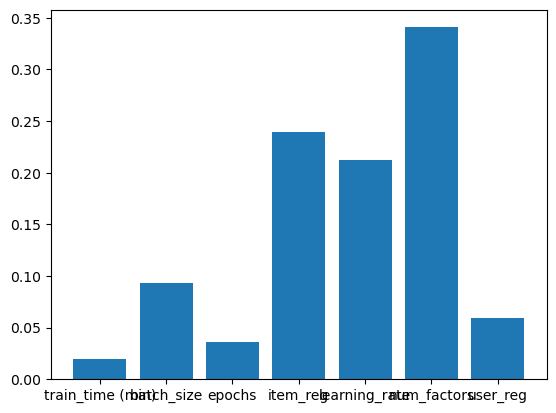

In [53]:
regr = RandomForestRegressor(max_depth=2)

result_df = save_results.results_df.copy()

numerical_cols = result_df.mean().notna()
numerical_cols = numerical_cols.index[numerical_cols]

numerical_df = result_df[numerical_cols]
numerical_df = (numerical_df - numerical_df.mean()) / (numerical_df.std() + 1e-6)

y_train = numerical_df["result"]
X_train = numerical_df.copy()
X_train = X_train.drop(columns=["result"])

regr.fit(X_train, y_train)

plt.bar(X_train.columns, regr.feature_importances_)
plt.show()